In [1]:
import json, datetime
import numpy as np
import os
import pandas as pd
import urllib3
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import h5py
from sklearn.preprocessing import MinMaxScaler
from poloniex import Poloniex

In [2]:
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    
    Transfrom each feature as a sequence (t-N, t-4, ... t - to predict t+1, t+2, .. t+K)
    
    N - Number of Past Values
    K - Number of Future Values
    Sliding Window - If True then overlapping sequences will be created
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, df):
        '''
        Transform Dataframe to train on K Past values and predict the next N values
        
        Parameters
        ----------
        arg : df
            Dataframes with shape (m, n)
                m - Number of samples
                n - Number of features per row

        Returns
        ----------
        Numpy array : B[:, :ci]
            - Sample matrix with shape of (m/M or m-M+1, K, number of features)
            
        Numpy array : B[:, :ci]
            - Target matrix with shape of (m/M or m-M+1, N, number of features)
            
        '''
        
        A = np.array(df)[:,None,:]    #np.array with shape (m, 1, n)
        M = self.N + self.K     #Number of samples per row (sample + target)
        
        #indexes
        if self.sliding_window:
            U = np.arange(A.shape[0] - M + 1).reshape(-1, 1) #(m-M+1, 1)
            T = np.arange(M) #(M, )
            I = U + T #(m-M+1, M)

        else:
            if A.shape[0] % M == 0:
                U = np.arange(0, A.shape[0], M).reshape(-1, 1) #(m/M, 1)
                T = np.arange(M) #(M, )
                I = U + T #(m/M, M)
                
            else:
                U = np.arange(0, A.shape[0] - M, M).reshape(-1, 1) #(m/M, 1)
                T = np.arange(M) #(M, 
                I = U + T #(m/M, M)
        
        
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2]) #(m-M+1, M, n) or (m/M, M, n)
        ci = self.N * A.shape[1]    #Number of features per sample (time to predict * number of features for each time sample)

        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

In [3]:
polo = Poloniex()
returnTicker = polo.returnChartData('USDT_BTC', period=300, start='112864000', end='9999999999')
#returnTicker = polo.returnCurrencies()
#returnTicker = polo.returnTicker()
#returnTicker = polo.return24hVolume()

In [4]:
df = pd.DataFrame.from_dict(returnTicker)
df_original = df.copy()
df_original['Datetime'] = pd.to_datetime(df_original['date'], unit='s')

df.to_csv('data/bitcoin2015to2017.csv',index=None)

In [5]:
df_train = pd.DataFrame((df.loc[:, 'close']).astype(float))
scaler = MinMaxScaler()

for c in df_train.columns:
    if c is not 'date':
        df_train[c] = scaler.fit_transform(df_train[c].values.reshape(-1,1))

ps = PastSampler(256, 16, sliding_window=True)
train_features, train_labels = ps.transform(df_train)

In [6]:
train_features.shape, train_labels.shape

((303504, 256, 1), (303504, 16, 1))

# Building a CNN model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

step_size = train_features.shape[1]
nb_features = train_features.shape[2]
training_size = int(0.8* train_features.shape[0])

#split training validation
training_datas = train_features[:training_size, :]
training_labels = train_labels[:training_size, :]

validation_datas = train_features[training_size:, :]
validation_labels = train_labels[training_size:, :]

Using TensorFlow backend.


In [8]:
training_datas.shape, training_labels.shape, validation_datas.shape, validation_labels.shape

((242803, 256, 1), (242803, 16, 1), (60701, 256, 1), (60701, 16, 1))

In [9]:
# 2 layers 1-D CNN
model = Sequential()

model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.5))
model.add(Conv1D(strides=4, filters=nb_features, kernel_size=16))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 79, 8)             168       
_________________________________________________________________
dropout_1 (Dropout)          (None, 79, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 1)             129       
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mse', optimizer='adam')
model.fit(training_datas, 
          training_labels,
          verbose = 1,
          epochs = 2,
          batch_size = 14,
          validation_data=(validation_datas,validation_labels))

Train on 242803 samples, validate on 60701 samples
Epoch 1/2
242803/242803 [==============================] - 30s 125us/step - loss: 2.3923e-05 - val_loss: 6.4934e-04
Epoch 2/2
242803/242803 [==============================] - 29s 121us/step - loss: 2.0788e-05 - val_loss: 4.3742e-04


In [12]:
predicted = model.predict(validation_datas)
predicted_inverted = []

original_data = pd.DataFrame((df_original.loc[:, 'close']).astype(float))

for i in range(original_data.shape[1]):
    scaler.fit(original_data.iloc[:,i].values.reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))

ground_true = df_original['close']
ground_true_times = df_original['Datetime'].values.reshape(-1)

predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)

In [13]:
def median_predictions(predicted):
    #print(predicted.shape[0], predicted.shape[0] + predicted.shape[1] - 1)
    array_global = np.zeros((1, predicted.shape[0] + predicted.shape[1] - 1))
    #array[:] = np.nan
    
    for i in range(predicted.shape[0]):
        array = np.zeros((1, predicted.shape[0] + predicted.shape[1] - 1))
        array[0, i:(predicted[i,:,:].shape[0]+i)] = predicted[i,:,:].reshape(-1)
        array_global = np.concatenate((array_global, array))
        
    median = pd.DataFrame(array_global).median()
    
    return median

In [18]:
def median_predictions_I(predicted):
    #print(predicted.shape[0], predicted.shape[0] + predicted.shape[1] - 1)
    array_global = []
    #array[:] = np.nan
    
    for i in range(predicted.shape[0]):
        array = np.zeros((1, predicted.shape[0] + predicted.shape[1] - 1))
        array[0, i:(predicted[i,:,:].shape[0]+i)] = predicted[i,:,:].reshape(-1)
        array_global.append(array)
    
    return array_global

In [39]:
def median_predictions_II(predicted):
    
    array_test_predictions_ = [[] for _ in range((predicted.shape[0] + predicted.shape[1]))]

    for i in range(len(predicted)):
        for l, k in enumerate(predicted[i]):
            array_test_predictions_[i+l].append((int(k)))
    
    return array_test_predictions_

In [ ]:
array = median_predictions_II(predicted)

[ 0.14058065]
[ 0.14081894]
[ 0.14094782]
[ 0.14091825]
[ 0.14067741]
[ 0.14011203]
[ 0.13940649]
[ 0.13853893]
[ 0.13743724]
[ 0.13590065]
[ 0.13340485]
[ 0.13065745]
[ 0.12867369]
[ 0.12753937]
[ 0.12720241]
[ 0.12674372]
[ 0.14060023]
[ 0.14082961]
[ 0.14096022]
[ 0.14092585]
[ 0.14065132]
[ 0.14004295]
[ 0.13933133]
[ 0.13844673]
[ 0.13735659]
[ 0.13575587]
[ 0.13328223]
[ 0.13068792]
[ 0.12877432]
[ 0.12772281]
[ 0.12727459]
[ 0.12652449]
[ 0.14063664]
[ 0.14086124]
[ 0.1409633]
[ 0.14091682]
[ 0.14059949]
[ 0.1399785]
[ 0.13925496]
[ 0.138329]
[ 0.13722131]
[ 0.13558978]
[ 0.13292375]
[ 0.13036472]
[ 0.12856384]
[ 0.12751882]
[ 0.12726796]
[ 0.12646833]
[ 0.14065261]
[ 0.14086461]
[ 0.14094466]
[ 0.14088595]
[ 0.14054909]
[ 0.13993104]
[ 0.13922469]
[ 0.13828003]
[ 0.13715297]
[ 0.13537589]
[ 0.1326022]
[ 0.13005568]
[ 0.1282957]
[ 0.12738271]
[ 0.12725006]
[ 0.1264618]
[ 0.14067489]
[ 0.14088887]
[ 0.14094943]
[ 0.1408945]
[ 0.14051366]
[ 0.1398519]
[ 0.13915458]
[ 0.13818315]
[

[ 0.12687635]
[ 0.12536187]
[ 0.12271674]
[ 0.12017674]
[ 0.11824533]
[ 0.11778007]
[ 0.11849598]
[ 0.11948029]
[ 0.13870162]
[ 0.13760665]
[ 0.13630927]
[ 0.13400176]
[ 0.13133322]
[ 0.12918662]
[ 0.12782805]
[ 0.127308]
[ 0.12672965]
[ 0.12502563]
[ 0.12231912]
[ 0.11979511]
[ 0.11798143]
[ 0.117665]
[ 0.11845341]
[ 0.11952581]
[ 0.13858555]
[ 0.13748233]
[ 0.13608247]
[ 0.13365662]
[ 0.13099207]
[ 0.12893832]
[ 0.12767917]
[ 0.12727469]
[ 0.12667646]
[ 0.12473894]
[ 0.12194818]
[ 0.11945062]
[ 0.11771094]
[ 0.11766873]
[ 0.11855319]
[ 0.11966143]
[ 0.13853893]
[ 0.13743724]
[ 0.13590065]
[ 0.13340485]
[ 0.13065745]
[ 0.12867369]
[ 0.12753937]
[ 0.12720241]
[ 0.12674372]
[ 0.12470104]
[ 0.12202015]
[ 0.1196133]
[ 0.11784691]
[ 0.11793738]
[ 0.11872426]
[ 0.11975338]
[ 0.13844673]
[ 0.13735659]
[ 0.13575587]
[ 0.13328223]
[ 0.13068792]
[ 0.12877432]
[ 0.12772281]
[ 0.12727459]
[ 0.12652449]
[ 0.12431642]
[ 0.12162361]
[ 0.11925837]
[ 0.11764548]
[ 0.11784744]
[ 0.11871361]
[ 0.1198019

[ 0.12720241]
[ 0.12674372]
[ 0.12470104]
[ 0.12202015]
[ 0.1196133]
[ 0.11784691]
[ 0.11793738]
[ 0.11872426]
[ 0.11975338]
[ 0.12113816]
[ 0.12207881]
[ 0.122665]
[ 0.122737]
[ 0.12252863]
[ 0.12246344]
[ 0.12301926]
[ 0.12727459]
[ 0.12652449]
[ 0.12431642]
[ 0.12162361]
[ 0.11925837]
[ 0.11764548]
[ 0.11784744]
[ 0.11871361]
[ 0.11980196]
[ 0.12126777]
[ 0.12222155]
[ 0.12272993]
[ 0.12278631]
[ 0.12252071]
[ 0.12246784]
[ 0.12312246]
[ 0.12726796]
[ 0.12646833]
[ 0.12402688]
[ 0.12127794]
[ 0.11891967]
[ 0.11741012]
[ 0.11786792]
[ 0.11880711]
[ 0.11989255]
[ 0.1213356]
[ 0.12218138]
[ 0.1226689]
[ 0.1227454]
[ 0.12249149]
[ 0.12250777]
[ 0.12325633]
[ 0.12725006]
[ 0.1264618]
[ 0.12404653]
[ 0.12136669]
[ 0.11906876]
[ 0.11766096]
[ 0.11808314]
[ 0.11900663]
[ 0.12006598]
[ 0.121452]
[ 0.12226959]
[ 0.12268489]
[ 0.12271923]
[ 0.12245269]
[ 0.12251437]
[ 0.12335629]
[ 0.12722477]
[ 0.12620939]
[ 0.1236678]
[ 0.12102561]
[ 0.1187587]
[ 0.11746141]
[ 0.11800627]
[ 0.11893771]
[ 0.1

[ 0.12420253]
[ 0.12578091]
[ 0.12685506]
[ 0.12722519]
[ 0.12661964]
[ 0.12570257]
[ 0.11766873]
[ 0.11855319]
[ 0.11966143]
[ 0.12099082]
[ 0.12202535]
[ 0.122632]
[ 0.1227432]
[ 0.12258001]
[ 0.12244149]
[ 0.1229433]
[ 0.12436292]
[ 0.125917]
[ 0.12696485]
[ 0.12726201]
[ 0.12659135]
[ 0.12563385]
[ 0.11793738]
[ 0.11872426]
[ 0.11975338]
[ 0.12113816]
[ 0.12207881]
[ 0.122665]
[ 0.122737]
[ 0.12252863]
[ 0.12246344]
[ 0.12301926]
[ 0.1244953]
[ 0.12603846]
[ 0.12700883]
[ 0.12723286]
[ 0.12649553]
[ 0.12555356]
[ 0.11784744]
[ 0.11871361]
[ 0.11980196]
[ 0.12126777]
[ 0.12222155]
[ 0.12272993]
[ 0.12278631]
[ 0.12252071]
[ 0.12246784]
[ 0.12312246]
[ 0.12462001]
[ 0.12611002]
[ 0.12701005]
[ 0.12715255]
[ 0.12638953]
[ 0.12550668]
[ 0.11786792]
[ 0.11880711]
[ 0.11989255]
[ 0.1213356]
[ 0.12218138]
[ 0.1226689]
[ 0.1227454]
[ 0.12249149]
[ 0.12250777]
[ 0.12325633]
[ 0.12477108]
[ 0.1262484]
[ 0.12711449]
[ 0.12716167]
[ 0.12634337]
[ 0.12544459]
[ 0.11808314]
[ 0.11900663]
[ 0.120

[ 0.12539239]
[ 0.12598738]
[ 0.12683657]
[ 0.12765802]
[ 0.12826344]
[ 0.12870459]
[ 0.12241789]
[ 0.12259558]
[ 0.12360954]
[ 0.12518689]
[ 0.12654567]
[ 0.12721834]
[ 0.12700173]
[ 0.12607749]
[ 0.12529872]
[ 0.12512407]
[ 0.1253912]
[ 0.12603126]
[ 0.12689322]
[ 0.12770718]
[ 0.1283101]
[ 0.12873952]
[ 0.12239054]
[ 0.12261236]
[ 0.12370747]
[ 0.1253092]
[ 0.12664042]
[ 0.12724286]
[ 0.12694493]
[ 0.12600148]
[ 0.12523434]
[ 0.12511709]
[ 0.12545134]
[ 0.12610114]
[ 0.12699807]
[ 0.12776609]
[ 0.12833889]
[ 0.12874596]
[ 0.12241021]
[ 0.12263378]
[ 0.12382159]
[ 0.12539978]
[ 0.12665896]
[ 0.12721024]
[ 0.12683477]
[ 0.12592302]
[ 0.12524731]
[ 0.12516022]
[ 0.1255226]
[ 0.12617244]
[ 0.12706511]
[ 0.12781745]
[ 0.12838957]
[ 0.12876211]
[ 0.12241268]
[ 0.12270438]
[ 0.12395987]
[ 0.12556373]
[ 0.12676628]
[ 0.12728317]
[ 0.12680918]
[ 0.12585488]
[ 0.12519154]
[ 0.12512052]
[ 0.12553196]
[ 0.12622105]
[ 0.12713636]
[ 0.12787145]
[ 0.12844263]
[ 0.12877424]
[ 0.12242804]
[ 0.122749

[ 0.12649553]
[ 0.12555356]
[ 0.12514083]
[ 0.12522291]
[ 0.12572984]
[ 0.12652525]
[ 0.12741093]
[ 0.12805188]
[ 0.12856583]
[ 0.12873341]
[ 0.12839021]
[ 0.12809037]
[ 0.12781702]
[ 0.1276174]
[ 0.12771608]
[ 0.12715255]
[ 0.12638953]
[ 0.12550668]
[ 0.12517591]
[ 0.12529287]
[ 0.12580284]
[ 0.12660468]
[ 0.12747395]
[ 0.12810554]
[ 0.12860338]
[ 0.12871657]
[ 0.12836058]
[ 0.12806407]
[ 0.12779748]
[ 0.1276252]
[ 0.12774776]
[ 0.12716167]
[ 0.12634337]
[ 0.12544459]
[ 0.12513435]
[ 0.12528653]
[ 0.12583525]
[ 0.12666479]
[ 0.12752886]
[ 0.12816949]
[ 0.1286515]
[ 0.12871785]
[ 0.12831973]
[ 0.1280122]
[ 0.12773581]
[ 0.12758106]
[ 0.12776482]
[ 0.12711047]
[ 0.1262358]
[ 0.12538151]
[ 0.12511796]
[ 0.12533529]
[ 0.12591805]
[ 0.12675869]
[ 0.12758024]
[ 0.1282029]
[ 0.12866023]
[ 0.12868319]
[ 0.12831551]
[ 0.12801115]
[ 0.12773433]
[ 0.12760669]
[ 0.12780301]
[ 0.12700744]
[ 0.12614352]
[ 0.12536465]
[ 0.12515706]
[ 0.12539239]
[ 0.12598738]
[ 0.12683657]
[ 0.12765802]
[ 0.12826344

[ 0.12856583]
[ 0.12873341]
[ 0.12839021]
[ 0.12809037]
[ 0.12781702]
[ 0.1276174]
[ 0.12771608]
[ 0.12806755]
[ 0.1285108]
[ 0.12887543]
[ 0.12903889]
[ 0.12900497]
[ 0.12864752]
[ 0.12660468]
[ 0.12747395]
[ 0.12810554]
[ 0.12860338]
[ 0.12871657]
[ 0.12836058]
[ 0.12806407]
[ 0.12779748]
[ 0.1276252]
[ 0.12774776]
[ 0.12810034]
[ 0.12853858]
[ 0.128904]
[ 0.12903713]
[ 0.12897854]
[ 0.12860006]
[ 0.12666479]
[ 0.12752886]
[ 0.12816949]
[ 0.1286515]
[ 0.12871785]
[ 0.12831973]
[ 0.1280122]
[ 0.12773581]
[ 0.12758106]
[ 0.12776482]
[ 0.12814113]
[ 0.12858282]
[ 0.12894197]
[ 0.12905952]
[ 0.12898882]
[ 0.12857181]
[ 0.12675869]
[ 0.12758024]
[ 0.1282029]
[ 0.12866023]
[ 0.12868319]
[ 0.12831551]
[ 0.12801115]
[ 0.12773433]
[ 0.12760669]
[ 0.12780301]
[ 0.12818362]
[ 0.12861301]
[ 0.1289428]
[ 0.12904961]
[ 0.1289476]
[ 0.12849432]
[ 0.12683657]
[ 0.12765802]
[ 0.12826344]
[ 0.12870459]
[ 0.12865664]
[ 0.12827955]
[ 0.12799072]
[ 0.12771189]
[ 0.12760732]
[ 0.12782714]
[ 0.12822115]
[ 

[ 0.12789981]
[ 0.12833385]
[ 0.12874739]
[ 0.12900114]
[ 0.12905462]
[ 0.12883677]
[ 0.12827404]
[ 0.12760128]
[ 0.12702587]
[ 0.1266664]
[ 0.12665035]
[ 0.12644391]
[ 0.12818097]
[ 0.12789126]
[ 0.12761179]
[ 0.12761369]
[ 0.12791701]
[ 0.12836683]
[ 0.12878899]
[ 0.12903529]
[ 0.1290779]
[ 0.12884365]
[ 0.12823704]
[ 0.12754394]
[ 0.12697402]
[ 0.12663676]
[ 0.12665577]
[ 0.12636989]
[ 0.12816083]
[ 0.12788498]
[ 0.12763502]
[ 0.1276422]
[ 0.12796384]
[ 0.12840259]
[ 0.12879266]
[ 0.12902136]
[ 0.12905017]
[ 0.12877759]
[ 0.1281638]
[ 0.1275029]
[ 0.12693968]
[ 0.12662391]
[ 0.12664877]
[ 0.12625816]
[ 0.12815015]
[ 0.1278659]
[ 0.12763716]
[ 0.12766908]
[ 0.12798895]
[ 0.12844327]
[ 0.12883219]
[ 0.1290241]
[ 0.12902927]
[ 0.12873442]
[ 0.1280894]
[ 0.12745325]
[ 0.12691107]
[ 0.1266225]
[ 0.12667508]
[ 0.12619881]
[ 0.128114]
[ 0.12781717]
[ 0.12759657]
[ 0.12767263]
[ 0.12801704]
[ 0.12847735]
[ 0.12886067]
[ 0.12905078]
[ 0.12903975]
[ 0.12872185]
[ 0.12805852]
[ 0.12740748]
[ 0

[ 0.12665448]
[ 0.12660244]
[ 0.12552334]
[ 0.1234276]
[ 0.12140446]
[ 0.11924861]
[ 0.11769141]
[ 0.11739186]
[ 0.12868798]
[ 0.12899874]
[ 0.12908065]
[ 0.12892424]
[ 0.12841228]
[ 0.1277065]
[ 0.12710699]
[ 0.12669441]
[ 0.12663203]
[ 0.12655963]
[ 0.12532274]
[ 0.12326445]
[ 0.12125688]
[ 0.11910329]
[ 0.11772364]
[ 0.11742131]
[ 0.12870884]
[ 0.12899052]
[ 0.1290665]
[ 0.12888071]
[ 0.1283398]
[ 0.12765057]
[ 0.12706238]
[ 0.12667629]
[ 0.12663038]
[ 0.1264884]
[ 0.12513798]
[ 0.12304755]
[ 0.12108168]
[ 0.11889344]
[ 0.11762925]
[ 0.11739755]
[ 0.12874739]
[ 0.12900114]
[ 0.12905462]
[ 0.12883677]
[ 0.12827404]
[ 0.12760128]
[ 0.12702587]
[ 0.1266664]
[ 0.12665035]
[ 0.12644391]
[ 0.12502639]
[ 0.12292042]
[ 0.12091349]
[ 0.11877654]
[ 0.11756773]
[ 0.11734254]
[ 0.12878899]
[ 0.12903529]
[ 0.1290779]
[ 0.12884365]
[ 0.12823704]
[ 0.12754394]
[ 0.12697402]
[ 0.12663676]
[ 0.12665577]
[ 0.12636989]
[ 0.12482137]
[ 0.12273904]
[ 0.12072573]
[ 0.11866456]
[ 0.1176179]
[ 0.11741305]


[ 0.12710699]
[ 0.12669441]
[ 0.12663203]
[ 0.12655963]
[ 0.12532274]
[ 0.12326445]
[ 0.12125688]
[ 0.11910329]
[ 0.11772364]
[ 0.11742131]
[ 0.11726207]
[ 0.11745258]
[ 0.11735363]
[ 0.11600526]
[ 0.1143476]
[ 0.11291728]
[ 0.12706238]
[ 0.12667629]
[ 0.12663038]
[ 0.1264884]
[ 0.12513798]
[ 0.12304755]
[ 0.12108168]
[ 0.11889344]
[ 0.11762925]
[ 0.11739755]
[ 0.11723269]
[ 0.11750895]
[ 0.11730614]
[ 0.11582778]
[ 0.11411266]
[ 0.11274328]
[ 0.12702587]
[ 0.1266664]
[ 0.12665035]
[ 0.12644391]
[ 0.12502639]
[ 0.12292042]
[ 0.12091349]
[ 0.11877654]
[ 0.11756773]
[ 0.11734254]
[ 0.11717933]
[ 0.11744811]
[ 0.11717271]
[ 0.11576461]
[ 0.11412399]
[ 0.11280455]
[ 0.12697402]
[ 0.12663676]
[ 0.12665577]
[ 0.12636989]
[ 0.12482137]
[ 0.12273904]
[ 0.12072573]
[ 0.11866456]
[ 0.1176179]
[ 0.11741305]
[ 0.11723756]
[ 0.11749134]
[ 0.1171081]
[ 0.11557087]
[ 0.11399049]
[ 0.1127005]
[ 0.12693968]
[ 0.12662391]
[ 0.12664877]
[ 0.12625816]
[ 0.12462135]
[ 0.1225523]
[ 0.12053297]
[ 0.11847242]

[ 0.11289846]
[ 0.12376633]
[ 0.12177861]
[ 0.11962172]
[ 0.11794119]
[ 0.11751919]
[ 0.11731219]
[ 0.11736096]
[ 0.11748599]
[ 0.11637463]
[ 0.11474002]
[ 0.11325248]
[ 0.11243268]
[ 0.11303677]
[ 0.11389127]
[ 0.1139301]
[ 0.11264542]
[ 0.12355096]
[ 0.1215921]
[ 0.11943097]
[ 0.11780653]
[ 0.11746074]
[ 0.11727502]
[ 0.11739957]
[ 0.11748113]
[ 0.11622725]
[ 0.11451355]
[ 0.11302059]
[ 0.1123525]
[ 0.11307699]
[ 0.11394849]
[ 0.11389052]
[ 0.11243407]
[ 0.1234276]
[ 0.12140446]
[ 0.11924861]
[ 0.11769141]
[ 0.11739186]
[ 0.11724169]
[ 0.11737167]
[ 0.11740907]
[ 0.11611831]
[ 0.11447101]
[ 0.11304936]
[ 0.11246693]
[ 0.1132384]
[ 0.11404501]
[ 0.11388222]
[ 0.11231668]
[ 0.12326445]
[ 0.12125688]
[ 0.11910329]
[ 0.11772364]
[ 0.11742131]
[ 0.11726207]
[ 0.11745258]
[ 0.11735363]
[ 0.11600526]
[ 0.1143476]
[ 0.11291728]
[ 0.11245616]
[ 0.11323756]
[ 0.11399285]
[ 0.11376732]
[ 0.11203536]
[ 0.12304755]
[ 0.12108168]
[ 0.11889344]
[ 0.11762925]
[ 0.11739755]
[ 0.11723269]
[ 0.11750895

[ 0.11325248]
[ 0.11243268]
[ 0.11303677]
[ 0.11389127]
[ 0.1139301]
[ 0.11264542]
[ 0.1102715]
[ 0.10858582]
[ 0.10841218]
[ 0.10908002]
[ 0.10961257]
[ 0.11727502]
[ 0.11739957]
[ 0.11748113]
[ 0.11622725]
[ 0.11451355]
[ 0.11302059]
[ 0.1123525]
[ 0.11307699]
[ 0.11394849]
[ 0.11389052]
[ 0.11243407]
[ 0.11009501]
[ 0.10861152]
[ 0.10854688]
[ 0.10928825]
[ 0.10963749]
[ 0.11724169]
[ 0.11737167]
[ 0.11740907]
[ 0.11611831]
[ 0.11447101]
[ 0.11304936]
[ 0.11246693]
[ 0.1132384]
[ 0.11404501]
[ 0.11388222]
[ 0.11231668]
[ 0.11000469]
[ 0.1086158]
[ 0.10861658]
[ 0.10937845]
[ 0.10964519]
[ 0.11726207]
[ 0.11745258]
[ 0.11735363]
[ 0.11600526]
[ 0.1143476]
[ 0.11291728]
[ 0.11245616]
[ 0.11323756]
[ 0.11399285]
[ 0.11376732]
[ 0.11203536]
[ 0.10974939]
[ 0.10846553]
[ 0.10853627]
[ 0.10935289]
[ 0.10953953]
[ 0.11723269]
[ 0.11750895]
[ 0.11730614]
[ 0.11582778]
[ 0.11411266]
[ 0.11274328]
[ 0.11241501]
[ 0.11332117]
[ 0.11403573]
[ 0.11370468]
[ 0.11183342]
[ 0.10957416]
[ 0.10852336

[ 0.10957416]
[ 0.10852336]
[ 0.10866969]
[ 0.10951899]
[ 0.1095442]
[ 0.1083424]
[ 0.10667495]
[ 0.10454655]
[ 0.10288554]
[ 0.10222506]
[ 0.10254151]
[ 0.11260084]
[ 0.1134437]
[ 0.11408023]
[ 0.11367323]
[ 0.1117126]
[ 0.10947736]
[ 0.1085405]
[ 0.10875399]
[ 0.10955998]
[ 0.10956208]
[ 0.10834567]
[ 0.10667712]
[ 0.10456058]
[ 0.10291263]
[ 0.10231677]
[ 0.10270171]
[ 0.11260053]
[ 0.11347609]
[ 0.11402038]
[ 0.11351139]
[ 0.1114336]
[ 0.10926042]
[ 0.10836916]
[ 0.108669]
[ 0.10950781]
[ 0.10942835]
[ 0.10824095]
[ 0.10653718]
[ 0.10441035]
[ 0.10285167]
[ 0.10231654]
[ 0.10279477]
[ 0.11264675]
[ 0.11355505]
[ 0.11405829]
[ 0.11339913]
[ 0.11118607]
[ 0.10917025]
[ 0.10843857]
[ 0.10883268]
[ 0.10967005]
[ 0.10934008]
[ 0.10801103]
[ 0.10619184]
[ 0.10403059]
[ 0.10259532]
[ 0.1021843]
[ 0.10277429]
[ 0.11280274]
[ 0.11368655]
[ 0.11411109]
[ 0.11334624]
[ 0.1110828]
[ 0.10908618]
[ 0.10847943]
[ 0.10889807]
[ 0.10969373]
[ 0.10933184]
[ 0.10801358]
[ 0.10620384]
[ 0.10408742]
[ 

[ 0.10917382]
[ 0.10788471]
[ 0.10601052]
[ 0.10395617]
[ 0.1026236]
[ 0.10228839]
[ 0.10309404]
[ 0.10432363]
[ 0.1057489]
[ 0.10689933]
[ 0.10799854]
[ 0.10949927]
[ 0.10882943]
[ 0.10844844]
[ 0.10899768]
[ 0.10970166]
[ 0.10902756]
[ 0.10761284]
[ 0.10565803]
[ 0.10360001]
[ 0.10242166]
[ 0.10219762]
[ 0.10308278]
[ 0.10433655]
[ 0.10574515]
[ 0.106902]
[ 0.10804494]
[ 0.10962314]
[ 0.10878984]
[ 0.10851596]
[ 0.10907748]
[ 0.10972412]
[ 0.10901018]
[ 0.10758773]
[ 0.1056485]
[ 0.103624]
[ 0.10252324]
[ 0.10233825]
[ 0.10325847]
[ 0.10455199]
[ 0.10590372]
[ 0.107036]
[ 0.10815292]
[ 0.10974441]
[ 0.10858582]
[ 0.10841218]
[ 0.10908002]
[ 0.10961257]
[ 0.10890575]
[ 0.10747024]
[ 0.10544864]
[ 0.10349613]
[ 0.1024904]
[ 0.10236779]
[ 0.10339458]
[ 0.10472698]
[ 0.10602346]
[ 0.10715032]
[ 0.10834315]
[ 0.10994079]
[ 0.10861152]
[ 0.10854688]
[ 0.10928825]
[ 0.10963749]
[ 0.10871505]
[ 0.10714153]
[ 0.10509136]
[ 0.1031908]
[ 0.10229401]
[ 0.10230189]
[ 0.10337304]
[ 0.10471801]
[ 0

[ 0.11199667]
[ 0.11166627]
[ 0.11077528]
[ 0.11001412]
[ 0.10996573]
[ 0.1105769]
[ 0.10321952]
[ 0.10240523]
[ 0.1025109]
[ 0.10355564]
[ 0.1049351]
[ 0.10614999]
[ 0.10725265]
[ 0.10848849]
[ 0.11017109]
[ 0.11154742]
[ 0.11195887]
[ 0.11156496]
[ 0.11065412]
[ 0.10992238]
[ 0.10996065]
[ 0.11063183]
[ 0.10311391]
[ 0.10238472]
[ 0.10255804]
[ 0.10367113]
[ 0.10511404]
[ 0.10632561]
[ 0.10741048]
[ 0.10871583]
[ 0.11034555]
[ 0.11164276]
[ 0.1120009]
[ 0.11157136]
[ 0.11066813]
[ 0.10993888]
[ 0.1099892]
[ 0.11067355]
[ 0.10288554]
[ 0.10222506]
[ 0.10254151]
[ 0.10367279]
[ 0.10504721]
[ 0.10632194]
[ 0.10740758]
[ 0.10880256]
[ 0.11049996]
[ 0.11172904]
[ 0.11199281]
[ 0.11148237]
[ 0.11056148]
[ 0.10991494]
[ 0.11004575]
[ 0.11079516]
[ 0.10291263]
[ 0.10231677]
[ 0.10270171]
[ 0.10388649]
[ 0.10527065]
[ 0.10645848]
[ 0.10749958]
[ 0.10887413]
[ 0.11055592]
[ 0.11174222]
[ 0.1119286]
[ 0.11139692]
[ 0.11045594]
[ 0.10988217]
[ 0.11006667]
[ 0.11085614]
[ 0.10285167]
[ 0.10231654

[ 0.11346308]
[ 0.11405466]
[ 0.11463923]
[ 0.10602346]
[ 0.10715032]
[ 0.10834315]
[ 0.10994079]
[ 0.11137301]
[ 0.11200754]
[ 0.11169048]
[ 0.11086541]
[ 0.11005192]
[ 0.10994402]
[ 0.11049739]
[ 0.11157127]
[ 0.11276814]
[ 0.11348856]
[ 0.11412051]
[ 0.11468797]
[ 0.10603168]
[ 0.10720602]
[ 0.10841203]
[ 0.11008911]
[ 0.111469]
[ 0.11199667]
[ 0.11166627]
[ 0.11077528]
[ 0.11001412]
[ 0.10996573]
[ 0.1105769]
[ 0.11173628]
[ 0.11289702]
[ 0.11354364]
[ 0.11415554]
[ 0.11468261]
[ 0.10614999]
[ 0.10725265]
[ 0.10848849]
[ 0.11017109]
[ 0.11154742]
[ 0.11195887]
[ 0.11156496]
[ 0.11065412]
[ 0.10992238]
[ 0.10996065]
[ 0.11063183]
[ 0.11182179]
[ 0.11295152]
[ 0.11360554]
[ 0.11422219]
[ 0.11474714]
[ 0.10632561]
[ 0.10741048]
[ 0.10871583]
[ 0.11034555]
[ 0.11164276]
[ 0.1120009]
[ 0.11157136]
[ 0.11066813]
[ 0.10993888]
[ 0.1099892]
[ 0.11067355]
[ 0.11189423]
[ 0.11300291]
[ 0.11364424]
[ 0.11428186]
[ 0.11479159]
[ 0.10632194]
[ 0.10740758]
[ 0.10880256]
[ 0.11049996]
[ 0.1117290

[ 0.11023106]
[ 0.10991714]
[ 0.11029496]
[ 0.1112328]
[ 0.1124885]
[ 0.11334557]
[ 0.11393627]
[ 0.11455756]
[ 0.11480741]
[ 0.11457789]
[ 0.11389007]
[ 0.11320388]
[ 0.11117115]
[ 0.11194841]
[ 0.11178804]
[ 0.11102962]
[ 0.11017438]
[ 0.10993775]
[ 0.11038164]
[ 0.11139933]
[ 0.11263416]
[ 0.11340662]
[ 0.11397744]
[ 0.11456043]
[ 0.11475727]
[ 0.11449062]
[ 0.11381404]
[ 0.11314116]
[ 0.11123071]
[ 0.11191132]
[ 0.11168256]
[ 0.11089497]
[ 0.11006408]
[ 0.1099266]
[ 0.11043315]
[ 0.11146995]
[ 0.11270656]
[ 0.11346308]
[ 0.11405466]
[ 0.11463923]
[ 0.11477638]
[ 0.11443279]
[ 0.11373527]
[ 0.11304856]
[ 0.11137301]
[ 0.11200754]
[ 0.11169048]
[ 0.11086541]
[ 0.11005192]
[ 0.10994402]
[ 0.11049739]
[ 0.11157127]
[ 0.11276814]
[ 0.11348856]
[ 0.11412051]
[ 0.11468797]
[ 0.11480359]
[ 0.11440922]
[ 0.11371065]
[ 0.11302856]
[ 0.111469]
[ 0.11199667]
[ 0.11166627]
[ 0.11077528]
[ 0.11001412]
[ 0.10996573]
[ 0.1105769]
[ 0.11173628]
[ 0.11289702]
[ 0.11354364]
[ 0.11415554]
[ 0.11468261

[ 0.11366277]
[ 0.11458074]
[ 0.11523841]
[ 0.1158558]
[ 0.11619099]
[ 0.11608262]
[ 0.11583174]
[ 0.11314221]
[ 0.11374416]
[ 0.11437515]
[ 0.11479155]
[ 0.11468448]
[ 0.11410033]
[ 0.11337314]
[ 0.11284221]
[ 0.1128991]
[ 0.11373287]
[ 0.11465546]
[ 0.11529329]
[ 0.11586609]
[ 0.11615627]
[ 0.11602739]
[ 0.11578839]
[ 0.11317148]
[ 0.11378374]
[ 0.11442696]
[ 0.11481599]
[ 0.11470491]
[ 0.1140639]
[ 0.11336061]
[ 0.11285777]
[ 0.11295731]
[ 0.11383166]
[ 0.11472977]
[ 0.11537137]
[ 0.11593048]
[ 0.11617861]
[ 0.11600734]
[ 0.11574583]
[ 0.11325488]
[ 0.11381753]
[ 0.11443716]
[ 0.11474318]
[ 0.11463058]
[ 0.11398961]
[ 0.11330778]
[ 0.11287045]
[ 0.1129987]
[ 0.11390101]
[ 0.11477719]
[ 0.1154133]
[ 0.11597054]
[ 0.11620497]
[ 0.11600386]
[ 0.11573946]
[ 0.11330903]
[ 0.11388499]
[ 0.11450797]
[ 0.11479179]
[ 0.11459181]
[ 0.11390447]
[ 0.11320834]
[ 0.11281476]
[ 0.11306521]
[ 0.11397991]
[ 0.11483284]
[ 0.11546583]
[ 0.11597207]
[ 0.11618084]
[ 0.11597207]
[ 0.11571275]
[ 0.1133455

[ 0.11390101]
[ 0.11477719]
[ 0.1154133]
[ 0.11597054]
[ 0.11620497]
[ 0.11600386]
[ 0.11573946]
[ 0.11543355]
[ 0.1149921]
[ 0.11456466]
[ 0.11426646]
[ 0.11459181]
[ 0.11390447]
[ 0.11320834]
[ 0.11281476]
[ 0.11306521]
[ 0.11397991]
[ 0.11483284]
[ 0.11546583]
[ 0.11597207]
[ 0.11618084]
[ 0.11597207]
[ 0.11571275]
[ 0.11539945]
[ 0.11493114]
[ 0.11450465]
[ 0.11420267]
[ 0.11457789]
[ 0.11389007]
[ 0.11320388]
[ 0.11285023]
[ 0.11314512]
[ 0.11406676]
[ 0.11489641]
[ 0.1155517]
[ 0.11603675]
[ 0.1161767]
[ 0.11594477]
[ 0.11566489]
[ 0.11536324]
[ 0.11490329]
[ 0.11451935]
[ 0.11425579]
[ 0.11449062]
[ 0.11381404]
[ 0.11314116]
[ 0.11284462]
[ 0.11321628]
[ 0.11412943]
[ 0.11493511]
[ 0.11559721]
[ 0.11608703]
[ 0.11620028]
[ 0.11595728]
[ 0.115649]
[ 0.11531845]
[ 0.11485749]
[ 0.11447071]
[ 0.11421994]
[ 0.11443279]
[ 0.11373527]
[ 0.11304856]
[ 0.11281701]
[ 0.11329233]
[ 0.1142095]
[ 0.11498433]
[ 0.11562663]
[ 0.11607506]
[ 0.11616738]
[ 0.11592858]
[ 0.11562856]
[ 0.11529402]

[ 0.11552496]
[ 0.11508378]
[ 0.11465539]
[ 0.11431944]
[ 0.11417358]
[ 0.11443688]
[ 0.11506642]
[ 0.11585433]
[ 0.1128991]
[ 0.11373287]
[ 0.11465546]
[ 0.11529329]
[ 0.11586609]
[ 0.11615627]
[ 0.11602739]
[ 0.11578839]
[ 0.1155009]
[ 0.11505719]
[ 0.11460371]
[ 0.11425736]
[ 0.11413091]
[ 0.11444131]
[ 0.11512218]
[ 0.11590307]
[ 0.11295731]
[ 0.11383166]
[ 0.11472977]
[ 0.11537137]
[ 0.11593048]
[ 0.11617861]
[ 0.11600734]
[ 0.11574583]
[ 0.11545299]
[ 0.11502938]
[ 0.11460995]
[ 0.11429332]
[ 0.1142075]
[ 0.11453844]
[ 0.11522882]
[ 0.11600081]
[ 0.1129987]
[ 0.11390101]
[ 0.11477719]
[ 0.1154133]
[ 0.11597054]
[ 0.11620497]
[ 0.11600386]
[ 0.11573946]
[ 0.11543355]
[ 0.1149921]
[ 0.11456466]
[ 0.11426646]
[ 0.11419635]
[ 0.1145466]
[ 0.11527381]
[ 0.11603457]
[ 0.11306521]
[ 0.11397991]
[ 0.11483284]
[ 0.11546583]
[ 0.11597207]
[ 0.11618084]
[ 0.11597207]
[ 0.11571275]
[ 0.11539945]
[ 0.11493114]
[ 0.11450465]
[ 0.11420267]
[ 0.11416534]
[ 0.11456763]
[ 0.11532911]
[ 0.11607366]

[ 0.11479314]
[ 0.11442711]
[ 0.1142076]
[ 0.11431754]
[ 0.11483132]
[ 0.11562944]
[ 0.116292]
[ 0.11666622]
[ 0.11709387]
[ 0.11780676]
[ 0.11573253]
[ 0.11616232]
[ 0.11614958]
[ 0.11589711]
[ 0.11558548]
[ 0.11521192]
[ 0.11475055]
[ 0.11438821]
[ 0.11417919]
[ 0.11432362]
[ 0.11486878]
[ 0.11567105]
[ 0.11632264]
[ 0.11669444]
[ 0.11715105]
[ 0.11787681]
[ 0.11575166]
[ 0.11614168]
[ 0.11610434]
[ 0.11586108]
[ 0.11557192]
[ 0.1151628]
[ 0.11471052]
[ 0.11432187]
[ 0.11412471]
[ 0.11431832]
[ 0.11490359]
[ 0.1157212]
[ 0.11635209]
[ 0.11672787]
[ 0.11720138]
[ 0.11796077]
[ 0.11582381]
[ 0.1161699]
[ 0.11608834]
[ 0.11582361]
[ 0.11553466]
[ 0.11512198]
[ 0.11470395]
[ 0.11435602]
[ 0.11419424]
[ 0.11442433]
[ 0.11501706]
[ 0.11581063]
[ 0.11639769]
[ 0.11676446]
[ 0.11725474]
[ 0.1180324]
[ 0.1158558]
[ 0.11619099]
[ 0.11608262]
[ 0.11583174]
[ 0.11552496]
[ 0.11508378]
[ 0.11465539]
[ 0.11431944]
[ 0.11417358]
[ 0.11443688]
[ 0.11506642]
[ 0.11585433]
[ 0.11643114]
[ 0.11679038]


[ 0.11419424]
[ 0.11442433]
[ 0.11501706]
[ 0.11581063]
[ 0.11639769]
[ 0.11676446]
[ 0.11725474]
[ 0.1180324]
[ 0.11897088]
[ 0.1198305]
[ 0.12032057]
[ 0.11583174]
[ 0.11552496]
[ 0.11508378]
[ 0.11465539]
[ 0.11431944]
[ 0.11417358]
[ 0.11443688]
[ 0.11506642]
[ 0.11585433]
[ 0.11643114]
[ 0.11679038]
[ 0.1173107]
[ 0.11809888]
[ 0.11904299]
[ 0.11989131]
[ 0.12035827]
[ 0.11578839]
[ 0.1155009]
[ 0.11505719]
[ 0.11460371]
[ 0.11425736]
[ 0.11413091]
[ 0.11444131]
[ 0.11512218]
[ 0.11590307]
[ 0.11645932]
[ 0.11683227]
[ 0.11737277]
[ 0.11818967]
[ 0.11913549]
[ 0.11995359]
[ 0.1203597]
[ 0.11574583]
[ 0.11545299]
[ 0.11502938]
[ 0.11460995]
[ 0.11429332]
[ 0.1142075]
[ 0.11453844]
[ 0.11522882]
[ 0.11600081]
[ 0.11649931]
[ 0.11685802]
[ 0.11742894]
[ 0.11825774]
[ 0.1192098]
[ 0.12000255]
[ 0.12036843]
[ 0.11573946]
[ 0.11543355]
[ 0.1149921]
[ 0.11456466]
[ 0.11426646]
[ 0.11419635]
[ 0.1145466]
[ 0.11527381]
[ 0.11603457]
[ 0.11652878]
[ 0.1168919]
[ 0.11748283]
[ 0.11832044]
[ 

[ 0.12031279]
[ 0.12042775]
[ 0.1205681]
[ 0.12103597]
[ 0.12182125]
[ 0.1228488]
[ 0.11419424]
[ 0.11442433]
[ 0.11501706]
[ 0.11581063]
[ 0.11639769]
[ 0.11676446]
[ 0.11725474]
[ 0.1180324]
[ 0.11897088]
[ 0.1198305]
[ 0.12032057]
[ 0.12041311]
[ 0.12058183]
[ 0.12105154]
[ 0.1218522]
[ 0.12288473]
[ 0.11417358]
[ 0.11443688]
[ 0.11506642]
[ 0.11585433]
[ 0.11643114]
[ 0.11679038]
[ 0.1173107]
[ 0.11809888]
[ 0.11904299]
[ 0.11989131]
[ 0.12035827]
[ 0.12045379]
[ 0.12066386]
[ 0.12115333]
[ 0.12197059]
[ 0.12301504]
[ 0.11413091]
[ 0.11444131]
[ 0.11512218]
[ 0.11590307]
[ 0.11645932]
[ 0.11683227]
[ 0.11737277]
[ 0.11818967]
[ 0.11913549]
[ 0.11995359]
[ 0.1203597]
[ 0.12043311]
[ 0.12065772]
[ 0.12119579]
[ 0.12206588]
[ 0.12309834]
[ 0.1142075]
[ 0.11453844]
[ 0.11522882]
[ 0.11600081]
[ 0.11649931]
[ 0.11685802]
[ 0.11742894]
[ 0.11825774]
[ 0.1192098]
[ 0.12000255]
[ 0.12036843]
[ 0.12041674]
[ 0.12067059]
[ 0.12122311]
[ 0.12209298]
[ 0.12313158]
[ 0.11419635]
[ 0.1145466]
[ 

[ 0.12235457]
[ 0.12335361]
[ 0.12405343]
[ 0.12443352]
[ 0.12465025]
[ 0.12474173]
[ 0.1245736]
[ 0.12432415]
[ 0.12419321]
[ 0.11856613]
[ 0.1194772]
[ 0.12018689]
[ 0.12044399]
[ 0.12051221]
[ 0.12087659]
[ 0.12152962]
[ 0.12249431]
[ 0.12347405]
[ 0.12413732]
[ 0.12448951]
[ 0.12467635]
[ 0.12474307]
[ 0.12456103]
[ 0.12431079]
[ 0.12417947]
[ 0.1186564]
[ 0.11956674]
[ 0.12022943]
[ 0.12041228]
[ 0.12050112]
[ 0.12089551]
[ 0.12158861]
[ 0.12258434]
[ 0.12353875]
[ 0.1241506]
[ 0.12447858]
[ 0.12466332]
[ 0.12471285]
[ 0.12451824]
[ 0.12429404]
[ 0.12418952]
[ 0.11873078]
[ 0.11963222]
[ 0.12026577]
[ 0.12040218]
[ 0.12050574]
[ 0.12091173]
[ 0.12161543]
[ 0.12263264]
[ 0.12356902]
[ 0.12417021]
[ 0.12451141]
[ 0.12469564]
[ 0.12472338]
[ 0.12449994]
[ 0.12427133]
[ 0.12418582]
[ 0.11880047]
[ 0.11969304]
[ 0.12029905]
[ 0.12044985]
[ 0.12057626]
[ 0.1210092]
[ 0.12173686]
[ 0.12275561]
[ 0.12368127]
[ 0.12423431]
[ 0.12454789]
[ 0.12472091]
[ 0.1247277]
[ 0.12449583]
[ 0.12426408

[ 0.12463047]
[ 0.12475889]
[ 0.12464219]
[ 0.12436918]
[ 0.12420675]
[ 0.12420056]
[ 0.12442329]
[ 0.12471261]
[ 0.12475341]
[ 0.12406985]
[ 0.12076959]
[ 0.12137704]
[ 0.12231999]
[ 0.12332512]
[ 0.12403291]
[ 0.12441284]
[ 0.1246021]
[ 0.12472259]
[ 0.12458427]
[ 0.12433668]
[ 0.12420926]
[ 0.12421878]
[ 0.12448086]
[ 0.12474947]
[ 0.12474249]
[ 0.12394699]
[ 0.12078493]
[ 0.12142528]
[ 0.12235457]
[ 0.12335361]
[ 0.12405343]
[ 0.12443352]
[ 0.12465025]
[ 0.12474173]
[ 0.1245736]
[ 0.12432415]
[ 0.12419321]
[ 0.12422141]
[ 0.12449031]
[ 0.12475263]
[ 0.12472899]
[ 0.12383515]
[ 0.12087659]
[ 0.12152962]
[ 0.12249431]
[ 0.12347405]
[ 0.12413732]
[ 0.12448951]
[ 0.12467635]
[ 0.12474307]
[ 0.12456103]
[ 0.12431079]
[ 0.12417947]
[ 0.1242205]
[ 0.12450442]
[ 0.12476126]
[ 0.12469283]
[ 0.12367452]
[ 0.12089551]
[ 0.12158861]
[ 0.12258434]
[ 0.12353875]
[ 0.1241506]
[ 0.12447858]
[ 0.12466332]
[ 0.12471285]
[ 0.12451824]
[ 0.12429404]
[ 0.12418952]
[ 0.12425397]
[ 0.12454616]
[ 0.124787

[ 0.12130145]
[ 0.1201703]
[ 0.11970492]
[ 0.1202743]
[ 0.12433442]
[ 0.12456736]
[ 0.12471593]
[ 0.12465211]
[ 0.12438426]
[ 0.12422674]
[ 0.12420809]
[ 0.12438627]
[ 0.12468367]
[ 0.12478717]
[ 0.12424538]
[ 0.1227332]
[ 0.12120818]
[ 0.12014794]
[ 0.11974888]
[ 0.12038092]
[ 0.1243665]
[ 0.12460829]
[ 0.12474471]
[ 0.12464996]
[ 0.12436751]
[ 0.12421697]
[ 0.12420867]
[ 0.12439874]
[ 0.12470103]
[ 0.12477197]
[ 0.12415186]
[ 0.12258702]
[ 0.12107605]
[ 0.12004652]
[ 0.11975488]
[ 0.12044888]
[ 0.12440253]
[ 0.12463047]
[ 0.12475889]
[ 0.12464219]
[ 0.12436918]
[ 0.12420675]
[ 0.12420056]
[ 0.12442329]
[ 0.12471261]
[ 0.12475341]
[ 0.12406985]
[ 0.12245136]
[ 0.12096935]
[ 0.11997041]
[ 0.11972267]
[ 0.12047771]
[ 0.12441284]
[ 0.1246021]
[ 0.12472259]
[ 0.12458427]
[ 0.12433668]
[ 0.12420926]
[ 0.12421878]
[ 0.12448086]
[ 0.12474947]
[ 0.12474249]
[ 0.12394699]
[ 0.12231985]
[ 0.12090781]
[ 0.11996243]
[ 0.11982826]
[ 0.12057971]
[ 0.12443352]
[ 0.12465025]
[ 0.12474173]
[ 0.1245736

[ 0.12020203]
[ 0.12020289]
[ 0.12420867]
[ 0.12439874]
[ 0.12470103]
[ 0.12477197]
[ 0.12415186]
[ 0.12258702]
[ 0.12107605]
[ 0.12004652]
[ 0.11975488]
[ 0.12044888]
[ 0.12109976]
[ 0.12108191]
[ 0.12071782]
[ 0.12036544]
[ 0.12023605]
[ 0.12021521]
[ 0.12420056]
[ 0.12442329]
[ 0.12471261]
[ 0.12475341]
[ 0.12406985]
[ 0.12245136]
[ 0.12096935]
[ 0.11997041]
[ 0.11972267]
[ 0.12047771]
[ 0.12109743]
[ 0.12103491]
[ 0.12069762]
[ 0.12036858]
[ 0.12025709]
[ 0.12023867]
[ 0.12421878]
[ 0.12448086]
[ 0.12474947]
[ 0.12474249]
[ 0.12394699]
[ 0.12231985]
[ 0.12090781]
[ 0.11996243]
[ 0.11982826]
[ 0.12057971]
[ 0.12112861]
[ 0.12098614]
[ 0.12060521]
[ 0.12029705]
[ 0.12019759]
[ 0.12018437]
[ 0.12422141]
[ 0.12449031]
[ 0.12475263]
[ 0.12472899]
[ 0.12383515]
[ 0.12219477]
[ 0.12077732]
[ 0.11986559]
[ 0.11985705]
[ 0.12065382]
[ 0.12117118]
[ 0.12100407]
[ 0.12060706]
[ 0.12030304]
[ 0.12022654]
[ 0.12018679]
[ 0.1242205]
[ 0.12450442]
[ 0.12476126]
[ 0.12469283]
[ 0.12367452]
[ 0.122

[ 0.11717314]
[ 0.11702899]
[ 0.11752483]
[ 0.12060455]
[ 0.11981276]
[ 0.11999786]
[ 0.12076055]
[ 0.12117849]
[ 0.12091254]
[ 0.12050605]
[ 0.12024338]
[ 0.12019522]
[ 0.12013811]
[ 0.11967281]
[ 0.1186877]
[ 0.11766277]
[ 0.11706284]
[ 0.11701042]
[ 0.11755269]
[ 0.12049928]
[ 0.11976884]
[ 0.12003292]
[ 0.12083724]
[ 0.12119891]
[ 0.12091379]
[ 0.12051149]
[ 0.1202582]
[ 0.12020954]
[ 0.12014408]
[ 0.11962699]
[ 0.11861825]
[ 0.11762539]
[ 0.11705021]
[ 0.1170503]
[ 0.11762892]
[ 0.12040759]
[ 0.11973672]
[ 0.1200638]
[ 0.12085795]
[ 0.12116673]
[ 0.12088183]
[ 0.12051249]
[ 0.12027869]
[ 0.12023405]
[ 0.12014014]
[ 0.11957202]
[ 0.11858033]
[ 0.11759756]
[ 0.11707977]
[ 0.11710808]
[ 0.11767638]
[ 0.12036247]
[ 0.11974821]
[ 0.12016418]
[ 0.12095276]
[ 0.12115287]
[ 0.12082589]
[ 0.12043417]
[ 0.12021626]
[ 0.12019361]
[ 0.12007847]
[ 0.11945649]
[ 0.11841943]
[ 0.11745437]
[ 0.11698776]
[ 0.11710054]
[ 0.11771271]
[ 0.12026583]
[ 0.11973188]
[ 0.12021378]
[ 0.1209976]
[ 0.1211559

[ 0.12013578]
[ 0.12074123]
[ 0.12069762]
[ 0.12036858]
[ 0.12025709]
[ 0.12023867]
[ 0.11994968]
[ 0.11912795]
[ 0.1180649]
[ 0.11729495]
[ 0.11700831]
[ 0.11734738]
[ 0.11800874]
[ 0.11858376]
[ 0.11921567]
[ 0.1197717]
[ 0.1201851]
[ 0.12080376]
[ 0.12060521]
[ 0.12029705]
[ 0.12019759]
[ 0.12018437]
[ 0.11985346]
[ 0.11896484]
[ 0.11790978]
[ 0.11716747]
[ 0.11696265]
[ 0.11736978]
[ 0.11803149]
[ 0.11860435]
[ 0.11923269]
[ 0.11978684]
[ 0.12021475]
[ 0.12084828]
[ 0.12060706]
[ 0.12030304]
[ 0.12022654]
[ 0.12018679]
[ 0.1198163]
[ 0.11889847]
[ 0.11785758]
[ 0.11715287]
[ 0.11699004]
[ 0.11745355]
[ 0.11809729]
[ 0.11867318]
[ 0.119308]
[ 0.11984102]
[ 0.12028504]
[ 0.1209014]
[ 0.1205814]
[ 0.12031315]
[ 0.12025376]
[ 0.12019686]
[ 0.11979545]
[ 0.11884717]
[ 0.11782363]
[ 0.11717314]
[ 0.11702899]
[ 0.11752483]
[ 0.11815764]
[ 0.11871924]
[ 0.11936673]
[ 0.11988069]
[ 0.12034122]
[ 0.12096814]
[ 0.12050605]
[ 0.12024338]
[ 0.12019522]
[ 0.12013811]
[ 0.11967281]
[ 0.1186877]
[

[ 0.11710054]
[ 0.11771271]
[ 0.11836322]
[ 0.1189105]
[ 0.11951777]
[ 0.11999664]
[ 0.12053405]
[ 0.12116922]
[ 0.12163552]
[ 0.12191314]
[ 0.12177462]
[ 0.12119765]
[ 0.12045149]
[ 0.11836381]
[ 0.117435]
[ 0.11698608]
[ 0.11714008]
[ 0.11777119]
[ 0.11842226]
[ 0.11899242]
[ 0.11957615]
[ 0.12004445]
[ 0.12058093]
[ 0.12122137]
[ 0.12166818]
[ 0.12194055]
[ 0.12176827]
[ 0.12114216]
[ 0.12039437]
[ 0.11832449]
[ 0.1174296]
[ 0.11702365]
[ 0.11720609]
[ 0.11783595]
[ 0.11846814]
[ 0.11906069]
[ 0.11963726]
[ 0.12008031]
[ 0.12065]
[ 0.12126934]
[ 0.12168252]
[ 0.1219208]
[ 0.12169992]
[ 0.12105961]
[ 0.12033578]
[ 0.11817493]
[ 0.11729797]
[ 0.11695323]
[ 0.11722056]
[ 0.11786111]
[ 0.11848051]
[ 0.11907751]
[ 0.11964899]
[ 0.12009495]
[ 0.12069685]
[ 0.12131678]
[ 0.12171579]
[ 0.12191393]
[ 0.12167086]
[ 0.12100716]
[ 0.12028221]
[ 0.11810391]
[ 0.11728542]
[ 0.11696568]
[ 0.11728238]
[ 0.11794392]
[ 0.11854289]
[ 0.11915775]
[ 0.11972018]
[ 0.12013578]
[ 0.12074123]
[ 0.12136055]


[ 0.12167086]
[ 0.12100716]
[ 0.12028221]
[ 0.11981329]
[ 0.11989971]
[ 0.12035744]
[ 0.12080332]
[ 0.12125973]
[ 0.12170599]
[ 0.11915775]
[ 0.11972018]
[ 0.12013578]
[ 0.12074123]
[ 0.12136055]
[ 0.12175547]
[ 0.12193605]
[ 0.12165468]
[ 0.12094789]
[ 0.12021362]
[ 0.11978356]
[ 0.1199206]
[ 0.12039972]
[ 0.12085768]
[ 0.12132139]
[ 0.12175862]
[ 0.11921567]
[ 0.1197717]
[ 0.1201851]
[ 0.12080376]
[ 0.12139756]
[ 0.12177425]
[ 0.12189771]
[ 0.1215876]
[ 0.12087441]
[ 0.12016199]
[ 0.11980427]
[ 0.11996321]
[ 0.1204622]
[ 0.12091152]
[ 0.12135727]
[ 0.12176947]
[ 0.11923269]
[ 0.11978684]
[ 0.12021475]
[ 0.12084828]
[ 0.12143569]
[ 0.12180328]
[ 0.12188857]
[ 0.12155063]
[ 0.12081957]
[ 0.12010275]
[ 0.11981145]
[ 0.11999119]
[ 0.12047958]
[ 0.12091722]
[ 0.12135734]
[ 0.12179386]
[ 0.119308]
[ 0.11984102]
[ 0.12028504]
[ 0.1209014]
[ 0.12147487]
[ 0.12184084]
[ 0.12189057]
[ 0.1215231]
[ 0.12077058]
[ 0.12004182]
[ 0.11979365]
[ 0.12001559]
[ 0.12051179]
[ 0.12097441]
[ 0.12143312]
[

[ 0.12058062]
[ 0.11989997]
[ 0.11979599]
[ 0.12014544]
[ 0.12062575]
[ 0.12109352]
[ 0.12154994]
[ 0.12192889]
[ 0.12214278]
[ 0.1222573]
[ 0.12217208]
[ 0.12112207]
[ 0.12161601]
[ 0.12190791]
[ 0.12179316]
[ 0.12124949]
[ 0.12050448]
[ 0.11986569]
[ 0.11981464]
[ 0.12021481]
[ 0.12068016]
[ 0.1211459]
[ 0.12157952]
[ 0.12191813]
[ 0.12211619]
[ 0.12220263]
[ 0.1221151]
[ 0.12116922]
[ 0.12163552]
[ 0.12191314]
[ 0.12177462]
[ 0.12119765]
[ 0.12045149]
[ 0.11985139]
[ 0.11982425]
[ 0.12024365]
[ 0.12069715]
[ 0.12115277]
[ 0.12159304]
[ 0.12194011]
[ 0.12214357]
[ 0.12223447]
[ 0.12212782]
[ 0.12122137]
[ 0.12166818]
[ 0.12194055]
[ 0.12176827]
[ 0.12114216]
[ 0.12039437]
[ 0.11981031]
[ 0.11982989]
[ 0.1202792]
[ 0.12074455]
[ 0.12122504]
[ 0.12166747]
[ 0.12200228]
[ 0.12218647]
[ 0.12225018]
[ 0.12211952]
[ 0.12126934]
[ 0.12168252]
[ 0.1219208]
[ 0.12169992]
[ 0.12105961]
[ 0.12033578]
[ 0.11980785]
[ 0.11987001]
[ 0.12033894]
[ 0.1208002]
[ 0.12125344]
[ 0.12167823]
[ 0.12197371

[ 0.11996321]
[ 0.1204622]
[ 0.12091152]
[ 0.12135727]
[ 0.12176947]
[ 0.12202083]
[ 0.1221661]
[ 0.12218007]
[ 0.12202386]
[ 0.12194733]
[ 0.12225004]
[ 0.12274949]
[ 0.12155063]
[ 0.12081957]
[ 0.12010275]
[ 0.11981145]
[ 0.11999119]
[ 0.12047958]
[ 0.12091722]
[ 0.12135734]
[ 0.12179386]
[ 0.12205143]
[ 0.12220981]
[ 0.12220539]
[ 0.12202082]
[ 0.1219658]
[ 0.12229176]
[ 0.12278365]
[ 0.1215231]
[ 0.12077058]
[ 0.12004182]
[ 0.11979365]
[ 0.12001559]
[ 0.12051179]
[ 0.12097441]
[ 0.12143312]
[ 0.12185264]
[ 0.12210212]
[ 0.12224445]
[ 0.12220506]
[ 0.12201861]
[ 0.12198155]
[ 0.12232145]
[ 0.12283511]
[ 0.12143212]
[ 0.1206929]
[ 0.11998912]
[ 0.11980308]
[ 0.1200778]
[ 0.12056524]
[ 0.12102116]
[ 0.12146161]
[ 0.12184436]
[ 0.12207476]
[ 0.12219933]
[ 0.12215342]
[ 0.12197808]
[ 0.12198785]
[ 0.12236805]
[ 0.12288607]
[ 0.12139063]
[ 0.12063982]
[ 0.11995246]
[ 0.11980463]
[ 0.12011046]
[ 0.12058324]
[ 0.1210364]
[ 0.12148027]
[ 0.12186799]
[ 0.12210539]
[ 0.12223328]
[ 0.12217034]

[ 0.12220506]
[ 0.12201861]
[ 0.12198155]
[ 0.12232145]
[ 0.12283511]
[ 0.12332741]
[ 0.12374898]
[ 0.12382397]
[ 0.12367895]
[ 0.12355468]
[ 0.12352119]
[ 0.12357327]
[ 0.12146161]
[ 0.12184436]
[ 0.12207476]
[ 0.12219933]
[ 0.12215342]
[ 0.12197808]
[ 0.12198785]
[ 0.12236805]
[ 0.12288607]
[ 0.12337463]
[ 0.12376195]
[ 0.12382142]
[ 0.12367459]
[ 0.12356722]
[ 0.12354878]
[ 0.12359899]
[ 0.12148027]
[ 0.12186799]
[ 0.12210539]
[ 0.12223328]
[ 0.12217034]
[ 0.1219814]
[ 0.12200756]
[ 0.12239941]
[ 0.12291498]
[ 0.12339383]
[ 0.12376493]
[ 0.12379418]
[ 0.1236399]
[ 0.12355115]
[ 0.12355996]
[ 0.12362435]
[ 0.12154994]
[ 0.12192889]
[ 0.12214278]
[ 0.1222573]
[ 0.12217208]
[ 0.12198258]
[ 0.12204074]
[ 0.12244124]
[ 0.12296659]
[ 0.12344377]
[ 0.12380199]
[ 0.12379893]
[ 0.12363442]
[ 0.12354007]
[ 0.12352996]
[ 0.12357625]
[ 0.12157952]
[ 0.12191813]
[ 0.12211619]
[ 0.12220263]
[ 0.1221151]
[ 0.12194155]
[ 0.12205235]
[ 0.12248764]
[ 0.12301291]
[ 0.12348894]
[ 0.12381605]
[ 0.123802

[ 0.12326746]
[ 0.12320248]
[ 0.1234738]
[ 0.12400866]
[ 0.12194535]
[ 0.12218272]
[ 0.12264108]
[ 0.12315772]
[ 0.12361526]
[ 0.12380763]
[ 0.12373056]
[ 0.12358291]
[ 0.12354975]
[ 0.1235927]
[ 0.12361129]
[ 0.12347256]
[ 0.12326125]
[ 0.12320824]
[ 0.12349274]
[ 0.12405085]
[ 0.1219471]
[ 0.12222228]
[ 0.12269359]
[ 0.1232075]
[ 0.12367401]
[ 0.12382408]
[ 0.12372356]
[ 0.12357377]
[ 0.12351864]
[ 0.1235568]
[ 0.12355431]
[ 0.12342433]
[ 0.12323367]
[ 0.12321934]
[ 0.12353333]
[ 0.12409324]
[ 0.12194733]
[ 0.12225004]
[ 0.12274949]
[ 0.12325212]
[ 0.12369702]
[ 0.12383886]
[ 0.12372203]
[ 0.1235875]
[ 0.12354078]
[ 0.12358374]
[ 0.12356004]
[ 0.12341342]
[ 0.12322425]
[ 0.12323237]
[ 0.12358744]
[ 0.12416223]
[ 0.1219658]
[ 0.12229176]
[ 0.12278365]
[ 0.12327597]
[ 0.12370314]
[ 0.12380254]
[ 0.12368147]
[ 0.12356577]
[ 0.12354804]
[ 0.12361883]
[ 0.12358139]
[ 0.12341992]
[ 0.12322933]
[ 0.12323413]
[ 0.12361517]
[ 0.12421174]
[ 0.12198155]
[ 0.12232145]
[ 0.12283511]
[ 0.12332741]

[ 0.12382397]
[ 0.12367895]
[ 0.12355468]
[ 0.12352119]
[ 0.12357327]
[ 0.12352822]
[ 0.12336626]
[ 0.1232106]
[ 0.12326245]
[ 0.12365762]
[ 0.12426282]
[ 0.12497269]
[ 0.12552316]
[ 0.12605716]
[ 0.12337463]
[ 0.12376195]
[ 0.12382142]
[ 0.12367459]
[ 0.12356722]
[ 0.12354878]
[ 0.12359899]
[ 0.12353537]
[ 0.12336219]
[ 0.12320365]
[ 0.123287]
[ 0.12371802]
[ 0.12434068]
[ 0.12504968]
[ 0.12559137]
[ 0.12613729]
[ 0.12339383]
[ 0.12376493]
[ 0.12379418]
[ 0.1236399]
[ 0.12355115]
[ 0.12355996]
[ 0.12362435]
[ 0.12355112]
[ 0.12336161]
[ 0.12320772]
[ 0.12330419]
[ 0.12374461]
[ 0.1243876]
[ 0.12508675]
[ 0.12561354]
[ 0.12617241]
[ 0.12344377]
[ 0.12380199]
[ 0.12379893]
[ 0.12363442]
[ 0.12354007]
[ 0.12352996]
[ 0.12357625]
[ 0.12349934]
[ 0.12331521]
[ 0.12319749]
[ 0.1233441]
[ 0.12378896]
[ 0.12444101]
[ 0.12512812]
[ 0.12564236]
[ 0.12623093]
[ 0.12348894]
[ 0.12381605]
[ 0.12380277]
[ 0.12363396]
[ 0.12355117]
[ 0.12355567]
[ 0.1235984]
[ 0.12350576]
[ 0.12330956]
[ 0.12319296]

[ 0.12519774]
[ 0.12570733]
[ 0.12633424]
[ 0.12738384]
[ 0.12851445]
[ 0.12961414]
[ 0.12361207]
[ 0.12354972]
[ 0.12357277]
[ 0.12361742]
[ 0.12351]
[ 0.12331157]
[ 0.12320074]
[ 0.1233943]
[ 0.12389504]
[ 0.1245581]
[ 0.12523551]
[ 0.12573119]
[ 0.12636936]
[ 0.12740502]
[ 0.12856859]
[ 0.12966152]
[ 0.12360004]
[ 0.12353016]
[ 0.12354713]
[ 0.12357529]
[ 0.12346777]
[ 0.12326797]
[ 0.12319768]
[ 0.12343175]
[ 0.12393732]
[ 0.12461425]
[ 0.12527721]
[ 0.12576729]
[ 0.12645529]
[ 0.1275131]
[ 0.12868093]
[ 0.12975581]
[ 0.12360581]
[ 0.12354269]
[ 0.12356419]
[ 0.12358346]
[ 0.12346186]
[ 0.12326746]
[ 0.12320248]
[ 0.1234738]
[ 0.12400866]
[ 0.12469261]
[ 0.12534027]
[ 0.12583703]
[ 0.12658067]
[ 0.12764832]
[ 0.12879588]
[ 0.12984857]
[ 0.12358291]
[ 0.12354975]
[ 0.1235927]
[ 0.12361129]
[ 0.12347256]
[ 0.12326125]
[ 0.12320824]
[ 0.12349274]
[ 0.12405085]
[ 0.1247512]
[ 0.12536792]
[ 0.12587491]
[ 0.1266169]
[ 0.12767614]
[ 0.1288563]
[ 0.12989205]
[ 0.12357377]
[ 0.12351864]
[ 0

[ 0.13028516]
[ 0.13052148]
[ 0.13021012]
[ 0.12968029]
[ 0.12355112]
[ 0.12336161]
[ 0.12320772]
[ 0.12330419]
[ 0.12374461]
[ 0.1243876]
[ 0.12508675]
[ 0.12561354]
[ 0.12617241]
[ 0.1271372]
[ 0.12825593]
[ 0.12940633]
[ 0.13033605]
[ 0.13055643]
[ 0.13019703]
[ 0.12961893]
[ 0.12349934]
[ 0.12331521]
[ 0.12319749]
[ 0.1233441]
[ 0.12378896]
[ 0.12444101]
[ 0.12512812]
[ 0.12564236]
[ 0.12623093]
[ 0.12724549]
[ 0.12836899]
[ 0.12950802]
[ 0.13039105]
[ 0.13053183]
[ 0.13013637]
[ 0.1295606]
[ 0.12350576]
[ 0.12330956]
[ 0.12319296]
[ 0.12337356]
[ 0.12385345]
[ 0.12451615]
[ 0.12519774]
[ 0.12570733]
[ 0.12633424]
[ 0.12738384]
[ 0.12851445]
[ 0.12961414]
[ 0.13042693]
[ 0.1304968]
[ 0.13007124]
[ 0.1294962]
[ 0.12351]
[ 0.12331157]
[ 0.12320074]
[ 0.1233943]
[ 0.12389504]
[ 0.1245581]
[ 0.12523551]
[ 0.12573119]
[ 0.12636936]
[ 0.12740502]
[ 0.12856859]
[ 0.12966152]
[ 0.13046652]
[ 0.13052958]
[ 0.13004325]
[ 0.12945496]
[ 0.12346777]
[ 0.12326797]
[ 0.12319768]
[ 0.12343175]
[ 0

[ 0.1291334]
[ 0.12374461]
[ 0.1243876]
[ 0.12508675]
[ 0.12561354]
[ 0.12617241]
[ 0.1271372]
[ 0.12825593]
[ 0.12940633]
[ 0.13033605]
[ 0.13055643]
[ 0.13019703]
[ 0.12961893]
[ 0.12899914]
[ 0.12858769]
[ 0.12866704]
[ 0.12921135]
[ 0.12378896]
[ 0.12444101]
[ 0.12512812]
[ 0.12564236]
[ 0.12623093]
[ 0.12724549]
[ 0.12836899]
[ 0.12950802]
[ 0.13039105]
[ 0.13053183]
[ 0.13013637]
[ 0.1295606]
[ 0.12894796]
[ 0.12855504]
[ 0.12869473]
[ 0.12928724]
[ 0.12385345]
[ 0.12451615]
[ 0.12519774]
[ 0.12570733]
[ 0.12633424]
[ 0.12738384]
[ 0.12851445]
[ 0.12961414]
[ 0.13042693]
[ 0.1304968]
[ 0.13007124]
[ 0.1294962]
[ 0.12891589]
[ 0.12854904]
[ 0.12871347]
[ 0.12935074]
[ 0.12389504]
[ 0.1245581]
[ 0.12523551]
[ 0.12573119]
[ 0.12636936]
[ 0.12740502]
[ 0.12856859]
[ 0.12966152]
[ 0.13046652]
[ 0.13052958]
[ 0.13004325]
[ 0.12945496]
[ 0.12886848]
[ 0.12853618]
[ 0.12875648]
[ 0.12939614]
[ 0.12393732]
[ 0.12461425]
[ 0.12527721]
[ 0.12576729]
[ 0.12645529]
[ 0.1275131]
[ 0.12868093]


[ 0.12866704]
[ 0.12921135]
[ 0.12974325]
[ 0.12967189]
[ 0.12917669]
[ 0.12870584]
[ 0.12834227]
[ 0.12823546]
[ 0.12841052]
[ 0.12950802]
[ 0.13039105]
[ 0.13053183]
[ 0.13013637]
[ 0.1295606]
[ 0.12894796]
[ 0.12855504]
[ 0.12869473]
[ 0.12928724]
[ 0.1297794]
[ 0.12966605]
[ 0.12917614]
[ 0.12869874]
[ 0.12835489]
[ 0.12827873]
[ 0.12841296]
[ 0.12961414]
[ 0.13042693]
[ 0.1304968]
[ 0.13007124]
[ 0.1294962]
[ 0.12891589]
[ 0.12854904]
[ 0.12871347]
[ 0.12935074]
[ 0.12978207]
[ 0.12965979]
[ 0.12918812]
[ 0.12871569]
[ 0.12837692]
[ 0.12830171]
[ 0.12842795]
[ 0.12966152]
[ 0.13046652]
[ 0.13052958]
[ 0.13004325]
[ 0.12945496]
[ 0.12886848]
[ 0.12853618]
[ 0.12875648]
[ 0.12939614]
[ 0.12976992]
[ 0.12954383]
[ 0.12905741]
[ 0.12860267]
[ 0.12830481]
[ 0.12829912]
[ 0.12842236]
[ 0.12975581]
[ 0.13048899]
[ 0.13051121]
[ 0.12998074]
[ 0.12938915]
[ 0.1288285]
[ 0.12851366]
[ 0.12880425]
[ 0.12947725]
[ 0.12979887]
[ 0.12955053]
[ 0.12905791]
[ 0.12860684]
[ 0.12833075]
[ 0.1283236

[ 0.12766241]
[ 0.12748587]
[ 0.12888075]
[ 0.1295539]
[ 0.1297738]
[ 0.12940042]
[ 0.12893316]
[ 0.12850577]
[ 0.12827331]
[ 0.12837437]
[ 0.12843092]
[ 0.12840678]
[ 0.12855728]
[ 0.12862433]
[ 0.12836674]
[ 0.12802637]
[ 0.12762935]
[ 0.12746094]
[ 0.12891945]
[ 0.12962367]
[ 0.1297887]
[ 0.12938991]
[ 0.1289376]
[ 0.12850192]
[ 0.12829284]
[ 0.12839863]
[ 0.12843673]
[ 0.12841365]
[ 0.12858741]
[ 0.1286236]
[ 0.12836175]
[ 0.12799352]
[ 0.12760858]
[ 0.127488]
[ 0.12895715]
[ 0.12965688]
[ 0.1297839]
[ 0.12939571]
[ 0.12894033]
[ 0.12850679]
[ 0.12830952]
[ 0.12841025]
[ 0.12844521]
[ 0.12841302]
[ 0.12861067]
[ 0.12862878]
[ 0.12834123]
[ 0.12797889]
[ 0.12758295]
[ 0.12746233]
[ 0.12901497]
[ 0.12968257]
[ 0.12973146]
[ 0.12927411]
[ 0.12881844]
[ 0.12839724]
[ 0.1282593]
[ 0.12840894]
[ 0.1284449]
[ 0.12841775]
[ 0.12860547]
[ 0.12859055]
[ 0.12829717]
[ 0.12792039]
[ 0.12755236]
[ 0.12744336]
[ 0.12909701]
[ 0.1297272]
[ 0.12976722]
[ 0.12928861]
[ 0.1288029]
[ 0.12841502]
[ 0.

[ 0.12828404]
[ 0.12841837]
[ 0.12844169]
[ 0.1284553]
[ 0.12865292]
[ 0.12856708]
[ 0.12827583]
[ 0.12788415]
[ 0.12752289]
[ 0.12745662]
[ 0.12722804]
[ 0.1266569]
[ 0.1257669]
[ 0.12484965]
[ 0.12443025]
[ 0.12432562]
[ 0.12823546]
[ 0.12841052]
[ 0.12842359]
[ 0.12845674]
[ 0.12863854]
[ 0.1285274]
[ 0.12822962]
[ 0.12782997]
[ 0.12750474]
[ 0.12743279]
[ 0.12718347]
[ 0.12657011]
[ 0.12565121]
[ 0.12479633]
[ 0.12439869]
[ 0.12433156]
[ 0.12827873]
[ 0.12841296]
[ 0.12841828]
[ 0.12847881]
[ 0.12863892]
[ 0.12852263]
[ 0.1282085]
[ 0.12780161]
[ 0.12752384]
[ 0.12744468]
[ 0.12717202]
[ 0.12652233]
[ 0.12552968]
[ 0.12472492]
[ 0.1243445]
[ 0.1243039]
[ 0.12830171]
[ 0.12842795]
[ 0.1284094]
[ 0.12851742]
[ 0.12865688]
[ 0.1284968]
[ 0.12818865]
[ 0.12776968]
[ 0.1275132]
[ 0.12743358]
[ 0.12712494]
[ 0.12646957]
[ 0.1254766]
[ 0.12472533]
[ 0.12436919]
[ 0.12433773]
[ 0.12829912]
[ 0.12842236]
[ 0.12840992]
[ 0.12851757]
[ 0.12863445]
[ 0.12844822]
[ 0.1281312]
[ 0.12771438]
[ 0.

[ 0.12635937]
[ 0.12539375]
[ 0.12467241]
[ 0.12432916]
[ 0.12435059]
[ 0.12457626]
[ 0.12464128]
[ 0.12427296]
[ 0.12386622]
[ 0.12372502]
[ 0.1236136]
[ 0.12365054]
[ 0.12769225]
[ 0.12749812]
[ 0.12740952]
[ 0.12706871]
[ 0.12630008]
[ 0.12528121]
[ 0.1245951]
[ 0.12428854]
[ 0.12434137]
[ 0.12460331]
[ 0.12463161]
[ 0.1242244]
[ 0.12382713]
[ 0.12368755]
[ 0.1235859]
[ 0.12364712]
[ 0.12766241]
[ 0.12748587]
[ 0.12737708]
[ 0.12700664]
[ 0.12625214]
[ 0.12524943]
[ 0.12460084]
[ 0.1243253]
[ 0.12436648]
[ 0.12463526]
[ 0.1246343]
[ 0.12420591]
[ 0.12382147]
[ 0.12369021]
[ 0.12359124]
[ 0.12364209]
[ 0.12762935]
[ 0.12746094]
[ 0.12734735]
[ 0.12693393]
[ 0.12613997]
[ 0.12516958]
[ 0.12456479]
[ 0.12430785]
[ 0.12437518]
[ 0.12461597]
[ 0.12458397]
[ 0.12416689]
[ 0.12380856]
[ 0.1236823]
[ 0.12360395]
[ 0.12366516]
[ 0.12760858]
[ 0.127488]
[ 0.1273592]
[ 0.12688945]
[ 0.12605959]
[ 0.12505899]
[ 0.12448621]
[ 0.12430996]
[ 0.1243894]
[ 0.12464498]
[ 0.12456235]
[ 0.12412317]
[ 0

[ 0.1243493]
[ 0.12478016]
[ 0.12539674]
[ 0.1260355]
[ 0.1266052]
[ 0.12726228]
[ 0.12433632]
[ 0.1244212]
[ 0.12467758]
[ 0.12454721]
[ 0.12409776]
[ 0.12378908]
[ 0.12365001]
[ 0.12358839]
[ 0.12366802]
[ 0.12395755]
[ 0.12436172]
[ 0.12479059]
[ 0.12543371]
[ 0.12606877]
[ 0.12662561]
[ 0.12729554]
[ 0.12432262]
[ 0.12442315]
[ 0.12465728]
[ 0.12449599]
[ 0.1240572]
[ 0.12378893]
[ 0.12365188]
[ 0.12359819]
[ 0.12370483]
[ 0.1239979]
[ 0.1244266]
[ 0.12487257]
[ 0.12552772]
[ 0.12617339]
[ 0.12671222]
[ 0.12738234]
[ 0.12430071]
[ 0.12446859]
[ 0.12467054]
[ 0.1244617]
[ 0.12400971]
[ 0.12375439]
[ 0.12361912]
[ 0.12358857]
[ 0.12372441]
[ 0.12403467]
[ 0.12445445]
[ 0.12490641]
[ 0.12555209]
[ 0.12619591]
[ 0.12675224]
[ 0.12742642]
[ 0.12432562]
[ 0.12448476]
[ 0.12469639]
[ 0.12443409]
[ 0.12398466]
[ 0.1237647]
[ 0.1236229]
[ 0.12359621]
[ 0.12373746]
[ 0.1240335]
[ 0.12446079]
[ 0.12492973]
[ 0.1255859]
[ 0.12622708]
[ 0.12678126]
[ 0.12745568]
[ 0.12433156]
[ 0.12450115]
[ 0.

[ 0.12741084]
[ 0.12742531]
[ 0.12769049]
[ 0.12403467]
[ 0.12445445]
[ 0.12490641]
[ 0.12555209]
[ 0.12619591]
[ 0.12675224]
[ 0.12742642]
[ 0.12800385]
[ 0.12828487]
[ 0.12828033]
[ 0.12805839]
[ 0.12768739]
[ 0.12743802]
[ 0.12737468]
[ 0.12742597]
[ 0.12770636]
[ 0.1240335]
[ 0.12446079]
[ 0.12492973]
[ 0.1255859]
[ 0.12622708]
[ 0.12678126]
[ 0.12745568]
[ 0.12802041]
[ 0.12828737]
[ 0.12828103]
[ 0.12806261]
[ 0.12770616]
[ 0.1274655]
[ 0.12739587]
[ 0.12744783]
[ 0.12773691]
[ 0.12408727]
[ 0.12453343]
[ 0.12501723]
[ 0.12568747]
[ 0.12631515]
[ 0.12687162]
[ 0.12753521]
[ 0.12806265]
[ 0.12828879]
[ 0.12825029]
[ 0.12801604]
[ 0.12766808]
[ 0.12745371]
[ 0.1273942]
[ 0.12747613]
[ 0.12779096]
[ 0.1241219]
[ 0.12455858]
[ 0.12505053]
[ 0.12571722]
[ 0.12634885]
[ 0.12691659]
[ 0.12758657]
[ 0.12810299]
[ 0.1283011]
[ 0.12824582]
[ 0.12796025]
[ 0.1276013]
[ 0.12740293]
[ 0.12735462]
[ 0.12747458]
[ 0.12781401]
[ 0.12412982]
[ 0.12456154]
[ 0.12508607]
[ 0.12574306]
[ 0.1263714]


[ 0.12789658]
[ 0.12821017]
[ 0.12846865]
[ 0.12863508]
[ 0.12590551]
[ 0.12650345]
[ 0.12712295]
[ 0.12775509]
[ 0.12817416]
[ 0.12831059]
[ 0.1281959]
[ 0.12787937]
[ 0.12758146]
[ 0.12742297]
[ 0.12737034]
[ 0.12755428]
[ 0.12791352]
[ 0.12822747]
[ 0.12849514]
[ 0.12865478]
[ 0.12600292]
[ 0.1265801]
[ 0.12721667]
[ 0.12783395]
[ 0.12820472]
[ 0.1283]
[ 0.12816195]
[ 0.12782517]
[ 0.1275478]
[ 0.12742144]
[ 0.12738746]
[ 0.12760657]
[ 0.12796432]
[ 0.12826478]
[ 0.1285098]
[ 0.12863833]
[ 0.1260355]
[ 0.1266052]
[ 0.12726228]
[ 0.12787324]
[ 0.12823436]
[ 0.12830448]
[ 0.12813391]
[ 0.1277653]
[ 0.12748867]
[ 0.12738159]
[ 0.12736988]
[ 0.12762062]
[ 0.12797683]
[ 0.12827376]
[ 0.12852581]
[ 0.12864892]
[ 0.12606877]
[ 0.12662561]
[ 0.12729554]
[ 0.1278933]
[ 0.12824769]
[ 0.12830712]
[ 0.12814321]
[ 0.1277899]
[ 0.12752205]
[ 0.12741239]
[ 0.12739408]
[ 0.12764002]
[ 0.12799241]
[ 0.12829542]
[ 0.12855332]
[ 0.12866069]
[ 0.12617339]
[ 0.12671222]
[ 0.12738234]
[ 0.12795681]
[ 0.1

[ 0.12758146]
[ 0.12742297]
[ 0.12737034]
[ 0.12755428]
[ 0.12791352]
[ 0.12822747]
[ 0.12849514]
[ 0.12865478]
[ 0.12857997]
[ 0.12840268]
[ 0.12822153]
[ 0.12789364]
[ 0.12759967]
[ 0.12750484]
[ 0.12752901]
[ 0.12771322]
[ 0.1275478]
[ 0.12742144]
[ 0.12738746]
[ 0.12760657]
[ 0.12796432]
[ 0.12826478]
[ 0.1285098]
[ 0.12863833]
[ 0.12854497]
[ 0.12837084]
[ 0.12817954]
[ 0.12785143]
[ 0.12756918]
[ 0.12748508]
[ 0.12752873]
[ 0.12772438]
[ 0.12748867]
[ 0.12738159]
[ 0.12736988]
[ 0.12762062]
[ 0.12797683]
[ 0.12827376]
[ 0.12852581]
[ 0.12864892]
[ 0.12853666]
[ 0.12836382]
[ 0.12815982]
[ 0.12782234]
[ 0.12757055]
[ 0.12750128]
[ 0.12756179]
[ 0.12776715]
[ 0.12752205]
[ 0.12741239]
[ 0.12739408]
[ 0.12764002]
[ 0.12799241]
[ 0.12829542]
[ 0.12855332]
[ 0.12866069]
[ 0.12853609]
[ 0.1283606]
[ 0.12814417]
[ 0.12780541]
[ 0.12756492]
[ 0.12750587]
[ 0.12756203]
[ 0.12777151]
[ 0.12749422]
[ 0.12741084]
[ 0.12742531]
[ 0.12769049]
[ 0.12804607]
[ 0.12832564]
[ 0.12855993]
[ 0.12863

[ 0.12756203]
[ 0.12777151]
[ 0.12800887]
[ 0.12822352]
[ 0.12843405]
[ 0.12869455]
[ 0.12896384]
[ 0.12906525]
[ 0.12855993]
[ 0.12863967]
[ 0.12850329]
[ 0.12833133]
[ 0.12810062]
[ 0.12775771]
[ 0.12753177]
[ 0.1274891]
[ 0.12756781]
[ 0.12779734]
[ 0.1280313]
[ 0.12823807]
[ 0.12845197]
[ 0.12870938]
[ 0.12896678]
[ 0.12905979]
[ 0.12856942]
[ 0.12864389]
[ 0.1284945]
[ 0.12832755]
[ 0.1280845]
[ 0.12773876]
[ 0.12754063]
[ 0.12750515]
[ 0.12759426]
[ 0.1278279]
[ 0.12806264]
[ 0.1282627]
[ 0.12847152]
[ 0.12873895]
[ 0.1289781]
[ 0.12907025]
[ 0.12859479]
[ 0.12864554]
[ 0.12849189]
[ 0.12832016]
[ 0.12806816]
[ 0.12771361]
[ 0.12753294]
[ 0.12750766]
[ 0.12760395]
[ 0.12784079]
[ 0.12806736]
[ 0.12826999]
[ 0.12848692]
[ 0.12877683]
[ 0.12900482]
[ 0.12907727]
[ 0.12859766]
[ 0.12861873]
[ 0.12845947]
[ 0.12828983]
[ 0.12802573]
[ 0.12767449]
[ 0.12750311]
[ 0.12748757]
[ 0.1276066]
[ 0.12785596]
[ 0.12809032]
[ 0.12829082]
[ 0.1285103]
[ 0.12878706]
[ 0.12900332]
[ 0.12907501]
[

[ 0.12910716]
[ 0.12903549]
[ 0.12883841]
[ 0.12863968]
[ 0.12835342]
[ 0.1280891]
[ 0.12794673]
[ 0.1274891]
[ 0.12756781]
[ 0.12779734]
[ 0.1280313]
[ 0.12823807]
[ 0.12845197]
[ 0.12870938]
[ 0.12896678]
[ 0.12905979]
[ 0.12910117]
[ 0.1290246]
[ 0.12882647]
[ 0.12863646]
[ 0.12833881]
[ 0.12807454]
[ 0.12793472]
[ 0.12750515]
[ 0.12759426]
[ 0.1278279]
[ 0.12806264]
[ 0.1282627]
[ 0.12847152]
[ 0.12873895]
[ 0.1289781]
[ 0.12907025]
[ 0.12911126]
[ 0.12900919]
[ 0.12880667]
[ 0.12860478]
[ 0.12829514]
[ 0.12805074]
[ 0.12791994]
[ 0.12750766]
[ 0.12760395]
[ 0.12784079]
[ 0.12806736]
[ 0.12826999]
[ 0.12848692]
[ 0.12877683]
[ 0.12900482]
[ 0.12907727]
[ 0.12910934]
[ 0.12898585]
[ 0.12878558]
[ 0.1285848]
[ 0.12826981]
[ 0.12803751]
[ 0.12791519]
[ 0.12748757]
[ 0.1276066]
[ 0.12785596]
[ 0.12809032]
[ 0.12829082]
[ 0.1285103]
[ 0.12878706]
[ 0.12900332]
[ 0.12907501]
[ 0.12910675]
[ 0.12898104]
[ 0.12877937]
[ 0.12857345]
[ 0.12825701]
[ 0.12803258]
[ 0.12790605]
[ 0.12750551]
[ 

[ 0.12760034]
[ 0.12753078]
[ 0.12741582]
[ 0.127184]
[ 0.12907501]
[ 0.12910675]
[ 0.12898104]
[ 0.12877937]
[ 0.12857345]
[ 0.12825701]
[ 0.12803258]
[ 0.12790605]
[ 0.1278075]
[ 0.12775327]
[ 0.12771407]
[ 0.12766938]
[ 0.12758726]
[ 0.12751834]
[ 0.12739491]
[ 0.12718785]
[ 0.12908134]
[ 0.12910917]
[ 0.12896591]
[ 0.12875633]
[ 0.12853457]
[ 0.12821409]
[ 0.12800424]
[ 0.12788883]
[ 0.12780313]
[ 0.12774175]
[ 0.12770113]
[ 0.1276606]
[ 0.12758064]
[ 0.12752719]
[ 0.12738366]
[ 0.12716684]
[ 0.1290848]
[ 0.12910485]
[ 0.12894557]
[ 0.12873995]
[ 0.12851968]
[ 0.12819442]
[ 0.12799832]
[ 0.1278843]
[ 0.12780342]
[ 0.12775548]
[ 0.12771764]
[ 0.12765971]
[ 0.12758271]
[ 0.1275176]
[ 0.12735398]
[ 0.12715094]
[ 0.1290822]
[ 0.12909283]
[ 0.12893106]
[ 0.12873103]
[ 0.12850951]
[ 0.12819147]
[ 0.12799579]
[ 0.12787431]
[ 0.12779044]
[ 0.12773415]
[ 0.12771128]
[ 0.12764685]
[ 0.12756567]
[ 0.12750925]
[ 0.12733783]
[ 0.12715501]
[ 0.12909247]
[ 0.12908627]
[ 0.12891722]
[ 0.12871225]


[ 0.12762327]
[ 0.12754859]
[ 0.12747528]
[ 0.12728342]
[ 0.12712935]
[ 0.12709336]
[ 0.1268916]
[ 0.12595998]
[ 0.12866202]
[ 0.12837216]
[ 0.12810029]
[ 0.12794785]
[ 0.12783748]
[ 0.12776707]
[ 0.1277166]
[ 0.12768503]
[ 0.12761338]
[ 0.12754782]
[ 0.12747568]
[ 0.12726656]
[ 0.12711123]
[ 0.12708007]
[ 0.12682298]
[ 0.12587526]
[ 0.12863968]
[ 0.12835342]
[ 0.1280891]
[ 0.12794673]
[ 0.12784791]
[ 0.12777784]
[ 0.12773047]
[ 0.12769632]
[ 0.12761542]
[ 0.12754706]
[ 0.12745316]
[ 0.12723926]
[ 0.12709346]
[ 0.12706418]
[ 0.12676437]
[ 0.12575446]
[ 0.12863646]
[ 0.12833881]
[ 0.12807454]
[ 0.12793472]
[ 0.12783304]
[ 0.12776408]
[ 0.12772162]
[ 0.12768991]
[ 0.12760125]
[ 0.12753057]
[ 0.12744196]
[ 0.12723152]
[ 0.12710997]
[ 0.12708797]
[ 0.12670203]
[ 0.12564918]
[ 0.12860478]
[ 0.12829514]
[ 0.12805074]
[ 0.12791994]
[ 0.12781918]
[ 0.12775427]
[ 0.12770894]
[ 0.1276767]
[ 0.12759537]
[ 0.12753713]
[ 0.12743266]
[ 0.12721241]
[ 0.1270979]
[ 0.12706952]
[ 0.12663591]
[ 0.1255347

[ 0.12735398]
[ 0.12715094]
[ 0.12706479]
[ 0.1269909]
[ 0.12633252]
[ 0.12504123]
[ 0.12384915]
[ 0.1228533]
[ 0.12242232]
[ 0.12787431]
[ 0.12779044]
[ 0.12773415]
[ 0.12771128]
[ 0.12764685]
[ 0.12756567]
[ 0.12750925]
[ 0.12733783]
[ 0.12715501]
[ 0.12709472]
[ 0.12699549]
[ 0.12625907]
[ 0.12491845]
[ 0.12374622]
[ 0.12279269]
[ 0.12241244]
[ 0.1278538]
[ 0.1277844]
[ 0.12772435]
[ 0.12769939]
[ 0.1276347]
[ 0.12756334]
[ 0.12751085]
[ 0.12732559]
[ 0.12713663]
[ 0.12707753]
[ 0.12695597]
[ 0.12615435]
[ 0.12483735]
[ 0.1236731]
[ 0.12274795]
[ 0.12241096]
[ 0.12785918]
[ 0.12778616]
[ 0.12774107]
[ 0.12771067]
[ 0.12763464]
[ 0.12756076]
[ 0.12749355]
[ 0.12729934]
[ 0.12711714]
[ 0.1270695]
[ 0.12691256]
[ 0.12603603]
[ 0.12471049]
[ 0.12356403]
[ 0.12267587]
[ 0.12237082]
[ 0.12784912]
[ 0.12777147]
[ 0.12772502]
[ 0.1277035]
[ 0.12762327]
[ 0.12754859]
[ 0.12747528]
[ 0.12728342]
[ 0.12712935]
[ 0.12709336]
[ 0.1268916]
[ 0.12595998]
[ 0.12459994]
[ 0.12346984]
[ 0.12264994]
[

[ 0.11894871]
[ 0.12743266]
[ 0.12721241]
[ 0.1270979]
[ 0.12706952]
[ 0.12663591]
[ 0.12553476]
[ 0.12422112]
[ 0.12314313]
[ 0.12255315]
[ 0.12237413]
[ 0.12195743]
[ 0.12101158]
[ 0.12005206]
[ 0.11946257]
[ 0.11907565]
[ 0.11892094]
[ 0.12741582]
[ 0.127184]
[ 0.12707734]
[ 0.12705275]
[ 0.12654638]
[ 0.12540258]
[ 0.12412053]
[ 0.12304524]
[ 0.12251132]
[ 0.12232534]
[ 0.12182649]
[ 0.12090641]
[ 0.11999237]
[ 0.1194427]
[ 0.11911721]
[ 0.11892822]
[ 0.12739491]
[ 0.12718785]
[ 0.12709604]
[ 0.12705588]
[ 0.12648456]
[ 0.12527138]
[ 0.12403502]
[ 0.12299053]
[ 0.12251454]
[ 0.12239041]
[ 0.1218261]
[ 0.12089682]
[ 0.12002031]
[ 0.11942891]
[ 0.11910183]
[ 0.11889486]
[ 0.12738366]
[ 0.12716684]
[ 0.12708494]
[ 0.12703019]
[ 0.12642398]
[ 0.12516721]
[ 0.12394422]
[ 0.12292781]
[ 0.12248034]
[ 0.12236246]
[ 0.12172514]
[ 0.12073693]
[ 0.11987925]
[ 0.11930368]
[ 0.11904969]
[ 0.1188815]
[ 0.12735398]
[ 0.12715094]
[ 0.12706479]
[ 0.1269909]
[ 0.12633252]
[ 0.12504123]
[ 0.12384915]

[ 0.12236246]
[ 0.12172514]
[ 0.12073693]
[ 0.11987925]
[ 0.11930368]
[ 0.11904969]
[ 0.1188815]
[ 0.11837846]
[ 0.11800344]
[ 0.11786754]
[ 0.11795121]
[ 0.11854977]
[ 0.1192995]
[ 0.11985507]
[ 0.12028083]
[ 0.12242232]
[ 0.12230722]
[ 0.12162171]
[ 0.12063929]
[ 0.11986684]
[ 0.11929943]
[ 0.11907317]
[ 0.11886639]
[ 0.11829049]
[ 0.11794733]
[ 0.11781559]
[ 0.11795611]
[ 0.11861959]
[ 0.11935513]
[ 0.11991256]
[ 0.12032641]
[ 0.12241244]
[ 0.12233225]
[ 0.1216127]
[ 0.12062547]
[ 0.11989292]
[ 0.11929128]
[ 0.1190606]
[ 0.11883574]
[ 0.11826873]
[ 0.11798737]
[ 0.11787228]
[ 0.11803206]
[ 0.11870164]
[ 0.11941081]
[ 0.11994231]
[ 0.12035429]
[ 0.12241096]
[ 0.12228779]
[ 0.12150077]
[ 0.12047252]
[ 0.11975729]
[ 0.11917876]
[ 0.119015]
[ 0.11881551]
[ 0.11823045]
[ 0.11795694]
[ 0.11785763]
[ 0.11805803]
[ 0.11876342]
[ 0.11946363]
[ 0.11997335]
[ 0.12037538]
[ 0.12237082]
[ 0.12220897]
[ 0.12137233]
[ 0.12039994]
[ 0.11974289]
[ 0.11920249]
[ 0.11903337]
[ 0.11876269]
[ 0.11817019

[ 0.11798737]
[ 0.11787228]
[ 0.11803206]
[ 0.11870164]
[ 0.11941081]
[ 0.11994231]
[ 0.12035429]
[ 0.12071607]
[ 0.12100446]
[ 0.12148451]
[ 0.12203134]
[ 0.12229089]
[ 0.1222764]
[ 0.1218935]
[ 0.12135208]
[ 0.12093543]
[ 0.11795694]
[ 0.11785763]
[ 0.11805803]
[ 0.11876342]
[ 0.11946363]
[ 0.11997335]
[ 0.12037538]
[ 0.12074032]
[ 0.1210266]
[ 0.12153541]
[ 0.12207492]
[ 0.12230755]
[ 0.12226388]
[ 0.12183833]
[ 0.12129632]
[ 0.12090553]
[ 0.11789917]
[ 0.11782207]
[ 0.1180676]
[ 0.11881853]
[ 0.11951668]
[ 0.12002782]
[ 0.12043376]
[ 0.12077921]
[ 0.12107229]
[ 0.12158578]
[ 0.12210771]
[ 0.12231616]
[ 0.1222352]
[ 0.12178218]
[ 0.12123635]
[ 0.1208502]
[ 0.11792801]
[ 0.11788765]
[ 0.11817149]
[ 0.11891671]
[ 0.11956387]
[ 0.12005638]
[ 0.12045445]
[ 0.12078832]
[ 0.12109696]
[ 0.12162187]
[ 0.12211951]
[ 0.12230437]
[ 0.12222613]
[ 0.12176967]
[ 0.12122727]
[ 0.12084264]
[ 0.11789788]
[ 0.11786702]
[ 0.11819024]
[ 0.11896578]
[ 0.11960973]
[ 0.12008943]
[ 0.12049311]
[ 0.12080612

[ 0.12231704]
[ 0.12219501]
[ 0.12170983]
[ 0.12117872]
[ 0.12079964]
[ 0.12029723]
[ 0.11954239]
[ 0.11841177]
[ 0.11701456]
[ 0.11616509]
[ 0.11604226]
[ 0.11638276]
[ 0.11711648]
[ 0.11772173]
[ 0.12173975]
[ 0.12218457]
[ 0.1223209]
[ 0.12214404]
[ 0.12164275]
[ 0.12112402]
[ 0.12073874]
[ 0.12022194]
[ 0.11945884]
[ 0.11827759]
[ 0.11692763]
[ 0.11618508]
[ 0.11610283]
[ 0.11649862]
[ 0.11721898]
[ 0.1177677]
[ 0.12176809]
[ 0.12218942]
[ 0.1223096]
[ 0.12212942]
[ 0.12163071]
[ 0.12111845]
[ 0.12072019]
[ 0.12019754]
[ 0.11942814]
[ 0.11823174]
[ 0.11688795]
[ 0.11616989]
[ 0.11609179]
[ 0.11650593]
[ 0.11726237]
[ 0.11779756]
[ 0.12183224]
[ 0.12222634]
[ 0.12232073]
[ 0.12208311]
[ 0.12157048]
[ 0.12106917]
[ 0.12067951]
[ 0.1201266]
[ 0.11930711]
[ 0.118048]
[ 0.11673229]
[ 0.11612718]
[ 0.11608545]
[ 0.11654448]
[ 0.11730336]
[ 0.11781251]
[ 0.12188167]
[ 0.12224877]
[ 0.12231744]
[ 0.12203483]
[ 0.12150928]
[ 0.12102366]
[ 0.12061532]
[ 0.12004276]
[ 0.11920495]
[ 0.11793297

[ 0.11614536]
[ 0.11668282]
[ 0.11743184]
[ 0.11790078]
[ 0.11809324]
[ 0.11797217]
[ 0.11727268]
[ 0.11610461]
[ 0.11505603]
[ 0.11446916]
[ 0.12055182]
[ 0.11994141]
[ 0.11904449]
[ 0.11768588]
[ 0.11650877]
[ 0.11608453]
[ 0.11615565]
[ 0.11673188]
[ 0.11746868]
[ 0.11792418]
[ 0.11810052]
[ 0.1179301]
[ 0.11718006]
[ 0.11601806]
[ 0.11502235]
[ 0.11449044]
[ 0.1204936]
[ 0.11986124]
[ 0.11893327]
[ 0.11755905]
[ 0.11644058]
[ 0.11611361]
[ 0.11624817]
[ 0.11684455]
[ 0.11755851]
[ 0.11797135]
[ 0.11811067]
[ 0.11787544]
[ 0.11712081]
[ 0.11592114]
[ 0.11493196]
[ 0.11443771]
[ 0.12048206]
[ 0.1198393]
[ 0.11888685]
[ 0.1175004]
[ 0.11638921]
[ 0.1160754]
[ 0.1162503]
[ 0.11688129]
[ 0.11760383]
[ 0.11801349]
[ 0.1181318]
[ 0.11783711]
[ 0.11700739]
[ 0.11581875]
[ 0.11483365]
[ 0.11441512]
[ 0.12044238]
[ 0.11974501]
[ 0.11873928]
[ 0.11732385]
[ 0.11629432]
[ 0.11604989]
[ 0.11624642]
[ 0.11692419]
[ 0.11761781]
[ 0.11802445]
[ 0.11814196]
[ 0.11779825]
[ 0.11691276]
[ 0.11572964]

[ 0.11485722]
[ 0.1150287]
[ 0.11494187]
[ 0.11426625]
[ 0.11308872]
[ 0.11177235]
[ 0.11740754]
[ 0.11786439]
[ 0.1180631]
[ 0.11800789]
[ 0.11736704]
[ 0.11624079]
[ 0.11517788]
[ 0.11451674]
[ 0.11433642]
[ 0.11456796]
[ 0.11484491]
[ 0.11499762]
[ 0.11488585]
[ 0.11418736]
[ 0.11298215]
[ 0.11168016]
[ 0.11743184]
[ 0.11790078]
[ 0.11809324]
[ 0.11797217]
[ 0.11727268]
[ 0.11610461]
[ 0.11505603]
[ 0.11446916]
[ 0.1143467]
[ 0.11460178]
[ 0.11490426]
[ 0.11501742]
[ 0.11484776]
[ 0.11409014]
[ 0.11283237]
[ 0.11158522]
[ 0.11746868]
[ 0.11792418]
[ 0.11810052]
[ 0.1179301]
[ 0.11718006]
[ 0.11601806]
[ 0.11502235]
[ 0.11449044]
[ 0.11443433]
[ 0.11464659]
[ 0.11494388]
[ 0.11503825]
[ 0.11482335]
[ 0.11404955]
[ 0.11274556]
[ 0.11147968]
[ 0.11755851]
[ 0.11797135]
[ 0.11811067]
[ 0.11787544]
[ 0.11712081]
[ 0.11592114]
[ 0.11493196]
[ 0.11443771]
[ 0.11438552]
[ 0.11460336]
[ 0.11492877]
[ 0.11501893]
[ 0.11473867]
[ 0.11393634]
[ 0.11261928]
[ 0.11138675]
[ 0.11760383]
[ 0.118013

[ 0.11441915]
[ 0.11464275]
[ 0.11497116]
[ 0.11502934]
[ 0.1146807]
[ 0.11380051]
[ 0.11251482]
[ 0.11127949]
[ 0.11003739]
[ 0.10891726]
[ 0.10844248]
[ 0.10871079]
[ 0.10977567]
[ 0.11148261]
[ 0.11282244]
[ 0.11443805]
[ 0.11449435]
[ 0.11469641]
[ 0.1149952]
[ 0.11503837]
[ 0.11467118]
[ 0.11372913]
[ 0.11243343]
[ 0.11114231]
[ 0.10985085]
[ 0.10879203]
[ 0.10834534]
[ 0.10872909]
[ 0.1098611]
[ 0.11158279]
[ 0.11290601]
[ 0.11438581]
[ 0.11443899]
[ 0.11466796]
[ 0.11496986]
[ 0.11500294]
[ 0.11457893]
[ 0.1136019]
[ 0.11231887]
[ 0.11106441]
[ 0.10980248]
[ 0.10875154]
[ 0.10836349]
[ 0.10876549]
[ 0.10997293]
[ 0.11171739]
[ 0.11298878]
[ 0.11435918]
[ 0.11447052]
[ 0.11470901]
[ 0.11499646]
[ 0.11499987]
[ 0.11453214]
[ 0.11347003]
[ 0.11218452]
[ 0.11095966]
[ 0.10975324]
[ 0.10875826]
[ 0.10845182]
[ 0.1088799]
[ 0.11012063]
[ 0.11188015]
[ 0.11305628]
[ 0.11439347]
[ 0.11455762]
[ 0.11475565]
[ 0.11501531]
[ 0.11499619]
[ 0.11449015]
[ 0.11341618]
[ 0.1120929]
[ 0.11082473

[ 0.11474272]
[ 0.11487762]
[ 0.11458115]
[ 0.11372264]
[ 0.1126596]
[ 0.11127949]
[ 0.11003739]
[ 0.10891726]
[ 0.10844248]
[ 0.10871079]
[ 0.10977567]
[ 0.11148261]
[ 0.11282244]
[ 0.11356752]
[ 0.11414686]
[ 0.11459173]
[ 0.11480039]
[ 0.11492579]
[ 0.11458629]
[ 0.11366558]
[ 0.11263858]
[ 0.11114231]
[ 0.10985085]
[ 0.10879203]
[ 0.10834534]
[ 0.10872909]
[ 0.1098611]
[ 0.11158279]
[ 0.11290601]
[ 0.11360518]
[ 0.11419774]
[ 0.11460891]
[ 0.11481381]
[ 0.11491322]
[ 0.11452358]
[ 0.11354703]
[ 0.1124771]
[ 0.11106441]
[ 0.10980248]
[ 0.10875154]
[ 0.10836349]
[ 0.10876549]
[ 0.10997293]
[ 0.11171739]
[ 0.11298878]
[ 0.11366561]
[ 0.11422037]
[ 0.11460088]
[ 0.11479109]
[ 0.11486801]
[ 0.1144261]
[ 0.11347251]
[ 0.11241216]
[ 0.11095966]
[ 0.10975324]
[ 0.10875826]
[ 0.10845182]
[ 0.1088799]
[ 0.11012063]
[ 0.11188015]
[ 0.11305628]
[ 0.11373664]
[ 0.11429042]
[ 0.11464475]
[ 0.11485735]
[ 0.1149121]
[ 0.11440156]
[ 0.11342566]
[ 0.11238662]
[ 0.11082473]
[ 0.10955358]
[ 0.10862713

[ 0.11472131]
[ 0.11391351]
[ 0.11289742]
[ 0.11187368]
[ 0.11114078]
[ 0.11077007]
[ 0.11068147]
[ 0.11035006]
[ 0.10936613]
[ 0.10846158]
[ 0.11265344]
[ 0.1134371]
[ 0.11406449]
[ 0.11454179]
[ 0.11475105]
[ 0.11490915]
[ 0.11466815]
[ 0.11380812]
[ 0.11273682]
[ 0.11171082]
[ 0.11098998]
[ 0.11067251]
[ 0.11068563]
[ 0.11032891]
[ 0.10932904]
[ 0.10847238]
[ 0.11273894]
[ 0.11350077]
[ 0.11408667]
[ 0.1145508]
[ 0.11474272]
[ 0.11487762]
[ 0.11458115]
[ 0.11372264]
[ 0.1126596]
[ 0.11167043]
[ 0.11098913]
[ 0.11068019]
[ 0.11065871]
[ 0.11020563]
[ 0.10917849]
[ 0.10830418]
[ 0.11282244]
[ 0.11356752]
[ 0.11414686]
[ 0.11459173]
[ 0.11480039]
[ 0.11492579]
[ 0.11458629]
[ 0.11366558]
[ 0.11263858]
[ 0.11164801]
[ 0.11100144]
[ 0.11074077]
[ 0.11066477]
[ 0.11012489]
[ 0.10910527]
[ 0.10827232]
[ 0.11290601]
[ 0.11360518]
[ 0.11419774]
[ 0.11460891]
[ 0.11481381]
[ 0.11491322]
[ 0.11452358]
[ 0.11354703]
[ 0.1124771]
[ 0.11148297]
[ 0.11085331]
[ 0.1106705]
[ 0.11067048]
[ 0.1101271

[ 0.11065871]
[ 0.11020563]
[ 0.10917849]
[ 0.10830418]
[ 0.10767465]
[ 0.10756641]
[ 0.10832857]
[ 0.10950956]
[ 0.11104793]
[ 0.11492579]
[ 0.11458629]
[ 0.11366558]
[ 0.11263858]
[ 0.11164801]
[ 0.11100144]
[ 0.11074077]
[ 0.11066477]
[ 0.11012489]
[ 0.10910527]
[ 0.10827232]
[ 0.10766832]
[ 0.10760724]
[ 0.10838281]
[ 0.10958409]
[ 0.11115087]
[ 0.11491322]
[ 0.11452358]
[ 0.11354703]
[ 0.1124771]
[ 0.11148297]
[ 0.11085331]
[ 0.1106705]
[ 0.11067048]
[ 0.11012713]
[ 0.10907339]
[ 0.10829294]
[ 0.10769013]
[ 0.10769432]
[ 0.1085628]
[ 0.10975092]
[ 0.11129674]
[ 0.11486801]
[ 0.1144261]
[ 0.11347251]
[ 0.11241216]
[ 0.11145416]
[ 0.11087319]
[ 0.1106892]
[ 0.11062619]
[ 0.10999288]
[ 0.10887464]
[ 0.10812535]
[ 0.10756869]
[ 0.10767557]
[ 0.10863266]
[ 0.1098781]
[ 0.11146224]
[ 0.1149121]
[ 0.11440156]
[ 0.11342566]
[ 0.11238662]
[ 0.1114468]
[ 0.11089242]
[ 0.11072066]
[ 0.11060505]
[ 0.10990787]
[ 0.10883745]
[ 0.10809553]
[ 0.10756185]
[ 0.10772162]
[ 0.10867061]
[ 0.10996855]


[ 0.11115087]
[ 0.11271014]
[ 0.11417343]
[ 0.11562914]
[ 0.11655564]
[ 0.11698051]
[ 0.11691593]
[ 0.1106705]
[ 0.11067048]
[ 0.11012713]
[ 0.10907339]
[ 0.10829294]
[ 0.10769013]
[ 0.10769432]
[ 0.1085628]
[ 0.10975092]
[ 0.11129674]
[ 0.11281022]
[ 0.11426913]
[ 0.11572341]
[ 0.11662231]
[ 0.11700392]
[ 0.11689437]
[ 0.1106892]
[ 0.11062619]
[ 0.10999288]
[ 0.10887464]
[ 0.10812535]
[ 0.10756869]
[ 0.10767557]
[ 0.10863266]
[ 0.1098781]
[ 0.11146224]
[ 0.11297321]
[ 0.11440656]
[ 0.11578726]
[ 0.11662143]
[ 0.1169831]
[ 0.11689573]
[ 0.11072066]
[ 0.11060505]
[ 0.10990787]
[ 0.10883745]
[ 0.10809553]
[ 0.10756185]
[ 0.10772162]
[ 0.10867061]
[ 0.10996855]
[ 0.11157751]
[ 0.11309411]
[ 0.11456582]
[ 0.11593135]
[ 0.11670148]
[ 0.11699436]
[ 0.11684367]
[ 0.11066607]
[ 0.11061112]
[ 0.10988294]
[ 0.10882054]
[ 0.10811102]
[ 0.10760317]
[ 0.10783487]
[ 0.10882525]
[ 0.11013061]
[ 0.11167323]
[ 0.11319938]
[ 0.11465006]
[ 0.1159949]
[ 0.11676823]
[ 0.11699758]
[ 0.11682041]
[ 0.11064672

[ 0.11617426]
[ 0.11604822]
[ 0.11606661]
[ 0.11609522]
[ 0.1163184]
[ 0.10805251]
[ 0.10920758]
[ 0.11065204]
[ 0.11222434]
[ 0.11370794]
[ 0.11516029]
[ 0.11625236]
[ 0.11685368]
[ 0.11694231]
[ 0.116703]
[ 0.11646526]
[ 0.11620148]
[ 0.11606102]
[ 0.11605702]
[ 0.11607591]
[ 0.1163361]
[ 0.10810933]
[ 0.1092182]
[ 0.11073943]
[ 0.11233893]
[ 0.11383236]
[ 0.11533727]
[ 0.11636396]
[ 0.11691854]
[ 0.11692417]
[ 0.1166349]
[ 0.11640278]
[ 0.11616664]
[ 0.11605064]
[ 0.11606365]
[ 0.11609743]
[ 0.11637662]
[ 0.10829189]
[ 0.10939474]
[ 0.11088965]
[ 0.11243588]
[ 0.11389444]
[ 0.11542017]
[ 0.11643491]
[ 0.11696044]
[ 0.11692616]
[ 0.11660539]
[ 0.11636215]
[ 0.11612645]
[ 0.11607338]
[ 0.11607148]
[ 0.11611624]
[ 0.11643568]
[ 0.10832857]
[ 0.10950956]
[ 0.11104793]
[ 0.11259052]
[ 0.11403123]
[ 0.11551186]
[ 0.1164704]
[ 0.11696095]
[ 0.11692939]
[ 0.1166174]
[ 0.11638438]
[ 0.11612913]
[ 0.1160704]
[ 0.11607379]
[ 0.11611269]
[ 0.11646389]
[ 0.10838281]
[ 0.10958409]
[ 0.11115087]
[

[ 0.11692417]
[ 0.1166349]
[ 0.11640278]
[ 0.11616664]
[ 0.11605064]
[ 0.11606365]
[ 0.11609743]
[ 0.11637662]
[ 0.11684784]
[ 0.11709311]
[ 0.1173367]
[ 0.11773987]
[ 0.11804277]
[ 0.1181289]
[ 0.1179216]
[ 0.11696044]
[ 0.11692616]
[ 0.11660539]
[ 0.11636215]
[ 0.11612645]
[ 0.11607338]
[ 0.11607148]
[ 0.11611624]
[ 0.11643568]
[ 0.11686469]
[ 0.1171113]
[ 0.11736991]
[ 0.11775934]
[ 0.11805426]
[ 0.11810563]
[ 0.11787776]
[ 0.11696095]
[ 0.11692939]
[ 0.1166174]
[ 0.11638438]
[ 0.11612913]
[ 0.1160704]
[ 0.11607379]
[ 0.11611269]
[ 0.11646389]
[ 0.11688791]
[ 0.11712132]
[ 0.1174022]
[ 0.11780641]
[ 0.11807945]
[ 0.11810879]
[ 0.11788598]
[ 0.11698051]
[ 0.11691593]
[ 0.11656412]
[ 0.11632135]
[ 0.1161036]
[ 0.11604635]
[ 0.11607977]
[ 0.11614157]
[ 0.116512]
[ 0.11692443]
[ 0.11713937]
[ 0.1174159]
[ 0.11783034]
[ 0.11809473]
[ 0.11809066]
[ 0.11786357]
[ 0.11700392]
[ 0.11689437]
[ 0.116537]
[ 0.11626635]
[ 0.11608002]
[ 0.11604824]
[ 0.11608899]
[ 0.11617809]
[ 0.11656137]
[ 0.11

[ 0.11607846]
[ 0.11604832]
[ 0.11607537]
[ 0.11618543]
[ 0.11658849]
[ 0.11696674]
[ 0.1171752]
[ 0.11748586]
[ 0.11788784]
[ 0.1181159]
[ 0.11806038]
[ 0.11782632]
[ 0.11754876]
[ 0.11749478]
[ 0.11778507]
[ 0.11850487]
[ 0.1160486]
[ 0.1160427]
[ 0.11607708]
[ 0.11620706]
[ 0.11664356]
[ 0.11700926]
[ 0.1171952]
[ 0.1175142]
[ 0.11791794]
[ 0.11811926]
[ 0.1180433]
[ 0.11779009]
[ 0.11750973]
[ 0.11748198]
[ 0.11783191]
[ 0.11855482]
[ 0.11603643]
[ 0.11605325]
[ 0.116075]
[ 0.11624935]
[ 0.11668056]
[ 0.11702222]
[ 0.11722028]
[ 0.11754781]
[ 0.11792798]
[ 0.1181143]
[ 0.1180105]
[ 0.11773961]
[ 0.11749155]
[ 0.11746286]
[ 0.11785457]
[ 0.11861909]
[ 0.11605181]
[ 0.11604896]
[ 0.116059]
[ 0.1162406]
[ 0.11670866]
[ 0.11703203]
[ 0.11724549]
[ 0.11760223]
[ 0.11795861]
[ 0.11813016]
[ 0.11800997]
[ 0.11773656]
[ 0.11752152]
[ 0.11752284]
[ 0.11795055]
[ 0.11872226]
[ 0.11604043]
[ 0.11605269]
[ 0.11607736]
[ 0.1162705]
[ 0.1167539]
[ 0.11706051]
[ 0.1172644]
[ 0.11763082]
[ 0.11798

[ 0.11800729]
[ 0.11878493]
[ 0.11945076]
[ 0.11991473]
[ 0.12006029]
[ 0.11983497]
[ 0.11960183]
[ 0.119514]
[ 0.11729113]
[ 0.11767427]
[ 0.11798657]
[ 0.11813557]
[ 0.11794548]
[ 0.11766268]
[ 0.11747548]
[ 0.11750256]
[ 0.11803351]
[ 0.11884496]
[ 0.11950947]
[ 0.11997971]
[ 0.12011949]
[ 0.11985184]
[ 0.11961541]
[ 0.1195299]
[ 0.11732344]
[ 0.11770976]
[ 0.11800719]
[ 0.11814448]
[ 0.11794309]
[ 0.11767494]
[ 0.11751125]
[ 0.11756323]
[ 0.11814127]
[ 0.11894762]
[ 0.11959041]
[ 0.12003093]
[ 0.12012964]
[ 0.11984767]
[ 0.11961486]
[ 0.11955724]
[ 0.1173367]
[ 0.11773987]
[ 0.11804277]
[ 0.1181289]
[ 0.1179216]
[ 0.11763961]
[ 0.11747873]
[ 0.11757715]
[ 0.11818752]
[ 0.11898363]
[ 0.11958376]
[ 0.1199748]
[ 0.12003676]
[ 0.11975431]
[ 0.11954657]
[ 0.11952873]
[ 0.11736991]
[ 0.11775934]
[ 0.11805426]
[ 0.11810563]
[ 0.11787776]
[ 0.11760106]
[ 0.11745822]
[ 0.11758511]
[ 0.11822916]
[ 0.11904117]
[ 0.11964352]
[ 0.12004625]
[ 0.12007727]
[ 0.11976925]
[ 0.11956749]
[ 0.11954372]

[ 0.11783191]
[ 0.11855482]
[ 0.11932512]
[ 0.11981035]
[ 0.12004939]
[ 0.11992034]
[ 0.11963645]
[ 0.11951066]
[ 0.11956643]
[ 0.11973613]
[ 0.11980871]
[ 0.11983701]
[ 0.11979752]
[ 0.11964377]
[ 0.11749155]
[ 0.11746286]
[ 0.11785457]
[ 0.11861909]
[ 0.11937202]
[ 0.119892]
[ 0.12012208]
[ 0.11994555]
[ 0.11965496]
[ 0.11952441]
[ 0.11957959]
[ 0.11974617]
[ 0.11980933]
[ 0.119828]
[ 0.11977948]
[ 0.11963477]
[ 0.11752152]
[ 0.11752284]
[ 0.11795055]
[ 0.11872226]
[ 0.11944135]
[ 0.11994474]
[ 0.12015074]
[ 0.11994893]
[ 0.11966801]
[ 0.11954155]
[ 0.11958615]
[ 0.11974357]
[ 0.11981136]
[ 0.1198223]
[ 0.11975753]
[ 0.11959935]
[ 0.11748721]
[ 0.117507]
[ 0.11800729]
[ 0.11878493]
[ 0.11945076]
[ 0.11991473]
[ 0.12006029]
[ 0.11983497]
[ 0.11960183]
[ 0.119514]
[ 0.11959162]
[ 0.11975472]
[ 0.11981931]
[ 0.11983313]
[ 0.11975509]
[ 0.1195908]
[ 0.11747548]
[ 0.11750256]
[ 0.11803351]
[ 0.11884496]
[ 0.11950947]
[ 0.11997971]
[ 0.12011949]
[ 0.11985184]
[ 0.11961541]
[ 0.1195299]
[ 0

[ 0.11984767]
[ 0.11961486]
[ 0.11955724]
[ 0.11963247]
[ 0.11975964]
[ 0.11981664]
[ 0.11981531]
[ 0.11971196]
[ 0.11952978]
[ 0.11904215]
[ 0.11821414]
[ 0.11739842]
[ 0.11898363]
[ 0.11958376]
[ 0.1199748]
[ 0.12003676]
[ 0.11975431]
[ 0.11954657]
[ 0.11952873]
[ 0.1196373]
[ 0.11976635]
[ 0.11982805]
[ 0.11982705]
[ 0.11970521]
[ 0.1195126]
[ 0.11898261]
[ 0.1181475]
[ 0.11729316]
[ 0.11904117]
[ 0.11964352]
[ 0.12004625]
[ 0.12007727]
[ 0.11976925]
[ 0.11956749]
[ 0.11954372]
[ 0.1196603]
[ 0.11978262]
[ 0.11982034]
[ 0.11982772]
[ 0.11969412]
[ 0.11948028]
[ 0.11890722]
[ 0.11805732]
[ 0.11719154]
[ 0.11913976]
[ 0.11970533]
[ 0.12009621]
[ 0.12008929]
[ 0.1197646]
[ 0.11958326]
[ 0.11955227]
[ 0.11968053]
[ 0.11978298]
[ 0.11981633]
[ 0.11981767]
[ 0.11967651]
[ 0.11943363]
[ 0.11884271]
[ 0.11802048]
[ 0.11720346]
[ 0.11917765]
[ 0.11969856]
[ 0.12002704]
[ 0.11999414]
[ 0.11967788]
[ 0.11952184]
[ 0.11954178]
[ 0.11969013]
[ 0.11979712]
[ 0.11983497]
[ 0.11982215]
[ 0.11967353

[ 0.11833551]
[ 0.11749386]
[ 0.11671769]
[ 0.11630585]
[ 0.11652824]
[ 0.11704876]
[ 0.11787172]
[ 0.11881217]
[ 0.1195299]
[ 0.1196086]
[ 0.11975756]
[ 0.11981516]
[ 0.11983013]
[ 0.11974452]
[ 0.11956764]
[ 0.11911459]
[ 0.11825321]
[ 0.11740274]
[ 0.11663107]
[ 0.11626131]
[ 0.11653779]
[ 0.11710654]
[ 0.11797833]
[ 0.11889993]
[ 0.11955724]
[ 0.11963247]
[ 0.11975964]
[ 0.11981664]
[ 0.11981531]
[ 0.11971196]
[ 0.11952978]
[ 0.11904215]
[ 0.11821414]
[ 0.11739842]
[ 0.11665105]
[ 0.11633018]
[ 0.11660836]
[ 0.11718467]
[ 0.11808261]
[ 0.11898833]
[ 0.11952873]
[ 0.1196373]
[ 0.11976635]
[ 0.11982805]
[ 0.11982705]
[ 0.11970521]
[ 0.1195126]
[ 0.11898261]
[ 0.1181475]
[ 0.11729316]
[ 0.11656135]
[ 0.11630002]
[ 0.11660147]
[ 0.117227]
[ 0.1181259]
[ 0.11901135]
[ 0.11954372]
[ 0.1196603]
[ 0.11978262]
[ 0.11982034]
[ 0.11982772]
[ 0.11969412]
[ 0.11948028]
[ 0.11890722]
[ 0.11805732]
[ 0.11719154]
[ 0.11648227]
[ 0.11629726]
[ 0.1166253]
[ 0.11730925]
[ 0.1182364]
[ 0.11908992]
[ 0

[ 0.11966303]
[ 0.11954322]
[ 0.11927893]
[ 0.1189416]
[ 0.11857205]
[ 0.11937093]
[ 0.11868847]
[ 0.11783756]
[ 0.11699851]
[ 0.11638589]
[ 0.11637095]
[ 0.11676367]
[ 0.11750057]
[ 0.11847069]
[ 0.11923803]
[ 0.11960178]
[ 0.11968955]
[ 0.1195387]
[ 0.11925652]
[ 0.11892297]
[ 0.11853645]
[ 0.11931492]
[ 0.1186179]
[ 0.1178118]
[ 0.11700626]
[ 0.11643063]
[ 0.11645215]
[ 0.11683682]
[ 0.11758509]
[ 0.11856205]
[ 0.11929204]
[ 0.11962488]
[ 0.11968827]
[ 0.1195116]
[ 0.11921806]
[ 0.11890072]
[ 0.11852186]
[ 0.1192731]
[ 0.11854834]
[ 0.11770679]
[ 0.11690708]
[ 0.11637379]
[ 0.11643851]
[ 0.11688058]
[ 0.1176218]
[ 0.11859799]
[ 0.11929454]
[ 0.11960108]
[ 0.11966031]
[ 0.11948749]
[ 0.11918782]
[ 0.11887299]
[ 0.11848614]
[ 0.11924041]
[ 0.11846742]
[ 0.11761082]
[ 0.11680549]
[ 0.11632438]
[ 0.11645269]
[ 0.11693371]
[ 0.11772269]
[ 0.11869567]
[ 0.11935344]
[ 0.11964426]
[ 0.11966283]
[ 0.11946505]
[ 0.11915193]
[ 0.11883215]
[ 0.11845696]
[ 0.11918414]
[ 0.11841507]
[ 0.11759785]

[ 0.11730925]
[ 0.1182364]
[ 0.11908992]
[ 0.11954305]
[ 0.11968558]
[ 0.11959435]
[ 0.11931972]
[ 0.118996]
[ 0.1186337]
[ 0.11827059]
[ 0.11798239]
[ 0.11773001]
[ 0.11749607]
[ 0.11725312]
[ 0.11706909]
[ 0.1166966]
[ 0.11737769]
[ 0.11833928]
[ 0.11916103]
[ 0.11957242]
[ 0.11969086]
[ 0.11957705]
[ 0.11928777]
[ 0.11896953]
[ 0.11860963]
[ 0.1182555]
[ 0.11798035]
[ 0.11771857]
[ 0.1174733]
[ 0.1172253]
[ 0.11704446]
[ 0.11672343]
[ 0.11741312]
[ 0.1183732]
[ 0.11916551]
[ 0.11956026]
[ 0.11966303]
[ 0.11954322]
[ 0.11927893]
[ 0.1189416]
[ 0.11857205]
[ 0.11822168]
[ 0.1179307]
[ 0.1176909]
[ 0.11746033]
[ 0.1172263]
[ 0.11706477]
[ 0.11676367]
[ 0.11750057]
[ 0.11847069]
[ 0.11923803]
[ 0.11960178]
[ 0.11968955]
[ 0.1195387]
[ 0.11925652]
[ 0.11892297]
[ 0.11853645]
[ 0.11819177]
[ 0.11790853]
[ 0.11766389]
[ 0.11743245]
[ 0.11720286]
[ 0.11703866]
[ 0.11683682]
[ 0.11758509]
[ 0.11856205]
[ 0.11929204]
[ 0.11962488]
[ 0.11968827]
[ 0.1195116]
[ 0.11921806]
[ 0.11890072]
[ 0.118

[ 0.11806939]
[ 0.11801261]
[ 0.11883215]
[ 0.11845696]
[ 0.11811461]
[ 0.11785875]
[ 0.11759826]
[ 0.11735899]
[ 0.11715411]
[ 0.11702021]
[ 0.11690486]
[ 0.11690708]
[ 0.11704133]
[ 0.11732508]
[ 0.11777595]
[ 0.11806702]
[ 0.11808016]
[ 0.11801516]
[ 0.11880445]
[ 0.11843788]
[ 0.1181081]
[ 0.11784763]
[ 0.11758661]
[ 0.11733012]
[ 0.11712113]
[ 0.11699016]
[ 0.11687985]
[ 0.11689673]
[ 0.11703784]
[ 0.11733881]
[ 0.11779227]
[ 0.11806367]
[ 0.1180714]
[ 0.11801203]
[ 0.11876525]
[ 0.11840776]
[ 0.11807857]
[ 0.11782102]
[ 0.11758215]
[ 0.11732787]
[ 0.11713459]
[ 0.11702051]
[ 0.11689655]
[ 0.11692741]
[ 0.11706466]
[ 0.11738459]
[ 0.11782854]
[ 0.11806339]
[ 0.1180513]
[ 0.11799114]
[ 0.11872489]
[ 0.11836424]
[ 0.11805359]
[ 0.1177958]
[ 0.11755205]
[ 0.11729979]
[ 0.11710257]
[ 0.11699109]
[ 0.11689169]
[ 0.11693599]
[ 0.11709241]
[ 0.11743718]
[ 0.1178776]
[ 0.11808348]
[ 0.11806795]
[ 0.11800278]
[ 0.11870155]
[ 0.11834384]
[ 0.1180565]
[ 0.11779255]
[ 0.11752842]
[ 0.11727268

[ 0.11799114]
[ 0.11798986]
[ 0.11815029]
[ 0.11849524]
[ 0.1177958]
[ 0.11755205]
[ 0.11729979]
[ 0.11710257]
[ 0.11699109]
[ 0.11689169]
[ 0.11693599]
[ 0.11709241]
[ 0.11743718]
[ 0.1178776]
[ 0.11808348]
[ 0.11806795]
[ 0.11800278]
[ 0.11800652]
[ 0.11819449]
[ 0.11853019]
[ 0.11779255]
[ 0.11752842]
[ 0.11727268]
[ 0.11707358]
[ 0.11695577]
[ 0.11686894]
[ 0.11692258]
[ 0.11709672]
[ 0.11745129]
[ 0.11789118]
[ 0.11807647]
[ 0.11804611]
[ 0.11799905]
[ 0.11801467]
[ 0.11823241]
[ 0.11857926]
[ 0.11776997]
[ 0.11752804]
[ 0.1172796]
[ 0.11709307]
[ 0.1169798]
[ 0.11689384]
[ 0.11694351]
[ 0.11711983]
[ 0.11749427]
[ 0.11791084]
[ 0.11808004]
[ 0.11803635]
[ 0.11798325]
[ 0.11801142]
[ 0.11822942]
[ 0.1185805]
[ 0.11773001]
[ 0.11749607]
[ 0.11725312]
[ 0.11706909]
[ 0.11695796]
[ 0.11688515]
[ 0.11696387]
[ 0.11715078]
[ 0.11754601]
[ 0.11795817]
[ 0.11809135]
[ 0.11804899]
[ 0.11800241]
[ 0.11803827]
[ 0.11827255]
[ 0.1186151]
[ 0.11771857]
[ 0.1174733]
[ 0.1172253]
[ 0.11704446]


[ 0.11610907]
[ 0.11696387]
[ 0.11715078]
[ 0.11754601]
[ 0.11795817]
[ 0.11809135]
[ 0.11804899]
[ 0.11800241]
[ 0.11803827]
[ 0.11827255]
[ 0.1186151]
[ 0.11866935]
[ 0.11851843]
[ 0.11816881]
[ 0.11753643]
[ 0.11680555]
[ 0.11606338]
[ 0.11694424]
[ 0.117151]
[ 0.11754905]
[ 0.11796605]
[ 0.11808463]
[ 0.11803804]
[ 0.11800451]
[ 0.1180499]
[ 0.11830542]
[ 0.11864524]
[ 0.11868741]
[ 0.11853421]
[ 0.11816651]
[ 0.11749183]
[ 0.11673771]
[ 0.11600268]
[ 0.11697727]
[ 0.11718307]
[ 0.11760024]
[ 0.11798418]
[ 0.11807524]
[ 0.11802521]
[ 0.11799059]
[ 0.11804599]
[ 0.11831667]
[ 0.11864006]
[ 0.11865637]
[ 0.11848899]
[ 0.11810444]
[ 0.11742409]
[ 0.11666854]
[ 0.11594465]
[ 0.11699454]
[ 0.11722752]
[ 0.11765367]
[ 0.11802033]
[ 0.11809614]
[ 0.11803878]
[ 0.11800206]
[ 0.11807501]
[ 0.11834703]
[ 0.1186459]
[ 0.1186436]
[ 0.11844933]
[ 0.11805053]
[ 0.11735673]
[ 0.11661608]
[ 0.11591596]
[ 0.11698733]
[ 0.11723465]
[ 0.11767285]
[ 0.11802769]
[ 0.11808073]
[ 0.11802689]
[ 0.11799829

[ 0.11338988]
[ 0.11322581]
[ 0.11349355]
[ 0.11800451]
[ 0.1180499]
[ 0.11830542]
[ 0.11864524]
[ 0.11868741]
[ 0.11853421]
[ 0.11816651]
[ 0.11749183]
[ 0.11673771]
[ 0.11600268]
[ 0.1152311]
[ 0.11443798]
[ 0.11380317]
[ 0.11333842]
[ 0.11322759]
[ 0.11352162]
[ 0.11799059]
[ 0.11804599]
[ 0.11831667]
[ 0.11864006]
[ 0.11865637]
[ 0.11848899]
[ 0.11810444]
[ 0.11742409]
[ 0.11666854]
[ 0.11594465]
[ 0.1151673]
[ 0.1143862]
[ 0.1137734]
[ 0.11333459]
[ 0.11324976]
[ 0.11355875]
[ 0.11800206]
[ 0.11807501]
[ 0.11834703]
[ 0.1186459]
[ 0.1186436]
[ 0.11844933]
[ 0.11805053]
[ 0.11735673]
[ 0.11661608]
[ 0.11591596]
[ 0.11509042]
[ 0.11433025]
[ 0.11371645]
[ 0.11327651]
[ 0.11325253]
[ 0.11358324]
[ 0.11799829]
[ 0.11809018]
[ 0.11839479]
[ 0.11866737]
[ 0.11866774]
[ 0.11845688]
[ 0.11802491]
[ 0.11731639]
[ 0.11653969]
[ 0.11584806]
[ 0.11502565]
[ 0.11426482]
[ 0.11368229]
[ 0.11325971]
[ 0.11326722]
[ 0.11362165]
[ 0.11799104]
[ 0.11809236]
[ 0.11840323]
[ 0.118652]
[ 0.11862629]
[

[ 0.11534109]
[ 0.11851843]
[ 0.11816881]
[ 0.11753643]
[ 0.11680555]
[ 0.11606338]
[ 0.1153124]
[ 0.11450152]
[ 0.11384239]
[ 0.11338988]
[ 0.11322581]
[ 0.11349355]
[ 0.11398753]
[ 0.11452506]
[ 0.11499114]
[ 0.11525109]
[ 0.1153256]
[ 0.11853421]
[ 0.11816651]
[ 0.11749183]
[ 0.11673771]
[ 0.11600268]
[ 0.1152311]
[ 0.11443798]
[ 0.11380317]
[ 0.11333842]
[ 0.11322759]
[ 0.11352162]
[ 0.11403252]
[ 0.11456042]
[ 0.11501072]
[ 0.11527625]
[ 0.11532832]
[ 0.11848899]
[ 0.11810444]
[ 0.11742409]
[ 0.11666854]
[ 0.11594465]
[ 0.1151673]
[ 0.1143862]
[ 0.1137734]
[ 0.11333459]
[ 0.11324976]
[ 0.11355875]
[ 0.11407261]
[ 0.11460047]
[ 0.11503801]
[ 0.11529297]
[ 0.11534227]
[ 0.11844933]
[ 0.11805053]
[ 0.11735673]
[ 0.11661608]
[ 0.11591596]
[ 0.11509042]
[ 0.11433025]
[ 0.11371645]
[ 0.11327651]
[ 0.11325253]
[ 0.11358324]
[ 0.11412834]
[ 0.11465198]
[ 0.11506476]
[ 0.11529768]
[ 0.11531893]
[ 0.11845688]
[ 0.11802491]
[ 0.11731639]
[ 0.11653969]
[ 0.11584806]
[ 0.11502565]
[ 0.11426482

[ 0.11333842]
[ 0.11322759]
[ 0.11352162]
[ 0.11403252]
[ 0.11456042]
[ 0.11501072]
[ 0.11527625]
[ 0.11532832]
[ 0.11519235]
[ 0.11478963]
[ 0.11421916]
[ 0.11373711]
[ 0.11343898]
[ 0.11317722]
[ 0.1143862]
[ 0.1137734]
[ 0.11333459]
[ 0.11324976]
[ 0.11355875]
[ 0.11407261]
[ 0.11460047]
[ 0.11503801]
[ 0.11529297]
[ 0.11534227]
[ 0.11518539]
[ 0.11476972]
[ 0.11419957]
[ 0.11373102]
[ 0.11344629]
[ 0.11318024]
[ 0.11433025]
[ 0.11371645]
[ 0.11327651]
[ 0.11325253]
[ 0.11358324]
[ 0.11412834]
[ 0.11465198]
[ 0.11506476]
[ 0.11529768]
[ 0.11531893]
[ 0.1151491]
[ 0.11472923]
[ 0.11416741]
[ 0.11370651]
[ 0.11341428]
[ 0.11315397]
[ 0.11426482]
[ 0.11368229]
[ 0.11325971]
[ 0.11326722]
[ 0.11362165]
[ 0.11417259]
[ 0.1146955]
[ 0.11508367]
[ 0.11531592]
[ 0.11531495]
[ 0.11511488]
[ 0.11466564]
[ 0.11408696]
[ 0.11364289]
[ 0.11335749]
[ 0.11310221]
[ 0.11421707]
[ 0.1136569]
[ 0.11325206]
[ 0.11330294]
[ 0.11366471]
[ 0.11420591]
[ 0.11472866]
[ 0.11510562]
[ 0.11533453]
[ 0.1153256

[ 0.11358324]
[ 0.11412834]
[ 0.11465198]
[ 0.11506476]
[ 0.11529768]
[ 0.11531893]
[ 0.1151491]
[ 0.11472923]
[ 0.11416741]
[ 0.11370651]
[ 0.11341428]
[ 0.11315397]
[ 0.11276782]
[ 0.11217271]
[ 0.11132985]
[ 0.11326722]
[ 0.11362165]
[ 0.11417259]
[ 0.1146955]
[ 0.11508367]
[ 0.11531592]
[ 0.11531495]
[ 0.11511488]
[ 0.11466564]
[ 0.11408696]
[ 0.11364289]
[ 0.11335749]
[ 0.11310221]
[ 0.11273993]
[ 0.11213939]
[ 0.11128915]
[ 0.11330294]
[ 0.11366471]
[ 0.11420591]
[ 0.11472866]
[ 0.11510562]
[ 0.11533453]
[ 0.11532562]
[ 0.11510864]
[ 0.11464716]
[ 0.11406588]
[ 0.1136474]
[ 0.11336204]
[ 0.11309912]
[ 0.11269185]
[ 0.11201093]
[ 0.11114713]
[ 0.11331534]
[ 0.11370205]
[ 0.11426672]
[ 0.11477847]
[ 0.11513058]
[ 0.11532515]
[ 0.11529329]
[ 0.11506782]
[ 0.11459886]
[ 0.11403323]
[ 0.11362421]
[ 0.11332635]
[ 0.11306462]
[ 0.11266818]
[ 0.11197544]
[ 0.11111832]
[ 0.11334681]
[ 0.11374061]
[ 0.11430614]
[ 0.1148065]
[ 0.11514222]
[ 0.11533467]
[ 0.11527932]
[ 0.11503012]
[ 0.114527

[ 0.11421916]
[ 0.11373711]
[ 0.11343898]
[ 0.11317722]
[ 0.11285988]
[ 0.11232293]
[ 0.11150555]
[ 0.11067656]
[ 0.11016863]
[ 0.11008195]
[ 0.11017566]
[ 0.11026903]
[ 0.11024477]
[ 0.10994538]
[ 0.11518539]
[ 0.11476972]
[ 0.11419957]
[ 0.11373102]
[ 0.11344629]
[ 0.11318024]
[ 0.11281285]
[ 0.1122235]
[ 0.11136236]
[ 0.11054791]
[ 0.11009881]
[ 0.11005896]
[ 0.11017057]
[ 0.11025444]
[ 0.11022307]
[ 0.10992254]
[ 0.1151491]
[ 0.11472923]
[ 0.11416741]
[ 0.11370651]
[ 0.11341428]
[ 0.11315397]
[ 0.11276782]
[ 0.11217271]
[ 0.11132985]
[ 0.11053518]
[ 0.11013871]
[ 0.11011376]
[ 0.11022221]
[ 0.11030187]
[ 0.11022776]
[ 0.10990501]
[ 0.11511488]
[ 0.11466564]
[ 0.11408696]
[ 0.11364289]
[ 0.11335749]
[ 0.11310221]
[ 0.11273993]
[ 0.11213939]
[ 0.11128915]
[ 0.11050617]
[ 0.11012337]
[ 0.11009728]
[ 0.11020458]
[ 0.11028691]
[ 0.11018481]
[ 0.10986626]
[ 0.11510864]
[ 0.11464716]
[ 0.11406588]
[ 0.1136474]
[ 0.11336204]
[ 0.11309912]
[ 0.11269185]
[ 0.11201093]
[ 0.11114713]
[ 0.11038

[ 0.11018481]
[ 0.10986626]
[ 0.10965898]
[ 0.10982179]
[ 0.11010931]
[ 0.1105574]
[ 0.11128959]
[ 0.11187501]
[ 0.11226443]
[ 0.1125472]
[ 0.11248701]
[ 0.11038868]
[ 0.11007439]
[ 0.1101037]
[ 0.11020942]
[ 0.11027656]
[ 0.11014803]
[ 0.10983814]
[ 0.10966686]
[ 0.109847]
[ 0.1101489]
[ 0.11062688]
[ 0.11137362]
[ 0.11193487]
[ 0.11229063]
[ 0.11254191]
[ 0.11244128]
[ 0.1103963]
[ 0.11009209]
[ 0.11014395]
[ 0.11026653]
[ 0.11031437]
[ 0.11014969]
[ 0.10981824]
[ 0.10966044]
[ 0.10983846]
[ 0.110159]
[ 0.11065923]
[ 0.11141083]
[ 0.11197623]
[ 0.11233342]
[ 0.11257458]
[ 0.11244604]
[ 0.11037017]
[ 0.11009233]
[ 0.11013132]
[ 0.11023485]
[ 0.11029128]
[ 0.11010888]
[ 0.10977519]
[ 0.10967067]
[ 0.10987855]
[ 0.11020008]
[ 0.11073072]
[ 0.11146162]
[ 0.11200971]
[ 0.11234807]
[ 0.11255943]
[ 0.11241485]
[ 0.11025692]
[ 0.11004937]
[ 0.1101386]
[ 0.11024532]
[ 0.11028907]
[ 0.11007223]
[ 0.10975728]
[ 0.10967431]
[ 0.10990687]
[ 0.11024297]
[ 0.11080927]
[ 0.11152589]
[ 0.11205267]
[ 

[ 0.11200207]
[ 0.11202176]
[ 0.11235274]
[ 0.11027656]
[ 0.11014803]
[ 0.10983814]
[ 0.10966686]
[ 0.109847]
[ 0.1101489]
[ 0.11062688]
[ 0.11137362]
[ 0.11193487]
[ 0.11229063]
[ 0.11254191]
[ 0.11244128]
[ 0.11214521]
[ 0.11198317]
[ 0.11201978]
[ 0.11238397]
[ 0.11031437]
[ 0.11014969]
[ 0.10981824]
[ 0.10966044]
[ 0.10983846]
[ 0.110159]
[ 0.11065923]
[ 0.11141083]
[ 0.11197623]
[ 0.11233342]
[ 0.11257458]
[ 0.11244604]
[ 0.11214491]
[ 0.1119941]
[ 0.11205474]
[ 0.11245004]
[ 0.11029128]
[ 0.11010888]
[ 0.10977519]
[ 0.10967067]
[ 0.10987855]
[ 0.11020008]
[ 0.11073072]
[ 0.11146162]
[ 0.11200971]
[ 0.11234807]
[ 0.11255943]
[ 0.11241485]
[ 0.11211593]
[ 0.11198561]
[ 0.11207558]
[ 0.11250136]
[ 0.11028907]
[ 0.11007223]
[ 0.10975728]
[ 0.10967431]
[ 0.10990687]
[ 0.11024297]
[ 0.11080927]
[ 0.11152589]
[ 0.11205267]
[ 0.11237892]
[ 0.11254052]
[ 0.11237389]
[ 0.11207404]
[ 0.11196043]
[ 0.11207277]
[ 0.11254539]
[ 0.11031813]
[ 0.11006482]
[ 0.10974789]
[ 0.10967229]
[ 0.1098989]

[ 0.11152589]
[ 0.11205267]
[ 0.11237892]
[ 0.11254052]
[ 0.11237389]
[ 0.11207404]
[ 0.11196043]
[ 0.11207277]
[ 0.11254539]
[ 0.11335463]
[ 0.1141223]
[ 0.11466291]
[ 0.1150591]
[ 0.11535037]
[ 0.1157041]
[ 0.11600658]
[ 0.11156855]
[ 0.11208235]
[ 0.11242112]
[ 0.11256615]
[ 0.11237232]
[ 0.11208177]
[ 0.11198174]
[ 0.11210871]
[ 0.1126181]
[ 0.11342491]
[ 0.11416792]
[ 0.11470164]
[ 0.11508904]
[ 0.11540911]
[ 0.11578099]
[ 0.11605454]
[ 0.11161361]
[ 0.11210827]
[ 0.11243872]
[ 0.11254948]
[ 0.11233736]
[ 0.11205544]
[ 0.1119749]
[ 0.11213037]
[ 0.11267959]
[ 0.11348632]
[ 0.11420891]
[ 0.11472277]
[ 0.1150941]
[ 0.11541004]
[ 0.11577336]
[ 0.11604292]
[ 0.11167859]
[ 0.11213344]
[ 0.11246465]
[ 0.11253119]
[ 0.1122971]
[ 0.11203659]
[ 0.11195894]
[ 0.11214036]
[ 0.11272916]
[ 0.11354894]
[ 0.11427189]
[ 0.11477793]
[ 0.11514986]
[ 0.11545284]
[ 0.11578802]
[ 0.11603963]
[ 0.1117162]
[ 0.11216576]
[ 0.11250027]
[ 0.11254838]
[ 0.11228825]
[ 0.11204886]
[ 0.11197994]
[ 0.11219176]


[ 0.11559138]
[ 0.1157451]
[ 0.11591068]
[ 0.11202176]
[ 0.11235274]
[ 0.11308669]
[ 0.1138686]
[ 0.11447202]
[ 0.11490683]
[ 0.11524858]
[ 0.11560418]
[ 0.11594568]
[ 0.11606862]
[ 0.11599852]
[ 0.11582073]
[ 0.11558208]
[ 0.11559574]
[ 0.11573453]
[ 0.11590951]
[ 0.11201978]
[ 0.11238397]
[ 0.11314519]
[ 0.11394425]
[ 0.11453024]
[ 0.1149615]
[ 0.11528575]
[ 0.11563095]
[ 0.11596452]
[ 0.11606992]
[ 0.11599949]
[ 0.11580342]
[ 0.11557328]
[ 0.11559759]
[ 0.11573867]
[ 0.11591499]
[ 0.11205474]
[ 0.11245004]
[ 0.11322682]
[ 0.11399934]
[ 0.11457013]
[ 0.11499465]
[ 0.11531471]
[ 0.11568848]
[ 0.11601552]
[ 0.11608962]
[ 0.11599641]
[ 0.11577908]
[ 0.11557563]
[ 0.11562605]
[ 0.11578635]
[ 0.11595053]
[ 0.11207558]
[ 0.11250136]
[ 0.11329139]
[ 0.11405716]
[ 0.11459314]
[ 0.11500216]
[ 0.11531731]
[ 0.1156966]
[ 0.1160072]
[ 0.11607143]
[ 0.11597648]
[ 0.11574962]
[ 0.11556295]
[ 0.11561508]
[ 0.11577932]
[ 0.11595192]
[ 0.11207277]
[ 0.11254539]
[ 0.11335463]
[ 0.1141223]
[ 0.11466291

[ 0.11753093]
[ 0.11895622]
[ 0.11595335]
[ 0.11609806]
[ 0.11602683]
[ 0.11584932]
[ 0.11559796]
[ 0.11559138]
[ 0.1157451]
[ 0.11591068]
[ 0.11603885]
[ 0.11594127]
[ 0.11573467]
[ 0.11559289]
[ 0.11571334]
[ 0.11633188]
[ 0.11762921]
[ 0.11908687]
[ 0.11594568]
[ 0.11606862]
[ 0.11599852]
[ 0.11582073]
[ 0.11558208]
[ 0.11559574]
[ 0.11573453]
[ 0.11590951]
[ 0.11603903]
[ 0.11592428]
[ 0.11573412]
[ 0.11560853]
[ 0.11576672]
[ 0.11644914]
[ 0.11775395]
[ 0.11920144]
[ 0.11596452]
[ 0.11606992]
[ 0.11599949]
[ 0.11580342]
[ 0.11557328]
[ 0.11559759]
[ 0.11573867]
[ 0.11591499]
[ 0.11603964]
[ 0.11591636]
[ 0.11572835]
[ 0.11560728]
[ 0.11580255]
[ 0.11653488]
[ 0.11786161]
[ 0.1192966]
[ 0.11601552]
[ 0.11608962]
[ 0.11599641]
[ 0.11577908]
[ 0.11557563]
[ 0.11562605]
[ 0.11578635]
[ 0.11595053]
[ 0.11603144]
[ 0.11589357]
[ 0.11570289]
[ 0.11558675]
[ 0.11580991]
[ 0.11660296]
[ 0.11797529]
[ 0.11942959]
[ 0.1160072]
[ 0.11607143]
[ 0.11597648]
[ 0.11574962]
[ 0.11556295]
[ 0.11561

[ 0.11557823]
[ 0.11570529]
[ 0.11586287]
[ 0.11601687]
[ 0.1159793]
[ 0.11578292]
[ 0.11562553]
[ 0.11566138]
[ 0.11611193]
[ 0.11726964]
[ 0.11872092]
[ 0.12000672]
[ 0.12087373]
[ 0.121034]
[ 0.12074507]
[ 0.12042925]
[ 0.11558107]
[ 0.11569815]
[ 0.11586414]
[ 0.11602235]
[ 0.11596647]
[ 0.11576859]
[ 0.11562802]
[ 0.11570223]
[ 0.11621772]
[ 0.11741775]
[ 0.11884054]
[ 0.12007353]
[ 0.12089225]
[ 0.12101457]
[ 0.1207196]
[ 0.12043404]
[ 0.11557997]
[ 0.11571019]
[ 0.11586954]
[ 0.11603115]
[ 0.11595864]
[ 0.11576083]
[ 0.11562038]
[ 0.11571401]
[ 0.1162819]
[ 0.11753093]
[ 0.11895622]
[ 0.12013986]
[ 0.12090441]
[ 0.12096854]
[ 0.12066254]
[ 0.12041975]
[ 0.11559138]
[ 0.1157451]
[ 0.11591068]
[ 0.11603885]
[ 0.11594127]
[ 0.11573467]
[ 0.11559289]
[ 0.11571334]
[ 0.11633188]
[ 0.11762921]
[ 0.11908687]
[ 0.12025765]
[ 0.12099022]
[ 0.12098547]
[ 0.12063578]
[ 0.12040957]
[ 0.11559574]
[ 0.11573453]
[ 0.11590951]
[ 0.11603903]
[ 0.11592428]
[ 0.11573412]
[ 0.11560853]
[ 0.11576672

[ 0.11566486]
[ 0.11565623]
[ 0.11603118]
[ 0.11705851]
[ 0.11849283]
[ 0.11981484]
[ 0.120732]
[ 0.12104384]
[ 0.12080982]
[ 0.12047099]
[ 0.12036031]
[ 0.12043459]
[ 0.12080558]
[ 0.1212813]
[ 0.12152146]
[ 0.11581337]
[ 0.11565372]
[ 0.11566312]
[ 0.11607749]
[ 0.11716705]
[ 0.11858305]
[ 0.11989006]
[ 0.12077034]
[ 0.12100533]
[ 0.12076633]
[ 0.12043672]
[ 0.12035394]
[ 0.12046]
[ 0.12084696]
[ 0.12128495]
[ 0.12150148]
[ 0.11578292]
[ 0.11562553]
[ 0.11566138]
[ 0.11611193]
[ 0.11726964]
[ 0.11872092]
[ 0.12000672]
[ 0.12087373]
[ 0.121034]
[ 0.12074507]
[ 0.12042925]
[ 0.12034433]
[ 0.12046448]
[ 0.12089092]
[ 0.12131409]
[ 0.12151154]
[ 0.11576859]
[ 0.11562802]
[ 0.11570223]
[ 0.11621772]
[ 0.11741775]
[ 0.11884054]
[ 0.12007353]
[ 0.12089225]
[ 0.12101457]
[ 0.1207196]
[ 0.12043404]
[ 0.12035138]
[ 0.12048928]
[ 0.12094055]
[ 0.12135514]
[ 0.12155498]
[ 0.11576083]
[ 0.11562038]
[ 0.11571401]
[ 0.1162819]
[ 0.11753093]
[ 0.11895622]
[ 0.12013986]
[ 0.12090441]
[ 0.12096854]
[ 

[ 0.12099484]
[ 0.12098094]
[ 0.12061702]
[ 0.12041121]
[ 0.12036519]
[ 0.12058452]
[ 0.12107237]
[ 0.12141664]
[ 0.12159479]
[ 0.12180514]
[ 0.12219346]
[ 0.12284458]
[ 0.12354965]
[ 0.12410029]
[ 0.12442984]
[ 0.12458684]
[ 0.12097675]
[ 0.12093327]
[ 0.12056843]
[ 0.12039996]
[ 0.12038822]
[ 0.12062804]
[ 0.12110566]
[ 0.12141185]
[ 0.12158665]
[ 0.12180576]
[ 0.12223069]
[ 0.12290736]
[ 0.12359454]
[ 0.12410957]
[ 0.12441859]
[ 0.12456318]
[ 0.12104528]
[ 0.12093795]
[ 0.120542]
[ 0.12037113]
[ 0.12037801]
[ 0.12064861]
[ 0.12114704]
[ 0.1214404]
[ 0.121604]
[ 0.12181815]
[ 0.12225733]
[ 0.12295253]
[ 0.1236357]
[ 0.12415192]
[ 0.12443899]
[ 0.12457675]
[ 0.1210335]
[ 0.12090833]
[ 0.12055085]
[ 0.1203871]
[ 0.12039594]
[ 0.1206894]
[ 0.12118896]
[ 0.12147614]
[ 0.12165051]
[ 0.12187511]
[ 0.1223164]
[ 0.12302319]
[ 0.12370393]
[ 0.12421137]
[ 0.12448866]
[ 0.12460008]
[ 0.12100894]
[ 0.12084617]
[ 0.12049832]
[ 0.12037509]
[ 0.12041717]
[ 0.12072986]
[ 0.12120842]
[ 0.1214711]
[ 0

[ 0.12449408]
[ 0.12424684]
[ 0.12396138]
[ 0.12382828]
[ 0.12386514]
[ 0.12396095]
[ 0.12131409]
[ 0.12151154]
[ 0.1217158]
[ 0.12201274]
[ 0.12258757]
[ 0.12329537]
[ 0.12390795]
[ 0.12431171]
[ 0.12451797]
[ 0.12459064]
[ 0.12449488]
[ 0.1242438]
[ 0.12395483]
[ 0.12383176]
[ 0.123883]
[ 0.12396417]
[ 0.12135514]
[ 0.12155498]
[ 0.12176509]
[ 0.12207359]
[ 0.12266467]
[ 0.12336751]
[ 0.12397259]
[ 0.12436188]
[ 0.1245533]
[ 0.12460918]
[ 0.12448949]
[ 0.12422323]
[ 0.12393736]
[ 0.12382441]
[ 0.12388103]
[ 0.12393443]
[ 0.1213569]
[ 0.12153444]
[ 0.12176736]
[ 0.12210201]
[ 0.12272584]
[ 0.12342653]
[ 0.12399044]
[ 0.12436124]
[ 0.12453583]
[ 0.1245734]
[ 0.12444172]
[ 0.12417898]
[ 0.1239113]
[ 0.12383155]
[ 0.12390669]
[ 0.12393235]
[ 0.12137801]
[ 0.12154902]
[ 0.12177632]
[ 0.12213678]
[ 0.122773]
[ 0.12347723]
[ 0.12402617]
[ 0.12437533]
[ 0.12454636]
[ 0.12457512]
[ 0.12444294]
[ 0.1241717]
[ 0.12390765]
[ 0.12383693]
[ 0.12392071]
[ 0.1239306]
[ 0.12141664]
[ 0.12159479]
[ 0.

[ 0.12391146]
[ 0.12356111]
[ 0.12285594]
[ 0.12213784]
[ 0.1215582]
[ 0.12112228]
[ 0.12097953]
[ 0.12410957]
[ 0.12441859]
[ 0.12456318]
[ 0.12454515]
[ 0.12437927]
[ 0.12408994]
[ 0.12387402]
[ 0.12383639]
[ 0.12393158]
[ 0.12391548]
[ 0.12350496]
[ 0.12280871]
[ 0.12210685]
[ 0.1215233]
[ 0.1211091]
[ 0.12097292]
[ 0.12415192]
[ 0.12443899]
[ 0.12457675]
[ 0.1245558]
[ 0.12437251]
[ 0.12408214]
[ 0.1238628]
[ 0.12384053]
[ 0.12394646]
[ 0.12390762]
[ 0.12345909]
[ 0.12274215]
[ 0.12204153]
[ 0.1214864]
[ 0.12110033]
[ 0.12099545]
[ 0.12421137]
[ 0.12448866]
[ 0.12460008]
[ 0.12456051]
[ 0.12435607]
[ 0.12405577]
[ 0.12385497]
[ 0.12383477]
[ 0.12393644]
[ 0.12387607]
[ 0.12339102]
[ 0.12266829]
[ 0.12197281]
[ 0.12143863]
[ 0.1210686]
[ 0.12099383]
[ 0.12420803]
[ 0.12447483]
[ 0.12458517]
[ 0.12452822]
[ 0.12430502]
[ 0.12401295]
[ 0.12383937]
[ 0.12384129]
[ 0.1239522]
[ 0.12385283]
[ 0.1233402]
[ 0.12262214]
[ 0.12193646]
[ 0.12141983]
[ 0.12106204]
[ 0.12099038]
[ 0.12422881]
[

[ 0.12384053]
[ 0.12394646]
[ 0.12390762]
[ 0.12345909]
[ 0.12274215]
[ 0.12204153]
[ 0.1214864]
[ 0.12110033]
[ 0.12099545]
[ 0.1210546]
[ 0.12130202]
[ 0.12178358]
[ 0.12456051]
[ 0.12435607]
[ 0.12405577]
[ 0.12385497]
[ 0.12383477]
[ 0.12393644]
[ 0.12387607]
[ 0.12339102]
[ 0.12266829]
[ 0.12197281]
[ 0.12143863]
[ 0.1210686]
[ 0.12099383]
[ 0.12105535]
[ 0.1213218]
[ 0.12180858]
[ 0.12452822]
[ 0.12430502]
[ 0.12401295]
[ 0.12383937]
[ 0.12384129]
[ 0.1239522]
[ 0.12385283]
[ 0.1233402]
[ 0.12262214]
[ 0.12193646]
[ 0.12141983]
[ 0.12106204]
[ 0.12099038]
[ 0.12106276]
[ 0.12136055]
[ 0.12183534]
[ 0.12453452]
[ 0.1243081]
[ 0.12401091]
[ 0.12384553]
[ 0.12385271]
[ 0.12397004]
[ 0.12384226]
[ 0.12329199]
[ 0.1225551]
[ 0.12187522]
[ 0.12137025]
[ 0.1210558]
[ 0.12100609]
[ 0.12108495]
[ 0.1214118]
[ 0.12187368]
[ 0.12453217]
[ 0.12428629]
[ 0.12398647]
[ 0.12382702]
[ 0.12384988]
[ 0.12395523]
[ 0.12379508]
[ 0.12322414]
[ 0.12247946]
[ 0.12182095]
[ 0.1213196]
[ 0.12102921]
[ 0

[ 0.12382828]
[ 0.12386514]
[ 0.12396095]
[ 0.1237656]
[ 0.12317797]
[ 0.12243702]
[ 0.12179217]
[ 0.12129246]
[ 0.12101346]
[ 0.12100559]
[ 0.12110245]
[ 0.12148091]
[ 0.1219177]
[ 0.12200323]
[ 0.12177411]
[ 0.12134647]
[ 0.12383176]
[ 0.123883]
[ 0.12396417]
[ 0.12374383]
[ 0.12312137]
[ 0.12236617]
[ 0.12173992]
[ 0.12125292]
[ 0.12101165]
[ 0.12102605]
[ 0.12113176]
[ 0.12153786]
[ 0.12195732]
[ 0.12201291]
[ 0.12176581]
[ 0.12132128]
[ 0.12382441]
[ 0.12388103]
[ 0.12393443]
[ 0.12369997]
[ 0.12305209]
[ 0.12229957]
[ 0.12168702]
[ 0.1212028]
[ 0.12098993]
[ 0.12101739]
[ 0.12114779]
[ 0.12156131]
[ 0.12196753]
[ 0.12200645]
[ 0.12174975]
[ 0.12130525]
[ 0.12383155]
[ 0.12390669]
[ 0.12393235]
[ 0.12366607]
[ 0.12299532]
[ 0.12226355]
[ 0.12165828]
[ 0.12118105]
[ 0.12099132]
[ 0.12101834]
[ 0.12118129]
[ 0.12160351]
[ 0.1219753]
[ 0.12196033]
[ 0.12167408]
[ 0.12122839]
[ 0.12383693]
[ 0.12392071]
[ 0.1239306]
[ 0.12363092]
[ 0.12293515]
[ 0.12220451]
[ 0.1216115]
[ 0.12114466]


[ 0.12100609]
[ 0.12108495]
[ 0.1214118]
[ 0.12187368]
[ 0.1220392]
[ 0.12185407]
[ 0.12143023]
[ 0.12097947]
[ 0.12066542]
[ 0.12051595]
[ 0.12022596]
[ 0.12322414]
[ 0.12247946]
[ 0.12182095]
[ 0.1213196]
[ 0.12102921]
[ 0.12100394]
[ 0.1210872]
[ 0.12143691]
[ 0.12189095]
[ 0.12203563]
[ 0.12184318]
[ 0.12141811]
[ 0.12097199]
[ 0.12064878]
[ 0.1204935]
[ 0.12017921]
[ 0.12317797]
[ 0.12243702]
[ 0.12179217]
[ 0.12129246]
[ 0.12101346]
[ 0.12100559]
[ 0.12110245]
[ 0.12148091]
[ 0.1219177]
[ 0.12200323]
[ 0.12177411]
[ 0.12134647]
[ 0.12091774]
[ 0.12062914]
[ 0.12048832]
[ 0.12016461]
[ 0.12312137]
[ 0.12236617]
[ 0.12173992]
[ 0.12125292]
[ 0.12101165]
[ 0.12102605]
[ 0.12113176]
[ 0.12153786]
[ 0.12195732]
[ 0.12201291]
[ 0.12176581]
[ 0.12132128]
[ 0.12089274]
[ 0.12061834]
[ 0.12047368]
[ 0.12013344]
[ 0.12305209]
[ 0.12229957]
[ 0.12168702]
[ 0.1212028]
[ 0.12098993]
[ 0.12101739]
[ 0.12114779]
[ 0.12156131]
[ 0.12196753]
[ 0.12200645]
[ 0.12174975]
[ 0.12130525]
[ 0.12088003]

[ 0.12065244]
[ 0.12105661]
[ 0.12196541]
[ 0.12165815]
[ 0.12119383]
[ 0.12080016]
[ 0.12058636]
[ 0.12039982]
[ 0.1200464]
[ 0.1197238]
[ 0.1195501]
[ 0.11939941]
[ 0.11946619]
[ 0.11964402]
[ 0.11988351]
[ 0.12028297]
[ 0.12070792]
[ 0.12109805]
[ 0.12196269]
[ 0.12164504]
[ 0.1211791]
[ 0.12078839]
[ 0.12056886]
[ 0.12036426]
[ 0.1199983]
[ 0.11968744]
[ 0.11950866]
[ 0.1193805]
[ 0.1194687]
[ 0.11966623]
[ 0.11992153]
[ 0.12033191]
[ 0.12076279]
[ 0.1211355]
[ 0.12191202]
[ 0.12156347]
[ 0.12110404]
[ 0.12074354]
[ 0.12055289]
[ 0.12035189]
[ 0.11998433]
[ 0.11969168]
[ 0.11952561]
[ 0.11939652]
[ 0.11949895]
[ 0.119689]
[ 0.11992719]
[ 0.12033173]
[ 0.12075169]
[ 0.12112507]
[ 0.12192123]
[ 0.12154841]
[ 0.1210815]
[ 0.12072031]
[ 0.12053955]
[ 0.12032143]
[ 0.11994534]
[ 0.11967771]
[ 0.11949775]
[ 0.11940188]
[ 0.11952011]
[ 0.11971135]
[ 0.11997356]
[ 0.12037931]
[ 0.12080895]
[ 0.12116461]
[ 0.12191833]
[ 0.12152955]
[ 0.12106568]
[ 0.12071148]
[ 0.12052546]
[ 0.12027822]
[ 0

[ 0.12344878]
[ 0.12369087]
[ 0.11980963]
[ 0.11961184]
[ 0.11941495]
[ 0.11942171]
[ 0.11957935]
[ 0.11980908]
[ 0.1201446]
[ 0.12054672]
[ 0.12096777]
[ 0.12128428]
[ 0.12166814]
[ 0.12216838]
[ 0.12269288]
[ 0.12314557]
[ 0.1235018]
[ 0.12372685]
[ 0.11979008]
[ 0.11959396]
[ 0.11940642]
[ 0.11942792]
[ 0.11958731]
[ 0.11983196]
[ 0.12018383]
[ 0.12060402]
[ 0.121017]
[ 0.12132709]
[ 0.1216928]
[ 0.12217575]
[ 0.12269483]
[ 0.12313288]
[ 0.12348535]
[ 0.1237107]
[ 0.11974827]
[ 0.11955632]
[ 0.11938466]
[ 0.11942527]
[ 0.11959769]
[ 0.11985726]
[ 0.12023381]
[ 0.12065422]
[ 0.12106629]
[ 0.12137863]
[ 0.12174354]
[ 0.12222734]
[ 0.12275776]
[ 0.12317496]
[ 0.12352373]
[ 0.12373864]
[ 0.11974853]
[ 0.11956751]
[ 0.11940501]
[ 0.11945318]
[ 0.11961674]
[ 0.11985546]
[ 0.12023383]
[ 0.12065244]
[ 0.12105661]
[ 0.12139373]
[ 0.12178845]
[ 0.12228891]
[ 0.12282691]
[ 0.12324797]
[ 0.12357026]
[ 0.12376077]
[ 0.1197238]
[ 0.1195501]
[ 0.11939941]
[ 0.11946619]
[ 0.11964402]
[ 0.11988351]


[ 0.12216838]
[ 0.12269288]
[ 0.12314557]
[ 0.1235018]
[ 0.12372685]
[ 0.12376948]
[ 0.12370662]
[ 0.12350271]
[ 0.12330377]
[ 0.11958731]
[ 0.11983196]
[ 0.12018383]
[ 0.12060402]
[ 0.121017]
[ 0.12132709]
[ 0.1216928]
[ 0.12217575]
[ 0.12269483]
[ 0.12313288]
[ 0.12348535]
[ 0.1237107]
[ 0.12375218]
[ 0.12369137]
[ 0.12349648]
[ 0.12330819]
[ 0.11959769]
[ 0.11985726]
[ 0.12023381]
[ 0.12065422]
[ 0.12106629]
[ 0.12137863]
[ 0.12174354]
[ 0.12222734]
[ 0.12275776]
[ 0.12317496]
[ 0.12352373]
[ 0.12373864]
[ 0.12375875]
[ 0.12368717]
[ 0.12347362]
[ 0.12329219]
[ 0.11961674]
[ 0.11985546]
[ 0.12023383]
[ 0.12065244]
[ 0.12105661]
[ 0.12139373]
[ 0.12178845]
[ 0.12228891]
[ 0.12282691]
[ 0.12324797]
[ 0.12357026]
[ 0.12376077]
[ 0.1237544]
[ 0.12365472]
[ 0.1234405]
[ 0.12327959]
[ 0.11964402]
[ 0.11988351]
[ 0.12028297]
[ 0.12070792]
[ 0.12109805]
[ 0.12143002]
[ 0.12180714]
[ 0.12229628]
[ 0.12281777]
[ 0.12323894]
[ 0.12355928]
[ 0.1237353]
[ 0.12375089]
[ 0.12363466]
[ 0.12343223]


[ 0.12294865]
[ 0.12287587]
[ 0.1228525]
[ 0.12284262]
[ 0.12271915]
[ 0.12222734]
[ 0.12275776]
[ 0.12317496]
[ 0.12352373]
[ 0.12373864]
[ 0.12375875]
[ 0.12368717]
[ 0.12347362]
[ 0.12329219]
[ 0.12314584]
[ 0.12298481]
[ 0.12292869]
[ 0.12285513]
[ 0.12284191]
[ 0.12284065]
[ 0.12270143]
[ 0.12228891]
[ 0.12282691]
[ 0.12324797]
[ 0.12357026]
[ 0.12376077]
[ 0.1237544]
[ 0.12365472]
[ 0.1234405]
[ 0.12327959]
[ 0.12314408]
[ 0.12299329]
[ 0.12294391]
[ 0.12287149]
[ 0.12286029]
[ 0.12286355]
[ 0.12270415]
[ 0.12229628]
[ 0.12281777]
[ 0.12323894]
[ 0.12355928]
[ 0.1237353]
[ 0.12375089]
[ 0.12363466]
[ 0.12343223]
[ 0.12329001]
[ 0.12314448]
[ 0.12299187]
[ 0.12293858]
[ 0.12285931]
[ 0.12283651]
[ 0.12283545]
[ 0.12266807]
[ 0.12235954]
[ 0.12287564]
[ 0.12328061]
[ 0.1235932]
[ 0.12375376]
[ 0.12375388]
[ 0.12362592]
[ 0.12340742]
[ 0.12325976]
[ 0.1231097]
[ 0.12296272]
[ 0.12291872]
[ 0.12285217]
[ 0.12282985]
[ 0.1228204]
[ 0.12265366]
[ 0.12242686]
[ 0.12293769]
[ 0.12334973]

[ 0.12225337]
[ 0.12230977]
[ 0.12240878]
[ 0.12250985]
[ 0.12363466]
[ 0.12343223]
[ 0.12329001]
[ 0.12314448]
[ 0.12299187]
[ 0.12293858]
[ 0.12285931]
[ 0.12283651]
[ 0.12283545]
[ 0.12266807]
[ 0.12245994]
[ 0.12229941]
[ 0.12225554]
[ 0.12231403]
[ 0.12240984]
[ 0.12251639]
[ 0.12362592]
[ 0.12340742]
[ 0.12325976]
[ 0.1231097]
[ 0.12296272]
[ 0.12291872]
[ 0.12285217]
[ 0.12282985]
[ 0.1228204]
[ 0.12265366]
[ 0.12242768]
[ 0.12228631]
[ 0.12225077]
[ 0.12231711]
[ 0.12242312]
[ 0.12253541]
[ 0.12358943]
[ 0.12338135]
[ 0.12325543]
[ 0.12310857]
[ 0.12297624]
[ 0.1229374]
[ 0.12286953]
[ 0.12285721]
[ 0.1228411]
[ 0.12266278]
[ 0.12242522]
[ 0.12228946]
[ 0.12226415]
[ 0.12232984]
[ 0.12243447]
[ 0.12254699]
[ 0.12358087]
[ 0.12337067]
[ 0.12325018]
[ 0.12310724]
[ 0.12297437]
[ 0.12292892]
[ 0.12286656]
[ 0.122835]
[ 0.12280373]
[ 0.12262797]
[ 0.12239323]
[ 0.12227415]
[ 0.12226791]
[ 0.12233659]
[ 0.12243899]
[ 0.12255816]
[ 0.12357072]
[ 0.12335766]
[ 0.12321572]
[ 0.12306977

[ 0.12286953]
[ 0.12285721]
[ 0.1228411]
[ 0.12266278]
[ 0.12242522]
[ 0.12228946]
[ 0.12226415]
[ 0.12232984]
[ 0.12243447]
[ 0.12254699]
[ 0.12269019]
[ 0.12281095]
[ 0.12288799]
[ 0.12294053]
[ 0.12296965]
[ 0.12309954]
[ 0.12286656]
[ 0.122835]
[ 0.12280373]
[ 0.12262797]
[ 0.12239323]
[ 0.12227415]
[ 0.12226791]
[ 0.12233659]
[ 0.12243899]
[ 0.12255816]
[ 0.12269697]
[ 0.12280373]
[ 0.12287613]
[ 0.1229291]
[ 0.12297688]
[ 0.1231115]
[ 0.1228603]
[ 0.12283149]
[ 0.12278745]
[ 0.12260232]
[ 0.12237009]
[ 0.12226027]
[ 0.122258]
[ 0.12234014]
[ 0.12244665]
[ 0.12257076]
[ 0.12272095]
[ 0.12281241]
[ 0.12288565]
[ 0.12293112]
[ 0.12297866]
[ 0.12311892]
[ 0.12287674]
[ 0.12286162]
[ 0.12281109]
[ 0.12260944]
[ 0.12237136]
[ 0.12226915]
[ 0.12226588]
[ 0.12235815]
[ 0.1224635]
[ 0.12258252]
[ 0.12273448]
[ 0.1228268]
[ 0.12289941]
[ 0.12294594]
[ 0.12300237]
[ 0.12314694]
[ 0.1228615]
[ 0.1228372]
[ 0.12276643]
[ 0.12256965]
[ 0.12234306]
[ 0.12226202]
[ 0.12227052]
[ 0.12235897]
[ 0.

[ 0.12330154]
[ 0.1230057]
[ 0.12260256]
[ 0.12231519]
[ 0.12209741]
[ 0.1223866]
[ 0.12248927]
[ 0.12262445]
[ 0.1227752]
[ 0.12284318]
[ 0.1229021]
[ 0.12293934]
[ 0.12303067]
[ 0.12320831]
[ 0.12337149]
[ 0.12342893]
[ 0.12328934]
[ 0.12298423]
[ 0.12258586]
[ 0.12230422]
[ 0.12208263]
[ 0.12239244]
[ 0.12249831]
[ 0.12263885]
[ 0.12278257]
[ 0.12285203]
[ 0.12291116]
[ 0.12294236]
[ 0.12303875]
[ 0.12321272]
[ 0.1233664]
[ 0.12341134]
[ 0.12325487]
[ 0.12292742]
[ 0.12253682]
[ 0.12227156]
[ 0.12203586]
[ 0.12240878]
[ 0.12250985]
[ 0.12265312]
[ 0.12279264]
[ 0.12286513]
[ 0.122928]
[ 0.12295202]
[ 0.1230626]
[ 0.12324098]
[ 0.1233801]
[ 0.12342275]
[ 0.12324183]
[ 0.12290328]
[ 0.1225209]
[ 0.12226453]
[ 0.12201453]
[ 0.12240984]
[ 0.12251639]
[ 0.1226559]
[ 0.12279293]
[ 0.12285588]
[ 0.12292262]
[ 0.12295094]
[ 0.12306812]
[ 0.12325654]
[ 0.12338575]
[ 0.12341755]
[ 0.12322878]
[ 0.12288221]
[ 0.12250747]
[ 0.12225877]
[ 0.12201054]
[ 0.12242312]
[ 0.12253541]
[ 0.12267635]
[ 0

[ 0.12337149]
[ 0.12342893]
[ 0.12328934]
[ 0.12298423]
[ 0.12258586]
[ 0.12230422]
[ 0.12208263]
[ 0.12170621]
[ 0.12115151]
[ 0.12052313]
[ 0.12004498]
[ 0.1196842]
[ 0.11931938]
[ 0.11889976]
[ 0.12303875]
[ 0.12321272]
[ 0.1233664]
[ 0.12341134]
[ 0.12325487]
[ 0.12292742]
[ 0.12253682]
[ 0.12227156]
[ 0.12203586]
[ 0.12163367]
[ 0.12105931]
[ 0.12043948]
[ 0.11999333]
[ 0.11965054]
[ 0.11928245]
[ 0.11884752]
[ 0.1230626]
[ 0.12324098]
[ 0.1233801]
[ 0.12342275]
[ 0.12324183]
[ 0.12290328]
[ 0.1225209]
[ 0.12226453]
[ 0.12201453]
[ 0.12158684]
[ 0.12101741]
[ 0.12039515]
[ 0.11996856]
[ 0.11963356]
[ 0.11925805]
[ 0.11883257]
[ 0.12306812]
[ 0.12325654]
[ 0.12338575]
[ 0.12341755]
[ 0.12322878]
[ 0.12288221]
[ 0.12250747]
[ 0.12225877]
[ 0.12201054]
[ 0.12156505]
[ 0.12099742]
[ 0.12037165]
[ 0.11993787]
[ 0.11962171]
[ 0.11923011]
[ 0.11881071]
[ 0.12307718]
[ 0.1232584]
[ 0.12338223]
[ 0.1233932]
[ 0.12319005]
[ 0.12282861]
[ 0.12245882]
[ 0.12222997]
[ 0.12195792]
[ 0.12148313]

[ 0.12231519]
[ 0.12209741]
[ 0.121723]
[ 0.12116934]
[ 0.12054496]
[ 0.12006461]
[ 0.11970256]
[ 0.11934625]
[ 0.11893868]
[ 0.11850309]
[ 0.11824327]
[ 0.11829471]
[ 0.11851291]
[ 0.12328934]
[ 0.12298423]
[ 0.12258586]
[ 0.12230422]
[ 0.12208263]
[ 0.12170621]
[ 0.12115151]
[ 0.12052313]
[ 0.12004498]
[ 0.1196842]
[ 0.11931938]
[ 0.11889976]
[ 0.11848136]
[ 0.1182389]
[ 0.11829749]
[ 0.11853271]
[ 0.12325487]
[ 0.12292742]
[ 0.12253682]
[ 0.12227156]
[ 0.12203586]
[ 0.12163367]
[ 0.12105931]
[ 0.12043948]
[ 0.11999333]
[ 0.11965054]
[ 0.11928245]
[ 0.11884752]
[ 0.11840852]
[ 0.11820018]
[ 0.11828881]
[ 0.11852628]
[ 0.12324183]
[ 0.12290328]
[ 0.1225209]
[ 0.12226453]
[ 0.12201453]
[ 0.12158684]
[ 0.12101741]
[ 0.12039515]
[ 0.11996856]
[ 0.11963356]
[ 0.11925805]
[ 0.11883257]
[ 0.11839884]
[ 0.11822651]
[ 0.11832427]
[ 0.11854762]
[ 0.12322878]
[ 0.12288221]
[ 0.12250747]
[ 0.12225877]
[ 0.12201054]
[ 0.12156505]
[ 0.12099742]
[ 0.12037165]
[ 0.11993787]
[ 0.11962171]
[ 0.1192301

[ 0.11963356]
[ 0.11925805]
[ 0.11883257]
[ 0.11839884]
[ 0.11822651]
[ 0.11832427]
[ 0.11854762]
[ 0.11872789]
[ 0.11881841]
[ 0.11883622]
[ 0.11863869]
[ 0.11821245]
[ 0.11776216]
[ 0.11734692]
[ 0.12037165]
[ 0.11993787]
[ 0.11962171]
[ 0.11923011]
[ 0.11881071]
[ 0.11838902]
[ 0.11821797]
[ 0.11833828]
[ 0.11855911]
[ 0.11873581]
[ 0.11883042]
[ 0.11883285]
[ 0.11861458]
[ 0.11818608]
[ 0.11774886]
[ 0.11733636]
[ 0.12030093]
[ 0.1198961]
[ 0.11957358]
[ 0.11918788]
[ 0.11874316]
[ 0.11831392]
[ 0.11820152]
[ 0.11833312]
[ 0.11855473]
[ 0.11875422]
[ 0.11883513]
[ 0.11882355]
[ 0.11859537]
[ 0.11813984]
[ 0.11769958]
[ 0.11728031]
[ 0.12027086]
[ 0.11987217]
[ 0.11954901]
[ 0.11916152]
[ 0.11873984]
[ 0.1183197]
[ 0.11823852]
[ 0.11838078]
[ 0.11856126]
[ 0.11876313]
[ 0.11883562]
[ 0.11881085]
[ 0.11856782]
[ 0.11808918]
[ 0.11764906]
[ 0.11724254]
[ 0.12025183]
[ 0.11984503]
[ 0.11952192]
[ 0.11912487]
[ 0.11870398]
[ 0.11831015]
[ 0.11824875]
[ 0.11840893]
[ 0.11857741]
[ 0.1187

[ 0.11672408]
[ 0.11687642]
[ 0.1171044]
[ 0.11717571]
[ 0.11706766]
[ 0.11680551]
[ 0.11854762]
[ 0.11872789]
[ 0.11881841]
[ 0.11883622]
[ 0.11863869]
[ 0.11821245]
[ 0.11776216]
[ 0.11734692]
[ 0.11696664]
[ 0.11677771]
[ 0.11675452]
[ 0.11691324]
[ 0.11712805]
[ 0.1171742]
[ 0.11704203]
[ 0.11677323]
[ 0.11855911]
[ 0.11873581]
[ 0.11883042]
[ 0.11883285]
[ 0.11861458]
[ 0.11818608]
[ 0.11774886]
[ 0.11733636]
[ 0.11695379]
[ 0.11677428]
[ 0.11674824]
[ 0.11691944]
[ 0.1171318]
[ 0.11716924]
[ 0.11703044]
[ 0.11676528]
[ 0.11855473]
[ 0.11875422]
[ 0.11883513]
[ 0.11882355]
[ 0.11859537]
[ 0.11813984]
[ 0.11769958]
[ 0.11728031]
[ 0.11690634]
[ 0.11674847]
[ 0.11675121]
[ 0.11693732]
[ 0.11713579]
[ 0.11715578]
[ 0.11700852]
[ 0.11674897]
[ 0.11856126]
[ 0.11876313]
[ 0.11883562]
[ 0.11881085]
[ 0.11856782]
[ 0.11808918]
[ 0.11764906]
[ 0.11724254]
[ 0.11689209]
[ 0.11676298]
[ 0.11678383]
[ 0.1169713]
[ 0.11715438]
[ 0.11714997]
[ 0.11698348]
[ 0.11672521]
[ 0.11857741]
[ 0.118769

[ 0.11698348]
[ 0.11672521]
[ 0.11669729]
[ 0.11694082]
[ 0.11720253]
[ 0.11749451]
[ 0.11789507]
[ 0.11807679]
[ 0.11764263]
[ 0.11723053]
[ 0.1168761]
[ 0.11674482]
[ 0.11677899]
[ 0.11698464]
[ 0.11715689]
[ 0.1171364]
[ 0.11696989]
[ 0.1167153]
[ 0.11672709]
[ 0.11697543]
[ 0.11722539]
[ 0.11752938]
[ 0.11792558]
[ 0.11803084]
[ 0.11759547]
[ 0.11717316]
[ 0.11683688]
[ 0.11672326]
[ 0.11677998]
[ 0.11700293]
[ 0.11716042]
[ 0.11712901]
[ 0.11694936]
[ 0.11670331]
[ 0.1167515]
[ 0.11700151]
[ 0.11724771]
[ 0.1175601]
[ 0.11796618]
[ 0.11798207]
[ 0.11755708]
[ 0.11713944]
[ 0.11683948]
[ 0.11674449]
[ 0.11681096]
[ 0.11703663]
[ 0.11716615]
[ 0.1171184]
[ 0.11691429]
[ 0.11667261]
[ 0.11675792]
[ 0.11701032]
[ 0.1172666]
[ 0.11759712]
[ 0.11800332]
[ 0.11796965]
[ 0.11754527]
[ 0.11712544]
[ 0.11682068]
[ 0.11673316]
[ 0.11681477]
[ 0.11705039]
[ 0.1171781]
[ 0.11711321]
[ 0.1168991]
[ 0.11667141]
[ 0.11678233]
[ 0.11703609]
[ 0.11728729]
[ 0.1176232]
[ 0.11803707]
[ 0.11792814]
[ 

[ 0.11931465]
[ 0.11936361]
[ 0.11956004]
[ 0.11705039]
[ 0.1171781]
[ 0.11711321]
[ 0.1168991]
[ 0.11667141]
[ 0.11678233]
[ 0.11703609]
[ 0.11728729]
[ 0.1176232]
[ 0.11803707]
[ 0.11853503]
[ 0.11905649]
[ 0.11931459]
[ 0.11929881]
[ 0.11935834]
[ 0.11957671]
[ 0.11705629]
[ 0.11717573]
[ 0.11711024]
[ 0.11687476]
[ 0.11667034]
[ 0.1168117]
[ 0.11705484]
[ 0.11730067]
[ 0.11765537]
[ 0.1180786]
[ 0.11858928]
[ 0.11910441]
[ 0.11933965]
[ 0.11930496]
[ 0.11937357]
[ 0.11960866]
[ 0.11708763]
[ 0.11717784]
[ 0.1170865]
[ 0.11684401]
[ 0.11665032]
[ 0.11681734]
[ 0.11707472]
[ 0.11732649]
[ 0.11768771]
[ 0.11811265]
[ 0.11861709]
[ 0.11911534]
[ 0.11934295]
[ 0.11931091]
[ 0.11940657]
[ 0.11964215]
[ 0.11709982]
[ 0.11718483]
[ 0.11708105]
[ 0.11682547]
[ 0.11665884]
[ 0.11684047]
[ 0.11709718]
[ 0.1173538]
[ 0.11771684]
[ 0.11814275]
[ 0.11867506]
[ 0.11914729]
[ 0.11933429]
[ 0.11929367]
[ 0.119408]
[ 0.1196683]
[ 0.1171044]
[ 0.11717571]
[ 0.11706766]
[ 0.11680551]
[ 0.11666463]
[ 0

[ 0.11893459]
[ 0.11928023]
[ 0.11930368]
[ 0.11932929]
[ 0.11950561]
[ 0.11983322]
[ 0.12026132]
[ 0.12061813]
[ 0.12083704]
[ 0.1210003]
[ 0.12108839]
[ 0.12111936]
[ 0.12107558]
[ 0.12094046]
[ 0.12070583]
[ 0.11845276]
[ 0.11898921]
[ 0.11931016]
[ 0.11931472]
[ 0.11933889]
[ 0.11952593]
[ 0.11985449]
[ 0.12028681]
[ 0.12063793]
[ 0.12084422]
[ 0.12100288]
[ 0.12108303]
[ 0.12110112]
[ 0.12105974]
[ 0.12091593]
[ 0.12067916]
[ 0.11848351]
[ 0.11901123]
[ 0.11930721]
[ 0.11931465]
[ 0.11936361]
[ 0.11956004]
[ 0.11988103]
[ 0.12031088]
[ 0.12064601]
[ 0.12085067]
[ 0.12102436]
[ 0.12108522]
[ 0.12110729]
[ 0.12105984]
[ 0.12090797]
[ 0.12065592]
[ 0.11853503]
[ 0.11905649]
[ 0.11931459]
[ 0.11929881]
[ 0.11935834]
[ 0.11957671]
[ 0.11992469]
[ 0.12036634]
[ 0.12068732]
[ 0.12087158]
[ 0.12104393]
[ 0.1210976]
[ 0.12111241]
[ 0.12106293]
[ 0.12089325]
[ 0.12062601]
[ 0.11858928]
[ 0.11910441]
[ 0.11933965]
[ 0.11930496]
[ 0.11937357]
[ 0.11960866]
[ 0.11994684]
[ 0.12038861]
[ 0.1206

[ 0.12097711]
[ 0.12107782]
[ 0.12110817]
[ 0.12107626]
[ 0.12095422]
[ 0.12073223]
[ 0.12042457]
[ 0.12007342]
[ 0.11968125]
[ 0.11942262]
[ 0.119321]
[ 0.11929377]
[ 0.11983322]
[ 0.12026132]
[ 0.12061813]
[ 0.12083704]
[ 0.1210003]
[ 0.12108839]
[ 0.12111936]
[ 0.12107558]
[ 0.12094046]
[ 0.12070583]
[ 0.12038361]
[ 0.12003177]
[ 0.1196318]
[ 0.11938713]
[ 0.11928759]
[ 0.11926845]
[ 0.11985449]
[ 0.12028681]
[ 0.12063793]
[ 0.12084422]
[ 0.12100288]
[ 0.12108303]
[ 0.12110112]
[ 0.12105974]
[ 0.12091593]
[ 0.12067916]
[ 0.1203754]
[ 0.12000475]
[ 0.1196131]
[ 0.11938562]
[ 0.11928713]
[ 0.11927929]
[ 0.11988103]
[ 0.12031088]
[ 0.12064601]
[ 0.12085067]
[ 0.12102436]
[ 0.12108522]
[ 0.12110729]
[ 0.12105984]
[ 0.12090797]
[ 0.12065592]
[ 0.12034566]
[ 0.11997304]
[ 0.11959124]
[ 0.11939048]
[ 0.119307]
[ 0.11929851]
[ 0.11992469]
[ 0.12036634]
[ 0.12068732]
[ 0.12087158]
[ 0.12104393]
[ 0.1210976]
[ 0.12111241]
[ 0.12106293]
[ 0.12089325]
[ 0.12062601]
[ 0.12030993]
[ 0.11992634]
[

[ 0.12110535]
[ 0.12107811]
[ 0.12099548]
[ 0.12081409]
[ 0.12052718]
[ 0.12019721]
[ 0.11980905]
[ 0.11945862]
[ 0.11931995]
[ 0.11927267]
[ 0.11928483]
[ 0.11933165]
[ 0.11934345]
[ 0.11948096]
[ 0.11972677]
[ 0.12000088]
[ 0.12111147]
[ 0.1210834]
[ 0.12099064]
[ 0.12079794]
[ 0.12049432]
[ 0.12016483]
[ 0.11978368]
[ 0.11945591]
[ 0.11933659]
[ 0.11929106]
[ 0.11929061]
[ 0.11932469]
[ 0.11934002]
[ 0.1194772]
[ 0.11973015]
[ 0.12000909]
[ 0.12111752]
[ 0.12108553]
[ 0.12098411]
[ 0.12077605]
[ 0.12046432]
[ 0.12012442]
[ 0.11973307]
[ 0.11942328]
[ 0.11930697]
[ 0.11926688]
[ 0.11928034]
[ 0.11931495]
[ 0.11934956]
[ 0.1194998]
[ 0.11975393]
[ 0.12002822]
[ 0.12110507]
[ 0.1210733]
[ 0.12095462]
[ 0.12074879]
[ 0.12044915]
[ 0.12010264]
[ 0.11970902]
[ 0.11942139]
[ 0.1193035]
[ 0.11927408]
[ 0.11929635]
[ 0.11931954]
[ 0.1193736]
[ 0.11952988]
[ 0.11979283]
[ 0.12006586]
[ 0.12110817]
[ 0.12107626]
[ 0.12095422]
[ 0.12073223]
[ 0.12042457]
[ 0.12007342]
[ 0.11968125]
[ 0.11942262

[ 0.11930622]
[ 0.11930741]
[ 0.11940227]
[ 0.11958661]
[ 0.11986116]
[ 0.1201298]
[ 0.12019814]
[ 0.12009572]
[ 0.11990343]
[ 0.11963747]
[ 0.12034566]
[ 0.11997304]
[ 0.11959124]
[ 0.11939048]
[ 0.119307]
[ 0.11929851]
[ 0.11931559]
[ 0.11930343]
[ 0.11939734]
[ 0.11958753]
[ 0.11986385]
[ 0.12013883]
[ 0.12018246]
[ 0.12007498]
[ 0.11988278]
[ 0.11961775]
[ 0.12030993]
[ 0.11992634]
[ 0.11954509]
[ 0.11935005]
[ 0.1192712]
[ 0.11927652]
[ 0.11930674]
[ 0.1193056]
[ 0.11941478]
[ 0.11961292]
[ 0.11988568]
[ 0.12015444]
[ 0.12018418]
[ 0.12006652]
[ 0.1198742]
[ 0.11960355]
[ 0.1202901]
[ 0.11990494]
[ 0.11952629]
[ 0.11934873]
[ 0.11927463]
[ 0.11928604]
[ 0.11931659]
[ 0.11931767]
[ 0.11943801]
[ 0.11965021]
[ 0.11992714]
[ 0.12017534]
[ 0.12019025]
[ 0.12005205]
[ 0.11984979]
[ 0.11955667]
[ 0.12026338]
[ 0.11987143]
[ 0.1195121]
[ 0.11935675]
[ 0.11929314]
[ 0.11929768]
[ 0.11932474]
[ 0.11931418]
[ 0.11943621]
[ 0.11965557]
[ 0.11993822]
[ 0.12017833]
[ 0.12017474]
[ 0.12003536]


[ 0.12019091]
[ 0.12013999]
[ 0.11997158]
[ 0.11975436]
[ 0.11944065]
[ 0.11900745]
[ 0.11850386]
[ 0.1180797]
[ 0.1193035]
[ 0.11927408]
[ 0.11929635]
[ 0.11931954]
[ 0.1193736]
[ 0.11952988]
[ 0.11979283]
[ 0.12006586]
[ 0.12020358]
[ 0.12013612]
[ 0.11994908]
[ 0.11971461]
[ 0.11938985]
[ 0.11894865]
[ 0.11844232]
[ 0.11804365]
[ 0.119321]
[ 0.11929377]
[ 0.11930376]
[ 0.11930967]
[ 0.11936691]
[ 0.11952746]
[ 0.11979721]
[ 0.12007772]
[ 0.12018859]
[ 0.12011344]
[ 0.1199341]
[ 0.11969639]
[ 0.11936346]
[ 0.11891516]
[ 0.11840958]
[ 0.11802188]
[ 0.11928759]
[ 0.11926845]
[ 0.11929475]
[ 0.11930474]
[ 0.11938398]
[ 0.11955409]
[ 0.11981818]
[ 0.12009475]
[ 0.1201896]
[ 0.12010256]
[ 0.11992522]
[ 0.11967842]
[ 0.11934232]
[ 0.11888622]
[ 0.11838116]
[ 0.11800484]
[ 0.11928713]
[ 0.11927929]
[ 0.11930622]
[ 0.11930741]
[ 0.11940227]
[ 0.11958661]
[ 0.11986116]
[ 0.1201298]
[ 0.12019814]
[ 0.12009572]
[ 0.11990343]
[ 0.11963747]
[ 0.11928924]
[ 0.11881914]
[ 0.11831801]
[ 0.11797395]


[ 0.11958753]
[ 0.11986385]
[ 0.12013883]
[ 0.12018246]
[ 0.12007498]
[ 0.11988278]
[ 0.11961775]
[ 0.1192551]
[ 0.11878456]
[ 0.1182939]
[ 0.11795876]
[ 0.11778536]
[ 0.11766435]
[ 0.11760122]
[ 0.1193056]
[ 0.11941478]
[ 0.11961292]
[ 0.11988568]
[ 0.12015444]
[ 0.12018418]
[ 0.12006652]
[ 0.1198742]
[ 0.11960355]
[ 0.11923521]
[ 0.11874489]
[ 0.1182653]
[ 0.11793796]
[ 0.1177718]
[ 0.11766897]
[ 0.11759358]
[ 0.11931767]
[ 0.11943801]
[ 0.11965021]
[ 0.11992714]
[ 0.12017534]
[ 0.12019025]
[ 0.12005205]
[ 0.11984979]
[ 0.11955667]
[ 0.11917707]
[ 0.11868034]
[ 0.11820968]
[ 0.11790884]
[ 0.11775041]
[ 0.11766788]
[ 0.11759711]
[ 0.11931418]
[ 0.11943621]
[ 0.11965557]
[ 0.11993822]
[ 0.12017833]
[ 0.12017474]
[ 0.12003536]
[ 0.11982671]
[ 0.11954071]
[ 0.11914947]
[ 0.11864714]
[ 0.11818627]
[ 0.11789489]
[ 0.11774276]
[ 0.11766415]
[ 0.11759294]
[ 0.11932148]
[ 0.11945439]
[ 0.11968245]
[ 0.11995619]
[ 0.12018376]
[ 0.12016904]
[ 0.12002353]
[ 0.11981983]
[ 0.11952356]
[ 0.11912829

[ 0.11762383]
[ 0.11755661]
[ 0.11752447]
[ 0.11772307]
[ 0.11804803]
[ 0.12007772]
[ 0.12018859]
[ 0.12011344]
[ 0.1199341]
[ 0.11969639]
[ 0.11936346]
[ 0.11891516]
[ 0.11840958]
[ 0.11802188]
[ 0.11781108]
[ 0.11767169]
[ 0.11761148]
[ 0.11754853]
[ 0.11753229]
[ 0.11775075]
[ 0.11807557]
[ 0.12009475]
[ 0.1201896]
[ 0.12010256]
[ 0.11992522]
[ 0.11967842]
[ 0.11934232]
[ 0.11888622]
[ 0.11838116]
[ 0.11800484]
[ 0.11780588]
[ 0.11767227]
[ 0.11760547]
[ 0.11753904]
[ 0.11753035]
[ 0.11776457]
[ 0.11809362]
[ 0.1201298]
[ 0.12019814]
[ 0.12009572]
[ 0.11990343]
[ 0.11963747]
[ 0.11928924]
[ 0.11881914]
[ 0.11831801]
[ 0.11797395]
[ 0.11778051]
[ 0.11766576]
[ 0.11760807]
[ 0.1175371]
[ 0.11754987]
[ 0.11780051]
[ 0.11812719]
[ 0.12013883]
[ 0.12018246]
[ 0.12007498]
[ 0.11988278]
[ 0.11961775]
[ 0.1192551]
[ 0.11878456]
[ 0.1182939]
[ 0.11795876]
[ 0.11778536]
[ 0.11766435]
[ 0.11760122]
[ 0.11752852]
[ 0.11756658]
[ 0.11782864]
[ 0.11814577]
[ 0.12015444]
[ 0.12018418]
[ 0.12006652

[ 0.11589242]
[ 0.11472433]
[ 0.11861762]
[ 0.11815836]
[ 0.11787801]
[ 0.11772767]
[ 0.11765044]
[ 0.11758678]
[ 0.11751134]
[ 0.11762153]
[ 0.11792862]
[ 0.1182215]
[ 0.1183778]
[ 0.11819955]
[ 0.11760943]
[ 0.11682095]
[ 0.11580815]
[ 0.11462539]
[ 0.11856423]
[ 0.11811969]
[ 0.11785205]
[ 0.11770886]
[ 0.11764412]
[ 0.11758242]
[ 0.11751758]
[ 0.11764675]
[ 0.11796609]
[ 0.11825251]
[ 0.11839703]
[ 0.11818061]
[ 0.11755148]
[ 0.11674146]
[ 0.11570884]
[ 0.11453175]
[ 0.11853615]
[ 0.11809845]
[ 0.11784377]
[ 0.11770288]
[ 0.11763571]
[ 0.11757177]
[ 0.11752068]
[ 0.11767562]
[ 0.11798996]
[ 0.11825948]
[ 0.11837139]
[ 0.11811153]
[ 0.11747827]
[ 0.11665806]
[ 0.11560804]
[ 0.1144711]
[ 0.11850386]
[ 0.1180797]
[ 0.11783389]
[ 0.11769352]
[ 0.11762239]
[ 0.11756074]
[ 0.11751162]
[ 0.11768935]
[ 0.11800728]
[ 0.11827119]
[ 0.11837556]
[ 0.11808376]
[ 0.11744624]
[ 0.11660802]
[ 0.11551062]
[ 0.11438057]
[ 0.11844232]
[ 0.11804365]
[ 0.11781168]
[ 0.11767582]
[ 0.11762383]
[ 0.117556

[ 0.11775075]
[ 0.11807557]
[ 0.11830125]
[ 0.11834528]
[ 0.11797074]
[ 0.11730034]
[ 0.11643984]
[ 0.11532304]
[ 0.11425962]
[ 0.11353902]
[ 0.11309487]
[ 0.11292586]
[ 0.11292677]
[ 0.11262544]
[ 0.11753904]
[ 0.11753035]
[ 0.11776457]
[ 0.11809362]
[ 0.11831972]
[ 0.11833964]
[ 0.11794168]
[ 0.11725825]
[ 0.11636948]
[ 0.1152144]
[ 0.11416759]
[ 0.11345658]
[ 0.11304024]
[ 0.1129217]
[ 0.11292642]
[ 0.11258363]
[ 0.1175371]
[ 0.11754987]
[ 0.11780051]
[ 0.11812719]
[ 0.11835042]
[ 0.1183375]
[ 0.11788846]
[ 0.11717414]
[ 0.116267]
[ 0.11511757]
[ 0.11410945]
[ 0.11342382]
[ 0.11302079]
[ 0.11291289]
[ 0.11289404]
[ 0.11251488]
[ 0.11752852]
[ 0.11756658]
[ 0.11782864]
[ 0.11814577]
[ 0.11834623]
[ 0.11829103]
[ 0.11781694]
[ 0.117093]
[ 0.11616874]
[ 0.1150138]
[ 0.11405516]
[ 0.11341903]
[ 0.11302847]
[ 0.11295315]
[ 0.11289394]
[ 0.11245319]
[ 0.11751754]
[ 0.11756962]
[ 0.11784564]
[ 0.11815872]
[ 0.11836011]
[ 0.11827836]
[ 0.11777468]
[ 0.11704032]
[ 0.11609986]
[ 0.11490938]
[

[ 0.11771549]
[ 0.1169466]
[ 0.11599449]
[ 0.11479072]
[ 0.11390307]
[ 0.11333839]
[ 0.11295158]
[ 0.1129645]
[ 0.11287627]
[ 0.11232544]
[ 0.11156302]
[ 0.11061451]
[ 0.11000111]
[ 0.10992303]
[ 0.11837179]
[ 0.11821356]
[ 0.11764205]
[ 0.11687898]
[ 0.11589242]
[ 0.11472433]
[ 0.11385749]
[ 0.11332677]
[ 0.11297449]
[ 0.11298641]
[ 0.11285952]
[ 0.11224463]
[ 0.11148625]
[ 0.1105553]
[ 0.11001612]
[ 0.1099707]
[ 0.1183778]
[ 0.11819955]
[ 0.11760943]
[ 0.11682095]
[ 0.11580815]
[ 0.11462539]
[ 0.113759]
[ 0.11326326]
[ 0.11294678]
[ 0.11297692]
[ 0.11286843]
[ 0.11220164]
[ 0.1113836]
[ 0.11046658]
[ 0.10993309]
[ 0.10993599]
[ 0.11839703]
[ 0.11818061]
[ 0.11755148]
[ 0.11674146]
[ 0.11570884]
[ 0.11453175]
[ 0.11369716]
[ 0.11321015]
[ 0.11291254]
[ 0.11294865]
[ 0.11281293]
[ 0.11215875]
[ 0.11129273]
[ 0.1104228]
[ 0.10992881]
[ 0.1099267]
[ 0.11837139]
[ 0.11811153]
[ 0.11747827]
[ 0.11665806]
[ 0.11560804]
[ 0.1144711]
[ 0.11368222]
[ 0.11321314]
[ 0.11294519]
[ 0.11296372]
[ 0

[ 0.11076926]
[ 0.11009067]
[ 0.10994311]
[ 0.10997318]
[ 0.1098942]
[ 0.10932312]
[ 0.10858927]
[ 0.10765547]
[ 0.10684738]
[ 0.1139723]
[ 0.11336413]
[ 0.11298025]
[ 0.11295467]
[ 0.11289591]
[ 0.11238603]
[ 0.11162832]
[ 0.11067806]
[ 0.11001641]
[ 0.10991289]
[ 0.10993653]
[ 0.10982663]
[ 0.10921965]
[ 0.10845057]
[ 0.1075033]
[ 0.10676949]
[ 0.11390307]
[ 0.11333839]
[ 0.11295158]
[ 0.1129645]
[ 0.11287627]
[ 0.11232544]
[ 0.11156302]
[ 0.11061451]
[ 0.11000111]
[ 0.10992303]
[ 0.10994866]
[ 0.10978802]
[ 0.1091525]
[ 0.10836772]
[ 0.107387]
[ 0.10671167]
[ 0.11385749]
[ 0.11332677]
[ 0.11297449]
[ 0.11298641]
[ 0.11285952]
[ 0.11224463]
[ 0.11148625]
[ 0.1105553]
[ 0.11001612]
[ 0.1099707]
[ 0.10998913]
[ 0.10978118]
[ 0.10913631]
[ 0.10836118]
[ 0.10739787]
[ 0.106787]
[ 0.113759]
[ 0.11326326]
[ 0.11294678]
[ 0.11297692]
[ 0.11286843]
[ 0.11220164]
[ 0.1113836]
[ 0.11046658]
[ 0.10993309]
[ 0.10993599]
[ 0.10996401]
[ 0.10969686]
[ 0.10903805]
[ 0.10821762]
[ 0.10726587]
[ 0.10

[ 0.10821762]
[ 0.10726587]
[ 0.10671175]
[ 0.10665005]
[ 0.10681494]
[ 0.10749449]
[ 0.10829594]
[ 0.10913741]
[ 0.11215875]
[ 0.11129273]
[ 0.1104228]
[ 0.10992881]
[ 0.1099267]
[ 0.10998338]
[ 0.10964444]
[ 0.10897557]
[ 0.10811913]
[ 0.10715526]
[ 0.10666045]
[ 0.10662076]
[ 0.10681096]
[ 0.10753336]
[ 0.10833438]
[ 0.10916544]
[ 0.11209062]
[ 0.11121229]
[ 0.11040304]
[ 0.10994889]
[ 0.10996881]
[ 0.11000325]
[ 0.10962965]
[ 0.10895669]
[ 0.10811932]
[ 0.1071749]
[ 0.1067341]
[ 0.10668909]
[ 0.10690396]
[ 0.10766388]
[ 0.10844027]
[ 0.10930077]
[ 0.11203787]
[ 0.11111302]
[ 0.11031435]
[ 0.10988062]
[ 0.10993171]
[ 0.10996477]
[ 0.10955027]
[ 0.10884474]
[ 0.10798398]
[ 0.10704105]
[ 0.10668262]
[ 0.10666464]
[ 0.10691646]
[ 0.10772785]
[ 0.10847975]
[ 0.10936765]
[ 0.11198548]
[ 0.11103363]
[ 0.11026791]
[ 0.109901]
[ 0.10994795]
[ 0.10997499]
[ 0.10950897]
[ 0.10877306]
[ 0.10787564]
[ 0.10692608]
[ 0.10663376]
[ 0.10662871]
[ 0.10693192]
[ 0.1077812]
[ 0.10851169]
[ 0.10940542]

[ 0.11055366]
[ 0.11040787]
[ 0.11025652]
[ 0.110006]
[ 0.10932312]
[ 0.10858927]
[ 0.10765547]
[ 0.10684738]
[ 0.10670031]
[ 0.10672621]
[ 0.10719194]
[ 0.10806018]
[ 0.1088433]
[ 0.10966166]
[ 0.11026476]
[ 0.11046692]
[ 0.11051018]
[ 0.11037587]
[ 0.11023221]
[ 0.10999531]
[ 0.10921965]
[ 0.10845057]
[ 0.1075033]
[ 0.10676949]
[ 0.10666253]
[ 0.10673662]
[ 0.10726351]
[ 0.10810905]
[ 0.10891088]
[ 0.109712]
[ 0.1103003]
[ 0.11050086]
[ 0.11050688]
[ 0.11038533]
[ 0.11021655]
[ 0.10994836]
[ 0.1091525]
[ 0.10836772]
[ 0.107387]
[ 0.10671167]
[ 0.10660955]
[ 0.10671242]
[ 0.10730169]
[ 0.10812914]
[ 0.10894857]
[ 0.10976463]
[ 0.11030405]
[ 0.11053512]
[ 0.11052731]
[ 0.11036901]
[ 0.11021397]
[ 0.10991836]
[ 0.10913631]
[ 0.10836118]
[ 0.10739787]
[ 0.106787]
[ 0.10669336]
[ 0.1068201]
[ 0.10743176]
[ 0.1082338]
[ 0.10907023]
[ 0.10984264]
[ 0.11030634]
[ 0.11049529]
[ 0.11046144]
[ 0.1103249]
[ 0.1102025]
[ 0.10991731]
[ 0.10903805]
[ 0.10821762]
[ 0.10726587]
[ 0.10671175]
[ 0.1066

[ 0.11051018]
[ 0.11037587]
[ 0.11023221]
[ 0.10999531]
[ 0.10952715]
[ 0.1091324]
[ 0.10900109]
[ 0.10912368]
[ 0.10666253]
[ 0.10673662]
[ 0.10726351]
[ 0.10810905]
[ 0.10891088]
[ 0.109712]
[ 0.1103003]
[ 0.11050086]
[ 0.11050688]
[ 0.11038533]
[ 0.11021655]
[ 0.10994836]
[ 0.10944983]
[ 0.10904401]
[ 0.10893413]
[ 0.10906302]
[ 0.10660955]
[ 0.10671242]
[ 0.10730169]
[ 0.10812914]
[ 0.10894857]
[ 0.10976463]
[ 0.11030405]
[ 0.11053512]
[ 0.11052731]
[ 0.11036901]
[ 0.11021397]
[ 0.10991836]
[ 0.10943134]
[ 0.10905188]
[ 0.10897031]
[ 0.10910316]
[ 0.10669336]
[ 0.1068201]
[ 0.10743176]
[ 0.1082338]
[ 0.10907023]
[ 0.10984264]
[ 0.11030634]
[ 0.11049529]
[ 0.11046144]
[ 0.1103249]
[ 0.1102025]
[ 0.10991731]
[ 0.10942193]
[ 0.10905756]
[ 0.109005]
[ 0.10913546]
[ 0.10665005]
[ 0.10681494]
[ 0.10749449]
[ 0.10829594]
[ 0.10913741]
[ 0.10991611]
[ 0.11034144]
[ 0.11053691]
[ 0.11046771]
[ 0.11030585]
[ 0.11015794]
[ 0.10984489]
[ 0.1093415]
[ 0.10898566]
[ 0.10894587]
[ 0.10907817]
[ 0

[ 0.10897104]
[ 0.10907019]
[ 0.10906822]
[ 0.10851709]
[ 0.1074898]
[ 0.10653741]
[ 0.1088433]
[ 0.10966166]
[ 0.11026476]
[ 0.11046692]
[ 0.11051018]
[ 0.11037587]
[ 0.11023221]
[ 0.10999531]
[ 0.10952715]
[ 0.1091324]
[ 0.10900109]
[ 0.10912368]
[ 0.10907068]
[ 0.10844717]
[ 0.10738394]
[ 0.10644452]
[ 0.10891088]
[ 0.109712]
[ 0.1103003]
[ 0.11050086]
[ 0.11050688]
[ 0.11038533]
[ 0.11021655]
[ 0.10994836]
[ 0.10944983]
[ 0.10904401]
[ 0.10893413]
[ 0.10906302]
[ 0.10900968]
[ 0.10836064]
[ 0.10730114]
[ 0.10640051]
[ 0.10894857]
[ 0.10976463]
[ 0.11030405]
[ 0.11053512]
[ 0.11052731]
[ 0.11036901]
[ 0.11021397]
[ 0.10991836]
[ 0.10943134]
[ 0.10905188]
[ 0.10897031]
[ 0.10910316]
[ 0.10899744]
[ 0.10829736]
[ 0.10722402]
[ 0.10634949]
[ 0.10907023]
[ 0.10984264]
[ 0.11030634]
[ 0.11049529]
[ 0.11046144]
[ 0.1103249]
[ 0.1102025]
[ 0.10991731]
[ 0.10942193]
[ 0.10905756]
[ 0.109005]
[ 0.10913546]
[ 0.1089958]
[ 0.10822365]
[ 0.10712699]
[ 0.10627752]
[ 0.10913741]
[ 0.10991611]
[ 0

[ 0.10724664]
[ 0.10781845]
[ 0.10809394]
[ 0.10840023]
[ 0.10867363]
[ 0.10895433]
[ 0.10943194]
[ 0.10905756]
[ 0.109005]
[ 0.10913546]
[ 0.1089958]
[ 0.10822365]
[ 0.10712699]
[ 0.10627752]
[ 0.10612171]
[ 0.10658792]
[ 0.10729948]
[ 0.10784751]
[ 0.10812231]
[ 0.10844675]
[ 0.10871111]
[ 0.10903171]
[ 0.10950798]
[ 0.10898566]
[ 0.10894587]
[ 0.10907817]
[ 0.10889716]
[ 0.10811312]
[ 0.10706262]
[ 0.10624697]
[ 0.10616278]
[ 0.10666448]
[ 0.10734416]
[ 0.10787003]
[ 0.10813515]
[ 0.10845055]
[ 0.10870767]
[ 0.10905729]
[ 0.10952849]
[ 0.10901635]
[ 0.10899536]
[ 0.10911811]
[ 0.10889112]
[ 0.10803606]
[ 0.10699544]
[ 0.10622199]
[ 0.10616852]
[ 0.10671807]
[ 0.10739265]
[ 0.10790981]
[ 0.10818776]
[ 0.10848453]
[ 0.10872518]
[ 0.10907254]
[ 0.10951432]
[ 0.10903884]
[ 0.1090293]
[ 0.10915271]
[ 0.10886743]
[ 0.10793714]
[ 0.10689653]
[ 0.10615561]
[ 0.1061601]
[ 0.10677005]
[ 0.10744356]
[ 0.10792773]
[ 0.10820559]
[ 0.10851908]
[ 0.10877684]
[ 0.10916083]
[ 0.10958757]
[ 0.1089735

[ 0.10885316]
[ 0.10927764]
[ 0.10965592]
[ 0.10979054]
[ 0.11008614]
[ 0.1105039]
[ 0.11112073]
[ 0.11191412]
[ 0.1065983]
[ 0.10615506]
[ 0.10634045]
[ 0.1069973]
[ 0.10761769]
[ 0.1079979]
[ 0.10828645]
[ 0.10859022]
[ 0.10886092]
[ 0.10930106]
[ 0.10966488]
[ 0.10977972]
[ 0.11009757]
[ 0.11051541]
[ 0.11115064]
[ 0.11195974]
[ 0.10653741]
[ 0.10613283]
[ 0.10638084]
[ 0.10705637]
[ 0.10767689]
[ 0.10803502]
[ 0.10834254]
[ 0.10861828]
[ 0.10886727]
[ 0.10931776]
[ 0.10964485]
[ 0.10977528]
[ 0.11012591]
[ 0.11057001]
[ 0.11122492]
[ 0.11202688]
[ 0.10644452]
[ 0.10611386]
[ 0.10643281]
[ 0.10711866]
[ 0.10771649]
[ 0.10805199]
[ 0.10836115]
[ 0.1086577]
[ 0.10892988]
[ 0.10940196]
[ 0.10969339]
[ 0.10982814]
[ 0.11018949]
[ 0.11062995]
[ 0.11131803]
[ 0.11209998]
[ 0.10640051]
[ 0.10613362]
[ 0.10649659]
[ 0.10717645]
[ 0.10775539]
[ 0.10805441]
[ 0.10837087]
[ 0.10865521]
[ 0.10894842]
[ 0.10943014]
[ 0.10968535]
[ 0.10982547]
[ 0.11019189]
[ 0.11063724]
[ 0.11134204]
[ 0.1121482

[ 0.10966647]
[ 0.10982852]
[ 0.11021539]
[ 0.11070564]
[ 0.11143161]
[ 0.11221645]
[ 0.11273633]
[ 0.11292541]
[ 0.11266181]
[ 0.11228985]
[ 0.1120614]
[ 0.11197949]
[ 0.11218158]
[ 0.11253739]
[ 0.10903171]
[ 0.10950798]
[ 0.10971064]
[ 0.10988781]
[ 0.11027543]
[ 0.11076825]
[ 0.11152191]
[ 0.11228391]
[ 0.11278289]
[ 0.11296009]
[ 0.11269464]
[ 0.11234483]
[ 0.11211488]
[ 0.11200035]
[ 0.11218709]
[ 0.11253762]
[ 0.10905729]
[ 0.10952849]
[ 0.10970739]
[ 0.10989983]
[ 0.11029079]
[ 0.11078225]
[ 0.11155986]
[ 0.11233079]
[ 0.11280872]
[ 0.11293989]
[ 0.11266116]
[ 0.11231075]
[ 0.11210226]
[ 0.11203828]
[ 0.11222709]
[ 0.11258508]
[ 0.10907254]
[ 0.10951432]
[ 0.10969248]
[ 0.10991947]
[ 0.11033574]
[ 0.11086213]
[ 0.11163888]
[ 0.11238867]
[ 0.11282098]
[ 0.11288185]
[ 0.11257424]
[ 0.11221529]
[ 0.11201825]
[ 0.11201689]
[ 0.11225111]
[ 0.1126224]
[ 0.10916083]
[ 0.10958757]
[ 0.10974495]
[ 0.1099757]
[ 0.11038122]
[ 0.11093601]
[ 0.11172637]
[ 0.11245397]
[ 0.1128821]
[ 0.112910

[ 0.11155986]
[ 0.11233079]
[ 0.11280872]
[ 0.11293989]
[ 0.11266116]
[ 0.11231075]
[ 0.11210226]
[ 0.11203828]
[ 0.11222709]
[ 0.11258508]
[ 0.11293322]
[ 0.11315431]
[ 0.1130484]
[ 0.10991947]
[ 0.11033574]
[ 0.11086213]
[ 0.11163888]
[ 0.11238867]
[ 0.11282098]
[ 0.11288185]
[ 0.11257424]
[ 0.11221529]
[ 0.11201825]
[ 0.11201689]
[ 0.11225111]
[ 0.1126224]
[ 0.11297433]
[ 0.11315974]
[ 0.11302834]
[ 0.1099757]
[ 0.11038122]
[ 0.11093601]
[ 0.11172637]
[ 0.11245397]
[ 0.1128821]
[ 0.11291028]
[ 0.1126068]
[ 0.11226241]
[ 0.11204384]
[ 0.11204077]
[ 0.11226323]
[ 0.11263163]
[ 0.11298466]
[ 0.11315268]
[ 0.11299412]
[ 0.1099961]
[ 0.11039699]
[ 0.11096316]
[ 0.11176344]
[ 0.11247101]
[ 0.11288912]
[ 0.11288451]
[ 0.11256301]
[ 0.11225314]
[ 0.11204419]
[ 0.11206831]
[ 0.11231222]
[ 0.1126688]
[ 0.11301694]
[ 0.1131496]
[ 0.11296369]
[ 0.11001874]
[ 0.11044037]
[ 0.11103775]
[ 0.11184621]
[ 0.11251869]
[ 0.11289039]
[ 0.11282209]
[ 0.11245765]
[ 0.11215343]
[ 0.11198032]
[ 0.11206304]


[ 0.11120462]
[ 0.11202688]
[ 0.11263184]
[ 0.11290909]
[ 0.11274343]
[ 0.11237738]
[ 0.11210544]
[ 0.11198019]
[ 0.1121146]
[ 0.1124479]
[ 0.11281506]
[ 0.11311615]
[ 0.11312592]
[ 0.11284848]
[ 0.11229627]
[ 0.11162151]
[ 0.1111859]
[ 0.11209998]
[ 0.11267768]
[ 0.11295228]
[ 0.11275822]
[ 0.11242703]
[ 0.11214942]
[ 0.11200436]
[ 0.11213716]
[ 0.11244512]
[ 0.11282363]
[ 0.11311758]
[ 0.11310578]
[ 0.11280572]
[ 0.11224511]
[ 0.11158077]
[ 0.11115729]
[ 0.11214825]
[ 0.11270382]
[ 0.11295941]
[ 0.11273638]
[ 0.11238731]
[ 0.11214822]
[ 0.11201771]
[ 0.1121709]
[ 0.11249617]
[ 0.11285041]
[ 0.11313406]
[ 0.11310947]
[ 0.11275888]
[ 0.11217648]
[ 0.11151291]
[ 0.11110558]
[ 0.11221645]
[ 0.11273633]
[ 0.11292541]
[ 0.11266181]
[ 0.11228985]
[ 0.1120614]
[ 0.11197949]
[ 0.11218158]
[ 0.11253739]
[ 0.11289704]
[ 0.11314251]
[ 0.11309403]
[ 0.11273347]
[ 0.11213022]
[ 0.111493]
[ 0.11109679]
[ 0.11228391]
[ 0.11278289]
[ 0.11296009]
[ 0.11269464]
[ 0.11234483]
[ 0.11211488]
[ 0.11200035]

[ 0.11297433]
[ 0.11315974]
[ 0.11302834]
[ 0.11260477]
[ 0.11195514]
[ 0.11136106]
[ 0.11102938]
[ 0.11083841]
[ 0.11088916]
[ 0.11112887]
[ 0.1126068]
[ 0.11226241]
[ 0.11204384]
[ 0.11204077]
[ 0.11226323]
[ 0.11263163]
[ 0.11298466]
[ 0.11315268]
[ 0.11299412]
[ 0.11255539]
[ 0.1118998]
[ 0.11132891]
[ 0.11100069]
[ 0.11081282]
[ 0.11090111]
[ 0.11113102]
[ 0.11256301]
[ 0.11225314]
[ 0.11204419]
[ 0.11206831]
[ 0.11231222]
[ 0.1126688]
[ 0.11301694]
[ 0.1131496]
[ 0.11296369]
[ 0.11249282]
[ 0.11182581]
[ 0.11128574]
[ 0.11097984]
[ 0.11080679]
[ 0.11092625]
[ 0.11114944]
[ 0.11245765]
[ 0.11215343]
[ 0.11198032]
[ 0.11206304]
[ 0.1123559]
[ 0.11272249]
[ 0.11305325]
[ 0.11314826]
[ 0.11294595]
[ 0.11246077]
[ 0.11178819]
[ 0.11126822]
[ 0.11096764]
[ 0.11080665]
[ 0.11093838]
[ 0.11115844]
[ 0.11250766]
[ 0.112198]
[ 0.11201698]
[ 0.11207395]
[ 0.11236586]
[ 0.11273632]
[ 0.11305901]
[ 0.11313193]
[ 0.11290137]
[ 0.11240039]
[ 0.11173355]
[ 0.11124211]
[ 0.11094486]
[ 0.11080038]

[ 0.11173355]
[ 0.11124211]
[ 0.11094486]
[ 0.11080038]
[ 0.11095343]
[ 0.11117684]
[ 0.11129722]
[ 0.11131143]
[ 0.11090847]
[ 0.11211031]
[ 0.11240952]
[ 0.11277134]
[ 0.11308847]
[ 0.11312998]
[ 0.11286606]
[ 0.11233399]
[ 0.11166018]
[ 0.11120462]
[ 0.11092455]
[ 0.1108036]
[ 0.11097252]
[ 0.11118328]
[ 0.11129835]
[ 0.11129249]
[ 0.11087527]
[ 0.1121146]
[ 0.1124479]
[ 0.11281506]
[ 0.11311615]
[ 0.11312592]
[ 0.11284848]
[ 0.11229627]
[ 0.11162151]
[ 0.1111859]
[ 0.11091964]
[ 0.11081842]
[ 0.11100369]
[ 0.11119563]
[ 0.1112861]
[ 0.11124672]
[ 0.11081563]
[ 0.11213716]
[ 0.11244512]
[ 0.11282363]
[ 0.11311758]
[ 0.11310578]
[ 0.11280572]
[ 0.11224511]
[ 0.11158077]
[ 0.11115729]
[ 0.11089768]
[ 0.11081149]
[ 0.11101796]
[ 0.11121324]
[ 0.11131371]
[ 0.11123558]
[ 0.1107679]
[ 0.1121709]
[ 0.11249617]
[ 0.11285041]
[ 0.11313406]
[ 0.11310947]
[ 0.11275888]
[ 0.11217648]
[ 0.11151291]
[ 0.11110558]
[ 0.11087986]
[ 0.11082063]
[ 0.11104289]
[ 0.1112233]
[ 0.11131462]
[ 0.1112181]
[

[ 0.1108036]
[ 0.11097252]
[ 0.11118328]
[ 0.11129835]
[ 0.11129249]
[ 0.11087527]
[ 0.11030851]
[ 0.10984755]
[ 0.10951894]
[ 0.10949464]
[ 0.11312592]
[ 0.11284848]
[ 0.11229627]
[ 0.11162151]
[ 0.1111859]
[ 0.11091964]
[ 0.11081842]
[ 0.11100369]
[ 0.11119563]
[ 0.1112861]
[ 0.11124672]
[ 0.11081563]
[ 0.11024658]
[ 0.10979915]
[ 0.10949641]
[ 0.10947049]
[ 0.11310578]
[ 0.11280572]
[ 0.11224511]
[ 0.11158077]
[ 0.11115729]
[ 0.11089768]
[ 0.11081149]
[ 0.11101796]
[ 0.11121324]
[ 0.11131371]
[ 0.11123558]
[ 0.1107679]
[ 0.11018882]
[ 0.10974369]
[ 0.10947742]
[ 0.1094861]
[ 0.11310947]
[ 0.11275888]
[ 0.11217648]
[ 0.11151291]
[ 0.11110558]
[ 0.11087986]
[ 0.11082063]
[ 0.11104289]
[ 0.1112233]
[ 0.11131462]
[ 0.1112181]
[ 0.11073152]
[ 0.11016624]
[ 0.10974089]
[ 0.10950352]
[ 0.10952459]
[ 0.11309403]
[ 0.11273347]
[ 0.11213022]
[ 0.111493]
[ 0.11109679]
[ 0.11087688]
[ 0.1108458]
[ 0.11106917]
[ 0.11123158]
[ 0.11129951]
[ 0.11116921]
[ 0.11066955]
[ 0.11010843]
[ 0.10969818]
[ 

[ 0.11101796]
[ 0.11121324]
[ 0.11131371]
[ 0.11123558]
[ 0.1107679]
[ 0.11018882]
[ 0.10974369]
[ 0.10947742]
[ 0.1094861]
[ 0.10967145]
[ 0.10992629]
[ 0.1102139]
[ 0.11044825]
[ 0.11045133]
[ 0.11006949]
[ 0.10950816]
[ 0.11104289]
[ 0.1112233]
[ 0.11131462]
[ 0.1112181]
[ 0.11073152]
[ 0.11016624]
[ 0.10974089]
[ 0.10950352]
[ 0.10952459]
[ 0.10971954]
[ 0.10998151]
[ 0.11025551]
[ 0.11046817]
[ 0.11043327]
[ 0.11002426]
[ 0.10944919]
[ 0.11106917]
[ 0.11123158]
[ 0.11129951]
[ 0.11116921]
[ 0.11066955]
[ 0.11010843]
[ 0.10969818]
[ 0.10948079]
[ 0.10949751]
[ 0.10970499]
[ 0.10997535]
[ 0.11026197]
[ 0.11048005]
[ 0.11041262]
[ 0.1099788]
[ 0.10940541]
[ 0.11108381]
[ 0.11125743]
[ 0.11133016]
[ 0.11114929]
[ 0.1106161]
[ 0.11004694]
[ 0.1096371]
[ 0.10946147]
[ 0.10951671]
[ 0.10974226]
[ 0.11000819]
[ 0.11027319]
[ 0.11047849]
[ 0.11037967]
[ 0.10993107]
[ 0.10936087]
[ 0.11110615]
[ 0.11126401]
[ 0.11132655]
[ 0.11112714]
[ 0.11057989]
[ 0.11003473]
[ 0.10964077]
[ 0.10948757]


[ 0.10969818]
[ 0.10948079]
[ 0.10949751]
[ 0.10970499]
[ 0.10997535]
[ 0.11026197]
[ 0.11048005]
[ 0.11041262]
[ 0.1099788]
[ 0.10940541]
[ 0.10894126]
[ 0.10875129]
[ 0.10891812]
[ 0.11114929]
[ 0.1106161]
[ 0.11004694]
[ 0.1096371]
[ 0.10946147]
[ 0.10951671]
[ 0.10974226]
[ 0.11000819]
[ 0.11027319]
[ 0.11047849]
[ 0.11037967]
[ 0.10993107]
[ 0.10936087]
[ 0.10890049]
[ 0.10873234]
[ 0.10893091]
[ 0.11112714]
[ 0.11057989]
[ 0.11003473]
[ 0.10964077]
[ 0.10948757]
[ 0.10956486]
[ 0.10979149]
[ 0.11006119]
[ 0.11031928]
[ 0.11049967]
[ 0.11036284]
[ 0.10987931]
[ 0.10930283]
[ 0.1088577]
[ 0.10872325]
[ 0.10896199]
[ 0.11107351]
[ 0.1105232]
[ 0.10997664]
[ 0.10959058]
[ 0.10945595]
[ 0.10953651]
[ 0.10977865]
[ 0.11007222]
[ 0.1103395]
[ 0.11049832]
[ 0.11033808]
[ 0.10983488]
[ 0.10926258]
[ 0.10885516]
[ 0.10874685]
[ 0.10900763]
[ 0.11103455]
[ 0.11047743]
[ 0.10993113]
[ 0.10953296]
[ 0.10944916]
[ 0.10955705]
[ 0.1098024]
[ 0.11009979]
[ 0.1103545]
[ 0.11049847]
[ 0.11030953]


[ 0.1101592]
[ 0.11018337]
[ 0.10992921]
[ 0.10936911]
[ 0.10853779]
[ 0.1076735]
[ 0.10684752]
[ 0.11043327]
[ 0.11002426]
[ 0.10944919]
[ 0.10895989]
[ 0.10872737]
[ 0.10885916]
[ 0.10928159]
[ 0.1096698]
[ 0.10995977]
[ 0.11017409]
[ 0.11017709]
[ 0.10989811]
[ 0.10931394]
[ 0.10845152]
[ 0.10759345]
[ 0.10674436]
[ 0.11041262]
[ 0.1099788]
[ 0.10940541]
[ 0.10894126]
[ 0.10875129]
[ 0.10891812]
[ 0.1093323]
[ 0.10970493]
[ 0.10998292]
[ 0.1101836]
[ 0.11016879]
[ 0.10985867]
[ 0.10924853]
[ 0.10837808]
[ 0.10750781]
[ 0.1066502]
[ 0.11037967]
[ 0.10993107]
[ 0.10936087]
[ 0.10890049]
[ 0.10873234]
[ 0.10893091]
[ 0.10935957]
[ 0.10973092]
[ 0.11000354]
[ 0.11018977]
[ 0.11014586]
[ 0.10981335]
[ 0.10917246]
[ 0.10832142]
[ 0.10748079]
[ 0.1066082]
[ 0.11036284]
[ 0.10987931]
[ 0.10930283]
[ 0.1088577]
[ 0.10872325]
[ 0.10896199]
[ 0.10939458]
[ 0.10975268]
[ 0.11002002]
[ 0.11019375]
[ 0.11013374]
[ 0.10977542]
[ 0.1091051]
[ 0.10823753]
[ 0.10740388]
[ 0.10651401]
[ 0.11033808]
[ 

[ 0.10467366]
[ 0.10399876]
[ 0.10880684]
[ 0.10872635]
[ 0.10902167]
[ 0.10946108]
[ 0.10980652]
[ 0.11006596]
[ 0.1101991]
[ 0.11010199]
[ 0.10968515]
[ 0.10896292]
[ 0.10811612]
[ 0.10727867]
[ 0.10636463]
[ 0.10541282]
[ 0.10462316]
[ 0.10393498]
[ 0.1087881]
[ 0.10873338]
[ 0.10905335]
[ 0.10949481]
[ 0.10982218]
[ 0.11007917]
[ 0.11020704]
[ 0.11008161]
[ 0.10963481]
[ 0.10889592]
[ 0.1080322]
[ 0.10719397]
[ 0.10629359]
[ 0.10533]
[ 0.10455514]
[ 0.10386995]
[ 0.10878534]
[ 0.10876945]
[ 0.10910172]
[ 0.1095346]
[ 0.10985166]
[ 0.11009526]
[ 0.11021017]
[ 0.11006203]
[ 0.10958057]
[ 0.10882068]
[ 0.10794659]
[ 0.10709848]
[ 0.10619193]
[ 0.105267]
[ 0.10450625]
[ 0.10383251]
[ 0.10875565]
[ 0.10876314]
[ 0.10912459]
[ 0.10956039]
[ 0.1098761]
[ 0.1101112]
[ 0.11020099]
[ 0.1100302]
[ 0.10952491]
[ 0.10875299]
[ 0.10789521]
[ 0.1070639]
[ 0.10612936]
[ 0.10520831]
[ 0.10445423]
[ 0.10376664]
[ 0.1087432]
[ 0.108785]
[ 0.10915633]
[ 0.10958927]
[ 0.10989407]
[ 0.11012525]
[ 0.1102

[ 0.1042371]
[ 0.1035813]
[ 0.1031341]
[ 0.1029635]
[ 0.10298711]
[ 0.10325355]
[ 0.10998292]
[ 0.1101836]
[ 0.11016879]
[ 0.10985867]
[ 0.10924853]
[ 0.10837808]
[ 0.10750781]
[ 0.1066502]
[ 0.10568473]
[ 0.10485996]
[ 0.10418343]
[ 0.1035483]
[ 0.10314846]
[ 0.10299499]
[ 0.10305252]
[ 0.10332213]
[ 0.11000354]
[ 0.11018977]
[ 0.11014586]
[ 0.10981335]
[ 0.10917246]
[ 0.10832142]
[ 0.10748079]
[ 0.1066082]
[ 0.10564163]
[ 0.10480372]
[ 0.10411283]
[ 0.1034888]
[ 0.1031213]
[ 0.10297076]
[ 0.10304349]
[ 0.10333958]
[ 0.11002002]
[ 0.11019375]
[ 0.11013374]
[ 0.10977542]
[ 0.1091051]
[ 0.10823753]
[ 0.10740388]
[ 0.10651401]
[ 0.10555256]
[ 0.10474703]
[ 0.10404674]
[ 0.10343765]
[ 0.10308988]
[ 0.10295292]
[ 0.10302824]
[ 0.10335837]
[ 0.1100451]
[ 0.11020361]
[ 0.11012349]
[ 0.10972998]
[ 0.10902833]
[ 0.10816675]
[ 0.10731611]
[ 0.10642815]
[ 0.10548014]
[ 0.10467366]
[ 0.10399876]
[ 0.10340513]
[ 0.10308987]
[ 0.10300147]
[ 0.10309375]
[ 0.10342547]
[ 0.11006596]
[ 0.1101991]
[ 0.1

[ 0.10302193]
[ 0.10299323]
[ 0.10317676]
[ 0.10350977]
[ 0.10361711]
[ 0.10292023]
[ 0.10165985]
[ 0.10049497]
[ 0.09956399]
[ 0.09891386]
[ 0.09836257]
[ 0.10602433]
[ 0.10512107]
[ 0.10440053]
[ 0.10370537]
[ 0.1032225]
[ 0.10300391]
[ 0.10295328]
[ 0.10317362]
[ 0.10352588]
[ 0.10356075]
[ 0.10284248]
[ 0.10157388]
[ 0.10038093]
[ 0.09949713]
[ 0.09882557]
[ 0.09825705]
[ 0.10592412]
[ 0.10505023]
[ 0.10435163]
[ 0.10366904]
[ 0.1032076]
[ 0.1030347]
[ 0.10301457]
[ 0.1032392]
[ 0.10357427]
[ 0.10352144]
[ 0.10271826]
[ 0.10146347]
[ 0.1003071]
[ 0.09942748]
[ 0.09879636]
[ 0.0981862]
[ 0.10586739]
[ 0.10499199]
[ 0.1043026]
[ 0.10363068]
[ 0.10318425]
[ 0.10300346]
[ 0.10299886]
[ 0.10324116]
[ 0.1035905]
[ 0.10350149]
[ 0.10263109]
[ 0.10136252]
[ 0.10025441]
[ 0.09940755]
[ 0.09877573]
[ 0.09816569]
[ 0.10578371]
[ 0.10492857]
[ 0.1042371]
[ 0.1035813]
[ 0.1031341]
[ 0.1029635]
[ 0.10298711]
[ 0.10325355]
[ 0.1035853]
[ 0.10345141]
[ 0.10251911]
[ 0.10126299]
[ 0.10014621]
[ 0.0

[ 0.09681431]
[ 0.09659957]
[ 0.09601306]
[ 0.09531224]
[ 0.09511098]
[ 0.10357427]
[ 0.10352144]
[ 0.10271826]
[ 0.10146347]
[ 0.1003071]
[ 0.09942748]
[ 0.09879636]
[ 0.0981862]
[ 0.0975414]
[ 0.09711989]
[ 0.09696785]
[ 0.09683012]
[ 0.09662369]
[ 0.09603661]
[ 0.0953109]
[ 0.09514553]
[ 0.1035905]
[ 0.10350149]
[ 0.10263109]
[ 0.10136252]
[ 0.10025441]
[ 0.09940755]
[ 0.09877573]
[ 0.09816569]
[ 0.09750615]
[ 0.09710184]
[ 0.0969788]
[ 0.09680683]
[ 0.09655301]
[ 0.09593461]
[ 0.09524495]
[ 0.0951865]
[ 0.1035853]
[ 0.10345141]
[ 0.10251911]
[ 0.10126299]
[ 0.10014621]
[ 0.09933006]
[ 0.09871706]
[ 0.09808544]
[ 0.09744354]
[ 0.09706081]
[ 0.09694071]
[ 0.09678241]
[ 0.09650021]
[ 0.09584761]
[ 0.09518705]
[ 0.09517968]
[ 0.10361952]
[ 0.10339979]
[ 0.10237547]
[ 0.10115217]
[ 0.10006065]
[ 0.09925493]
[ 0.09869259]
[ 0.09802312]
[ 0.09738945]
[ 0.09705598]
[ 0.09694117]
[ 0.09679238]
[ 0.09652034]
[ 0.09585224]
[ 0.09519599]
[ 0.0952019]
[ 0.10362362]
[ 0.10336924]
[ 0.10229675]
[

[ 0.09838452]
[ 0.09771553]
[ 0.09721106]
[ 0.09697906]
[ 0.09687207]
[ 0.09669267]
[ 0.09618375]
[ 0.09547143]
[ 0.09511448]
[ 0.09540036]
[ 0.09619062]
[ 0.0971653]
[ 0.09786685]
[ 0.10049497]
[ 0.09956399]
[ 0.09891386]
[ 0.09836257]
[ 0.09767632]
[ 0.09719902]
[ 0.09698322]
[ 0.09684259]
[ 0.09664079]
[ 0.09609068]
[ 0.09538846]
[ 0.09512625]
[ 0.09548477]
[ 0.09628873]
[ 0.09726108]
[ 0.09788751]
[ 0.10038093]
[ 0.09949713]
[ 0.09882557]
[ 0.09825705]
[ 0.09760762]
[ 0.09715065]
[ 0.09698016]
[ 0.09681431]
[ 0.09659957]
[ 0.09601306]
[ 0.09531224]
[ 0.09511098]
[ 0.09550837]
[ 0.09636994]
[ 0.09734818]
[ 0.09793582]
[ 0.1003071]
[ 0.09942748]
[ 0.09879636]
[ 0.0981862]
[ 0.0975414]
[ 0.09711989]
[ 0.09696785]
[ 0.09683012]
[ 0.09662369]
[ 0.09603661]
[ 0.0953109]
[ 0.09514553]
[ 0.09554967]
[ 0.09641302]
[ 0.09740849]
[ 0.09792274]
[ 0.10025441]
[ 0.09940755]
[ 0.09877573]
[ 0.09816569]
[ 0.09750615]
[ 0.09710184]
[ 0.0969788]
[ 0.09680683]
[ 0.09655301]
[ 0.09593461]
[ 0.09524495

[ 0.09614622]
[ 0.0979917]
[ 0.09736639]
[ 0.09703592]
[ 0.09692401]
[ 0.09677962]
[ 0.09643287]
[ 0.09576219]
[ 0.09514346]
[ 0.09523803]
[ 0.09585237]
[ 0.09674185]
[ 0.0976666]
[ 0.09790906]
[ 0.09746112]
[ 0.09691481]
[ 0.09614222]
[ 0.09792971]
[ 0.09732679]
[ 0.09701665]
[ 0.09687247]
[ 0.09673123]
[ 0.09634016]
[ 0.09566176]
[ 0.09511451]
[ 0.09523762]
[ 0.09593166]
[ 0.09684593]
[ 0.09775412]
[ 0.09792393]
[ 0.09740775]
[ 0.0968405]
[ 0.09602799]
[ 0.09787724]
[ 0.09729467]
[ 0.0970115]
[ 0.09689801]
[ 0.09674831]
[ 0.09636362]
[ 0.09566129]
[ 0.09512488]
[ 0.09526201]
[ 0.09596687]
[ 0.09691444]
[ 0.09776745]
[ 0.09787382]
[ 0.09732855]
[ 0.096746]
[ 0.09594677]
[ 0.0978478]
[ 0.09727043]
[ 0.09699721]
[ 0.09687839]
[ 0.09670348]
[ 0.09625771]
[ 0.09556783]
[ 0.09511403]
[ 0.09534042]
[ 0.09607963]
[ 0.09701195]
[ 0.09779827]
[ 0.09785189]
[ 0.09731078]
[ 0.09675577]
[ 0.0959338]
[ 0.09779031]
[ 0.09723707]
[ 0.09698183]
[ 0.09684093]
[ 0.09665006]
[ 0.09616738]
[ 0.09547045]


[ 0.09532174]
[ 0.09576219]
[ 0.09514346]
[ 0.09523803]
[ 0.09585237]
[ 0.09674185]
[ 0.0976666]
[ 0.09790906]
[ 0.09746112]
[ 0.09691481]
[ 0.09614222]
[ 0.09524976]
[ 0.0946314]
[ 0.09431282]
[ 0.09449176]
[ 0.09500178]
[ 0.09536427]
[ 0.09566176]
[ 0.09511451]
[ 0.09523762]
[ 0.09593166]
[ 0.09684593]
[ 0.09775412]
[ 0.09792393]
[ 0.09740775]
[ 0.0968405]
[ 0.09602799]
[ 0.09515365]
[ 0.09456528]
[ 0.09429216]
[ 0.0945018]
[ 0.09503434]
[ 0.09536581]
[ 0.09566129]
[ 0.09512488]
[ 0.09526201]
[ 0.09596687]
[ 0.09691444]
[ 0.09776745]
[ 0.09787382]
[ 0.09732855]
[ 0.096746]
[ 0.09594677]
[ 0.09508204]
[ 0.09451533]
[ 0.09428131]
[ 0.09451175]
[ 0.09504624]
[ 0.09534589]
[ 0.09556783]
[ 0.09511403]
[ 0.09534042]
[ 0.09607963]
[ 0.09701195]
[ 0.09779827]
[ 0.09785189]
[ 0.09731078]
[ 0.09675577]
[ 0.0959338]
[ 0.09505168]
[ 0.09452801]
[ 0.09431227]
[ 0.09458608]
[ 0.09512401]
[ 0.09536882]
[ 0.09547045]
[ 0.09509152]
[ 0.09535576]
[ 0.09615036]
[ 0.09712201]
[ 0.09786532]
[ 0.09783626]

[ 0.09452801]
[ 0.09431227]
[ 0.09458608]
[ 0.09512401]
[ 0.09536882]
[ 0.09508573]
[ 0.09450491]
[ 0.09393721]
[ 0.09327623]
[ 0.09243766]
[ 0.09142798]
[ 0.09783626]
[ 0.09725891]
[ 0.09665822]
[ 0.09582631]
[ 0.09498995]
[ 0.09446315]
[ 0.09430984]
[ 0.09461271]
[ 0.09513772]
[ 0.09536203]
[ 0.09505249]
[ 0.09446921]
[ 0.09391683]
[ 0.09325481]
[ 0.09239672]
[ 0.09133122]
[ 0.09776095]
[ 0.09717744]
[ 0.09657783]
[ 0.09571664]
[ 0.09491885]
[ 0.09442537]
[ 0.09430161]
[ 0.09464503]
[ 0.0951403]
[ 0.0953334]
[ 0.09498527]
[ 0.09439972]
[ 0.09383661]
[ 0.09315597]
[ 0.09231722]
[ 0.09124554]
[ 0.09772701]
[ 0.09717128]
[ 0.09657375]
[ 0.09571228]
[ 0.09491151]
[ 0.0944424]
[ 0.09434907]
[ 0.09471278]
[ 0.09520767]
[ 0.09532993]
[ 0.09493007]
[ 0.09434662]
[ 0.09377225]
[ 0.0930983]
[ 0.09224296]
[ 0.09112199]
[ 0.09771118]
[ 0.09711326]
[ 0.09646115]
[ 0.09559361]
[ 0.09481493]
[ 0.09438054]
[ 0.09435957]
[ 0.0947523]
[ 0.09524307]
[ 0.09531245]
[ 0.09488959]
[ 0.09431209]
[ 0.093738]

[ 0.0899914]
[ 0.09440268]
[ 0.09485628]
[ 0.09531208]
[ 0.09526346]
[ 0.09478869]
[ 0.09420535]
[ 0.0935907]
[ 0.0928928]
[ 0.0920067]
[ 0.09080806]
[ 0.08965225]
[ 0.08897401]
[ 0.08872861]
[ 0.08899878]
[ 0.08959379]
[ 0.09001309]
[ 0.09441068]
[ 0.09488553]
[ 0.09533845]
[ 0.09524884]
[ 0.09476116]
[ 0.09419134]
[ 0.0935624]
[ 0.09285835]
[ 0.09192977]
[ 0.09068719]
[ 0.08957638]
[ 0.08893305]
[ 0.0887284]
[ 0.0890618]
[ 0.08966038]
[ 0.09005678]
[ 0.09442254]
[ 0.09491085]
[ 0.09532174]
[ 0.09522212]
[ 0.09469928]
[ 0.09413206]
[ 0.09347972]
[ 0.09273683]
[ 0.09183867]
[ 0.09059642]
[ 0.08953177]
[ 0.08890111]
[ 0.0887075]
[ 0.0890782]
[ 0.08967511]
[ 0.09003319]
[ 0.09449176]
[ 0.09500178]
[ 0.09536427]
[ 0.09520704]
[ 0.09465143]
[ 0.09408453]
[ 0.09342841]
[ 0.09265104]
[ 0.09173501]
[ 0.09044941]
[ 0.08946629]
[ 0.08887997]
[ 0.08871438]
[ 0.0891611]
[ 0.08971711]
[ 0.09006952]
[ 0.0945018]
[ 0.09503434]
[ 0.09536581]
[ 0.09517487]
[ 0.09462786]
[ 0.09406068]
[ 0.09341369]
[ 0

[ 0.09015141]
[ 0.0892439]
[ 0.08883377]
[ 0.0887588]
[ 0.08930447]
[ 0.08986574]
[ 0.0900277]
[ 0.08988364]
[ 0.0893546]
[ 0.0887844]
[ 0.08878447]
[ 0.09446921]
[ 0.09391683]
[ 0.09325481]
[ 0.09239672]
[ 0.09133122]
[ 0.09004635]
[ 0.08917712]
[ 0.08882532]
[ 0.08880004]
[ 0.08937003]
[ 0.08990932]
[ 0.09004118]
[ 0.08987138]
[ 0.08934001]
[ 0.08879165]
[ 0.08882749]
[ 0.09439972]
[ 0.09383661]
[ 0.09315597]
[ 0.09231722]
[ 0.09124554]
[ 0.08997245]
[ 0.08912456]
[ 0.08878988]
[ 0.08879211]
[ 0.08938342]
[ 0.08991847]
[ 0.09000009]
[ 0.08980136]
[ 0.08924957]
[ 0.08874615]
[ 0.08884314]
[ 0.09434662]
[ 0.09377225]
[ 0.0930983]
[ 0.09224296]
[ 0.09112199]
[ 0.08988876]
[ 0.08908705]
[ 0.08876661]
[ 0.08886299]
[ 0.08944025]
[ 0.08995678]
[ 0.09001444]
[ 0.0897794]
[ 0.08922638]
[ 0.08871964]
[ 0.08889461]
[ 0.09431209]
[ 0.093738]
[ 0.09306412]
[ 0.09218428]
[ 0.09102395]
[ 0.08979272]
[ 0.08902779]
[ 0.08876338]
[ 0.08890252]
[ 0.08951572]
[ 0.09000304]
[ 0.09001205]
[ 0.08976169]
[

[ 0.08981637]
[ 0.09002402]
[ 0.08988224]
[ 0.08939853]
[ 0.08881662]
[ 0.08875929]
[ 0.08925463]
[ 0.08995269]
[ 0.09097206]
[ 0.09183205]
[ 0.09237082]
[ 0.09290106]
[ 0.0892439]
[ 0.08883377]
[ 0.0887588]
[ 0.08930447]
[ 0.08986574]
[ 0.0900277]
[ 0.08988364]
[ 0.0893546]
[ 0.0887844]
[ 0.08878447]
[ 0.08931317]
[ 0.09005654]
[ 0.09110527]
[ 0.09192061]
[ 0.09240038]
[ 0.09292262]
[ 0.08917712]
[ 0.08882532]
[ 0.08880004]
[ 0.08937003]
[ 0.08990932]
[ 0.09004118]
[ 0.08987138]
[ 0.08934001]
[ 0.08879165]
[ 0.08882749]
[ 0.08935744]
[ 0.09010468]
[ 0.0911424]
[ 0.09192982]
[ 0.09242085]
[ 0.09292869]
[ 0.08912456]
[ 0.08878988]
[ 0.08879211]
[ 0.08938342]
[ 0.08991847]
[ 0.09000009]
[ 0.08980136]
[ 0.08924957]
[ 0.08874615]
[ 0.08884314]
[ 0.08938901]
[ 0.09017242]
[ 0.09122895]
[ 0.09200311]
[ 0.09250823]
[ 0.09299895]
[ 0.08908705]
[ 0.08876661]
[ 0.08886299]
[ 0.08944025]
[ 0.08995678]
[ 0.09001444]
[ 0.0897794]
[ 0.08922638]
[ 0.08871964]
[ 0.08889461]
[ 0.0894578]
[ 0.09028514]


[ 0.09664241]
[ 0.09649127]
[ 0.08950052]
[ 0.08890685]
[ 0.08871175]
[ 0.0891789]
[ 0.08985284]
[ 0.0908181]
[ 0.09174296]
[ 0.09229843]
[ 0.09280845]
[ 0.09318161]
[ 0.09357154]
[ 0.09445199]
[ 0.09550392]
[ 0.0962688]
[ 0.09667664]
[ 0.09649417]
[ 0.08947643]
[ 0.08887921]
[ 0.08875841]
[ 0.08921809]
[ 0.08989812]
[ 0.09088326]
[ 0.09175449]
[ 0.09229878]
[ 0.0928243]
[ 0.09318964]
[ 0.09361721]
[ 0.09456115]
[ 0.09561074]
[ 0.09636396]
[ 0.09672811]
[ 0.0964799]
[ 0.08939853]
[ 0.08881662]
[ 0.08875929]
[ 0.08925463]
[ 0.08995269]
[ 0.09097206]
[ 0.09183205]
[ 0.09237082]
[ 0.09290106]
[ 0.09323998]
[ 0.09367564]
[ 0.09461942]
[ 0.09562926]
[ 0.09633762]
[ 0.09666835]
[ 0.09636521]
[ 0.0893546]
[ 0.0887844]
[ 0.08878447]
[ 0.08931317]
[ 0.09005654]
[ 0.09110527]
[ 0.09192061]
[ 0.09240038]
[ 0.09292262]
[ 0.09325615]
[ 0.09374785]
[ 0.09472939]
[ 0.09569998]
[ 0.09639848]
[ 0.09669054]
[ 0.09634536]
[ 0.08934001]
[ 0.08879165]
[ 0.08882749]
[ 0.08935744]
[ 0.09010468]
[ 0.0911424]


[ 0.095819]
[ 0.09648424]
[ 0.09672276]
[ 0.09629724]
[ 0.09560575]
[ 0.09512283]
[ 0.09517898]
[ 0.09573548]
[ 0.09651839]
[ 0.09762301]
[ 0.09200311]
[ 0.09250823]
[ 0.09299895]
[ 0.09331531]
[ 0.09388811]
[ 0.09490509]
[ 0.09584127]
[ 0.09645833]
[ 0.09663477]
[ 0.09618276]
[ 0.0955248]
[ 0.09511402]
[ 0.09520312]
[ 0.09578507]
[ 0.09657589]
[ 0.09770458]
[ 0.09206124]
[ 0.09254173]
[ 0.0930104]
[ 0.09333769]
[ 0.09397532]
[ 0.09500196]
[ 0.09591599]
[ 0.09651303]
[ 0.09664968]
[ 0.09613467]
[ 0.09547524]
[ 0.09510911]
[ 0.09524245]
[ 0.09586617]
[ 0.09669825]
[ 0.09781688]
[ 0.09207311]
[ 0.09257677]
[ 0.09302618]
[ 0.09335823]
[ 0.09407199]
[ 0.09512438]
[ 0.09603267]
[ 0.09659901]
[ 0.09666164]
[ 0.0961005]
[ 0.09542479]
[ 0.09509634]
[ 0.09527125]
[ 0.0959095]
[ 0.09678344]
[ 0.09792434]
[ 0.09213492]
[ 0.09265643]
[ 0.09308893]
[ 0.09339245]
[ 0.09412622]
[ 0.09516629]
[ 0.09604073]
[ 0.09657381]
[ 0.09658047]
[ 0.09598891]
[ 0.0953536]
[ 0.09509239]
[ 0.09531308]
[ 0.09595642]

[ 0.09634536]
[ 0.0956491]
[ 0.09512849]
[ 0.09515265]
[ 0.09567327]
[ 0.09643269]
[ 0.09753979]
[ 0.09864558]
[ 0.09949128]
[ 0.1005544]
[ 0.10140213]
[ 0.1019412]
[ 0.10271206]
[ 0.1031513]
[ 0.09648424]
[ 0.09672276]
[ 0.09629724]
[ 0.09560575]
[ 0.09512283]
[ 0.09517898]
[ 0.09573548]
[ 0.09651839]
[ 0.09762301]
[ 0.09871673]
[ 0.09956044]
[ 0.10062909]
[ 0.10144884]
[ 0.1019853]
[ 0.10277063]
[ 0.10315119]
[ 0.09645833]
[ 0.09663477]
[ 0.09618276]
[ 0.0955248]
[ 0.09511402]
[ 0.09520312]
[ 0.09578507]
[ 0.09657589]
[ 0.09770458]
[ 0.09879955]
[ 0.09964593]
[ 0.10070431]
[ 0.10146626]
[ 0.10200996]
[ 0.10279115]
[ 0.10311934]
[ 0.09651303]
[ 0.09664968]
[ 0.09613467]
[ 0.09547524]
[ 0.09510911]
[ 0.09524245]
[ 0.09586617]
[ 0.09669825]
[ 0.09781688]
[ 0.09886028]
[ 0.09973992]
[ 0.10077891]
[ 0.10152308]
[ 0.10210011]
[ 0.10286892]
[ 0.1031535]
[ 0.09659901]
[ 0.09666164]
[ 0.0961005]
[ 0.09542479]
[ 0.09509634]
[ 0.09527125]
[ 0.0959095]
[ 0.09678344]
[ 0.09792434]
[ 0.0989111]
[ 

[ 0.10219582]
[ 0.10263202]
[ 0.09524245]
[ 0.09586617]
[ 0.09669825]
[ 0.09781688]
[ 0.09886028]
[ 0.09973992]
[ 0.10077891]
[ 0.10152308]
[ 0.10210011]
[ 0.10286892]
[ 0.1031535]
[ 0.10308702]
[ 0.10293666]
[ 0.10244276]
[ 0.10224386]
[ 0.10270051]
[ 0.09527125]
[ 0.0959095]
[ 0.09678344]
[ 0.09792434]
[ 0.0989111]
[ 0.09983194]
[ 0.1008673]
[ 0.10156282]
[ 0.10218846]
[ 0.10289352]
[ 0.10314297]
[ 0.10305016]
[ 0.10287773]
[ 0.10238425]
[ 0.10221661]
[ 0.10273317]
[ 0.09531308]
[ 0.09595642]
[ 0.09685794]
[ 0.09801074]
[ 0.09898794]
[ 0.09992371]
[ 0.10092559]
[ 0.10155969]
[ 0.10222665]
[ 0.10292996]
[ 0.10310084]
[ 0.10301802]
[ 0.10280084]
[ 0.10232743]
[ 0.10224459]
[ 0.10282879]
[ 0.09536596]
[ 0.09603429]
[ 0.09698661]
[ 0.09812136]
[ 0.09905586]
[ 0.10001723]
[ 0.10101592]
[ 0.10163138]
[ 0.1023132]
[ 0.10301311]
[ 0.10312498]
[ 0.1030727]
[ 0.10283724]
[ 0.10233952]
[ 0.10229658]
[ 0.10287244]
[ 0.09540058]
[ 0.09609485]
[ 0.09707135]
[ 0.09820599]
[ 0.09910974]
[ 0.10010249

[ 0.10307794]
[ 0.10293257]
[ 0.10248777]
[ 0.1021819]
[ 0.10256101]
[ 0.10339854]
[ 0.10460357]
[ 0.10567117]
[ 0.10612167]
[ 0.10618328]
[ 0.1062722]
[ 0.10678511]
[ 0.10766902]
[ 0.10200996]
[ 0.10279115]
[ 0.10311934]
[ 0.10305572]
[ 0.10289402]
[ 0.1024391]
[ 0.10219582]
[ 0.10263202]
[ 0.10351457]
[ 0.10474651]
[ 0.10576678]
[ 0.10614375]
[ 0.10618421]
[ 0.10627549]
[ 0.1068479]
[ 0.10778449]
[ 0.10210011]
[ 0.10286892]
[ 0.1031535]
[ 0.10308702]
[ 0.10293666]
[ 0.10244276]
[ 0.10224386]
[ 0.10270051]
[ 0.10360049]
[ 0.10484515]
[ 0.10583181]
[ 0.10619489]
[ 0.10620959]
[ 0.10634279]
[ 0.10691901]
[ 0.10784753]
[ 0.10218846]
[ 0.10289352]
[ 0.10314297]
[ 0.10305016]
[ 0.10287773]
[ 0.10238425]
[ 0.10221661]
[ 0.10273317]
[ 0.10368004]
[ 0.10493027]
[ 0.10585405]
[ 0.10617465]
[ 0.10617825]
[ 0.10633472]
[ 0.10696118]
[ 0.10793965]
[ 0.10222665]
[ 0.10292996]
[ 0.10310084]
[ 0.10301802]
[ 0.10280084]
[ 0.10232743]
[ 0.10224459]
[ 0.10282879]
[ 0.10382671]
[ 0.10504986]
[ 0.1059353

[ 0.11018076]
[ 0.10224386]
[ 0.10270051]
[ 0.10360049]
[ 0.10484515]
[ 0.10583181]
[ 0.10619489]
[ 0.10620959]
[ 0.10634279]
[ 0.10691901]
[ 0.10784753]
[ 0.10886513]
[ 0.10956234]
[ 0.10966397]
[ 0.10966849]
[ 0.10982142]
[ 0.11017932]
[ 0.10221661]
[ 0.10273317]
[ 0.10368004]
[ 0.10493027]
[ 0.10585405]
[ 0.10617465]
[ 0.10617825]
[ 0.10633472]
[ 0.10696118]
[ 0.10793965]
[ 0.10895099]
[ 0.1096107]
[ 0.10967889]
[ 0.10967252]
[ 0.10981201]
[ 0.11021519]
[ 0.10224459]
[ 0.10282879]
[ 0.10382671]
[ 0.10504986]
[ 0.10593536]
[ 0.10618126]
[ 0.10616467]
[ 0.1063773]
[ 0.10704283]
[ 0.10805866]
[ 0.10908169]
[ 0.10967291]
[ 0.10975445]
[ 0.10976859]
[ 0.10991887]
[ 0.11035744]
[ 0.10229658]
[ 0.10287244]
[ 0.1039069]
[ 0.10515035]
[ 0.10600937]
[ 0.10622225]
[ 0.10621517]
[ 0.10641677]
[ 0.10708716]
[ 0.10812158]
[ 0.10908678]
[ 0.10960812]
[ 0.10967193]
[ 0.10969011]
[ 0.10985235]
[ 0.11034703]
[ 0.10229655]
[ 0.10292309]
[ 0.10399336]
[ 0.1051973]
[ 0.1060148]
[ 0.10619809]
[ 0.1061950

[ 0.11108587]
[ 0.11072111]
[ 0.10989585]
[ 0.10888308]
[ 0.1079809]
[ 0.10761224]
[ 0.10633472]
[ 0.10696118]
[ 0.10793965]
[ 0.10895099]
[ 0.1096107]
[ 0.10967889]
[ 0.10967252]
[ 0.10981201]
[ 0.11021519]
[ 0.11080057]
[ 0.11101561]
[ 0.11061224]
[ 0.10975217]
[ 0.10876925]
[ 0.10790408]
[ 0.10760311]
[ 0.1063773]
[ 0.10704283]
[ 0.10805866]
[ 0.10908169]
[ 0.10967291]
[ 0.10975445]
[ 0.10976859]
[ 0.10991887]
[ 0.11035744]
[ 0.1109324]
[ 0.11106903]
[ 0.11061]
[ 0.10972054]
[ 0.10869862]
[ 0.10787524]
[ 0.10763847]
[ 0.10641677]
[ 0.10708716]
[ 0.10812158]
[ 0.10908678]
[ 0.10960812]
[ 0.10967193]
[ 0.10969011]
[ 0.10985235]
[ 0.11034703]
[ 0.1109371]
[ 0.11103629]
[ 0.11055857]
[ 0.10966365]
[ 0.10862056]
[ 0.10781888]
[ 0.10764618]
[ 0.10645882]
[ 0.10715066]
[ 0.10821154]
[ 0.10918767]
[ 0.10964744]
[ 0.10968407]
[ 0.10970748]
[ 0.1098443]
[ 0.11036294]
[ 0.11093011]
[ 0.11094762]
[ 0.11044309]
[ 0.10952813]
[ 0.1085206]
[ 0.10774868]
[ 0.10763397]
[ 0.10649643]
[ 0.10724982]
[ 

[ 0.10991887]
[ 0.11035744]
[ 0.1109324]
[ 0.11106903]
[ 0.11061]
[ 0.10972054]
[ 0.10869862]
[ 0.10787524]
[ 0.10763847]
[ 0.10803229]
[ 0.1087878]
[ 0.10989159]
[ 0.11090919]
[ 0.1117054]
[ 0.11227972]
[ 0.10969011]
[ 0.10985235]
[ 0.11034703]
[ 0.1109371]
[ 0.11103629]
[ 0.11055857]
[ 0.10966365]
[ 0.10862056]
[ 0.10781888]
[ 0.10764618]
[ 0.10806138]
[ 0.10885808]
[ 0.10997421]
[ 0.11097323]
[ 0.11177178]
[ 0.11231323]
[ 0.10970748]
[ 0.1098443]
[ 0.11036294]
[ 0.11093011]
[ 0.11094762]
[ 0.11044309]
[ 0.10952813]
[ 0.1085206]
[ 0.10774868]
[ 0.10763397]
[ 0.10809415]
[ 0.10888807]
[ 0.11003346]
[ 0.11103697]
[ 0.1118073]
[ 0.11234625]
[ 0.10978863]
[ 0.10994866]
[ 0.1104921]
[ 0.11106993]
[ 0.1110007]
[ 0.11043748]
[ 0.10951392]
[ 0.10846066]
[ 0.10775676]
[ 0.1076972]
[ 0.10819735]
[ 0.10901187]
[ 0.11013543]
[ 0.11113656]
[ 0.11188444]
[ 0.11237342]
[ 0.10971574]
[ 0.10989022]
[ 0.1104819]
[ 0.11104316]
[ 0.1109639]
[ 0.11037865]
[ 0.10941992]
[ 0.10837372]
[ 0.10769321]
[ 0.107

[ 0.11049639]
[ 0.11000542]
[ 0.10972645]
[ 0.10888308]
[ 0.1079809]
[ 0.10761224]
[ 0.10791262]
[ 0.10866569]
[ 0.10968892]
[ 0.11072207]
[ 0.11159549]
[ 0.11219388]
[ 0.11247982]
[ 0.11244177]
[ 0.11194127]
[ 0.11120839]
[ 0.11047184]
[ 0.10999751]
[ 0.10971911]
[ 0.10876925]
[ 0.10790408]
[ 0.10760311]
[ 0.10793995]
[ 0.10868198]
[ 0.10976341]
[ 0.11078171]
[ 0.11163213]
[ 0.112253]
[ 0.1124895]
[ 0.11241089]
[ 0.11189076]
[ 0.11111154]
[ 0.11037391]
[ 0.10992444]
[ 0.10964431]
[ 0.10869862]
[ 0.10787524]
[ 0.10763847]
[ 0.10803229]
[ 0.1087878]
[ 0.10989159]
[ 0.11090919]
[ 0.1117054]
[ 0.11227972]
[ 0.11249244]
[ 0.1123585]
[ 0.11180378]
[ 0.11105629]
[ 0.1103406]
[ 0.10991605]
[ 0.10963903]
[ 0.10862056]
[ 0.10781888]
[ 0.10764618]
[ 0.10806138]
[ 0.10885808]
[ 0.10997421]
[ 0.11097323]
[ 0.11177178]
[ 0.11231323]
[ 0.11251368]
[ 0.11235831]
[ 0.11177268]
[ 0.11101198]
[ 0.11032841]
[ 0.10991249]
[ 0.10963226]
[ 0.1085206]
[ 0.10774868]
[ 0.10763397]
[ 0.10809415]
[ 0.10888807]
[

[ 0.11247982]
[ 0.11244177]
[ 0.11194127]
[ 0.11120839]
[ 0.11047184]
[ 0.10999751]
[ 0.10971911]
[ 0.10946911]
[ 0.10920364]
[ 0.10865652]
[ 0.10781444]
[ 0.10711766]
[ 0.10674358]
[ 0.11078171]
[ 0.11163213]
[ 0.112253]
[ 0.1124895]
[ 0.11241089]
[ 0.11189076]
[ 0.11111154]
[ 0.11037391]
[ 0.10992444]
[ 0.10964431]
[ 0.10944396]
[ 0.1092115]
[ 0.10863359]
[ 0.10778507]
[ 0.10710958]
[ 0.10675989]
[ 0.11090919]
[ 0.1117054]
[ 0.11227972]
[ 0.11249244]
[ 0.1123585]
[ 0.11180378]
[ 0.11105629]
[ 0.1103406]
[ 0.10991605]
[ 0.10963903]
[ 0.10940189]
[ 0.10915126]
[ 0.10852677]
[ 0.10767917]
[ 0.10702155]
[ 0.10667359]
[ 0.11097323]
[ 0.11177178]
[ 0.11231323]
[ 0.11251368]
[ 0.11235831]
[ 0.11177268]
[ 0.11101198]
[ 0.11032841]
[ 0.10991249]
[ 0.10963226]
[ 0.10941996]
[ 0.10912175]
[ 0.10844734]
[ 0.1076115]
[ 0.10699857]
[ 0.10666587]
[ 0.11103697]
[ 0.1118073]
[ 0.11234625]
[ 0.11252403]
[ 0.11231658]
[ 0.11171416]
[ 0.11092215]
[ 0.11023921]
[ 0.1098422]
[ 0.10957061]
[ 0.10940766]
[ 

[ 0.10748339]
[ 0.10690733]
[ 0.10659922]
[ 0.10649833]
[ 0.10674195]
[ 0.10720768]
[ 0.10779891]
[ 0.10869519]
[ 0.11158512]
[ 0.11081745]
[ 0.11019898]
[ 0.10983761]
[ 0.10956564]
[ 0.10935233]
[ 0.10900558]
[ 0.10823747]
[ 0.10743014]
[ 0.1068962]
[ 0.10658806]
[ 0.10650371]
[ 0.10673232]
[ 0.10717917]
[ 0.10778289]
[ 0.10869863]
[ 0.11151108]
[ 0.11073393]
[ 0.11013889]
[ 0.10978685]
[ 0.10951468]
[ 0.10934135]
[ 0.10897527]
[ 0.10818862]
[ 0.10741224]
[ 0.10690715]
[ 0.10661969]
[ 0.10657562]
[ 0.1068246]
[ 0.10727273]
[ 0.10791747]
[ 0.10882223]
[ 0.11144044]
[ 0.11066776]
[ 0.11011378]
[ 0.10979524]
[ 0.10949986]
[ 0.10928813]
[ 0.10890844]
[ 0.10808026]
[ 0.10729694]
[ 0.10682941]
[ 0.10653785]
[ 0.10653444]
[ 0.1068444]
[ 0.10731626]
[ 0.1080038]
[ 0.10893308]
[ 0.11140503]
[ 0.11063816]
[ 0.11011011]
[ 0.10979333]
[ 0.1095105]
[ 0.10926986]
[ 0.10883469]
[ 0.10801726]
[ 0.10724438]
[ 0.10682314]
[ 0.10653188]
[ 0.10654511]
[ 0.10683437]
[ 0.10728429]
[ 0.10800747]
[ 0.1089310

[ 0.11048483]
[ 0.11216248]
[ 0.11477881]
[ 0.10669422]
[ 0.10655171]
[ 0.10673737]
[ 0.10716204]
[ 0.10770447]
[ 0.10859388]
[ 0.10946713]
[ 0.11004145]
[ 0.11038122]
[ 0.11034498]
[ 0.11014432]
[ 0.11002416]
[ 0.10999247]
[ 0.11057057]
[ 0.11236715]
[ 0.11507066]
[ 0.10659922]
[ 0.10649833]
[ 0.10674195]
[ 0.10720768]
[ 0.10779891]
[ 0.10869519]
[ 0.10955315]
[ 0.11010367]
[ 0.11041079]
[ 0.11035448]
[ 0.11017727]
[ 0.11003827]
[ 0.10999639]
[ 0.11064775]
[ 0.11253686]
[ 0.11529566]
[ 0.10658806]
[ 0.10650371]
[ 0.10673232]
[ 0.10717917]
[ 0.10778289]
[ 0.10869863]
[ 0.10956351]
[ 0.11012357]
[ 0.11041919]
[ 0.11032809]
[ 0.11015122]
[ 0.11001592]
[ 0.11000113]
[ 0.11078268]
[ 0.11272954]
[ 0.11553086]
[ 0.10661969]
[ 0.10657562]
[ 0.1068246]
[ 0.10727273]
[ 0.10791747]
[ 0.10882223]
[ 0.10963724]
[ 0.11016203]
[ 0.11040323]
[ 0.11027638]
[ 0.11012853]
[ 0.11001159]
[ 0.11001124]
[ 0.11090546]
[ 0.11295196]
[ 0.11581919]
[ 0.10653785]
[ 0.10653444]
[ 0.1068444]
[ 0.10731626]
[ 0.1080

[ 0.10926742]
[ 0.10991959]
[ 0.11034948]
[ 0.11038259]
[ 0.11018155]
[ 0.11005645]
[ 0.10998727]
[ 0.11031393]
[ 0.11182104]
[ 0.11432099]
[ 0.11735097]
[ 0.12049861]
[ 0.12292828]
[ 0.12438788]
[ 0.10760501]
[ 0.10846975]
[ 0.10936723]
[ 0.10998373]
[ 0.11038041]
[ 0.11039341]
[ 0.11019931]
[ 0.11007071]
[ 0.10999371]
[ 0.11039606]
[ 0.11197918]
[ 0.11456711]
[ 0.11762178]
[ 0.12074614]
[ 0.12308825]
[ 0.12438404]
[ 0.10758116]
[ 0.1084684]
[ 0.10937645]
[ 0.11000138]
[ 0.11039615]
[ 0.11038996]
[ 0.11017665]
[ 0.11003815]
[ 0.10997563]
[ 0.11048483]
[ 0.11216248]
[ 0.11477881]
[ 0.117822]
[ 0.12090128]
[ 0.12322002]
[ 0.12446756]
[ 0.10770447]
[ 0.10859388]
[ 0.10946713]
[ 0.11004145]
[ 0.11038122]
[ 0.11034498]
[ 0.11014432]
[ 0.11002416]
[ 0.10999247]
[ 0.11057057]
[ 0.11236715]
[ 0.11507066]
[ 0.11816246]
[ 0.1211537]
[ 0.12339101]
[ 0.12456215]
[ 0.10779891]
[ 0.10869519]
[ 0.10955315]
[ 0.11010367]
[ 0.11041079]
[ 0.11035448]
[ 0.11017727]
[ 0.11003827]
[ 0.10999639]
[ 0.110647

[ 0.1197981]
[ 0.12237632]
[ 0.12414549]
[ 0.12474233]
[ 0.12490595]
[ 0.12525021]
[ 0.12595215]
[ 0.11033214]
[ 0.11042413]
[ 0.11023603]
[ 0.11011565]
[ 0.10999913]
[ 0.11016584]
[ 0.11147943]
[ 0.1138216]
[ 0.11682563]
[ 0.12004437]
[ 0.12256978]
[ 0.12417589]
[ 0.12473143]
[ 0.12487323]
[ 0.12521411]
[ 0.12605307]
[ 0.11035266]
[ 0.11042019]
[ 0.11021332]
[ 0.11007896]
[ 0.10997681]
[ 0.11023089]
[ 0.11162711]
[ 0.11402749]
[ 0.11706347]
[ 0.1202277]
[ 0.12274381]
[ 0.1242749]
[ 0.1247304]
[ 0.124896]
[ 0.12526588]
[ 0.12614985]
[ 0.11034948]
[ 0.11038259]
[ 0.11018155]
[ 0.11005645]
[ 0.10998727]
[ 0.11031393]
[ 0.11182104]
[ 0.11432099]
[ 0.11735097]
[ 0.12049861]
[ 0.12292828]
[ 0.12438788]
[ 0.12481964]
[ 0.1249738]
[ 0.12534493]
[ 0.12620692]
[ 0.11038041]
[ 0.11039341]
[ 0.11019931]
[ 0.11007071]
[ 0.10999371]
[ 0.11039606]
[ 0.11197918]
[ 0.11456711]
[ 0.11762178]
[ 0.12074614]
[ 0.12308825]
[ 0.12438404]
[ 0.12475879]
[ 0.12491057]
[ 0.12531783]
[ 0.12634411]
[ 0.11039615]


[ 0.12417589]
[ 0.12473143]
[ 0.12487323]
[ 0.12521411]
[ 0.12605307]
[ 0.12765007]
[ 0.1297397]
[ 0.13169987]
[ 0.13263698]
[ 0.10997681]
[ 0.11023089]
[ 0.11162711]
[ 0.11402749]
[ 0.11706347]
[ 0.1202277]
[ 0.12274381]
[ 0.1242749]
[ 0.1247304]
[ 0.124896]
[ 0.12526588]
[ 0.12614985]
[ 0.12782851]
[ 0.12992546]
[ 0.13171744]
[ 0.13257383]
[ 0.10998727]
[ 0.11031393]
[ 0.11182104]
[ 0.11432099]
[ 0.11735097]
[ 0.12049861]
[ 0.12292828]
[ 0.12438788]
[ 0.12481964]
[ 0.1249738]
[ 0.12534493]
[ 0.12620692]
[ 0.12794031]
[ 0.13004859]
[ 0.13169773]
[ 0.13251147]
[ 0.10999371]
[ 0.11039606]
[ 0.11197918]
[ 0.11456711]
[ 0.11762178]
[ 0.12074614]
[ 0.12308825]
[ 0.12438404]
[ 0.12475879]
[ 0.12491057]
[ 0.12531783]
[ 0.12634411]
[ 0.12815869]
[ 0.13032854]
[ 0.13202505]
[ 0.13275968]
[ 0.10997563]
[ 0.11048483]
[ 0.11216248]
[ 0.11477881]
[ 0.117822]
[ 0.12090128]
[ 0.12322002]
[ 0.12446756]
[ 0.12483522]
[ 0.12498044]
[ 0.12541483]
[ 0.12645708]
[ 0.12830549]
[ 0.1304418]
[ 0.13199386]
[ 

[ 0.13144973]
[ 0.1324116]
[ 0.13275371]
[ 0.13221487]
[ 0.13085951]
[ 0.13019828]
[ 0.13024423]
[ 0.13076979]
[ 0.13158362]
[ 0.13184355]
[ 0.13146138]
[ 0.12487323]
[ 0.12521411]
[ 0.12605307]
[ 0.12765007]
[ 0.1297397]
[ 0.13169987]
[ 0.13263698]
[ 0.13295211]
[ 0.13233529]
[ 0.13091402]
[ 0.13026614]
[ 0.13034411]
[ 0.13087869]
[ 0.13166159]
[ 0.1318437]
[ 0.13137728]
[ 0.124896]
[ 0.12526588]
[ 0.12614985]
[ 0.12782851]
[ 0.12992546]
[ 0.13171744]
[ 0.13257383]
[ 0.13282461]
[ 0.13208081]
[ 0.13073377]
[ 0.13018082]
[ 0.13034494]
[ 0.13096288]
[ 0.13170183]
[ 0.13184361]
[ 0.13132346]
[ 0.1249738]
[ 0.12534493]
[ 0.12620692]
[ 0.12794031]
[ 0.13004859]
[ 0.13169773]
[ 0.13251147]
[ 0.13273181]
[ 0.13191015]
[ 0.13068034]
[ 0.13015686]
[ 0.13031609]
[ 0.13099234]
[ 0.13171373]
[ 0.13184744]
[ 0.13131782]
[ 0.12491057]
[ 0.12531783]
[ 0.12634411]
[ 0.12815869]
[ 0.13032854]
[ 0.13202505]
[ 0.13275968]
[ 0.13294032]
[ 0.13196014]
[ 0.13072035]
[ 0.13026467]
[ 0.13041626]
[ 0.13113436

[ 0.13282251]
[ 0.13258018]
[ 0.13136294]
[ 0.13039023]
[ 0.13019325]
[ 0.13056587]
[ 0.13135485]
[ 0.13181815]
[ 0.13162623]
[ 0.13096496]
[ 0.13032313]
[ 0.13033903]
[ 0.13072293]
[ 0.12899539]
[ 0.13107352]
[ 0.13221128]
[ 0.13271235]
[ 0.13241565]
[ 0.13121939]
[ 0.13030948]
[ 0.13019919]
[ 0.13058814]
[ 0.13137576]
[ 0.1318235]
[ 0.13157591]
[ 0.13089912]
[ 0.13029569]
[ 0.13037102]
[ 0.13078494]
[ 0.12921503]
[ 0.13135137]
[ 0.13253698]
[ 0.13296194]
[ 0.13256948]
[ 0.13124268]
[ 0.1303502]
[ 0.13027798]
[ 0.13068926]
[ 0.13149354]
[ 0.13183892]
[ 0.13152364]
[ 0.13081044]
[ 0.13020895]
[ 0.13035893]
[ 0.13080275]
[ 0.12941493]
[ 0.13138703]
[ 0.13243943]
[ 0.13283612]
[ 0.13231176]
[ 0.13099416]
[ 0.13024636]
[ 0.13025828]
[ 0.13073608]
[ 0.13154779]
[ 0.13182509]
[ 0.13147826]
[ 0.13077192]
[ 0.13024007]
[ 0.13041368]
[ 0.1308199]
[ 0.12951405]
[ 0.13144973]
[ 0.1324116]
[ 0.13275371]
[ 0.13221487]
[ 0.13085951]
[ 0.13019828]
[ 0.13024423]
[ 0.13076979]
[ 0.13158362]
[ 0.131843

[ 0.13176644]
[ 0.13180467]
[ 0.13123468]
[ 0.13044232]
[ 0.13020606]
[ 0.13055708]
[ 0.13098107]
[ 0.1313739]
[ 0.13141376]
[ 0.13084148]
[ 0.13276081]
[ 0.1317285]
[ 0.13056138]
[ 0.13019489]
[ 0.13042547]
[ 0.13118605]
[ 0.1317617]
[ 0.1317672]
[ 0.13117896]
[ 0.13042015]
[ 0.13026944]
[ 0.13060106]
[ 0.13101119]
[ 0.13137315]
[ 0.13136737]
[ 0.13080141]
[ 0.13265815]
[ 0.13156068]
[ 0.13050337]
[ 0.13018195]
[ 0.13043964]
[ 0.13120584]
[ 0.13175856]
[ 0.13172841]
[ 0.13113496]
[ 0.13038105]
[ 0.13028729]
[ 0.13065086]
[ 0.13106115]
[ 0.13141838]
[ 0.13137151]
[ 0.13075334]
[ 0.13279289]
[ 0.13161637]
[ 0.13054489]
[ 0.13027379]
[ 0.13057397]
[ 0.13133143]
[ 0.13182347]
[ 0.13166375]
[ 0.13102201]
[ 0.13031648]
[ 0.1302847]
[ 0.13067997]
[ 0.13109052]
[ 0.13140152]
[ 0.13131015]
[ 0.13065088]
[ 0.13258018]
[ 0.13136294]
[ 0.13039023]
[ 0.13019325]
[ 0.13056587]
[ 0.13135485]
[ 0.13181815]
[ 0.13162623]
[ 0.13096496]
[ 0.13032313]
[ 0.13033903]
[ 0.13072293]
[ 0.13112871]
[ 0.1313902

[ 0.126017]
[ 0.13158362]
[ 0.13184355]
[ 0.13146138]
[ 0.13070224]
[ 0.13022812]
[ 0.13046949]
[ 0.13085125]
[ 0.13130522]
[ 0.13146499]
[ 0.13105007]
[ 0.13037184]
[ 0.12947044]
[ 0.12834007]
[ 0.12720878]
[ 0.12633613]
[ 0.12604751]
[ 0.13166159]
[ 0.1318437]
[ 0.13137728]
[ 0.13064435]
[ 0.1301643]
[ 0.13046972]
[ 0.13087983]
[ 0.13129151]
[ 0.13146135]
[ 0.13098766]
[ 0.13026644]
[ 0.12933758]
[ 0.12816285]
[ 0.12705547]
[ 0.12621081]
[ 0.12601681]
[ 0.13170183]
[ 0.13184361]
[ 0.13132346]
[ 0.13058321]
[ 0.13021705]
[ 0.13051113]
[ 0.13090548]
[ 0.13131432]
[ 0.1314362]
[ 0.13094413]
[ 0.13023609]
[ 0.12929472]
[ 0.128107]
[ 0.1270164]
[ 0.12619312]
[ 0.12600283]
[ 0.13171373]
[ 0.13184744]
[ 0.13131782]
[ 0.13052568]
[ 0.13023022]
[ 0.13054965]
[ 0.13094707]
[ 0.13137263]
[ 0.13145173]
[ 0.13091989]
[ 0.13019009]
[ 0.12924792]
[ 0.12801835]
[ 0.12694855]
[ 0.1261953]
[ 0.12603228]
[ 0.13176644]
[ 0.13180467]
[ 0.13123468]
[ 0.13044232]
[ 0.13020606]
[ 0.13055708]
[ 0.13098107]
[

[ 0.13008305]
[ 0.12910426]
[ 0.1278424]
[ 0.1267956]
[ 0.12608667]
[ 0.12601455]
[ 0.12642571]
[ 0.12699448]
[ 0.12783509]
[ 0.12865245]
[ 0.12924127]
[ 0.13060106]
[ 0.13101119]
[ 0.13137315]
[ 0.13136737]
[ 0.13080141]
[ 0.13003403]
[ 0.12907033]
[ 0.12781395]
[ 0.1267689]
[ 0.12608729]
[ 0.12601022]
[ 0.12644824]
[ 0.12704954]
[ 0.12788799]
[ 0.12868071]
[ 0.1292443]
[ 0.13065086]
[ 0.13106115]
[ 0.13141838]
[ 0.13137151]
[ 0.13075334]
[ 0.12998074]
[ 0.12897792]
[ 0.12773055]
[ 0.12672071]
[ 0.12609397]
[ 0.12607948]
[ 0.12650894]
[ 0.12714851]
[ 0.12799877]
[ 0.12875439]
[ 0.12930654]
[ 0.13067997]
[ 0.13109052]
[ 0.13140152]
[ 0.13131015]
[ 0.13065088]
[ 0.12985301]
[ 0.12882541]
[ 0.1275547]
[ 0.12659231]
[ 0.1260249]
[ 0.12608205]
[ 0.12652531]
[ 0.1271742]
[ 0.12804477]
[ 0.12881607]
[ 0.12937313]
[ 0.13072293]
[ 0.13112871]
[ 0.13139027]
[ 0.13125589]
[ 0.13060132]
[ 0.12979664]
[ 0.12876892]
[ 0.12752324]
[ 0.12657669]
[ 0.12604395]
[ 0.12611414]
[ 0.12654969]
[ 0.1272248]


[ 0.12644824]
[ 0.12704954]
[ 0.12788799]
[ 0.12868071]
[ 0.1292443]
[ 0.12975623]
[ 0.13024403]
[ 0.13072617]
[ 0.1316475]
[ 0.13282585]
[ 0.13397828]
[ 0.13527033]
[ 0.12773055]
[ 0.12672071]
[ 0.12609397]
[ 0.12607948]
[ 0.12650894]
[ 0.12714851]
[ 0.12799877]
[ 0.12875439]
[ 0.12930654]
[ 0.12981087]
[ 0.13029157]
[ 0.13080481]
[ 0.13176078]
[ 0.13293038]
[ 0.1340535]
[ 0.13534175]
[ 0.1275547]
[ 0.12659231]
[ 0.1260249]
[ 0.12608205]
[ 0.12652531]
[ 0.1271742]
[ 0.12804477]
[ 0.12881607]
[ 0.12937313]
[ 0.12989174]
[ 0.13036683]
[ 0.13086979]
[ 0.13185772]
[ 0.13300341]
[ 0.13413367]
[ 0.13541478]
[ 0.12752324]
[ 0.12657669]
[ 0.12604395]
[ 0.12611414]
[ 0.12654969]
[ 0.1272248]
[ 0.12808529]
[ 0.1288259]
[ 0.12937872]
[ 0.12988801]
[ 0.13037324]
[ 0.13090898]
[ 0.13192701]
[ 0.13311499]
[ 0.13428783]
[ 0.13552104]
[ 0.1274385]
[ 0.12652488]
[ 0.12604769]
[ 0.1261759]
[ 0.12665224]
[ 0.12733941]
[ 0.1282061]
[ 0.12890776]
[ 0.12942544]
[ 0.12993792]
[ 0.13041693]
[ 0.13099599]
[ 0

[ 0.12680055]
[ 0.12757732]
[ 0.12840407]
[ 0.12905695]
[ 0.12955953]
[ 0.13004275]
[ 0.13053706]
[ 0.13123493]
[ 0.13233842]
[ 0.13348466]
[ 0.13472632]
[ 0.13573202]
[ 0.13609219]
[ 0.13576499]
[ 0.13491516]
[ 0.1342015]
[ 0.12680995]
[ 0.12762345]
[ 0.1284558]
[ 0.12911518]
[ 0.12964801]
[ 0.13012697]
[ 0.13059108]
[ 0.13132241]
[ 0.13241196]
[ 0.13355137]
[ 0.1348165]
[ 0.13582419]
[ 0.13616979]
[ 0.13581322]
[ 0.13490695]
[ 0.13417102]
[ 0.12686026]
[ 0.12768611]
[ 0.12850587]
[ 0.12912028]
[ 0.1296332]
[ 0.13012815]
[ 0.13060202]
[ 0.13137777]
[ 0.13251396]
[ 0.13367715]
[ 0.13496315]
[ 0.13588361]
[ 0.13610393]
[ 0.13567838]
[ 0.13477689]
[ 0.13414948]
[ 0.12697133]
[ 0.12779124]
[ 0.12860052]
[ 0.12918039]
[ 0.12968211]
[ 0.13016449]
[ 0.13064767]
[ 0.13149492]
[ 0.13264094]
[ 0.13377543]
[ 0.13505448]
[ 0.13592044]
[ 0.13604835]
[ 0.13559532]
[ 0.13467771]
[ 0.13406748]
[ 0.12699448]
[ 0.12783509]
[ 0.12865245]
[ 0.12924127]
[ 0.12976816]
[ 0.13024215]
[ 0.13070697]
[ 0.131570

[ 0.13012815]
[ 0.13060202]
[ 0.13137777]
[ 0.13251396]
[ 0.13367715]
[ 0.13496315]
[ 0.13588361]
[ 0.13610393]
[ 0.13567838]
[ 0.13477689]
[ 0.13414948]
[ 0.13408768]
[ 0.13446946]
[ 0.13486776]
[ 0.1350005]
[ 0.13496134]
[ 0.13016449]
[ 0.13064767]
[ 0.13149492]
[ 0.13264094]
[ 0.13377543]
[ 0.13505448]
[ 0.13592044]
[ 0.13604835]
[ 0.13559532]
[ 0.13467771]
[ 0.13406748]
[ 0.13408418]
[ 0.13446124]
[ 0.13485512]
[ 0.13500087]
[ 0.13496549]
[ 0.13024215]
[ 0.13070697]
[ 0.13157073]
[ 0.13271451]
[ 0.13383016]
[ 0.13513815]
[ 0.13600582]
[ 0.13609928]
[ 0.13562816]
[ 0.13468143]
[ 0.13405827]
[ 0.1341037]
[ 0.13449025]
[ 0.13484775]
[ 0.13497794]
[ 0.13491163]
[ 0.13024403]
[ 0.13072617]
[ 0.1316475]
[ 0.13282585]
[ 0.13397828]
[ 0.13527033]
[ 0.13604763]
[ 0.13602412]
[ 0.13548097]
[ 0.13457164]
[ 0.1340436]
[ 0.13418829]
[ 0.13457128]
[ 0.13491608]
[ 0.13502023]
[ 0.13492605]
[ 0.13029157]
[ 0.13080481]
[ 0.13176078]
[ 0.13293038]
[ 0.1340535]
[ 0.13534175]
[ 0.13605928]
[ 0.1359708

[ 0.13552104]
[ 0.13615091]
[ 0.13595176]
[ 0.13525352]
[ 0.13439524]
[ 0.13399282]
[ 0.13427602]
[ 0.13468783]
[ 0.13497275]
[ 0.13500383]
[ 0.13491222]
[ 0.13500237]
[ 0.1352715]
[ 0.13575351]
[ 0.13620369]
[ 0.13438979]
[ 0.13555974]
[ 0.13612334]
[ 0.13590446]
[ 0.13516559]
[ 0.13432291]
[ 0.13395353]
[ 0.13425818]
[ 0.13467054]
[ 0.13496023]
[ 0.1349995]
[ 0.13492617]
[ 0.13504665]
[ 0.13533324]
[ 0.13582647]
[ 0.13625373]
[ 0.13448268]
[ 0.13563412]
[ 0.13618968]
[ 0.13595216]
[ 0.13515817]
[ 0.13434225]
[ 0.13396905]
[ 0.13428929]
[ 0.13470089]
[ 0.13493203]
[ 0.1349683]
[ 0.13488516]
[ 0.13501966]
[ 0.1353474]
[ 0.13585261]
[ 0.13626447]
[ 0.1346269]
[ 0.13571142]
[ 0.13616386]
[ 0.13585295]
[ 0.13502105]
[ 0.13426754]
[ 0.13401073]
[ 0.13436496]
[ 0.13478521]
[ 0.13498594]
[ 0.13499448]
[ 0.13491739]
[ 0.13505563]
[ 0.13538331]
[ 0.1358791]
[ 0.13625982]
[ 0.13472632]
[ 0.13573202]
[ 0.13609219]
[ 0.13576499]
[ 0.13491516]
[ 0.1342015]
[ 0.13401087]
[ 0.1343703]
[ 0.13477421]


[ 0.13496962]
[ 0.13524795]
[ 0.13572627]
[ 0.13619825]
[ 0.13631952]
[ 0.13616291]
[ 0.13557175]
[ 0.134719]
[ 0.13408469]
[ 0.13439524]
[ 0.13399282]
[ 0.13427602]
[ 0.13468783]
[ 0.13497275]
[ 0.13500383]
[ 0.13491222]
[ 0.13500237]
[ 0.1352715]
[ 0.13575351]
[ 0.13620369]
[ 0.13629124]
[ 0.13614243]
[ 0.13554686]
[ 0.13470286]
[ 0.13405237]
[ 0.13432291]
[ 0.13395353]
[ 0.13425818]
[ 0.13467054]
[ 0.13496023]
[ 0.1349995]
[ 0.13492617]
[ 0.13504665]
[ 0.13533324]
[ 0.13582647]
[ 0.13625373]
[ 0.13630325]
[ 0.13612187]
[ 0.13544852]
[ 0.13460304]
[ 0.13397598]
[ 0.13434225]
[ 0.13396905]
[ 0.13428929]
[ 0.13470089]
[ 0.13493203]
[ 0.1349683]
[ 0.13488516]
[ 0.13501966]
[ 0.1353474]
[ 0.13585261]
[ 0.13626447]
[ 0.13630237]
[ 0.13607697]
[ 0.13538045]
[ 0.13454652]
[ 0.13391678]
[ 0.13426754]
[ 0.13401073]
[ 0.13436496]
[ 0.13478521]
[ 0.13498594]
[ 0.13499448]
[ 0.13491739]
[ 0.13505563]
[ 0.13538331]
[ 0.1358791]
[ 0.13625982]
[ 0.13627198]
[ 0.13604206]
[ 0.13534287]
[ 0.1345403]


[ 0.13630891]
[ 0.13619591]
[ 0.1357054]
[ 0.1349265]
[ 0.13421457]
[ 0.13345754]
[ 0.13264444]
[ 0.13192618]
[ 0.13121779]
[ 0.13035761]
[ 0.12967387]
[ 0.12945275]
[ 0.12987772]
[ 0.13525911]
[ 0.13569301]
[ 0.13617259]
[ 0.13632226]
[ 0.13618799]
[ 0.13562943]
[ 0.13479175]
[ 0.13412954]
[ 0.13336216]
[ 0.1325635]
[ 0.13190645]
[ 0.13113445]
[ 0.13025893]
[ 0.1296301]
[ 0.12942138]
[ 0.12992625]
[ 0.13524795]
[ 0.13572627]
[ 0.13619825]
[ 0.13631952]
[ 0.13616291]
[ 0.13557175]
[ 0.134719]
[ 0.13408469]
[ 0.13330881]
[ 0.13250908]
[ 0.13189565]
[ 0.13110761]
[ 0.13021611]
[ 0.12962562]
[ 0.12947357]
[ 0.13007152]
[ 0.1352715]
[ 0.13575351]
[ 0.13620369]
[ 0.13629124]
[ 0.13614243]
[ 0.13554686]
[ 0.13470286]
[ 0.13405237]
[ 0.13321973]
[ 0.13240819]
[ 0.13179509]
[ 0.1310309]
[ 0.13015383]
[ 0.12959227]
[ 0.12947564]
[ 0.13006806]
[ 0.13533324]
[ 0.13582647]
[ 0.13625373]
[ 0.13630325]
[ 0.13612187]
[ 0.13544852]
[ 0.13460304]
[ 0.13397598]
[ 0.13314708]
[ 0.13235961]
[ 0.1317324]
[

[ 0.13042322]
[ 0.12971504]
[ 0.12946743]
[ 0.12987578]
[ 0.13089071]
[ 0.13199231]
[ 0.1326832]
[ 0.13289811]
[ 0.13293067]
[ 0.1357054]
[ 0.1349265]
[ 0.13421457]
[ 0.13345754]
[ 0.13264444]
[ 0.13192618]
[ 0.13121779]
[ 0.13035761]
[ 0.12967387]
[ 0.12945275]
[ 0.12987772]
[ 0.13091965]
[ 0.1319961]
[ 0.13267998]
[ 0.13290219]
[ 0.13293326]
[ 0.13562943]
[ 0.13479175]
[ 0.13412954]
[ 0.13336216]
[ 0.1325635]
[ 0.13190645]
[ 0.13113445]
[ 0.13025893]
[ 0.1296301]
[ 0.12942138]
[ 0.12992625]
[ 0.131007]
[ 0.13204338]
[ 0.13273533]
[ 0.13293247]
[ 0.13294591]
[ 0.13557175]
[ 0.134719]
[ 0.13408469]
[ 0.13330881]
[ 0.13250908]
[ 0.13189565]
[ 0.13110761]
[ 0.13021611]
[ 0.12962562]
[ 0.12947357]
[ 0.13007152]
[ 0.1311945]
[ 0.13218582]
[ 0.13279326]
[ 0.13292186]
[ 0.13291688]
[ 0.13554686]
[ 0.13470286]
[ 0.13405237]
[ 0.13321973]
[ 0.13240819]
[ 0.13179509]
[ 0.1310309]
[ 0.13015383]
[ 0.12959227]
[ 0.12947564]
[ 0.13006806]
[ 0.13121109]
[ 0.13218857]
[ 0.13278587]
[ 0.13293988]
[ 0.

[ 0.13287187]
[ 0.13241757]
[ 0.13194139]
[ 0.1316493]
[ 0.13160445]
[ 0.13058041]
[ 0.12980635]
[ 0.12946005]
[ 0.12970507]
[ 0.13059661]
[ 0.13176849]
[ 0.13252884]
[ 0.13286237]
[ 0.13296252]
[ 0.13293335]
[ 0.13297123]
[ 0.1328243]
[ 0.13236181]
[ 0.13189213]
[ 0.13162267]
[ 0.13159858]
[ 0.13048008]
[ 0.12974617]
[ 0.12942401]
[ 0.12976331]
[ 0.13069662]
[ 0.13183478]
[ 0.13259533]
[ 0.132875]
[ 0.1329639]
[ 0.13296165]
[ 0.13298286]
[ 0.13281988]
[ 0.13233308]
[ 0.13188204]
[ 0.13162567]
[ 0.13163617]
[ 0.13042322]
[ 0.12971504]
[ 0.12946743]
[ 0.12987578]
[ 0.13089071]
[ 0.13199231]
[ 0.1326832]
[ 0.13289811]
[ 0.13293067]
[ 0.13295566]
[ 0.13296391]
[ 0.13278759]
[ 0.13229795]
[ 0.13184649]
[ 0.13161643]
[ 0.13166256]
[ 0.13035761]
[ 0.12967387]
[ 0.12945275]
[ 0.12987772]
[ 0.13091965]
[ 0.1319961]
[ 0.13267998]
[ 0.13290219]
[ 0.13293326]
[ 0.13297229]
[ 0.13296787]
[ 0.13272755]
[ 0.1322507]
[ 0.13180968]
[ 0.13157666]
[ 0.13167386]
[ 0.13025893]
[ 0.1296301]
[ 0.12942138]
[

[ 0.13223048]
[ 0.13217354]
[ 0.13173096]
[ 0.13111413]
[ 0.13064665]
[ 0.13252884]
[ 0.13286237]
[ 0.13296252]
[ 0.13293335]
[ 0.13297123]
[ 0.1328243]
[ 0.13236181]
[ 0.13189213]
[ 0.13162267]
[ 0.13159858]
[ 0.1319005]
[ 0.13220517]
[ 0.13212314]
[ 0.13168214]
[ 0.13106777]
[ 0.1306245]
[ 0.13259533]
[ 0.132875]
[ 0.1329639]
[ 0.13296165]
[ 0.13298286]
[ 0.13281988]
[ 0.13233308]
[ 0.13188204]
[ 0.13162567]
[ 0.13163617]
[ 0.13194858]
[ 0.13220146]
[ 0.13207898]
[ 0.13160327]
[ 0.13101916]
[ 0.13059416]
[ 0.1326832]
[ 0.13289811]
[ 0.13293067]
[ 0.13295566]
[ 0.13296391]
[ 0.13278759]
[ 0.13229795]
[ 0.13184649]
[ 0.13161643]
[ 0.13166256]
[ 0.13198963]
[ 0.13225225]
[ 0.13209219]
[ 0.13157617]
[ 0.13099346]
[ 0.13056161]
[ 0.13267998]
[ 0.13290219]
[ 0.13293326]
[ 0.13297229]
[ 0.13296787]
[ 0.13272755]
[ 0.1322507]
[ 0.13180968]
[ 0.13157666]
[ 0.13167386]
[ 0.13198309]
[ 0.13221458]
[ 0.13204393]
[ 0.13152458]
[ 0.13095909]
[ 0.13054547]
[ 0.13273533]
[ 0.13293247]
[ 0.13294591]


[ 0.1311686]
[ 0.13153091]
[ 0.1318378]
[ 0.13218795]
[ 0.13233308]
[ 0.13188204]
[ 0.13162567]
[ 0.13163617]
[ 0.13194858]
[ 0.13220146]
[ 0.13207898]
[ 0.13160327]
[ 0.13101916]
[ 0.13059416]
[ 0.13054767]
[ 0.13080594]
[ 0.13119119]
[ 0.13157414]
[ 0.13186868]
[ 0.13220829]
[ 0.13229795]
[ 0.13184649]
[ 0.13161643]
[ 0.13166256]
[ 0.13198963]
[ 0.13225225]
[ 0.13209219]
[ 0.13157617]
[ 0.13099346]
[ 0.13056161]
[ 0.13055125]
[ 0.13086051]
[ 0.13124058]
[ 0.13161163]
[ 0.13189571]
[ 0.13223866]
[ 0.1322507]
[ 0.13180968]
[ 0.13157666]
[ 0.13167386]
[ 0.13198309]
[ 0.13221458]
[ 0.13204393]
[ 0.13152458]
[ 0.13095909]
[ 0.13054547]
[ 0.13055691]
[ 0.1308585]
[ 0.13123852]
[ 0.13161473]
[ 0.13191319]
[ 0.13230237]
[ 0.13221024]
[ 0.13180605]
[ 0.13159658]
[ 0.13171282]
[ 0.13202658]
[ 0.13220559]
[ 0.131963]
[ 0.13144466]
[ 0.13091838]
[ 0.13053915]
[ 0.13060214]
[ 0.13090789]
[ 0.13126761]
[ 0.13164461]
[ 0.13194156]
[ 0.1323207]
[ 0.13216993]
[ 0.13176541]
[ 0.13157369]
[ 0.13173985]

[ 0.13223866]
[ 0.13261056]
[ 0.13280898]
[ 0.13279109]
[ 0.13239332]
[ 0.13190968]
[ 0.13171844]
[ 0.13168517]
[ 0.13152458]
[ 0.13095909]
[ 0.13054547]
[ 0.13055691]
[ 0.1308585]
[ 0.13123852]
[ 0.13161473]
[ 0.13191319]
[ 0.13230237]
[ 0.13264221]
[ 0.1328378]
[ 0.13278581]
[ 0.13235763]
[ 0.13190334]
[ 0.1317029]
[ 0.13167442]
[ 0.13144466]
[ 0.13091838]
[ 0.13053915]
[ 0.13060214]
[ 0.13090789]
[ 0.13126761]
[ 0.13164461]
[ 0.13194156]
[ 0.1323207]
[ 0.13263856]
[ 0.13282442]
[ 0.13274612]
[ 0.13228913]
[ 0.13186799]
[ 0.13166223]
[ 0.13164811]
[ 0.1314014]
[ 0.13087375]
[ 0.13051572]
[ 0.13060115]
[ 0.13097547]
[ 0.1313307]
[ 0.13167249]
[ 0.131975]
[ 0.13234431]
[ 0.13266331]
[ 0.13284509]
[ 0.13272913]
[ 0.13224642]
[ 0.13185541]
[ 0.13170297]
[ 0.13170031]
[ 0.13135009]
[ 0.13084406]
[ 0.13051184]
[ 0.13060932]
[ 0.13098718]
[ 0.13133258]
[ 0.13167767]
[ 0.13201621]
[ 0.13239792]
[ 0.1327019]
[ 0.13287045]
[ 0.13271372]
[ 0.13221878]
[ 0.13183612]
[ 0.13168348]
[ 0.13167785]
[

[ 0.13170031]
[ 0.13188525]
[ 0.13208552]
[ 0.13223031]
[ 0.13237569]
[ 0.13242251]
[ 0.13231708]
[ 0.13167767]
[ 0.13201621]
[ 0.13239792]
[ 0.1327019]
[ 0.13287045]
[ 0.13271372]
[ 0.13221878]
[ 0.13183612]
[ 0.13168348]
[ 0.13167785]
[ 0.13186106]
[ 0.13207144]
[ 0.13222989]
[ 0.13236104]
[ 0.13238733]
[ 0.13226897]
[ 0.13170335]
[ 0.13203998]
[ 0.1324227]
[ 0.13270442]
[ 0.13284928]
[ 0.13266963]
[ 0.1321518]
[ 0.13179424]
[ 0.13164911]
[ 0.13165325]
[ 0.13186558]
[ 0.13206691]
[ 0.13224548]
[ 0.13238995]
[ 0.13240036]
[ 0.13227497]
[ 0.13173071]
[ 0.132063]
[ 0.13244338]
[ 0.13272303]
[ 0.13287015]
[ 0.13263983]
[ 0.13211031]
[ 0.13179471]
[ 0.13168611]
[ 0.13170893]
[ 0.13194057]
[ 0.13212489]
[ 0.13226391]
[ 0.1324172]
[ 0.13241334]
[ 0.13227373]
[ 0.13174231]
[ 0.13211073]
[ 0.13249491]
[ 0.13276005]
[ 0.13287835]
[ 0.13261534]
[ 0.13207862]
[ 0.1317751]
[ 0.13167724]
[ 0.13169567]
[ 0.13192382]
[ 0.13211113]
[ 0.13225545]
[ 0.13238984]
[ 0.13237108]
[ 0.13222179]
[ 0.1317797]


[ 0.13167785]
[ 0.13186106]
[ 0.13207144]
[ 0.13222989]
[ 0.13236104]
[ 0.13238733]
[ 0.13226897]
[ 0.13209723]
[ 0.13208178]
[ 0.1318378]
[ 0.13088411]
[ 0.12968433]
[ 0.12844025]
[ 0.12712127]
[ 0.13179424]
[ 0.13164911]
[ 0.13165325]
[ 0.13186558]
[ 0.13206691]
[ 0.13224548]
[ 0.13238995]
[ 0.13240036]
[ 0.13227497]
[ 0.13210103]
[ 0.13208893]
[ 0.13176535]
[ 0.13078909]
[ 0.12958848]
[ 0.12831217]
[ 0.12699199]
[ 0.13179471]
[ 0.13168611]
[ 0.13170893]
[ 0.13194057]
[ 0.13212489]
[ 0.13226391]
[ 0.1324172]
[ 0.13241334]
[ 0.13227373]
[ 0.13212033]
[ 0.1321021]
[ 0.13172731]
[ 0.13067776]
[ 0.12947088]
[ 0.12819231]
[ 0.12687142]
[ 0.1317751]
[ 0.13167724]
[ 0.13169567]
[ 0.13192382]
[ 0.13211113]
[ 0.13225545]
[ 0.13238984]
[ 0.13237108]
[ 0.13222179]
[ 0.1320737]
[ 0.13208002]
[ 0.13165446]
[ 0.13057692]
[ 0.12939814]
[ 0.12813291]
[ 0.12678944]
[ 0.13173339]
[ 0.13163662]
[ 0.13168779]
[ 0.13192399]
[ 0.13211843]
[ 0.13227323]
[ 0.1324136]
[ 0.13238989]
[ 0.13223104]
[ 0.1320958]

[ 0.12201888]
[ 0.12204362]
[ 0.13242236]
[ 0.13238931]
[ 0.13222802]
[ 0.13210295]
[ 0.13206619]
[ 0.1315157]
[ 0.13035215]
[ 0.12914021]
[ 0.12787652]
[ 0.12655219]
[ 0.1253725]
[ 0.12390406]
[ 0.12256102]
[ 0.12206126]
[ 0.12208476]
[ 0.12206448]
[ 0.13239318]
[ 0.13234448]
[ 0.13217695]
[ 0.13207367]
[ 0.13202703]
[ 0.13143672]
[ 0.13027571]
[ 0.1290853]
[ 0.12781389]
[ 0.12646399]
[ 0.12520245]
[ 0.12372198]
[ 0.12239098]
[ 0.12195859]
[ 0.12201843]
[ 0.12197504]
[ 0.13241367]
[ 0.13235763]
[ 0.13217779]
[ 0.13207954]
[ 0.13201855]
[ 0.13133852]
[ 0.13015598]
[ 0.12896338]
[ 0.12764041]
[ 0.1263364]
[ 0.12504695]
[ 0.12355829]
[ 0.12229989]
[ 0.12193564]
[ 0.1220189]
[ 0.12196966]
[ 0.1324228]
[ 0.13235646]
[ 0.13218397]
[ 0.13208774]
[ 0.13198669]
[ 0.1312609]
[ 0.13003673]
[ 0.12884478]
[ 0.12756748]
[ 0.12625945]
[ 0.12502144]
[ 0.12355865]
[ 0.12236214]
[ 0.12206852]
[ 0.12209697]
[ 0.12197039]
[ 0.13239168]
[ 0.13231011]
[ 0.13213682]
[ 0.13206778]
[ 0.13195163]
[ 0.13117245]

[ 0.12256102]
[ 0.12206126]
[ 0.12208476]
[ 0.12206448]
[ 0.12177492]
[ 0.12094413]
[ 0.11962783]
[ 0.11867706]
[ 0.1185194]
[ 0.11904503]
[ 0.13027571]
[ 0.1290853]
[ 0.12781389]
[ 0.12646399]
[ 0.12520245]
[ 0.12372198]
[ 0.12239098]
[ 0.12195859]
[ 0.12201843]
[ 0.12197504]
[ 0.12172265]
[ 0.12083826]
[ 0.11952714]
[ 0.11868804]
[ 0.11856113]
[ 0.11914963]
[ 0.13015598]
[ 0.12896338]
[ 0.12764041]
[ 0.1263364]
[ 0.12504695]
[ 0.12355829]
[ 0.12229989]
[ 0.12193564]
[ 0.1220189]
[ 0.12196966]
[ 0.12171128]
[ 0.1207559]
[ 0.11940234]
[ 0.11861182]
[ 0.11850572]
[ 0.11911397]
[ 0.13003673]
[ 0.12884478]
[ 0.12756748]
[ 0.12625945]
[ 0.12502144]
[ 0.12355865]
[ 0.12236214]
[ 0.12206852]
[ 0.12209697]
[ 0.12197039]
[ 0.12163679]
[ 0.12061373]
[ 0.11928505]
[ 0.11862964]
[ 0.11860362]
[ 0.11925983]
[ 0.12995733]
[ 0.12875077]
[ 0.12747435]
[ 0.12615266]
[ 0.12485825]
[ 0.12337346]
[ 0.12219387]
[ 0.12197951]
[ 0.12203385]
[ 0.1219325]
[ 0.12160009]
[ 0.12053762]
[ 0.11918245]
[ 0.11859437

[ 0.12157622]
[ 0.12208921]
[ 0.1217502]
[ 0.12106203]
[ 0.12019191]
[ 0.11911276]
[ 0.12193564]
[ 0.1220189]
[ 0.12196966]
[ 0.12171128]
[ 0.1207559]
[ 0.11940234]
[ 0.11861182]
[ 0.11850572]
[ 0.11911397]
[ 0.12043522]
[ 0.1215857]
[ 0.12203949]
[ 0.12168778]
[ 0.12096386]
[ 0.12008925]
[ 0.11902196]
[ 0.12206852]
[ 0.12209697]
[ 0.12197039]
[ 0.12163679]
[ 0.12061373]
[ 0.11928505]
[ 0.11862964]
[ 0.11860362]
[ 0.11925983]
[ 0.12059392]
[ 0.12166018]
[ 0.12199274]
[ 0.12161078]
[ 0.12090734]
[ 0.12001709]
[ 0.11896775]
[ 0.12197951]
[ 0.12203385]
[ 0.1219325]
[ 0.12160009]
[ 0.12053762]
[ 0.11918245]
[ 0.11859437]
[ 0.11865611]
[ 0.11935579]
[ 0.12077533]
[ 0.12179238]
[ 0.12203299]
[ 0.12163861]
[ 0.12087711]
[ 0.11993123]
[ 0.11886088]
[ 0.12197045]
[ 0.12204321]
[ 0.12192134]
[ 0.12153874]
[ 0.12045483]
[ 0.11908091]
[ 0.11852847]
[ 0.11863293]
[ 0.11934716]
[ 0.12080833]
[ 0.12180594]
[ 0.12195507]
[ 0.12155259]
[ 0.12078649]
[ 0.11981706]
[ 0.11880105]
[ 0.12209126]
[ 0.1221182

[ 0.12087711]
[ 0.11993123]
[ 0.11886088]
[ 0.11815364]
[ 0.11774553]
[ 0.11766424]
[ 0.11810065]
[ 0.12045483]
[ 0.11908091]
[ 0.11852847]
[ 0.11863293]
[ 0.11934716]
[ 0.12080833]
[ 0.12180594]
[ 0.12195507]
[ 0.12155259]
[ 0.12078649]
[ 0.11981706]
[ 0.11880105]
[ 0.11812738]
[ 0.11777564]
[ 0.11771858]
[ 0.1181538]
[ 0.1202869]
[ 0.118994]
[ 0.11852696]
[ 0.11873252]
[ 0.11951951]
[ 0.12095975]
[ 0.12187985]
[ 0.12191131]
[ 0.12145664]
[ 0.12070018]
[ 0.11974504]
[ 0.11876141]
[ 0.11810278]
[ 0.11776876]
[ 0.11771248]
[ 0.11818048]
[ 0.12020934]
[ 0.11892388]
[ 0.11854251]
[ 0.11878551]
[ 0.11963569]
[ 0.12109812]
[ 0.12196294]
[ 0.12197587]
[ 0.12146414]
[ 0.12066967]
[ 0.11966392]
[ 0.11865094]
[ 0.1180221]
[ 0.11770824]
[ 0.11772222]
[ 0.11825403]
[ 0.1201034]
[ 0.11885058]
[ 0.1184539]
[ 0.11877016]
[ 0.11967138]
[ 0.12109808]
[ 0.12196799]
[ 0.12188999]
[ 0.12135021]
[ 0.12056836]
[ 0.11954286]
[ 0.1186012]
[ 0.11802039]
[ 0.11773845]
[ 0.11778496]
[ 0.11830417]
[ 0.11995215]


[ 0.12166018]
[ 0.12199274]
[ 0.12161078]
[ 0.12090734]
[ 0.12001709]
[ 0.11896775]
[ 0.11826318]
[ 0.11783019]
[ 0.11767875]
[ 0.11804395]
[ 0.11868667]
[ 0.1193977]
[ 0.11973848]
[ 0.11962669]
[ 0.11921004]
[ 0.11823047]
[ 0.12179238]
[ 0.12203299]
[ 0.12163861]
[ 0.12087711]
[ 0.11993123]
[ 0.11886088]
[ 0.11815364]
[ 0.11774553]
[ 0.11766424]
[ 0.11810065]
[ 0.11879907]
[ 0.11952557]
[ 0.11981481]
[ 0.11966071]
[ 0.11921293]
[ 0.11817946]
[ 0.12180594]
[ 0.12195507]
[ 0.12155259]
[ 0.12078649]
[ 0.11981706]
[ 0.11880105]
[ 0.11812738]
[ 0.11777564]
[ 0.11771858]
[ 0.1181538]
[ 0.11884952]
[ 0.11953735]
[ 0.11981863]
[ 0.11963826]
[ 0.11912801]
[ 0.11806377]
[ 0.12187985]
[ 0.12191131]
[ 0.12145664]
[ 0.12070018]
[ 0.11974504]
[ 0.11876141]
[ 0.11810278]
[ 0.11776876]
[ 0.11771248]
[ 0.11818048]
[ 0.11889707]
[ 0.11952311]
[ 0.11974393]
[ 0.11955796]
[ 0.11900661]
[ 0.11793148]
[ 0.12196294]
[ 0.12197587]
[ 0.12146414]
[ 0.12066967]
[ 0.11966392]
[ 0.11865094]
[ 0.1180221]
[ 0.11770

[ 0.11804395]
[ 0.11868667]
[ 0.1193977]
[ 0.11973848]
[ 0.11962669]
[ 0.11921004]
[ 0.11823047]
[ 0.1172679]
[ 0.11690729]
[ 0.11685593]
[ 0.11713604]
[ 0.11768898]
[ 0.11786991]
[ 0.11806589]
[ 0.11774553]
[ 0.11766424]
[ 0.11810065]
[ 0.11879907]
[ 0.11952557]
[ 0.11981481]
[ 0.11966071]
[ 0.11921293]
[ 0.11817946]
[ 0.11726246]
[ 0.11696751]
[ 0.11689717]
[ 0.11722092]
[ 0.11773048]
[ 0.1178778]
[ 0.11812188]
[ 0.11777564]
[ 0.11771858]
[ 0.1181538]
[ 0.11884952]
[ 0.11953735]
[ 0.11981863]
[ 0.11963826]
[ 0.11912801]
[ 0.11806377]
[ 0.11716212]
[ 0.11691641]
[ 0.11689199]
[ 0.11726453]
[ 0.1177646]
[ 0.11790597]
[ 0.11815148]
[ 0.11776876]
[ 0.11771248]
[ 0.11818048]
[ 0.11889707]
[ 0.11952311]
[ 0.11974393]
[ 0.11955796]
[ 0.11900661]
[ 0.11793148]
[ 0.11710864]
[ 0.11687354]
[ 0.1168875]
[ 0.11729179]
[ 0.11776201]
[ 0.11790717]
[ 0.11817681]
[ 0.11770824]
[ 0.11772222]
[ 0.11825403]
[ 0.11901317]
[ 0.11963174]
[ 0.11980774]
[ 0.11959491]
[ 0.11899706]
[ 0.1178951]
[ 0.11713108]

[ 0.11987067]
[ 0.12042987]
[ 0.12082224]
[ 0.12117762]
[ 0.11962669]
[ 0.11921004]
[ 0.11823047]
[ 0.1172679]
[ 0.11690729]
[ 0.11685593]
[ 0.11713604]
[ 0.11768898]
[ 0.11786991]
[ 0.11806589]
[ 0.11856347]
[ 0.11916808]
[ 0.11993593]
[ 0.12045672]
[ 0.1208215]
[ 0.12116666]
[ 0.11966071]
[ 0.11921293]
[ 0.11817946]
[ 0.11726246]
[ 0.11696751]
[ 0.11689717]
[ 0.11722092]
[ 0.11773048]
[ 0.1178778]
[ 0.11812188]
[ 0.1186283]
[ 0.11927474]
[ 0.12002946]
[ 0.12052732]
[ 0.12090351]
[ 0.12121344]
[ 0.11963826]
[ 0.11912801]
[ 0.11806377]
[ 0.11716212]
[ 0.11691641]
[ 0.11689199]
[ 0.11726453]
[ 0.1177646]
[ 0.11790597]
[ 0.11815148]
[ 0.11864256]
[ 0.11929981]
[ 0.12003823]
[ 0.12052421]
[ 0.12093148]
[ 0.12125625]
[ 0.11955796]
[ 0.11900661]
[ 0.11793148]
[ 0.11710864]
[ 0.11687354]
[ 0.1168875]
[ 0.11729179]
[ 0.11776201]
[ 0.11790717]
[ 0.11817681]
[ 0.1186985]
[ 0.11938185]
[ 0.12008942]
[ 0.12054586]
[ 0.12091836]
[ 0.12123062]
[ 0.11959491]
[ 0.11899706]
[ 0.1178951]
[ 0.11713108]


[ 0.12137359]
[ 0.12167593]
[ 0.12168723]
[ 0.12146119]
[ 0.12141462]
[ 0.1216732]
[ 0.12211791]
[ 0.12251513]
[ 0.11787895]
[ 0.1180318]
[ 0.11848418]
[ 0.11908066]
[ 0.11984406]
[ 0.12041045]
[ 0.12080748]
[ 0.12114573]
[ 0.12141612]
[ 0.1216953]
[ 0.12166874]
[ 0.12144193]
[ 0.12142947]
[ 0.12170293]
[ 0.12216684]
[ 0.12255844]
[ 0.11788469]
[ 0.11805873]
[ 0.1185321]
[ 0.11911517]
[ 0.11987067]
[ 0.12042987]
[ 0.12082224]
[ 0.12117762]
[ 0.12146558]
[ 0.12170929]
[ 0.12164942]
[ 0.12142306]
[ 0.1214394]
[ 0.12173557]
[ 0.12219936]
[ 0.12257785]
[ 0.11786991]
[ 0.11806589]
[ 0.11856347]
[ 0.11916808]
[ 0.11993593]
[ 0.12045672]
[ 0.1208215]
[ 0.12116666]
[ 0.1214589]
[ 0.12170754]
[ 0.12163121]
[ 0.12141598]
[ 0.1214538]
[ 0.12177562]
[ 0.12224024]
[ 0.12260399]
[ 0.1178778]
[ 0.11812188]
[ 0.1186283]
[ 0.11927474]
[ 0.12002946]
[ 0.12052732]
[ 0.12090351]
[ 0.12121344]
[ 0.12149512]
[ 0.12172135]
[ 0.12160378]
[ 0.12139424]
[ 0.12146845]
[ 0.12180416]
[ 0.12227224]
[ 0.12264099]
[ 

[ 0.12099551]
[ 0.12131974]
[ 0.12160995]
[ 0.121725]
[ 0.12152126]
[ 0.12137963]
[ 0.12156838]
[ 0.12199318]
[ 0.12242523]
[ 0.1226832]
[ 0.12260161]
[ 0.12223361]
[ 0.12191902]
[ 0.12178811]
[ 0.1218582]
[ 0.12071954]
[ 0.12105986]
[ 0.12135366]
[ 0.121646]
[ 0.12170895]
[ 0.12150012]
[ 0.1213877]
[ 0.12159529]
[ 0.12203599]
[ 0.12246192]
[ 0.12269616]
[ 0.12258986]
[ 0.12220027]
[ 0.12188797]
[ 0.12177084]
[ 0.12185232]
[ 0.12073123]
[ 0.12109324]
[ 0.12140169]
[ 0.12167728]
[ 0.12170524]
[ 0.12147901]
[ 0.12139557]
[ 0.12163515]
[ 0.12207723]
[ 0.12248821]
[ 0.12269098]
[ 0.12255008]
[ 0.12215575]
[ 0.12185838]
[ 0.12176558]
[ 0.12185521]
[ 0.12073938]
[ 0.12107752]
[ 0.12137359]
[ 0.12167593]
[ 0.12168723]
[ 0.12146119]
[ 0.12141462]
[ 0.1216732]
[ 0.12211791]
[ 0.12251513]
[ 0.1226839]
[ 0.12252926]
[ 0.12213237]
[ 0.12185786]
[ 0.12179912]
[ 0.12188234]
[ 0.12080748]
[ 0.12114573]
[ 0.12141612]
[ 0.1216953]
[ 0.12166874]
[ 0.12144193]
[ 0.12142947]
[ 0.12170293]
[ 0.12216684]
[ 

[ 0.12236931]
[ 0.12267659]
[ 0.12264078]
[ 0.12231502]
[ 0.12194612]
[ 0.12176774]
[ 0.1218305]
[ 0.12200982]
[ 0.12222414]
[ 0.12278679]
[ 0.12371273]
[ 0.12484322]
[ 0.12630242]
[ 0.12749383]
[ 0.12154236]
[ 0.12195296]
[ 0.12239995]
[ 0.12267799]
[ 0.1226166]
[ 0.12227399]
[ 0.12192687]
[ 0.12175802]
[ 0.12182424]
[ 0.12203047]
[ 0.12227096]
[ 0.12287567]
[ 0.12384031]
[ 0.12497432]
[ 0.12640215]
[ 0.12753662]
[ 0.12156838]
[ 0.12199318]
[ 0.12242523]
[ 0.1226832]
[ 0.12260161]
[ 0.12223361]
[ 0.12191902]
[ 0.12178811]
[ 0.1218582]
[ 0.12206411]
[ 0.12232666]
[ 0.12293465]
[ 0.12393685]
[ 0.1251213]
[ 0.12652792]
[ 0.12762721]
[ 0.12159529]
[ 0.12203599]
[ 0.12246192]
[ 0.12269616]
[ 0.12258986]
[ 0.12220027]
[ 0.12188797]
[ 0.12177084]
[ 0.12185232]
[ 0.1220661]
[ 0.1223539]
[ 0.12297111]
[ 0.12397709]
[ 0.12519214]
[ 0.12661365]
[ 0.12770063]
[ 0.12163515]
[ 0.12207723]
[ 0.12248821]
[ 0.12269098]
[ 0.12255008]
[ 0.12215575]
[ 0.12185838]
[ 0.12176558]
[ 0.12185521]
[ 0.12208214]

[ 0.12330512]
[ 0.12436717]
[ 0.12570393]
[ 0.12698913]
[ 0.12785502]
[ 0.12820202]
[ 0.12822497]
[ 0.12800363]
[ 0.12783644]
[ 0.127921]
[ 0.12844601]
[ 0.12179757]
[ 0.12181246]
[ 0.12193282]
[ 0.12214028]
[ 0.12261297]
[ 0.1233938]
[ 0.12448077]
[ 0.12585607]
[ 0.12711939]
[ 0.12792544]
[ 0.12822731]
[ 0.12821841]
[ 0.12798285]
[ 0.12783407]
[ 0.1279645]
[ 0.12852681]
[ 0.1217728]
[ 0.12180617]
[ 0.12194767]
[ 0.12213612]
[ 0.12263689]
[ 0.12343591]
[ 0.12452515]
[ 0.12595864]
[ 0.12720975]
[ 0.12799093]
[ 0.12827811]
[ 0.12822008]
[ 0.12798394]
[ 0.1278526]
[ 0.12801172]
[ 0.12861535]
[ 0.12175763]
[ 0.12180591]
[ 0.12196673]
[ 0.12216242]
[ 0.12272082]
[ 0.12355489]
[ 0.12465236]
[ 0.12608464]
[ 0.12727347]
[ 0.12797594]
[ 0.12824379]
[ 0.12816057]
[ 0.12792329]
[ 0.12782229]
[ 0.12800883]
[ 0.12867637]
[ 0.12178712]
[ 0.12184039]
[ 0.12200279]
[ 0.12219661]
[ 0.12276707]
[ 0.12365822]
[ 0.12477504]
[ 0.12621523]
[ 0.12739295]
[ 0.12802242]
[ 0.12827079]
[ 0.12815425]
[ 0.12790798

[ 0.12816057]
[ 0.12792329]
[ 0.12782229]
[ 0.12800883]
[ 0.12867637]
[ 0.12965679]
[ 0.13049556]
[ 0.13141678]
[ 0.13220614]
[ 0.13263021]
[ 0.12365822]
[ 0.12477504]
[ 0.12621523]
[ 0.12739295]
[ 0.12802242]
[ 0.12827079]
[ 0.12815425]
[ 0.12790798]
[ 0.12783368]
[ 0.12804306]
[ 0.12875494]
[ 0.12972532]
[ 0.13053474]
[ 0.13146742]
[ 0.13226682]
[ 0.13264768]
[ 0.12371273]
[ 0.12484322]
[ 0.12630242]
[ 0.12749383]
[ 0.12807372]
[ 0.12831168]
[ 0.12815255]
[ 0.12790312]
[ 0.12785237]
[ 0.12809822]
[ 0.1288652]
[ 0.1298238]
[ 0.1306375]
[ 0.13156861]
[ 0.13234188]
[ 0.13271889]
[ 0.12384031]
[ 0.12497432]
[ 0.12640215]
[ 0.12753662]
[ 0.12805896]
[ 0.12827244]
[ 0.12811315]
[ 0.12786695]
[ 0.12782061]
[ 0.12810244]
[ 0.12890472]
[ 0.12989175]
[ 0.13071039]
[ 0.13163795]
[ 0.13238853]
[ 0.13269927]
[ 0.12393685]
[ 0.1251213]
[ 0.12652792]
[ 0.12762721]
[ 0.12810878]
[ 0.12827304]
[ 0.12809926]
[ 0.12786874]
[ 0.12783088]
[ 0.12815076]
[ 0.12898219]
[ 0.12994029]
[ 0.13075955]
[ 0.131680

[ 0.13201798]
[ 0.13186415]
[ 0.12827811]
[ 0.12822008]
[ 0.12798394]
[ 0.1278526]
[ 0.12801172]
[ 0.12861535]
[ 0.12958197]
[ 0.13043043]
[ 0.13132536]
[ 0.1321796]
[ 0.13265099]
[ 0.13291945]
[ 0.13275351]
[ 0.13232785]
[ 0.1320055]
[ 0.13184091]
[ 0.12824379]
[ 0.12816057]
[ 0.12792329]
[ 0.12782229]
[ 0.12800883]
[ 0.12867637]
[ 0.12965679]
[ 0.13049556]
[ 0.13141678]
[ 0.13220614]
[ 0.13263021]
[ 0.132916]
[ 0.13270786]
[ 0.13228779]
[ 0.1319986]
[ 0.1318084]
[ 0.12827079]
[ 0.12815425]
[ 0.12790798]
[ 0.12783368]
[ 0.12804306]
[ 0.12875494]
[ 0.12972532]
[ 0.13053474]
[ 0.13146742]
[ 0.13226682]
[ 0.13264768]
[ 0.13290775]
[ 0.13266626]
[ 0.13222767]
[ 0.13198788]
[ 0.13185565]
[ 0.12831168]
[ 0.12815255]
[ 0.12790312]
[ 0.12785237]
[ 0.12809822]
[ 0.1288652]
[ 0.1298238]
[ 0.1306375]
[ 0.13156861]
[ 0.13234188]
[ 0.13271889]
[ 0.13294081]
[ 0.13264865]
[ 0.13218121]
[ 0.1319644]
[ 0.13185023]
[ 0.12827244]
[ 0.12811315]
[ 0.12786695]
[ 0.12782061]
[ 0.12810244]
[ 0.12890472]
[ 0

[ 0.132916]
[ 0.13270786]
[ 0.13228779]
[ 0.1319986]
[ 0.1318084]
[ 0.13189937]
[ 0.13181292]
[ 0.13161308]
[ 0.12783368]
[ 0.12804306]
[ 0.12875494]
[ 0.12972532]
[ 0.13053474]
[ 0.13146742]
[ 0.13226682]
[ 0.13264768]
[ 0.13290775]
[ 0.13266626]
[ 0.13222767]
[ 0.13198788]
[ 0.13185565]
[ 0.1319506]
[ 0.13183911]
[ 0.13162525]
[ 0.12785237]
[ 0.12809822]
[ 0.1288652]
[ 0.1298238]
[ 0.1306375]
[ 0.13156861]
[ 0.13234188]
[ 0.13271889]
[ 0.13294081]
[ 0.13264865]
[ 0.13218121]
[ 0.1319644]
[ 0.13185023]
[ 0.13192379]
[ 0.13179584]
[ 0.13159677]
[ 0.12782061]
[ 0.12810244]
[ 0.12890472]
[ 0.12989175]
[ 0.13071039]
[ 0.13163795]
[ 0.13238853]
[ 0.13269927]
[ 0.13293122]
[ 0.13262285]
[ 0.13212097]
[ 0.13193458]
[ 0.13182193]
[ 0.13189706]
[ 0.13179851]
[ 0.13163489]
[ 0.12783088]
[ 0.12815076]
[ 0.12898219]
[ 0.12994029]
[ 0.13075955]
[ 0.13168044]
[ 0.13242538]
[ 0.13271739]
[ 0.13289902]
[ 0.13258614]
[ 0.13209729]
[ 0.13193925]
[ 0.13186465]
[ 0.13192967]
[ 0.13179593]
[ 0.13164514]
[

[ 0.13010994]
[ 0.13270786]
[ 0.13228779]
[ 0.1319986]
[ 0.1318084]
[ 0.13189937]
[ 0.13181292]
[ 0.13161308]
[ 0.13179551]
[ 0.13213299]
[ 0.13254805]
[ 0.13282758]
[ 0.13250405]
[ 0.1318748]
[ 0.13105807]
[ 0.13033515]
[ 0.1301365]
[ 0.13266626]
[ 0.13222767]
[ 0.13198788]
[ 0.13185565]
[ 0.1319506]
[ 0.13183911]
[ 0.13162525]
[ 0.13179418]
[ 0.13213104]
[ 0.13253999]
[ 0.13279833]
[ 0.13246907]
[ 0.13181104]
[ 0.13098034]
[ 0.13028483]
[ 0.13012181]
[ 0.13264865]
[ 0.13218121]
[ 0.1319644]
[ 0.13185023]
[ 0.13192379]
[ 0.13179584]
[ 0.13159677]
[ 0.13180864]
[ 0.13219109]
[ 0.13260102]
[ 0.13280088]
[ 0.13242367]
[ 0.13173053]
[ 0.1309085]
[ 0.13024163]
[ 0.1301192]
[ 0.13262285]
[ 0.13212097]
[ 0.13193458]
[ 0.13182193]
[ 0.13189706]
[ 0.13179851]
[ 0.13163489]
[ 0.13184878]
[ 0.13224137]
[ 0.13264443]
[ 0.13279141]
[ 0.13238351]
[ 0.13165478]
[ 0.13085559]
[ 0.13022456]
[ 0.13013445]
[ 0.13258614]
[ 0.13209729]
[ 0.13193925]
[ 0.13186465]
[ 0.13192967]
[ 0.13179593]
[ 0.13164514]


[ 0.13218941]
[ 0.13141522]
[ 0.13058077]
[ 0.13014601]
[ 0.13011032]
[ 0.13031451]
[ 0.13068603]
[ 0.13085073]
[ 0.13047102]
[ 0.12980647]
[ 0.12909661]
[ 0.13169228]
[ 0.13197531]
[ 0.13240437]
[ 0.13277677]
[ 0.13266547]
[ 0.13211919]
[ 0.13134228]
[ 0.13051639]
[ 0.1301306]
[ 0.13011326]
[ 0.13033181]
[ 0.13071603]
[ 0.13082661]
[ 0.13038968]
[ 0.12970586]
[ 0.12899749]
[ 0.13173676]
[ 0.13201985]
[ 0.13245326]
[ 0.13280709]
[ 0.13263085]
[ 0.13206464]
[ 0.13126734]
[ 0.13048045]
[ 0.13013987]
[ 0.13014348]
[ 0.13037677]
[ 0.13075878]
[ 0.13082051]
[ 0.13035935]
[ 0.12967432]
[ 0.12895396]
[ 0.13174173]
[ 0.13201883]
[ 0.1324442]
[ 0.13279223]
[ 0.13258781]
[ 0.13201641]
[ 0.13119726]
[ 0.13042709]
[ 0.13012294]
[ 0.13013364]
[ 0.13038641]
[ 0.13077052]
[ 0.13078772]
[ 0.13030316]
[ 0.12963736]
[ 0.12892024]
[ 0.13175465]
[ 0.13207443]
[ 0.13250375]
[ 0.13281597]
[ 0.13254459]
[ 0.13194853]
[ 0.13111137]
[ 0.1303695]
[ 0.13010994]
[ 0.13014351]
[ 0.1304125]
[ 0.13078916]
[ 0.130756

[ 0.12818229]
[ 0.12814081]
[ 0.12834892]
[ 0.12861049]
[ 0.12910375]
[ 0.13173053]
[ 0.1309085]
[ 0.13024163]
[ 0.1301192]
[ 0.1302073]
[ 0.13049904]
[ 0.13084854]
[ 0.13065346]
[ 0.13003086]
[ 0.12936102]
[ 0.12864749]
[ 0.12810895]
[ 0.12813021]
[ 0.12834346]
[ 0.1286438]
[ 0.12919512]
[ 0.13165478]
[ 0.13085559]
[ 0.13022456]
[ 0.13013445]
[ 0.13026294]
[ 0.13056235]
[ 0.13088207]
[ 0.13065012]
[ 0.13000233]
[ 0.1292984]
[ 0.1286104]
[ 0.12809223]
[ 0.12813462]
[ 0.12836532]
[ 0.12867084]
[ 0.1292398]
[ 0.13160531]
[ 0.13077828]
[ 0.13019076]
[ 0.13011409]
[ 0.13025616]
[ 0.13058375]
[ 0.13087602]
[ 0.13061182]
[ 0.12997894]
[ 0.1292706]
[ 0.12857342]
[ 0.12810965]
[ 0.12816623]
[ 0.12838829]
[ 0.1287026]
[ 0.12925246]
[ 0.13153796]
[ 0.13069452]
[ 0.13016067]
[ 0.13010225]
[ 0.13026282]
[ 0.1306197]
[ 0.13086294]
[ 0.13053215]
[ 0.12987337]
[ 0.12917508]
[ 0.12847541]
[ 0.12806419]
[ 0.12816828]
[ 0.1284032]
[ 0.1287531]
[ 0.12932752]
[ 0.13147978]
[ 0.13065171]
[ 0.13017084]
[ 0.

[ 0.12977678]
[ 0.13002323]
[ 0.13008262]
[ 0.1297794]
[ 0.12954772]
[ 0.12941442]
[ 0.1293171]
[ 0.12932712]
[ 0.12970586]
[ 0.12899749]
[ 0.12832499]
[ 0.12806313]
[ 0.12822233]
[ 0.12846993]
[ 0.12887758]
[ 0.12944373]
[ 0.1298223]
[ 0.13005826]
[ 0.13007826]
[ 0.12977856]
[ 0.12955624]
[ 0.12943605]
[ 0.12934443]
[ 0.12934463]
[ 0.12967432]
[ 0.12895396]
[ 0.1283091]
[ 0.12806451]
[ 0.1282392]
[ 0.12849022]
[ 0.12891419]
[ 0.12948066]
[ 0.12982932]
[ 0.13005324]
[ 0.13003527]
[ 0.1297133]
[ 0.12953077]
[ 0.12940855]
[ 0.12935011]
[ 0.12936772]
[ 0.12963736]
[ 0.12892024]
[ 0.12829919]
[ 0.12811379]
[ 0.12829277]
[ 0.12852581]
[ 0.12895215]
[ 0.12949318]
[ 0.12982653]
[ 0.13005535]
[ 0.13002422]
[ 0.12969917]
[ 0.12951854]
[ 0.12938838]
[ 0.12930998]
[ 0.12932061]
[ 0.12953286]
[ 0.12881523]
[ 0.12821388]
[ 0.12808345]
[ 0.12830056]
[ 0.12855834]
[ 0.12902169]
[ 0.12956496]
[ 0.12987377]
[ 0.13008741]
[ 0.13001767]
[ 0.1297088]
[ 0.12954143]
[ 0.12941046]
[ 0.12934268]
[ 0.12933694]

[ 0.12924862]
[ 0.12902123]
[ 0.12837514]
[ 0.1282392]
[ 0.12849022]
[ 0.12891419]
[ 0.12948066]
[ 0.12982932]
[ 0.13005324]
[ 0.13003527]
[ 0.1297133]
[ 0.12953077]
[ 0.12940855]
[ 0.12935011]
[ 0.12936772]
[ 0.12929626]
[ 0.12925254]
[ 0.12898239]
[ 0.12828718]
[ 0.12829277]
[ 0.12852581]
[ 0.12895215]
[ 0.12949318]
[ 0.12982653]
[ 0.13005535]
[ 0.13002422]
[ 0.12969917]
[ 0.12951854]
[ 0.12938838]
[ 0.12930998]
[ 0.12932061]
[ 0.12925777]
[ 0.12920323]
[ 0.12888929]
[ 0.12818821]
[ 0.12830056]
[ 0.12855834]
[ 0.12902169]
[ 0.12956496]
[ 0.12987377]
[ 0.13008741]
[ 0.13001767]
[ 0.1297088]
[ 0.12954143]
[ 0.12941046]
[ 0.12934268]
[ 0.12933694]
[ 0.12927701]
[ 0.12921344]
[ 0.12889439]
[ 0.12818423]
[ 0.12831098]
[ 0.12857947]
[ 0.1290772]
[ 0.12959816]
[ 0.12990348]
[ 0.13007444]
[ 0.1299468]
[ 0.12964427]
[ 0.12949815]
[ 0.12939364]
[ 0.12935877]
[ 0.12935898]
[ 0.12929092]
[ 0.12921181]
[ 0.12883484]
[ 0.12806751]
[ 0.12834892]
[ 0.12861049]
[ 0.12910375]
[ 0.12960079]
[ 0.1299172

[ 0.12628044]
[ 0.12651591]
[ 0.1267014]
[ 0.1270494]
[ 0.12778232]
[ 0.1294924]
[ 0.12938619]
[ 0.12934883]
[ 0.12932619]
[ 0.1292704]
[ 0.12916851]
[ 0.12873265]
[ 0.12798165]
[ 0.12714492]
[ 0.1264942]
[ 0.1262501]
[ 0.12628897]
[ 0.12652133]
[ 0.12671995]
[ 0.12710652]
[ 0.12786005]
[ 0.12945963]
[ 0.12936451]
[ 0.1293719]
[ 0.12933339]
[ 0.12928972]
[ 0.12916729]
[ 0.12865475]
[ 0.12786369]
[ 0.12699534]
[ 0.12636659]
[ 0.12616876]
[ 0.12627442]
[ 0.12653489]
[ 0.12674385]
[ 0.1271919]
[ 0.1279393]
[ 0.1294422]
[ 0.12932947]
[ 0.12932861]
[ 0.12927568]
[ 0.12925367]
[ 0.12911172]
[ 0.1285542]
[ 0.12777947]
[ 0.1269199]
[ 0.12635577]
[ 0.12621035]
[ 0.12631989]
[ 0.12656716]
[ 0.12675028]
[ 0.12721506]
[ 0.12796767]
[ 0.12946333]
[ 0.12935464]
[ 0.1293579]
[ 0.12928976]
[ 0.12926677]
[ 0.12912099]
[ 0.12854956]
[ 0.12778571]
[ 0.12695079]
[ 0.12638524]
[ 0.12624152]
[ 0.12633206]
[ 0.12656838]
[ 0.1267799]
[ 0.12727442]
[ 0.12805331]
[ 0.12942998]
[ 0.12934339]
[ 0.12937555]
[ 0.12

[ 0.12917167]
[ 0.12959808]
[ 0.12981638]
[ 0.12993728]
[ 0.13009089]
[ 0.13019468]
[ 0.12778571]
[ 0.12695079]
[ 0.12638524]
[ 0.12624152]
[ 0.12633206]
[ 0.12656838]
[ 0.1267799]
[ 0.12727442]
[ 0.12805331]
[ 0.1286886]
[ 0.12922598]
[ 0.12965375]
[ 0.12986176]
[ 0.12996556]
[ 0.13012195]
[ 0.13021047]
[ 0.12764542]
[ 0.12680915]
[ 0.12627019]
[ 0.12616988]
[ 0.12632966]
[ 0.12658212]
[ 0.12681723]
[ 0.12735312]
[ 0.12813689]
[ 0.12873863]
[ 0.1292564]
[ 0.12966816]
[ 0.12985422]
[ 0.12997279]
[ 0.13013449]
[ 0.13022561]
[ 0.12755468]
[ 0.12675498]
[ 0.12628806]
[ 0.12621549]
[ 0.12638125]
[ 0.12660773]
[ 0.12682761]
[ 0.12737447]
[ 0.12815344]
[ 0.12875718]
[ 0.12927231]
[ 0.12968393]
[ 0.1298527]
[ 0.12997213]
[ 0.1301333]
[ 0.13021636]
[ 0.12756568]
[ 0.12678374]
[ 0.12632778]
[ 0.12623896]
[ 0.12638976]
[ 0.12660459]
[ 0.12685664]
[ 0.12745377]
[ 0.12822905]
[ 0.12883046]
[ 0.12932964]
[ 0.12973359]
[ 0.12990025]
[ 0.12999515]
[ 0.13015397]
[ 0.13023281]
[ 0.12741067]
[ 0.1266534

[ 0.1303656]
[ 0.13009644]
[ 0.12974189]
[ 0.12658212]
[ 0.12681723]
[ 0.12735312]
[ 0.12813689]
[ 0.12873863]
[ 0.1292564]
[ 0.12966816]
[ 0.12985422]
[ 0.12997279]
[ 0.13013449]
[ 0.13022561]
[ 0.13034028]
[ 0.13046503]
[ 0.13033845]
[ 0.13007578]
[ 0.12971602]
[ 0.12660773]
[ 0.12682761]
[ 0.12737447]
[ 0.12815344]
[ 0.12875718]
[ 0.12927231]
[ 0.12968393]
[ 0.1298527]
[ 0.12997213]
[ 0.1301333]
[ 0.13021636]
[ 0.1303457]
[ 0.13046475]
[ 0.13032304]
[ 0.13006146]
[ 0.12969632]
[ 0.12660459]
[ 0.12685664]
[ 0.12745377]
[ 0.12822905]
[ 0.12883046]
[ 0.12932964]
[ 0.12973359]
[ 0.12990025]
[ 0.12999515]
[ 0.13015397]
[ 0.13023281]
[ 0.13036463]
[ 0.13047573]
[ 0.13031638]
[ 0.13002035]
[ 0.12963991]
[ 0.12662777]
[ 0.12690839]
[ 0.12754363]
[ 0.12829779]
[ 0.12887698]
[ 0.12935883]
[ 0.12973197]
[ 0.12990838]
[ 0.13000856]
[ 0.13016406]
[ 0.13024884]
[ 0.13036978]
[ 0.13045828]
[ 0.13028827]
[ 0.13000394]
[ 0.129621]
[ 0.12664364]
[ 0.12690702]
[ 0.12757351]
[ 0.12832032]
[ 0.12890634]

[ 0.1301333]
[ 0.13021636]
[ 0.1303457]
[ 0.13046475]
[ 0.13032304]
[ 0.13006146]
[ 0.12969632]
[ 0.12932342]
[ 0.12923816]
[ 0.12935574]
[ 0.12965839]
[ 0.13014264]
[ 0.13045035]
[ 0.12973359]
[ 0.12990025]
[ 0.12999515]
[ 0.13015397]
[ 0.13023281]
[ 0.13036463]
[ 0.13047573]
[ 0.13031638]
[ 0.13002035]
[ 0.12963991]
[ 0.12927788]
[ 0.12921652]
[ 0.1293678]
[ 0.1296939]
[ 0.13017187]
[ 0.13047497]
[ 0.12973197]
[ 0.12990838]
[ 0.13000856]
[ 0.13016406]
[ 0.13024884]
[ 0.13036978]
[ 0.13045828]
[ 0.13028827]
[ 0.13000394]
[ 0.129621]
[ 0.1292844]
[ 0.12923184]
[ 0.12938106]
[ 0.12973557]
[ 0.13020742]
[ 0.13050933]
[ 0.12973136]
[ 0.12989555]
[ 0.13000944]
[ 0.13015118]
[ 0.13023628]
[ 0.13037275]
[ 0.13044944]
[ 0.13027377]
[ 0.12998599]
[ 0.12959683]
[ 0.12927313]
[ 0.12924293]
[ 0.12941135]
[ 0.1297745]
[ 0.13023148]
[ 0.13053982]
[ 0.12976792]
[ 0.12993404]
[ 0.13003854]
[ 0.13016775]
[ 0.13025628]
[ 0.13039194]
[ 0.13044909]
[ 0.13025209]
[ 0.12994327]
[ 0.12953782]
[ 0.12923437]


[ 0.13093875]
[ 0.13146563]
[ 0.13215736]
[ 0.13279808]
[ 0.13300589]
[ 0.1329698]
[ 0.13041934]
[ 0.1302]
[ 0.12990004]
[ 0.12950797]
[ 0.12924652]
[ 0.12926298]
[ 0.1294757]
[ 0.12989323]
[ 0.1303097]
[ 0.13059881]
[ 0.13097604]
[ 0.13152175]
[ 0.1322412]
[ 0.13286036]
[ 0.13303614]
[ 0.1329917]
[ 0.13041291]
[ 0.130172]
[ 0.12984896]
[ 0.12944718]
[ 0.1292195]
[ 0.12926397]
[ 0.12949413]
[ 0.12993795]
[ 0.13033354]
[ 0.13061419]
[ 0.13100041]
[ 0.13155062]
[ 0.13228765]
[ 0.13289055]
[ 0.1330412]
[ 0.13297856]
[ 0.13039035]
[ 0.13014697]
[ 0.1298209]
[ 0.12944001]
[ 0.12923527]
[ 0.12928639]
[ 0.1295213]
[ 0.12997596]
[ 0.13035847]
[ 0.13066004]
[ 0.13106009]
[ 0.1316053]
[ 0.13233861]
[ 0.1328771]
[ 0.1330148]
[ 0.13295391]
[ 0.13036749]
[ 0.13013236]
[ 0.1297968]
[ 0.12940454]
[ 0.12924129]
[ 0.12930647]
[ 0.12955756]
[ 0.13001919]
[ 0.13037865]
[ 0.13067064]
[ 0.13110057]
[ 0.13167645]
[ 0.13242655]
[ 0.13294552]
[ 0.13304541]
[ 0.13297012]
[ 0.1303656]
[ 0.13009644]
[ 0.12974189

[ 0.12933384]
[ 0.12961884]
[ 0.13010144]
[ 0.13042538]
[ 0.13073765]
[ 0.13118719]
[ 0.13178094]
[ 0.13251266]
[ 0.13294005]
[ 0.13301703]
[ 0.13291985]
[ 0.1328409]
[ 0.13298309]
[ 0.1335189]
[ 0.13442156]
[ 0.12923816]
[ 0.12935574]
[ 0.12965839]
[ 0.13014264]
[ 0.13045035]
[ 0.13076118]
[ 0.13123077]
[ 0.13185957]
[ 0.13258791]
[ 0.13298504]
[ 0.1330401]
[ 0.13292333]
[ 0.1328516]
[ 0.13301721]
[ 0.13357064]
[ 0.13450614]
[ 0.12921652]
[ 0.1293678]
[ 0.1296939]
[ 0.13017187]
[ 0.13047497]
[ 0.13078029]
[ 0.13125888]
[ 0.13190518]
[ 0.13262704]
[ 0.13300036]
[ 0.13303028]
[ 0.1329032]
[ 0.1328399]
[ 0.13303393]
[ 0.13365565]
[ 0.13460258]
[ 0.12923184]
[ 0.12938106]
[ 0.12973557]
[ 0.13020742]
[ 0.13050933]
[ 0.13082777]
[ 0.13131264]
[ 0.13197228]
[ 0.13266087]
[ 0.13298742]
[ 0.13300028]
[ 0.13288714]
[ 0.13284515]
[ 0.13306984]
[ 0.13370486]
[ 0.13464761]
[ 0.12924293]
[ 0.12941135]
[ 0.1297745]
[ 0.13023148]
[ 0.13053982]
[ 0.13085885]
[ 0.13136625]
[ 0.13205583]
[ 0.13272375]
[

[ 0.13118719]
[ 0.13178094]
[ 0.13251266]
[ 0.13294005]
[ 0.13301703]
[ 0.13291985]
[ 0.1328409]
[ 0.13298309]
[ 0.1335189]
[ 0.13442156]
[ 0.13534926]
[ 0.13607219]
[ 0.13641101]
[ 0.13622075]
[ 0.13045035]
[ 0.13076118]
[ 0.13123077]
[ 0.13185957]
[ 0.13258791]
[ 0.13298504]
[ 0.1330401]
[ 0.13292333]
[ 0.1328516]
[ 0.13301721]
[ 0.13357064]
[ 0.13450614]
[ 0.13544501]
[ 0.1361554]
[ 0.13647008]
[ 0.1362354]
[ 0.13047497]
[ 0.13078029]
[ 0.13125888]
[ 0.13190518]
[ 0.13262704]
[ 0.13300036]
[ 0.13303028]
[ 0.1329032]
[ 0.1328399]
[ 0.13303393]
[ 0.13365565]
[ 0.13460258]
[ 0.13551353]
[ 0.13621566]
[ 0.13648055]
[ 0.13624594]
[ 0.13050933]
[ 0.13082777]
[ 0.13131264]
[ 0.13197228]
[ 0.13266087]
[ 0.13298742]
[ 0.13300028]
[ 0.13288714]
[ 0.13284515]
[ 0.13306984]
[ 0.13370486]
[ 0.13464761]
[ 0.13555412]
[ 0.13621631]
[ 0.13641921]
[ 0.13616011]
[ 0.13053982]
[ 0.13085885]
[ 0.13136625]
[ 0.13205583]
[ 0.13272375]
[ 0.13302968]
[ 0.13301767]
[ 0.13289467]
[ 0.13285244]
[ 0.13311024]


[ 0.13300036]
[ 0.13303028]
[ 0.1329032]
[ 0.1328399]
[ 0.13303393]
[ 0.13365565]
[ 0.13460258]
[ 0.13551353]
[ 0.13621566]
[ 0.13648055]
[ 0.13624594]
[ 0.1359936]
[ 0.13599519]
[ 0.13612992]
[ 0.13660946]
[ 0.13266087]
[ 0.13298742]
[ 0.13300028]
[ 0.13288714]
[ 0.13284515]
[ 0.13306984]
[ 0.13370486]
[ 0.13464761]
[ 0.13555412]
[ 0.13621631]
[ 0.13641921]
[ 0.13616011]
[ 0.13592489]
[ 0.13594994]
[ 0.1361343]
[ 0.13664639]
[ 0.13272375]
[ 0.13302968]
[ 0.13301767]
[ 0.13289467]
[ 0.13285244]
[ 0.13311024]
[ 0.13378386]
[ 0.13474435]
[ 0.13564822]
[ 0.13628879]
[ 0.1364616]
[ 0.13617489]
[ 0.1359489]
[ 0.13597836]
[ 0.1361738]
[ 0.13669874]
[ 0.13276097]
[ 0.13302405]
[ 0.13300127]
[ 0.13287665]
[ 0.1328489]
[ 0.1331531]
[ 0.13385896]
[ 0.13483801]
[ 0.13571411]
[ 0.13632572]
[ 0.13646829]
[ 0.13618839]
[ 0.13597581]
[ 0.13600405]
[ 0.13621153]
[ 0.13675679]
[ 0.13279808]
[ 0.13300589]
[ 0.1329698]
[ 0.13286611]
[ 0.13286048]
[ 0.13318731]
[ 0.13392186]
[ 0.13488817]
[ 0.13574132]
[ 

[ 0.13628879]
[ 0.1364616]
[ 0.13617489]
[ 0.1359489]
[ 0.13597836]
[ 0.1361738]
[ 0.13669874]
[ 0.1373761]
[ 0.13773756]
[ 0.13725865]
[ 0.13559042]
[ 0.13355774]
[ 0.13208963]
[ 0.13120507]
[ 0.13483801]
[ 0.13571411]
[ 0.13632572]
[ 0.13646829]
[ 0.13618839]
[ 0.13597581]
[ 0.13600405]
[ 0.13621153]
[ 0.13675679]
[ 0.13744169]
[ 0.13772991]
[ 0.13717619]
[ 0.13543791]
[ 0.13341632]
[ 0.13202576]
[ 0.13119113]
[ 0.13488817]
[ 0.13574132]
[ 0.13632286]
[ 0.13638084]
[ 0.13610522]
[ 0.1359292]
[ 0.13596676]
[ 0.13623373]
[ 0.13681409]
[ 0.1374639]
[ 0.13773277]
[ 0.13708735]
[ 0.13527635]
[ 0.13328418]
[ 0.13193914]
[ 0.13114129]
[ 0.13498247]
[ 0.13581735]
[ 0.13637793]
[ 0.13639733]
[ 0.13610522]
[ 0.13595995]
[ 0.13600315]
[ 0.13627717]
[ 0.13686877]
[ 0.13750008]
[ 0.13768139]
[ 0.13690999]
[ 0.13507907]
[ 0.13312688]
[ 0.13187255]
[ 0.1311574]
[ 0.13507533]
[ 0.13589716]
[ 0.13641816]
[ 0.13639772]
[ 0.13611811]
[ 0.13598426]
[ 0.13602719]
[ 0.13632722]
[ 0.13694106]
[ 0.13755824]

[ 0.13161089]
[ 0.13109367]
[ 0.13082279]
[ 0.13036802]
[ 0.13000821]
[ 0.13001405]
[ 0.13039164]
[ 0.13599391]
[ 0.13606325]
[ 0.13646474]
[ 0.13711953]
[ 0.1376866]
[ 0.13758732]
[ 0.13638905]
[ 0.13440451]
[ 0.13261585]
[ 0.13154386]
[ 0.13110553]
[ 0.13081023]
[ 0.13037328]
[ 0.12999737]
[ 0.12998472]
[ 0.13033344]
[ 0.13594495]
[ 0.13606083]
[ 0.13649881]
[ 0.13716446]
[ 0.13771364]
[ 0.13756822]
[ 0.13628018]
[ 0.1342341]
[ 0.1325043]
[ 0.13146272]
[ 0.1310481]
[ 0.13076136]
[ 0.1302734]
[ 0.12991638]
[ 0.12994942]
[ 0.13034411]
[ 0.13597053]
[ 0.13610247]
[ 0.13655552]
[ 0.13722645]
[ 0.13772832]
[ 0.13747054]
[ 0.13608384]
[ 0.13403511]
[ 0.13235825]
[ 0.13140255]
[ 0.13099149]
[ 0.1307563]
[ 0.1302668]
[ 0.12996414]
[ 0.13009456]
[ 0.1304622]
[ 0.13599519]
[ 0.13612992]
[ 0.13660946]
[ 0.13730145]
[ 0.1377496]
[ 0.13745339]
[ 0.13593164]
[ 0.13389836]
[ 0.13227837]
[ 0.13132143]
[ 0.13100317]
[ 0.13072698]
[ 0.13025159]
[ 0.12996021]
[ 0.13004513]
[ 0.13041851]
[ 0.13594994]
[

[ 0.13037328]
[ 0.12999737]
[ 0.12998472]
[ 0.13033344]
[ 0.13070339]
[ 0.13102874]
[ 0.131216]
[ 0.13117976]
[ 0.1309621]
[ 0.1306109]
[ 0.13628018]
[ 0.1342341]
[ 0.1325043]
[ 0.13146272]
[ 0.1310481]
[ 0.13076136]
[ 0.1302734]
[ 0.12991638]
[ 0.12994942]
[ 0.13034411]
[ 0.13073412]
[ 0.13104849]
[ 0.13120236]
[ 0.13115026]
[ 0.13089648]
[ 0.13052742]
[ 0.13608384]
[ 0.13403511]
[ 0.13235825]
[ 0.13140255]
[ 0.13099149]
[ 0.1307563]
[ 0.1302668]
[ 0.12996414]
[ 0.13009456]
[ 0.1304622]
[ 0.13086323]
[ 0.1311422]
[ 0.13126622]
[ 0.13118343]
[ 0.13092878]
[ 0.13055854]
[ 0.13593164]
[ 0.13389836]
[ 0.13227837]
[ 0.13132143]
[ 0.13100317]
[ 0.13072698]
[ 0.13025159]
[ 0.12996021]
[ 0.13004513]
[ 0.13041851]
[ 0.13079539]
[ 0.1310837]
[ 0.13124523]
[ 0.13115293]
[ 0.13087861]
[ 0.13051295]
[ 0.13578466]
[ 0.13372736]
[ 0.13217755]
[ 0.13121682]
[ 0.1309633]
[ 0.13067307]
[ 0.13015242]
[ 0.12995851]
[ 0.13004172]
[ 0.13044678]
[ 0.13084204]
[ 0.13109265]
[ 0.13122544]
[ 0.13111182]
[ 0.13

[ 0.13120706]
[ 0.13101667]
[ 0.13065359]
[ 0.13023679]
[ 0.12991463]
[ 0.12992769]
[ 0.13005707]
[ 0.13024139]
[ 0.13081023]
[ 0.13037328]
[ 0.12999737]
[ 0.12998472]
[ 0.13033344]
[ 0.13070339]
[ 0.13102874]
[ 0.131216]
[ 0.13117976]
[ 0.1309621]
[ 0.1306109]
[ 0.13017978]
[ 0.12988277]
[ 0.12993234]
[ 0.13005918]
[ 0.13026628]
[ 0.13076136]
[ 0.1302734]
[ 0.12991638]
[ 0.12994942]
[ 0.13034411]
[ 0.13073412]
[ 0.13104849]
[ 0.13120236]
[ 0.13115026]
[ 0.13089648]
[ 0.13052742]
[ 0.13012424]
[ 0.12986311]
[ 0.12996006]
[ 0.13011405]
[ 0.1303315]
[ 0.1307563]
[ 0.1302668]
[ 0.12996414]
[ 0.13009456]
[ 0.1304622]
[ 0.13086323]
[ 0.1311422]
[ 0.13126622]
[ 0.13118343]
[ 0.13092878]
[ 0.13055854]
[ 0.13013247]
[ 0.12987863]
[ 0.12995401]
[ 0.1300934]
[ 0.13033752]
[ 0.13072698]
[ 0.13025159]
[ 0.12996021]
[ 0.13004513]
[ 0.13041851]
[ 0.13079539]
[ 0.1310837]
[ 0.13124523]
[ 0.13115293]
[ 0.13087861]
[ 0.13051295]
[ 0.13008507]
[ 0.12984994]
[ 0.12995766]
[ 0.13009159]
[ 0.13036296]
[ 0.

[ 0.13023928]
[ 0.1310413]
[ 0.13069613]
[ 0.13029528]
[ 0.1299212]
[ 0.12989813]
[ 0.13001589]
[ 0.13018335]
[ 0.13055995]
[ 0.13080665]
[ 0.13079359]
[ 0.13063446]
[ 0.13037051]
[ 0.1301098]
[ 0.13005026]
[ 0.13028613]
[ 0.13024473]
[ 0.13098155]
[ 0.13062043]
[ 0.13022453]
[ 0.12988511]
[ 0.12992686]
[ 0.13007227]
[ 0.13024673]
[ 0.13062301]
[ 0.13082449]
[ 0.13077137]
[ 0.13060281]
[ 0.13034721]
[ 0.13009286]
[ 0.13006009]
[ 0.13029376]
[ 0.13020882]
[ 0.13101667]
[ 0.13065359]
[ 0.13023679]
[ 0.12991463]
[ 0.12992769]
[ 0.13005707]
[ 0.13024139]
[ 0.1306182]
[ 0.13082649]
[ 0.13076332]
[ 0.13056238]
[ 0.13030036]
[ 0.1300392]
[ 0.1300489]
[ 0.13029657]
[ 0.13017286]
[ 0.1309621]
[ 0.1306109]
[ 0.13017978]
[ 0.12988277]
[ 0.12993234]
[ 0.13005918]
[ 0.13026628]
[ 0.13064189]
[ 0.13082753]
[ 0.13074821]
[ 0.13056009]
[ 0.13031319]
[ 0.13006084]
[ 0.13009556]
[ 0.13033377]
[ 0.13016009]
[ 0.13089648]
[ 0.13052742]
[ 0.13012424]
[ 0.12986311]
[ 0.12996006]
[ 0.13011405]
[ 0.1303315]
[

[ 0.13023409]
[ 0.13003574]
[ 0.13014676]
[ 0.13034019]
[ 0.13006796]
[ 0.12963071]
[ 0.12916219]
[ 0.12878239]
[ 0.12884907]
[ 0.12906803]
[ 0.13014244]
[ 0.1304197]
[ 0.13075081]
[ 0.13083409]
[ 0.13070405]
[ 0.13045979]
[ 0.13020557]
[ 0.13001938]
[ 0.13016254]
[ 0.13032313]
[ 0.13001646]
[ 0.12956071]
[ 0.12908179]
[ 0.12875015]
[ 0.12886181]
[ 0.12909046]
[ 0.13013195]
[ 0.13042793]
[ 0.13076103]
[ 0.13082419]
[ 0.13068126]
[ 0.13042076]
[ 0.13015769]
[ 0.12998733]
[ 0.13016787]
[ 0.13028833]
[ 0.12998758]
[ 0.12954846]
[ 0.12905645]
[ 0.12877177]
[ 0.12888342]
[ 0.12910524]
[ 0.13013445]
[ 0.13046147]
[ 0.13077809]
[ 0.13082306]
[ 0.13068479]
[ 0.13042901]
[ 0.13016409]
[ 0.13002205]
[ 0.1302136]
[ 0.13029107]
[ 0.1299669]
[ 0.12952873]
[ 0.12902878]
[ 0.12877692]
[ 0.1289112]
[ 0.12910914]
[ 0.13019675]
[ 0.13052066]
[ 0.13079733]
[ 0.13081449]
[ 0.1306586]
[ 0.13040438]
[ 0.13014323]
[ 0.13002761]
[ 0.13023376]
[ 0.13027248]
[ 0.12989235]
[ 0.12943919]
[ 0.1289593]
[ 0.12873906

[ 0.13029107]
[ 0.1299669]
[ 0.12952873]
[ 0.12902878]
[ 0.12877692]
[ 0.1289112]
[ 0.12910914]
[ 0.12919982]
[ 0.12917346]
[ 0.12902962]
[ 0.12884708]
[ 0.12881756]
[ 0.13040438]
[ 0.13014323]
[ 0.13002761]
[ 0.13023376]
[ 0.13027248]
[ 0.12989235]
[ 0.12943919]
[ 0.1289593]
[ 0.12873906]
[ 0.12893425]
[ 0.12913442]
[ 0.12919427]
[ 0.12916242]
[ 0.12900434]
[ 0.12882662]
[ 0.12882358]
[ 0.13035761]
[ 0.13009498]
[ 0.13000701]
[ 0.13023579]
[ 0.13023928]
[ 0.1298665]
[ 0.12943451]
[ 0.12894079]
[ 0.12876017]
[ 0.12895589]
[ 0.12913735]
[ 0.12920055]
[ 0.12915309]
[ 0.12899005]
[ 0.12881155]
[ 0.12881704]
[ 0.13037051]
[ 0.1301098]
[ 0.13005026]
[ 0.13028613]
[ 0.13024473]
[ 0.12984614]
[ 0.12940471]
[ 0.12892047]
[ 0.12876038]
[ 0.12897655]
[ 0.12914564]
[ 0.12919472]
[ 0.12915559]
[ 0.12898755]
[ 0.12881872]
[ 0.12883009]
[ 0.13034721]
[ 0.13009286]
[ 0.13006009]
[ 0.13029376]
[ 0.13020882]
[ 0.12977692]
[ 0.12933156]
[ 0.128861]
[ 0.12874313]
[ 0.12899481]
[ 0.12915885]
[ 0.12919396]

[ 0.12894079]
[ 0.12876017]
[ 0.12895589]
[ 0.12913735]
[ 0.12920055]
[ 0.12915309]
[ 0.12899005]
[ 0.12881155]
[ 0.12881704]
[ 0.12891617]
[ 0.12908602]
[ 0.12932561]
[ 0.13028613]
[ 0.13024473]
[ 0.12984614]
[ 0.12940471]
[ 0.12892047]
[ 0.12876038]
[ 0.12897655]
[ 0.12914564]
[ 0.12919472]
[ 0.12915559]
[ 0.12898755]
[ 0.12881872]
[ 0.12883009]
[ 0.12893106]
[ 0.12909114]
[ 0.12933794]
[ 0.13029376]
[ 0.13020882]
[ 0.12977692]
[ 0.12933156]
[ 0.128861]
[ 0.12874313]
[ 0.12899481]
[ 0.12915885]
[ 0.12919396]
[ 0.12913726]
[ 0.12896317]
[ 0.12880684]
[ 0.12883754]
[ 0.12896077]
[ 0.12912656]
[ 0.12935661]
[ 0.13029657]
[ 0.13017286]
[ 0.12975654]
[ 0.12931356]
[ 0.12885535]
[ 0.12876913]
[ 0.12901247]
[ 0.12916192]
[ 0.12919131]
[ 0.12911989]
[ 0.12894425]
[ 0.12880014]
[ 0.12882897]
[ 0.12895854]
[ 0.12913789]
[ 0.12937212]
[ 0.13033377]
[ 0.13016009]
[ 0.12974331]
[ 0.12928334]
[ 0.12883273]
[ 0.1287903]
[ 0.12902132]
[ 0.12917161]
[ 0.12919465]
[ 0.12911505]
[ 0.12894303]
[ 0.12881

[ 0.1295597]
[ 0.12960732]
[ 0.12967841]
[ 0.12992927]
[ 0.13030466]
[ 0.12915885]
[ 0.12919396]
[ 0.12913726]
[ 0.12896317]
[ 0.12880684]
[ 0.12883754]
[ 0.12896077]
[ 0.12912656]
[ 0.12935661]
[ 0.1294677]
[ 0.12950914]
[ 0.12958248]
[ 0.12965304]
[ 0.12973608]
[ 0.1299803]
[ 0.13033985]
[ 0.12916192]
[ 0.12919131]
[ 0.12911989]
[ 0.12894425]
[ 0.12880014]
[ 0.12882897]
[ 0.12895854]
[ 0.12913789]
[ 0.12937212]
[ 0.12948506]
[ 0.12951665]
[ 0.12957941]
[ 0.12963499]
[ 0.12972935]
[ 0.129999]
[ 0.13036819]
[ 0.12917161]
[ 0.12919465]
[ 0.12911505]
[ 0.12894303]
[ 0.12881216]
[ 0.12884103]
[ 0.12896778]
[ 0.1291513]
[ 0.12937391]
[ 0.12948447]
[ 0.12951317]
[ 0.12956887]
[ 0.12962073]
[ 0.12972203]
[ 0.1300147]
[ 0.13039242]
[ 0.12917534]
[ 0.12918924]
[ 0.12909587]
[ 0.12891634]
[ 0.12880906]
[ 0.1288566]
[ 0.12900017]
[ 0.12918445]
[ 0.12938806]
[ 0.12947729]
[ 0.12952118]
[ 0.12959912]
[ 0.12966068]
[ 0.12978649]
[ 0.13006495]
[ 0.13041876]
[ 0.12918052]
[ 0.12918173]
[ 0.12907618]


[ 0.12970443]
[ 0.12990411]
[ 0.13025039]
[ 0.13055864]
[ 0.13075653]
[ 0.1308535]
[ 0.13083464]
[ 0.13084747]
[ 0.13109851]
[ 0.12891617]
[ 0.12908602]
[ 0.12932561]
[ 0.12946191]
[ 0.12950982]
[ 0.12956174]
[ 0.12962735]
[ 0.12969302]
[ 0.1299165]
[ 0.13027915]
[ 0.13058649]
[ 0.13079111]
[ 0.13087717]
[ 0.13084726]
[ 0.13086554]
[ 0.13112314]
[ 0.12893106]
[ 0.12909114]
[ 0.12933794]
[ 0.1294643]
[ 0.12950826]
[ 0.1295597]
[ 0.12960732]
[ 0.12967841]
[ 0.12992927]
[ 0.13030466]
[ 0.1306103]
[ 0.13079925]
[ 0.13086233]
[ 0.13082016]
[ 0.13085462]
[ 0.13113815]
[ 0.12896077]
[ 0.12912656]
[ 0.12935661]
[ 0.1294677]
[ 0.12950914]
[ 0.12958248]
[ 0.12965304]
[ 0.12973608]
[ 0.1299803]
[ 0.13033985]
[ 0.13061897]
[ 0.13079657]
[ 0.13085908]
[ 0.13082561]
[ 0.13088366]
[ 0.13117984]
[ 0.12895854]
[ 0.12913789]
[ 0.12937212]
[ 0.12948506]
[ 0.12951665]
[ 0.12957941]
[ 0.12963499]
[ 0.12972935]
[ 0.129999]
[ 0.13036819]
[ 0.13065788]
[ 0.13082767]
[ 0.13088116]
[ 0.13083673]
[ 0.13090368]
[

[ 0.13080859]
[ 0.13097644]
[ 0.13130191]
[ 0.13159771]
[ 0.13194138]
[ 0.13238746]
[ 0.13274983]
[ 0.13308585]
[ 0.12961626]
[ 0.12967531]
[ 0.12983307]
[ 0.13016179]
[ 0.13048981]
[ 0.13071999]
[ 0.1308495]
[ 0.13084844]
[ 0.13082768]
[ 0.13101523]
[ 0.13133918]
[ 0.13162531]
[ 0.13196822]
[ 0.13240193]
[ 0.1327613]
[ 0.13310201]
[ 0.12961216]
[ 0.12966819]
[ 0.12984081]
[ 0.13018084]
[ 0.13051869]
[ 0.13074802]
[ 0.13087434]
[ 0.13086188]
[ 0.13084026]
[ 0.13104591]
[ 0.1313604]
[ 0.13163695]
[ 0.13199338]
[ 0.1324347]
[ 0.13280304]
[ 0.13315497]
[ 0.12959501]
[ 0.12965178]
[ 0.12984578]
[ 0.13021353]
[ 0.13053896]
[ 0.13075449]
[ 0.13086392]
[ 0.13083425]
[ 0.13082302]
[ 0.13105264]
[ 0.13137995]
[ 0.13166705]
[ 0.13204364]
[ 0.13247998]
[ 0.13283557]
[ 0.13318199]
[ 0.12963708]
[ 0.12970443]
[ 0.12990411]
[ 0.13025039]
[ 0.13055864]
[ 0.13075653]
[ 0.1308535]
[ 0.13083464]
[ 0.13084747]
[ 0.13109851]
[ 0.13141561]
[ 0.13169533]
[ 0.13206607]
[ 0.13248891]
[ 0.1328464]
[ 0.13320334

[ 0.1329211]
[ 0.13329475]
[ 0.13346088]
[ 0.13346125]
[ 0.13342771]
[ 0.13332462]
[ 0.1332618]
[ 0.13313563]
[ 0.13088116]
[ 0.13083673]
[ 0.13090368]
[ 0.13120741]
[ 0.13150677]
[ 0.13179626]
[ 0.13221721]
[ 0.13261731]
[ 0.1329674]
[ 0.13332301]
[ 0.1334755]
[ 0.13346323]
[ 0.13342601]
[ 0.13332143]
[ 0.13324687]
[ 0.13311075]
[ 0.13086459]
[ 0.1308111]
[ 0.13090073]
[ 0.1312186]
[ 0.13153009]
[ 0.13183632]
[ 0.13227853]
[ 0.13266297]
[ 0.13299727]
[ 0.13333538]
[ 0.13346648]
[ 0.13345549]
[ 0.13342613]
[ 0.13333003]
[ 0.13325283]
[ 0.13311663]
[ 0.13085908]
[ 0.13082173]
[ 0.13093601]
[ 0.13126387]
[ 0.13156337]
[ 0.13186672]
[ 0.13229638]
[ 0.13267012]
[ 0.13300592]
[ 0.13334864]
[ 0.13347153]
[ 0.13345504]
[ 0.13341954]
[ 0.13331819]
[ 0.13322829]
[ 0.13308907]
[ 0.13087887]
[ 0.13083798]
[ 0.13096762]
[ 0.1312798]
[ 0.13157126]
[ 0.1318959]
[ 0.13233247]
[ 0.13271275]
[ 0.13305873]
[ 0.13337243]
[ 0.13347249]
[ 0.13344681]
[ 0.13340487]
[ 0.13331412]
[ 0.13321717]
[ 0.13306142]


[ 0.13289009]
[ 0.13288504]
[ 0.13316077]
[ 0.13385178]
[ 0.13469395]
[ 0.13210295]
[ 0.13252257]
[ 0.13288593]
[ 0.13325103]
[ 0.13345429]
[ 0.13347693]
[ 0.13343421]
[ 0.13334517]
[ 0.13328311]
[ 0.13315438]
[ 0.13297661]
[ 0.13288619]
[ 0.13289373]
[ 0.13319737]
[ 0.13391085]
[ 0.1347504]
[ 0.13215519]
[ 0.13257656]
[ 0.13291304]
[ 0.13327594]
[ 0.13345508]
[ 0.13346222]
[ 0.13343462]
[ 0.13334346]
[ 0.13328324]
[ 0.13315843]
[ 0.13297535]
[ 0.13288313]
[ 0.13289557]
[ 0.13323303]
[ 0.13398086]
[ 0.13485223]
[ 0.13217971]
[ 0.1325849]
[ 0.1329211]
[ 0.13329475]
[ 0.13346088]
[ 0.13346125]
[ 0.13342771]
[ 0.13332462]
[ 0.1332618]
[ 0.13313563]
[ 0.13295941]
[ 0.13288273]
[ 0.13292447]
[ 0.13329567]
[ 0.13405815]
[ 0.13492206]
[ 0.13221721]
[ 0.13261731]
[ 0.1329674]
[ 0.13332301]
[ 0.1334755]
[ 0.13346323]
[ 0.13342601]
[ 0.13332143]
[ 0.13324687]
[ 0.13311075]
[ 0.1329328]
[ 0.13287711]
[ 0.13293152]
[ 0.13334544]
[ 0.13411403]
[ 0.13497658]
[ 0.13227853]
[ 0.13266297]
[ 0.13299727]

[ 0.13289733]
[ 0.13286726]
[ 0.1330981]
[ 0.13377346]
[ 0.1346194]
[ 0.13549297]
[ 0.13609275]
[ 0.1362614]
[ 0.13624895]
[ 0.13624945]
[ 0.13638973]
[ 0.13343458]
[ 0.13335922]
[ 0.13329205]
[ 0.13317005]
[ 0.13299632]
[ 0.13289009]
[ 0.13288504]
[ 0.13316077]
[ 0.13385178]
[ 0.13469395]
[ 0.1355451]
[ 0.1361005]
[ 0.13624662]
[ 0.13624018]
[ 0.13625476]
[ 0.13640767]
[ 0.13343421]
[ 0.13334517]
[ 0.13328311]
[ 0.13315438]
[ 0.13297661]
[ 0.13288619]
[ 0.13289373]
[ 0.13319737]
[ 0.13391085]
[ 0.1347504]
[ 0.13557555]
[ 0.13610351]
[ 0.13622922]
[ 0.13622394]
[ 0.13625456]
[ 0.13641122]
[ 0.13343462]
[ 0.13334346]
[ 0.13328324]
[ 0.13315843]
[ 0.13297535]
[ 0.13288313]
[ 0.13289557]
[ 0.13323303]
[ 0.13398086]
[ 0.13485223]
[ 0.13566893]
[ 0.13615587]
[ 0.13625649]
[ 0.13624254]
[ 0.13628545]
[ 0.13643292]
[ 0.13342771]
[ 0.13332462]
[ 0.1332618]
[ 0.13313563]
[ 0.13295941]
[ 0.13288273]
[ 0.13292447]
[ 0.13329567]
[ 0.13405815]
[ 0.13492206]
[ 0.13571806]
[ 0.13616282]
[ 0.13623859]

[ 0.13616282]
[ 0.13623859]
[ 0.13623357]
[ 0.13628414]
[ 0.1364494]
[ 0.13655812]
[ 0.13650078]
[ 0.13622816]
[ 0.13588592]
[ 0.13566241]
[ 0.13563502]
[ 0.13585961]
[ 0.1362]
[ 0.13411403]
[ 0.13497658]
[ 0.13574961]
[ 0.13615113]
[ 0.13622707]
[ 0.13621241]
[ 0.13628806]
[ 0.13646016]
[ 0.13656275]
[ 0.13650799]
[ 0.13621703]
[ 0.13587916]
[ 0.13565624]
[ 0.13563558]
[ 0.13587335]
[ 0.13622393]
[ 0.1341863]
[ 0.13507989]
[ 0.13584717]
[ 0.13620418]
[ 0.1362586]
[ 0.13623008]
[ 0.1363025]
[ 0.13647136]
[ 0.13655457]
[ 0.13647678]
[ 0.13616931]
[ 0.1358491]
[ 0.13565223]
[ 0.13563633]
[ 0.13589174]
[ 0.13623454]
[ 0.13425668]
[ 0.13515291]
[ 0.13588111]
[ 0.13620113]
[ 0.13624524]
[ 0.13622397]
[ 0.13631804]
[ 0.13648838]
[ 0.13656811]
[ 0.13645017]
[ 0.13613309]
[ 0.13581878]
[ 0.13564192]
[ 0.13566394]
[ 0.13593124]
[ 0.13631052]
[ 0.13431518]
[ 0.13519719]
[ 0.13590755]
[ 0.1361952]
[ 0.13622797]
[ 0.13621324]
[ 0.13632043]
[ 0.13649321]
[ 0.13657258]
[ 0.13645163]
[ 0.13611889]
[ 

[ 0.13656275]
[ 0.13650799]
[ 0.13621703]
[ 0.13587916]
[ 0.13565624]
[ 0.13563558]
[ 0.13587335]
[ 0.13622393]
[ 0.13666451]
[ 0.13755368]
[ 0.13964954]
[ 0.13620418]
[ 0.1362586]
[ 0.13623008]
[ 0.1363025]
[ 0.13647136]
[ 0.13655457]
[ 0.13647678]
[ 0.13616931]
[ 0.1358491]
[ 0.13565223]
[ 0.13563633]
[ 0.13589174]
[ 0.13623454]
[ 0.1366768]
[ 0.13768643]
[ 0.13983808]
[ 0.13620113]
[ 0.13624524]
[ 0.13622397]
[ 0.13631804]
[ 0.13648838]
[ 0.13656811]
[ 0.13645017]
[ 0.13613309]
[ 0.13581878]
[ 0.13564192]
[ 0.13566394]
[ 0.13593124]
[ 0.13631052]
[ 0.13676089]
[ 0.13784209]
[ 0.14012459]
[ 0.1361952]
[ 0.13622797]
[ 0.13621324]
[ 0.13632043]
[ 0.13649321]
[ 0.13657258]
[ 0.13645163]
[ 0.13611889]
[ 0.13581073]
[ 0.13563427]
[ 0.1356732]
[ 0.13595529]
[ 0.13632977]
[ 0.13681634]
[ 0.13799775]
[ 0.14035568]
[ 0.13623974]
[ 0.13625373]
[ 0.13623334]
[ 0.13633522]
[ 0.13650274]
[ 0.13655764]
[ 0.13641438]
[ 0.13607168]
[ 0.13577929]
[ 0.13563058]
[ 0.13568339]
[ 0.13596483]
[ 0.13634354

[ 0.13784209]
[ 0.14012459]
[ 0.1433174]
[ 0.14649248]
[ 0.14900899]
[ 0.15025406]
[ 0.13649321]
[ 0.13657258]
[ 0.13645163]
[ 0.13611889]
[ 0.13581073]
[ 0.13563427]
[ 0.1356732]
[ 0.13595529]
[ 0.13632977]
[ 0.13681634]
[ 0.13799775]
[ 0.14035568]
[ 0.1435717]
[ 0.14668342]
[ 0.14909475]
[ 0.15029816]
[ 0.13650274]
[ 0.13655764]
[ 0.13641438]
[ 0.13607168]
[ 0.13577929]
[ 0.13563058]
[ 0.13568339]
[ 0.13596483]
[ 0.13634354]
[ 0.13685286]
[ 0.13812739]
[ 0.14064853]
[ 0.14385669]
[ 0.1469761]
[ 0.14927574]
[ 0.15031973]
[ 0.13651413]
[ 0.13656457]
[ 0.13638648]
[ 0.13603276]
[ 0.13574944]
[ 0.1356217]
[ 0.13572004]
[ 0.1360162]
[ 0.13641053]
[ 0.13695309]
[ 0.13828321]
[ 0.14095029]
[ 0.14414528]
[ 0.14721578]
[ 0.14944819]
[ 0.15032987]
[ 0.13650826]
[ 0.13657257]
[ 0.13638929]
[ 0.13602319]
[ 0.13574795]
[ 0.13561472]
[ 0.13572347]
[ 0.13603683]
[ 0.13643812]
[ 0.13701631]
[ 0.13849321]
[ 0.14118239]
[ 0.14435877]
[ 0.14739953]
[ 0.14948443]
[ 0.15039176]
[ 0.13652143]
[ 0.13654998

[ 0.14973921]
[ 0.15045664]
[ 0.15113014]
[ 0.15191515]
[ 0.15229513]
[ 0.15241008]
[ 0.15219915]
[ 0.15209781]
[ 0.13579659]
[ 0.13612358]
[ 0.13654496]
[ 0.13723557]
[ 0.1390333]
[ 0.14197434]
[ 0.14518046]
[ 0.14808893]
[ 0.14981401]
[ 0.15051217]
[ 0.1512415]
[ 0.15199509]
[ 0.15234849]
[ 0.15240592]
[ 0.15216403]
[ 0.15210077]
[ 0.13581042]
[ 0.13613474]
[ 0.13655089]
[ 0.13730052]
[ 0.13922615]
[ 0.14224353]
[ 0.14548692]
[ 0.14833201]
[ 0.14993252]
[ 0.15056045]
[ 0.15127201]
[ 0.15199295]
[ 0.15235072]
[ 0.15237565]
[ 0.15214746]
[ 0.15214273]
[ 0.13585961]
[ 0.1362]
[ 0.13662608]
[ 0.13742733]
[ 0.13943586]
[ 0.14251238]
[ 0.14575642]
[ 0.14853518]
[ 0.1500445]
[ 0.15061179]
[ 0.15131384]
[ 0.15202403]
[ 0.15236425]
[ 0.15238024]
[ 0.15215339]
[ 0.15219077]
[ 0.13587335]
[ 0.13622393]
[ 0.13666451]
[ 0.13755368]
[ 0.13964954]
[ 0.14275834]
[ 0.14594054]
[ 0.14864525]
[ 0.15010297]
[ 0.15068835]
[ 0.15144429]
[ 0.1521091]
[ 0.15239382]
[ 0.15236196]
[ 0.15213081]
[ 0.15220043]


[ 0.1523997]
[ 0.15297773]
[ 0.15406245]
[ 0.15541516]
[ 0.15646574]
[ 0.15725492]
[ 0.14468095]
[ 0.14767477]
[ 0.14962935]
[ 0.15042683]
[ 0.15109769]
[ 0.15186355]
[ 0.15227838]
[ 0.15237749]
[ 0.15219377]
[ 0.15206484]
[ 0.15244129]
[ 0.15307125]
[ 0.15418369]
[ 0.15553042]
[ 0.15657844]
[ 0.157323]
[ 0.14495824]
[ 0.14791116]
[ 0.14973921]
[ 0.15045664]
[ 0.15113014]
[ 0.15191515]
[ 0.15229513]
[ 0.15241008]
[ 0.15219915]
[ 0.15209781]
[ 0.15249291]
[ 0.15312737]
[ 0.15428478]
[ 0.15557183]
[ 0.1565945]
[ 0.157289]
[ 0.14518046]
[ 0.14808893]
[ 0.14981401]
[ 0.15051217]
[ 0.1512415]
[ 0.15199509]
[ 0.15234849]
[ 0.15240592]
[ 0.15216403]
[ 0.15210077]
[ 0.15251896]
[ 0.15320903]
[ 0.15441963]
[ 0.1556972]
[ 0.15668623]
[ 0.15731874]
[ 0.14548692]
[ 0.14833201]
[ 0.14993252]
[ 0.15056045]
[ 0.15127201]
[ 0.15199295]
[ 0.15235072]
[ 0.15237565]
[ 0.15214746]
[ 0.15214273]
[ 0.15256867]
[ 0.15331392]
[ 0.15455225]
[ 0.15580834]
[ 0.15679994]
[ 0.15737352]
[ 0.14575642]
[ 0.14853518]


[ 0.15214746]
[ 0.15214273]
[ 0.15256867]
[ 0.15331392]
[ 0.15455225]
[ 0.15580834]
[ 0.15679994]
[ 0.15737352]
[ 0.15694395]
[ 0.1561316]
[ 0.15562153]
[ 0.15555835]
[ 0.15603475]
[ 0.15639068]
[ 0.15624687]
[ 0.15238024]
[ 0.15215339]
[ 0.15219077]
[ 0.15260068]
[ 0.15337241]
[ 0.15465516]
[ 0.15585192]
[ 0.15682353]
[ 0.15731451]
[ 0.15679872]
[ 0.15599495]
[ 0.15553693]
[ 0.15555432]
[ 0.15606448]
[ 0.156396]
[ 0.15623963]
[ 0.15236196]
[ 0.15213081]
[ 0.15220043]
[ 0.1526497]
[ 0.15347508]
[ 0.15479177]
[ 0.15596396]
[ 0.1568968]
[ 0.15730721]
[ 0.15676264]
[ 0.15597993]
[ 0.15556885]
[ 0.15564957]
[ 0.15613419]
[ 0.15642492]
[ 0.15623254]
[ 0.15231688]
[ 0.15210278]
[ 0.15223679]
[ 0.15270245]
[ 0.15358949]
[ 0.1549058]
[ 0.1561029]
[ 0.15701014]
[ 0.15733337]
[ 0.15674955]
[ 0.15594158]
[ 0.15554003]
[ 0.15567064]
[ 0.15615307]
[ 0.1563879]
[ 0.15618014]
[ 0.1523252]
[ 0.15211852]
[ 0.15227899]
[ 0.15274601]
[ 0.1536555]
[ 0.15498334]
[ 0.15613724]
[ 0.15701459]
[ 0.15724306]
[ 

[ 0.15393096]
[ 0.15350249]
[ 0.15541516]
[ 0.15646574]
[ 0.15725492]
[ 0.1571227]
[ 0.15638909]
[ 0.1557643]
[ 0.15551424]
[ 0.15590364]
[ 0.15634038]
[ 0.15635175]
[ 0.15601924]
[ 0.1553438]
[ 0.15470845]
[ 0.15438358]
[ 0.1539156]
[ 0.15350522]
[ 0.15553042]
[ 0.15657844]
[ 0.157323]
[ 0.1571027]
[ 0.15634574]
[ 0.15572847]
[ 0.1555109]
[ 0.15594867]
[ 0.15633985]
[ 0.15630807]
[ 0.15595673]
[ 0.15526083]
[ 0.15465283]
[ 0.15435423]
[ 0.15388151]
[ 0.15350762]
[ 0.15557183]
[ 0.1565945]
[ 0.157289]
[ 0.15698765]
[ 0.15619932]
[ 0.15563211]
[ 0.15548626]
[ 0.15594354]
[ 0.15636548]
[ 0.15630151]
[ 0.1559087]
[ 0.15521637]
[ 0.15461072]
[ 0.15429233]
[ 0.15380833]
[ 0.1534602]
[ 0.1556972]
[ 0.15668623]
[ 0.15731874]
[ 0.15696719]
[ 0.15616453]
[ 0.15564813]
[ 0.15555534]
[ 0.15600234]
[ 0.1564097]
[ 0.15630333]
[ 0.15587357]
[ 0.15518111]
[ 0.15461081]
[ 0.15427442]
[ 0.15378647]
[ 0.1534701]
[ 0.15580834]
[ 0.15679994]
[ 0.15737352]
[ 0.15694395]
[ 0.1561316]
[ 0.15562153]
[ 0.15555

[ 0.15564813]
[ 0.15555534]
[ 0.15600234]
[ 0.1564097]
[ 0.15630333]
[ 0.15587357]
[ 0.15518111]
[ 0.15461081]
[ 0.15427442]
[ 0.15378647]
[ 0.1534701]
[ 0.15330823]
[ 0.15320762]
[ 0.15341394]
[ 0.15359831]
[ 0.15391424]
[ 0.15562153]
[ 0.15555835]
[ 0.15603475]
[ 0.15639068]
[ 0.15624687]
[ 0.15580572]
[ 0.15509883]
[ 0.15457006]
[ 0.15425277]
[ 0.15375504]
[ 0.153476]
[ 0.15331231]
[ 0.15322126]
[ 0.15345046]
[ 0.15364373]
[ 0.15398195]
[ 0.15553693]
[ 0.15555432]
[ 0.15606448]
[ 0.156396]
[ 0.15623963]
[ 0.15575783]
[ 0.15504763]
[ 0.15453395]
[ 0.15418127]
[ 0.15368009]
[ 0.15342042]
[ 0.15328074]
[ 0.15322086]
[ 0.15347695]
[ 0.15365246]
[ 0.15400541]
[ 0.15556885]
[ 0.15564957]
[ 0.15613419]
[ 0.15642492]
[ 0.15623254]
[ 0.15571035]
[ 0.1550104]
[ 0.15454236]
[ 0.1541568]
[ 0.15367226]
[ 0.15342952]
[ 0.15327862]
[ 0.15321743]
[ 0.15347084]
[ 0.15365425]
[ 0.15402059]
[ 0.15554003]
[ 0.15567064]
[ 0.15615307]
[ 0.1563879]
[ 0.15618014]
[ 0.15562946]
[ 0.15492769]
[ 0.15450957]
[

[ 0.15470845]
[ 0.15438358]
[ 0.1539156]
[ 0.15350522]
[ 0.15335406]
[ 0.15322357]
[ 0.15333553]
[ 0.15357]
[ 0.15380344]
[ 0.15434217]
[ 0.15512963]
[ 0.15606576]
[ 0.15684368]
[ 0.1572179]
[ 0.15738855]
[ 0.15723917]
[ 0.15465283]
[ 0.15435423]
[ 0.15388151]
[ 0.15350762]
[ 0.15334718]
[ 0.15322517]
[ 0.1533812]
[ 0.15360585]
[ 0.15387923]
[ 0.1544362]
[ 0.15522343]
[ 0.15615183]
[ 0.15689614]
[ 0.15724429]
[ 0.15739244]
[ 0.1572265]
[ 0.15461072]
[ 0.15429233]
[ 0.15380833]
[ 0.1534602]
[ 0.15331179]
[ 0.15320563]
[ 0.15340586]
[ 0.153604]
[ 0.15389724]
[ 0.15448686]
[ 0.15529028]
[ 0.15621254]
[ 0.15690666]
[ 0.15723082]
[ 0.15734386]
[ 0.15717685]
[ 0.15461081]
[ 0.15427442]
[ 0.15378647]
[ 0.1534701]
[ 0.15330823]
[ 0.15320762]
[ 0.15341394]
[ 0.15359831]
[ 0.15391424]
[ 0.15453923]
[ 0.15535663]
[ 0.15628758]
[ 0.15694563]
[ 0.1572752]
[ 0.15737022]
[ 0.15717131]
[ 0.15457006]
[ 0.15425277]
[ 0.15375504]
[ 0.153476]
[ 0.15331231]
[ 0.15322126]
[ 0.15345046]
[ 0.15364373]
[ 0.153

[ 0.15581661]
[ 0.15523604]
[ 0.15486772]
[ 0.15328023]
[ 0.15351671]
[ 0.15371263]
[ 0.1541602]
[ 0.15491763]
[ 0.15584752]
[ 0.15669408]
[ 0.15715578]
[ 0.15736814]
[ 0.15728663]
[ 0.15701643]
[ 0.15675646]
[ 0.15632877]
[ 0.15574598]
[ 0.15517083]
[ 0.15483952]
[ 0.15332918]
[ 0.15355685]
[ 0.15376802]
[ 0.15425138]
[ 0.15500236]
[ 0.15594152]
[ 0.15676929]
[ 0.15718436]
[ 0.15738569]
[ 0.15728238]
[ 0.15699717]
[ 0.15673223]
[ 0.15629725]
[ 0.15571041]
[ 0.1551587]
[ 0.15486547]
[ 0.1533438]
[ 0.15357786]
[ 0.1537919]
[ 0.15429454]
[ 0.15506124]
[ 0.15599191]
[ 0.15678741]
[ 0.1571825]
[ 0.15734738]
[ 0.15723298]
[ 0.15696084]
[ 0.15668932]
[ 0.15624818]
[ 0.15565917]
[ 0.15512291]
[ 0.1548436]
[ 0.15333553]
[ 0.15357]
[ 0.15380344]
[ 0.15434217]
[ 0.15512963]
[ 0.15606576]
[ 0.15684368]
[ 0.1572179]
[ 0.15738855]
[ 0.15723917]
[ 0.15695238]
[ 0.15666004]
[ 0.15618306]
[ 0.15559369]
[ 0.15505865]
[ 0.15483414]
[ 0.1533812]
[ 0.15360585]
[ 0.15387923]
[ 0.1544362]
[ 0.15522343]
[ 0.

[ 0.15673223]
[ 0.15629725]
[ 0.15571041]
[ 0.1551587]
[ 0.15486547]
[ 0.1549063]
[ 0.15515134]
[ 0.15551776]
[ 0.15580606]
[ 0.15587026]
[ 0.15599191]
[ 0.15678741]
[ 0.1571825]
[ 0.15734738]
[ 0.15723298]
[ 0.15696084]
[ 0.15668932]
[ 0.15624818]
[ 0.15565917]
[ 0.15512291]
[ 0.1548436]
[ 0.15490082]
[ 0.15515399]
[ 0.15551442]
[ 0.15579116]
[ 0.15586865]
[ 0.15606576]
[ 0.15684368]
[ 0.1572179]
[ 0.15738855]
[ 0.15723917]
[ 0.15695238]
[ 0.15666004]
[ 0.15618306]
[ 0.15559369]
[ 0.15505865]
[ 0.15483414]
[ 0.15490358]
[ 0.15519141]
[ 0.15557401]
[ 0.15581575]
[ 0.15588613]
[ 0.15615183]
[ 0.15689614]
[ 0.15724429]
[ 0.15739244]
[ 0.1572265]
[ 0.15693592]
[ 0.15664241]
[ 0.15614386]
[ 0.15556647]
[ 0.15505783]
[ 0.15487251]
[ 0.15495391]
[ 0.15522744]
[ 0.15561174]
[ 0.15581796]
[ 0.1559087]
[ 0.15621254]
[ 0.15690666]
[ 0.15723082]
[ 0.15734386]
[ 0.15717685]
[ 0.15690453]
[ 0.1566103]
[ 0.15610057]
[ 0.15550955]
[ 0.15501279]
[ 0.15483719]
[ 0.15493716]
[ 0.15523185]
[ 0.15561298]


[ 0.16006422]
[ 0.16146086]
[ 0.16241199]
[ 0.15610057]
[ 0.15550955]
[ 0.15501279]
[ 0.15483719]
[ 0.15493716]
[ 0.15523185]
[ 0.15561298]
[ 0.1558032]
[ 0.15592365]
[ 0.15618347]
[ 0.15652944]
[ 0.15727787]
[ 0.15864135]
[ 0.16021781]
[ 0.16159943]
[ 0.16246527]
[ 0.15603694]
[ 0.15543225]
[ 0.1549668]
[ 0.1548451]
[ 0.15496501]
[ 0.15528755]
[ 0.15566276]
[ 0.15581274]
[ 0.15592977]
[ 0.15619957]
[ 0.15654317]
[ 0.15734118]
[ 0.15874785]
[ 0.16029823]
[ 0.16167754]
[ 0.1625338]
[ 0.15600206]
[ 0.15540582]
[ 0.1549651]
[ 0.15487245]
[ 0.15500709]
[ 0.15533473]
[ 0.15569814]
[ 0.15582556]
[ 0.15595186]
[ 0.1562364]
[ 0.1565882]
[ 0.15745835]
[ 0.15887846]
[ 0.16043802]
[ 0.16178329]
[ 0.16255507]
[ 0.15596439]
[ 0.15535918]
[ 0.15493745]
[ 0.15485053]
[ 0.15499926]
[ 0.15533018]
[ 0.1556969]
[ 0.15581332]
[ 0.15596588]
[ 0.15627258]
[ 0.15663205]
[ 0.1575622]
[ 0.15902603]
[ 0.16058129]
[ 0.16189972]
[ 0.16259012]
[ 0.15589592]
[ 0.15529263]
[ 0.15488759]
[ 0.15484771]
[ 0.15503272]
[

[ 0.16135773]
[ 0.15573902]
[ 0.15583114]
[ 0.15597369]
[ 0.15628472]
[ 0.15667571]
[ 0.1576423]
[ 0.15911822]
[ 0.16065438]
[ 0.16195357]
[ 0.16264792]
[ 0.16273846]
[ 0.16242808]
[ 0.16196169]
[ 0.16164556]
[ 0.16144963]
[ 0.16136539]
[ 0.15576126]
[ 0.15584596]
[ 0.15600339]
[ 0.15631762]
[ 0.15673807]
[ 0.1577529]
[ 0.15927778]
[ 0.16078323]
[ 0.16203575]
[ 0.16266717]
[ 0.16270073]
[ 0.16239175]
[ 0.16192442]
[ 0.1616312]
[ 0.16145121]
[ 0.16138206]
[ 0.15575607]
[ 0.15583877]
[ 0.15602431]
[ 0.15635854]
[ 0.15680435]
[ 0.15786135]
[ 0.15943408]
[ 0.16091427]
[ 0.16211826]
[ 0.16269295]
[ 0.1626392]
[ 0.16231242]
[ 0.16185947]
[ 0.16158092]
[ 0.16140836]
[ 0.16136387]
[ 0.15578863]
[ 0.1558519]
[ 0.15603611]
[ 0.15637401]
[ 0.15687025]
[ 0.15796477]
[ 0.15952361]
[ 0.16099638]
[ 0.1621663]
[ 0.16273384]
[ 0.16268565]
[ 0.16234004]
[ 0.16187084]
[ 0.16158476]
[ 0.16141981]
[ 0.16137804]
[ 0.15580606]
[ 0.15587026]
[ 0.15606785]
[ 0.15641145]
[ 0.15693]
[ 0.15809853]
[ 0.15966845]
[

[ 0.16285989]
[ 0.16334939]
[ 0.15874785]
[ 0.16029823]
[ 0.16167754]
[ 0.1625338]
[ 0.16274336]
[ 0.16251013]
[ 0.16207707]
[ 0.1617074]
[ 0.16148189]
[ 0.16138105]
[ 0.16152301]
[ 0.16193186]
[ 0.16223812]
[ 0.16249736]
[ 0.16290537]
[ 0.16338117]
[ 0.15887846]
[ 0.16043802]
[ 0.16178329]
[ 0.16255507]
[ 0.16273753]
[ 0.16245201]
[ 0.16202739]
[ 0.16168398]
[ 0.16147673]
[ 0.16140354]
[ 0.1615662]
[ 0.16195379]
[ 0.16223036]
[ 0.16248393]
[ 0.16291198]
[ 0.16343994]
[ 0.15902603]
[ 0.16058129]
[ 0.16189972]
[ 0.16259012]
[ 0.16270086]
[ 0.16239218]
[ 0.16194658]
[ 0.16163139]
[ 0.16142726]
[ 0.16135773]
[ 0.16159022]
[ 0.16198687]
[ 0.16226438]
[ 0.16255081]
[ 0.16295484]
[ 0.16347791]
[ 0.15911822]
[ 0.16065438]
[ 0.16195357]
[ 0.16264792]
[ 0.16273846]
[ 0.16242808]
[ 0.16196169]
[ 0.16164556]
[ 0.16144963]
[ 0.16136539]
[ 0.16162394]
[ 0.16203302]
[ 0.1623086]
[ 0.16260691]
[ 0.1629988]
[ 0.16351008]
[ 0.15927778]
[ 0.16078323]
[ 0.16203575]
[ 0.16266717]
[ 0.16270073]
[ 0.1623917

[ 0.16259658]
[ 0.16222268]
[ 0.16178688]
[ 0.16153505]
[ 0.16140577]
[ 0.16143449]
[ 0.16182256]
[ 0.16217905]
[ 0.16243625]
[ 0.16280986]
[ 0.16325586]
[ 0.16387086]
[ 0.16462715]
[ 0.1651167]
[ 0.16528867]
[ 0.16547939]
[ 0.16254854]
[ 0.16216695]
[ 0.16175954]
[ 0.16152294]
[ 0.16141126]
[ 0.16147187]
[ 0.16185197]
[ 0.16216567]
[ 0.16240723]
[ 0.16280973]
[ 0.16330566]
[ 0.16398427]
[ 0.16473944]
[ 0.16519499]
[ 0.16535179]
[ 0.16551885]
[ 0.16247898]
[ 0.1620681]
[ 0.16169706]
[ 0.16147852]
[ 0.16137183]
[ 0.16148674]
[ 0.16187881]
[ 0.16219446]
[ 0.16246009]
[ 0.16285989]
[ 0.16334939]
[ 0.16403341]
[ 0.16477568]
[ 0.16518192]
[ 0.16534874]
[ 0.16552791]
[ 0.16251013]
[ 0.16207707]
[ 0.1617074]
[ 0.16148189]
[ 0.16138105]
[ 0.16152301]
[ 0.16193186]
[ 0.16223812]
[ 0.16249736]
[ 0.16290537]
[ 0.16338117]
[ 0.16408196]
[ 0.16480663]
[ 0.16518086]
[ 0.16533008]
[ 0.1655138]
[ 0.16245201]
[ 0.16202739]
[ 0.16168398]
[ 0.16147673]
[ 0.16140354]
[ 0.1615662]
[ 0.16195379]
[ 0.1622303

[ 0.16240723]
[ 0.16280973]
[ 0.16330566]
[ 0.16398427]
[ 0.16473944]
[ 0.16519499]
[ 0.16535179]
[ 0.16551885]
[ 0.16573852]
[ 0.16584623]
[ 0.16579002]
[ 0.16147852]
[ 0.16137183]
[ 0.16148674]
[ 0.16187881]
[ 0.16219446]
[ 0.16246009]
[ 0.16285989]
[ 0.16334939]
[ 0.16403341]
[ 0.16477568]
[ 0.16518192]
[ 0.16534874]
[ 0.16552791]
[ 0.16576344]
[ 0.16590022]
[ 0.16582222]
[ 0.16148189]
[ 0.16138105]
[ 0.16152301]
[ 0.16193186]
[ 0.16223812]
[ 0.16249736]
[ 0.16290537]
[ 0.16338117]
[ 0.16408196]
[ 0.16480663]
[ 0.16518086]
[ 0.16533008]
[ 0.1655138]
[ 0.16575858]
[ 0.165879]
[ 0.16581017]
[ 0.16147673]
[ 0.16140354]
[ 0.1615662]
[ 0.16195379]
[ 0.16223036]
[ 0.16248393]
[ 0.16291198]
[ 0.16343994]
[ 0.16419007]
[ 0.16490017]
[ 0.16526502]
[ 0.16539595]
[ 0.16555816]
[ 0.16578767]
[ 0.16583765]
[ 0.16573927]
[ 0.16142726]
[ 0.16135773]
[ 0.16159022]
[ 0.16198687]
[ 0.16226438]
[ 0.16255081]
[ 0.16295484]
[ 0.16347791]
[ 0.16424537]
[ 0.16490187]
[ 0.16525383]
[ 0.16541028]
[ 0.165566

[ 0.16395003]
[ 0.16329613]
[ 0.16243625]
[ 0.16280986]
[ 0.16325586]
[ 0.16387086]
[ 0.16462715]
[ 0.1651167]
[ 0.16528867]
[ 0.16547939]
[ 0.1657078]
[ 0.16588247]
[ 0.16584954]
[ 0.16562781]
[ 0.16517583]
[ 0.16451024]
[ 0.1639525]
[ 0.16328309]
[ 0.16240723]
[ 0.16280973]
[ 0.16330566]
[ 0.16398427]
[ 0.16473944]
[ 0.16519499]
[ 0.16535179]
[ 0.16551885]
[ 0.16573852]
[ 0.16584623]
[ 0.16579002]
[ 0.16556469]
[ 0.16510504]
[ 0.16447034]
[ 0.16394585]
[ 0.16324708]
[ 0.16246009]
[ 0.16285989]
[ 0.16334939]
[ 0.16403341]
[ 0.16477568]
[ 0.16518192]
[ 0.16534874]
[ 0.16552791]
[ 0.16576344]
[ 0.16590022]
[ 0.16582222]
[ 0.16557431]
[ 0.16504821]
[ 0.16435736]
[ 0.16381541]
[ 0.16312286]
[ 0.16249736]
[ 0.16290537]
[ 0.16338117]
[ 0.16408196]
[ 0.16480663]
[ 0.16518086]
[ 0.16533008]
[ 0.1655138]
[ 0.16575858]
[ 0.165879]
[ 0.16581017]
[ 0.1655563]
[ 0.16501971]
[ 0.16435033]
[ 0.16381496]
[ 0.16309458]
[ 0.16248393]
[ 0.16291198]
[ 0.16343994]
[ 0.16419007]
[ 0.16490017]
[ 0.16526502]

[ 0.16364834]
[ 0.16290891]
[ 0.16251421]
[ 0.16261587]
[ 0.16292115]
[ 0.16438316]
[ 0.16500275]
[ 0.16530491]
[ 0.16545692]
[ 0.1656187]
[ 0.16583908]
[ 0.16583526]
[ 0.16566849]
[ 0.16538024]
[ 0.16478716]
[ 0.16419141]
[ 0.16362219]
[ 0.16286978]
[ 0.16249479]
[ 0.16258183]
[ 0.16294846]
[ 0.16442038]
[ 0.16500802]
[ 0.16527846]
[ 0.16545853]
[ 0.1656429]
[ 0.16587639]
[ 0.16588871]
[ 0.16570826]
[ 0.16537093]
[ 0.16469663]
[ 0.16406816]
[ 0.16348055]
[ 0.16276455]
[ 0.16249359]
[ 0.16261478]
[ 0.16300538]
[ 0.16444793]
[ 0.16502151]
[ 0.1652588]
[ 0.1654401]
[ 0.16565223]
[ 0.16586895]
[ 0.16586359]
[ 0.1656867]
[ 0.16532367]
[ 0.16467893]
[ 0.16407822]
[ 0.16346602]
[ 0.16276293]
[ 0.16250464]
[ 0.16266474]
[ 0.1630789]
[ 0.16455486]
[ 0.16511603]
[ 0.16532141]
[ 0.1654965]
[ 0.16568378]
[ 0.16586573]
[ 0.16581653]
[ 0.16562523]
[ 0.16524479]
[ 0.16462176]
[ 0.16406967]
[ 0.16342974]
[ 0.16273467]
[ 0.16248314]
[ 0.16263425]
[ 0.16309986]
[ 0.16459428]
[ 0.16509865]
[ 0.16529721]

[ 0.16328309]
[ 0.16266768]
[ 0.16251782]
[ 0.16270927]
[ 0.16324663]
[ 0.16387445]
[ 0.1643341]
[ 0.16461739]
[ 0.16551885]
[ 0.16573852]
[ 0.16584623]
[ 0.16579002]
[ 0.16556469]
[ 0.16510504]
[ 0.16447034]
[ 0.16394585]
[ 0.16324708]
[ 0.16262704]
[ 0.16250901]
[ 0.16269696]
[ 0.16327426]
[ 0.16391701]
[ 0.16437083]
[ 0.16464706]
[ 0.16552791]
[ 0.16576344]
[ 0.16590022]
[ 0.16582222]
[ 0.16557431]
[ 0.16504821]
[ 0.16435736]
[ 0.16381541]
[ 0.16312286]
[ 0.16258]
[ 0.16253583]
[ 0.16274431]
[ 0.16332644]
[ 0.16393843]
[ 0.16437273]
[ 0.16462618]
[ 0.1655138]
[ 0.16575858]
[ 0.165879]
[ 0.16581017]
[ 0.1655563]
[ 0.16501971]
[ 0.16435033]
[ 0.16381496]
[ 0.16309458]
[ 0.16257948]
[ 0.16256484]
[ 0.16278917]
[ 0.16341624]
[ 0.16400377]
[ 0.1644294]
[ 0.16466671]
[ 0.16555816]
[ 0.16578767]
[ 0.16583765]
[ 0.16573927]
[ 0.16548717]
[ 0.16493732]
[ 0.16433136]
[ 0.16379929]
[ 0.16306147]
[ 0.16256166]
[ 0.16255338]
[ 0.16278857]
[ 0.16344026]
[ 0.16404532]
[ 0.16445917]
[ 0.16468851]
[

[ 0.16248314]
[ 0.16263425]
[ 0.16309986]
[ 0.1637845]
[ 0.16426034]
[ 0.16459672]
[ 0.16463742]
[ 0.1643299]
[ 0.16386977]
[ 0.16337162]
[ 0.16296391]
[ 0.16259378]
[ 0.16453335]
[ 0.16395003]
[ 0.16329613]
[ 0.16265029]
[ 0.16249302]
[ 0.16269094]
[ 0.1631694]
[ 0.16380951]
[ 0.1642659]
[ 0.16456392]
[ 0.1645875]
[ 0.1642805]
[ 0.16381839]
[ 0.16332243]
[ 0.16292928]
[ 0.16258267]
[ 0.16451024]
[ 0.1639525]
[ 0.16328309]
[ 0.16266768]
[ 0.16251782]
[ 0.16270927]
[ 0.16324663]
[ 0.16387445]
[ 0.1643341]
[ 0.16461739]
[ 0.16456759]
[ 0.16426159]
[ 0.16377442]
[ 0.16327493]
[ 0.16286096]
[ 0.16250701]
[ 0.16447034]
[ 0.16394585]
[ 0.16324708]
[ 0.16262704]
[ 0.16250901]
[ 0.16269696]
[ 0.16327426]
[ 0.16391701]
[ 0.16437083]
[ 0.16464706]
[ 0.16456503]
[ 0.16424522]
[ 0.16376071]
[ 0.16326894]
[ 0.16287532]
[ 0.16253571]
[ 0.16435736]
[ 0.16381541]
[ 0.16312286]
[ 0.16258]
[ 0.16253583]
[ 0.16274431]
[ 0.16332644]
[ 0.16393843]
[ 0.16437273]
[ 0.16462618]
[ 0.16450426]
[ 0.16417298]
[ 0

[ 0.16258267]
[ 0.16246124]
[ 0.16243824]
[ 0.16243501]
[ 0.16250798]
[ 0.16217315]
[ 0.16125576]
[ 0.16016102]
[ 0.15922064]
[ 0.1643341]
[ 0.16461739]
[ 0.16456759]
[ 0.16426159]
[ 0.16377442]
[ 0.16327493]
[ 0.16286096]
[ 0.16250701]
[ 0.16240196]
[ 0.16239072]
[ 0.16242279]
[ 0.16248143]
[ 0.16208114]
[ 0.16112848]
[ 0.16002549]
[ 0.15910614]
[ 0.16437083]
[ 0.16464706]
[ 0.16456503]
[ 0.16424522]
[ 0.16376071]
[ 0.16326894]
[ 0.16287532]
[ 0.16253571]
[ 0.16243702]
[ 0.162423]
[ 0.16245106]
[ 0.16250665]
[ 0.16205281]
[ 0.16104609]
[ 0.159941]
[ 0.15900454]
[ 0.16437273]
[ 0.16462618]
[ 0.16450426]
[ 0.16417298]
[ 0.16369572]
[ 0.16322131]
[ 0.1628384]
[ 0.16253297]
[ 0.16244327]
[ 0.16243312]
[ 0.16246122]
[ 0.16249377]
[ 0.16199902]
[ 0.16097957]
[ 0.1599109]
[ 0.15899728]
[ 0.1644294]
[ 0.16466671]
[ 0.1644873]
[ 0.16415057]
[ 0.163663]
[ 0.16316216]
[ 0.16277012]
[ 0.16246247]
[ 0.16238502]
[ 0.16239436]
[ 0.16244736]
[ 0.16246092]
[ 0.16189241]
[ 0.16083813]
[ 0.15979072]
[ 0

[ 0.16056305]
[ 0.15955077]
[ 0.15870865]
[ 0.15805581]
[ 0.15769663]
[ 0.15753826]
[ 0.15760612]
[ 0.15815105]
[ 0.15885669]
[ 0.16268773]
[ 0.16249119]
[ 0.16240948]
[ 0.16241744]
[ 0.16249697]
[ 0.16238025]
[ 0.16163163]
[ 0.16047996]
[ 0.15946239]
[ 0.15861544]
[ 0.1579545]
[ 0.15761405]
[ 0.15748397]
[ 0.15760952]
[ 0.15819588]
[ 0.1589155]
[ 0.16266137]
[ 0.16249678]
[ 0.16243878]
[ 0.16242243]
[ 0.16250454]
[ 0.16232732]
[ 0.16153979]
[ 0.16042733]
[ 0.15944147]
[ 0.15862648]
[ 0.15800133]
[ 0.15764174]
[ 0.15749764]
[ 0.15766114]
[ 0.15824564]
[ 0.15896869]
[ 0.16258201]
[ 0.16242063]
[ 0.16239733]
[ 0.16239153]
[ 0.16248409]
[ 0.16226164]
[ 0.1614098]
[ 0.16028956]
[ 0.15931401]
[ 0.15853499]
[ 0.15797263]
[ 0.15763831]
[ 0.15750854]
[ 0.1577244]
[ 0.15832007]
[ 0.15903988]
[ 0.16259378]
[ 0.16246505]
[ 0.16242918]
[ 0.16242841]
[ 0.16251434]
[ 0.16221949]
[ 0.16133961]
[ 0.16019902]
[ 0.15921642]
[ 0.15844616]
[ 0.15788378]
[ 0.15756936]
[ 0.15745932]
[ 0.1577374]
[ 0.1583688

[ 0.15838809]
[ 0.15789424]
[ 0.15761688]
[ 0.15749885]
[ 0.15785293]
[ 0.15849793]
[ 0.15920088]
[ 0.1598901]
[ 0.16030605]
[ 0.16042551]
[ 0.16245106]
[ 0.16250665]
[ 0.16205281]
[ 0.16104609]
[ 0.159941]
[ 0.15900454]
[ 0.15827081]
[ 0.15780586]
[ 0.15755555]
[ 0.15747102]
[ 0.15787646]
[ 0.15855359]
[ 0.15924837]
[ 0.1599353]
[ 0.16034397]
[ 0.16047645]
[ 0.16246122]
[ 0.16249377]
[ 0.16199902]
[ 0.16097957]
[ 0.1599109]
[ 0.15899728]
[ 0.15826465]
[ 0.15781826]
[ 0.15756637]
[ 0.15750517]
[ 0.15793172]
[ 0.15860735]
[ 0.15931219]
[ 0.15998286]
[ 0.16034308]
[ 0.16045305]
[ 0.16244736]
[ 0.16246092]
[ 0.16189241]
[ 0.16083813]
[ 0.15979072]
[ 0.15890443]
[ 0.15821037]
[ 0.15781766]
[ 0.1575689]
[ 0.15753555]
[ 0.15799159]
[ 0.15865974]
[ 0.15937029]
[ 0.16001907]
[ 0.16034119]
[ 0.16043068]
[ 0.16248365]
[ 0.16247255]
[ 0.1618592]
[ 0.16076812]
[ 0.15969479]
[ 0.15879658]
[ 0.15807731]
[ 0.15769418]
[ 0.15752178]
[ 0.15752947]
[ 0.15803961]
[ 0.15873469]
[ 0.15942141]
[ 0.160072]
[

[ 0.16045535]
[ 0.16035305]
[ 0.16033727]
[ 0.1603217]
[ 0.16022691]
[ 0.16015734]
[ 0.16027552]
[ 0.15781826]
[ 0.15756637]
[ 0.15750517]
[ 0.15793172]
[ 0.15860735]
[ 0.15931219]
[ 0.15998286]
[ 0.16034308]
[ 0.16045305]
[ 0.16041231]
[ 0.1603162]
[ 0.16031922]
[ 0.16029501]
[ 0.16019167]
[ 0.16014573]
[ 0.16030324]
[ 0.15781766]
[ 0.1575689]
[ 0.15753555]
[ 0.15799159]
[ 0.15865974]
[ 0.15937029]
[ 0.16001907]
[ 0.16034119]
[ 0.16043068]
[ 0.16039011]
[ 0.16030109]
[ 0.16033065]
[ 0.16032435]
[ 0.16021685]
[ 0.16016896]
[ 0.16032816]
[ 0.15769418]
[ 0.15752178]
[ 0.15752947]
[ 0.15803961]
[ 0.15873469]
[ 0.15942141]
[ 0.160072]
[ 0.16038229]
[ 0.16047679]
[ 0.16042745]
[ 0.16032588]
[ 0.16037232]
[ 0.16032027]
[ 0.16020307]
[ 0.1601727]
[ 0.16033749]
[ 0.15771799]
[ 0.15752809]
[ 0.15756075]
[ 0.15808566]
[ 0.1587882]
[ 0.15947223]
[ 0.16011003]
[ 0.16038668]
[ 0.16045962]
[ 0.16039537]
[ 0.16028541]
[ 0.16034062]
[ 0.16028064]
[ 0.16017544]
[ 0.16018207]
[ 0.1603812]
[ 0.15769663]


[ 0.16016544]
[ 0.16022778]
[ 0.16053422]
[ 0.16122679]
[ 0.16202815]
[ 0.16269898]
[ 0.16317552]
[ 0.16337569]
[ 0.16338199]
[ 0.16340134]
[ 0.16370703]
[ 0.1604721]
[ 0.16038042]
[ 0.16031101]
[ 0.16034192]
[ 0.16025735]
[ 0.16015379]
[ 0.16022983]
[ 0.16058695]
[ 0.16127901]
[ 0.16209519]
[ 0.16275485]
[ 0.16319861]
[ 0.16339499]
[ 0.16339245]
[ 0.1634267]
[ 0.163752]
[ 0.16044404]
[ 0.16034746]
[ 0.16029067]
[ 0.16030882]
[ 0.16022155]
[ 0.16014078]
[ 0.16024676]
[ 0.1606611]
[ 0.1613571]
[ 0.16214955]
[ 0.16280654]
[ 0.16320844]
[ 0.16339619]
[ 0.16338894]
[ 0.16344154]
[ 0.16379026]
[ 0.16041677]
[ 0.16031341]
[ 0.16030136]
[ 0.16032283]
[ 0.16023421]
[ 0.16016528]
[ 0.16025895]
[ 0.16070302]
[ 0.16141036]
[ 0.16220433]
[ 0.1628567]
[ 0.16323827]
[ 0.16340402]
[ 0.16336849]
[ 0.16344213]
[ 0.16381884]
[ 0.16045535]
[ 0.16035305]
[ 0.16033727]
[ 0.1603217]
[ 0.16022691]
[ 0.16015734]
[ 0.16027552]
[ 0.16075912]
[ 0.16148196]
[ 0.1622743]
[ 0.16290614]
[ 0.16325951]
[ 0.1634153]
[ 

[ 0.16425157]
[ 0.16467434]
[ 0.16483667]
[ 0.16030882]
[ 0.16022155]
[ 0.16014078]
[ 0.16024676]
[ 0.1606611]
[ 0.1613571]
[ 0.16214955]
[ 0.16280654]
[ 0.16320844]
[ 0.16339619]
[ 0.16338894]
[ 0.16344154]
[ 0.16379026]
[ 0.16430311]
[ 0.16471446]
[ 0.16483748]
[ 0.16032283]
[ 0.16023421]
[ 0.16016528]
[ 0.16025895]
[ 0.16070302]
[ 0.16141036]
[ 0.16220433]
[ 0.1628567]
[ 0.16323827]
[ 0.16340402]
[ 0.16336849]
[ 0.16344213]
[ 0.16381884]
[ 0.16433373]
[ 0.16474339]
[ 0.16481864]
[ 0.1603217]
[ 0.16022691]
[ 0.16015734]
[ 0.16027552]
[ 0.16075912]
[ 0.16148196]
[ 0.1622743]
[ 0.16290614]
[ 0.16325951]
[ 0.1634153]
[ 0.16337457]
[ 0.16348597]
[ 0.16387178]
[ 0.16437604]
[ 0.16477238]
[ 0.16480282]
[ 0.16029501]
[ 0.16019167]
[ 0.16014573]
[ 0.16030324]
[ 0.16082883]
[ 0.16155815]
[ 0.16232637]
[ 0.16294055]
[ 0.16327637]
[ 0.16341065]
[ 0.16336919]
[ 0.16350521]
[ 0.16390307]
[ 0.1644205]
[ 0.16480917]
[ 0.1648061]
[ 0.16032435]
[ 0.16021685]
[ 0.16016896]
[ 0.16032816]
[ 0.16087717]


[ 0.16430452]
[ 0.16445678]
[ 0.16175905]
[ 0.1624821]
[ 0.16305292]
[ 0.16332261]
[ 0.16340876]
[ 0.16337986]
[ 0.16358112]
[ 0.16403748]
[ 0.16451985]
[ 0.16485782]
[ 0.16477294]
[ 0.16446888]
[ 0.16420658]
[ 0.16414961]
[ 0.16430072]
[ 0.16445042]
[ 0.16182399]
[ 0.16253325]
[ 0.16309594]
[ 0.16333736]
[ 0.16339523]
[ 0.16338183]
[ 0.16359299]
[ 0.16407651]
[ 0.16453966]
[ 0.16484889]
[ 0.16475332]
[ 0.1644166]
[ 0.16419807]
[ 0.16416028]
[ 0.16432603]
[ 0.16448277]
[ 0.16189697]
[ 0.16259843]
[ 0.16312431]
[ 0.16335295]
[ 0.16340397]
[ 0.16340452]
[ 0.16364653]
[ 0.16413251]
[ 0.16457981]
[ 0.16484302]
[ 0.16473582]
[ 0.16440398]
[ 0.16418654]
[ 0.16416781]
[ 0.16432911]
[ 0.16449156]
[ 0.16196747]
[ 0.16264567]
[ 0.16313736]
[ 0.16336671]
[ 0.16339628]
[ 0.16340423]
[ 0.16367599]
[ 0.16417032]
[ 0.16461404]
[ 0.164855]
[ 0.16472051]
[ 0.16438937]
[ 0.16417708]
[ 0.16417679]
[ 0.16432789]
[ 0.16446832]
[ 0.16202815]
[ 0.16269898]
[ 0.16317552]
[ 0.16337569]
[ 0.16338199]
[ 0.163401

[ 0.16420878]
[ 0.16415608]
[ 0.16430452]
[ 0.16445678]
[ 0.16451138]
[ 0.16435173]
[ 0.16419192]
[ 0.16414046]
[ 0.16421074]
[ 0.16459811]
[ 0.16358112]
[ 0.16403748]
[ 0.16451985]
[ 0.16485782]
[ 0.16477294]
[ 0.16446888]
[ 0.16420658]
[ 0.16414961]
[ 0.16430072]
[ 0.16445042]
[ 0.16448137]
[ 0.16433723]
[ 0.16419426]
[ 0.16415636]
[ 0.1642358]
[ 0.16464245]
[ 0.16359299]
[ 0.16407651]
[ 0.16453966]
[ 0.16484889]
[ 0.16475332]
[ 0.1644166]
[ 0.16419807]
[ 0.16416028]
[ 0.16432603]
[ 0.16448277]
[ 0.16447102]
[ 0.16433069]
[ 0.16417702]
[ 0.16416122]
[ 0.16427667]
[ 0.16470458]
[ 0.16364653]
[ 0.16413251]
[ 0.16457981]
[ 0.16484302]
[ 0.16473582]
[ 0.16440398]
[ 0.16418654]
[ 0.16416781]
[ 0.16432911]
[ 0.16449156]
[ 0.16447806]
[ 0.16432919]
[ 0.16417685]
[ 0.16414535]
[ 0.16427357]
[ 0.16473892]
[ 0.16367599]
[ 0.16417032]
[ 0.16461404]
[ 0.164855]
[ 0.16472051]
[ 0.16438937]
[ 0.16417708]
[ 0.16417679]
[ 0.16432789]
[ 0.16446832]
[ 0.16445643]
[ 0.1643025]
[ 0.16417772]
[ 0.1641607

[ 0.1641607]
[ 0.16429272]
[ 0.16479079]
[ 0.16544148]
[ 0.16614157]
[ 0.16683429]
[ 0.16729167]
[ 0.16749983]
[ 0.16759165]
[ 0.16417584]
[ 0.16420032]
[ 0.16435309]
[ 0.16448858]
[ 0.16443694]
[ 0.16428304]
[ 0.16417517]
[ 0.16417454]
[ 0.16434202]
[ 0.16485073]
[ 0.16549964]
[ 0.16619694]
[ 0.16688317]
[ 0.16732824]
[ 0.16750404]
[ 0.16760384]
[ 0.16417362]
[ 0.16421804]
[ 0.16437568]
[ 0.16450462]
[ 0.16444035]
[ 0.16427124]
[ 0.16415878]
[ 0.16415277]
[ 0.16434544]
[ 0.16489916]
[ 0.16557582]
[ 0.16628447]
[ 0.16696066]
[ 0.16736865]
[ 0.16751657]
[ 0.16762927]
[ 0.16415937]
[ 0.16421506]
[ 0.16436565]
[ 0.16448331]
[ 0.16441163]
[ 0.16426297]
[ 0.16417193]
[ 0.16417082]
[ 0.16438672]
[ 0.16493894]
[ 0.16561213]
[ 0.16632152]
[ 0.16698053]
[ 0.16736747]
[ 0.16750745]
[ 0.16765569]
[ 0.16416839]
[ 0.16425399]
[ 0.16439487]
[ 0.16450146]
[ 0.16439077]
[ 0.16423887]
[ 0.16416615]
[ 0.16418356]
[ 0.16444381]
[ 0.16500418]
[ 0.16567796]
[ 0.16638187]
[ 0.16702303]
[ 0.16740006]
[ 0.167

[ 0.16421074]
[ 0.16459811]
[ 0.16521773]
[ 0.1659281]
[ 0.16663501]
[ 0.16718212]
[ 0.1674646]
[ 0.16752958]
[ 0.16782399]
[ 0.16839761]
[ 0.16910703]
[ 0.16991223]
[ 0.16448137]
[ 0.16433723]
[ 0.16419426]
[ 0.16415636]
[ 0.1642358]
[ 0.16464245]
[ 0.16526505]
[ 0.1659611]
[ 0.16667312]
[ 0.16719781]
[ 0.16746369]
[ 0.16753894]
[ 0.16785361]
[ 0.16844428]
[ 0.16914243]
[ 0.16991588]
[ 0.16447102]
[ 0.16433069]
[ 0.16417702]
[ 0.16416122]
[ 0.16427667]
[ 0.16470458]
[ 0.16533262]
[ 0.16601621]
[ 0.16672665]
[ 0.16723239]
[ 0.16747701]
[ 0.16755623]
[ 0.16787907]
[ 0.16847475]
[ 0.16918468]
[ 0.16995612]
[ 0.16447806]
[ 0.16432919]
[ 0.16417685]
[ 0.16414535]
[ 0.16427357]
[ 0.16473892]
[ 0.16539389]
[ 0.16609938]
[ 0.16680151]
[ 0.1672886]
[ 0.16749528]
[ 0.16756848]
[ 0.16793311]
[ 0.16856919]
[ 0.16930014]
[ 0.17005736]
[ 0.16445643]
[ 0.1643025]
[ 0.16417772]
[ 0.1641607]
[ 0.16429272]
[ 0.16479079]
[ 0.16544148]
[ 0.16614157]
[ 0.16683429]
[ 0.16729167]
[ 0.16749983]
[ 0.16759165]

[ 0.1670911]
[ 0.16742967]
[ 0.1675076]
[ 0.16775455]
[ 0.16827103]
[ 0.16896212]
[ 0.16974624]
[ 0.17021567]
[ 0.1702583]
[ 0.17017427]
[ 0.17009455]
[ 0.17023461]
[ 0.17081338]
[ 0.17170602]
[ 0.16585892]
[ 0.1665526]
[ 0.16713923]
[ 0.1674518]
[ 0.16751921]
[ 0.16777429]
[ 0.16829988]
[ 0.16898662]
[ 0.16978599]
[ 0.17022645]
[ 0.17024639]
[ 0.17018217]
[ 0.17008868]
[ 0.1702643]
[ 0.17087036]
[ 0.17179631]
[ 0.1659281]
[ 0.16663501]
[ 0.16718212]
[ 0.1674646]
[ 0.16752958]
[ 0.16782399]
[ 0.16839761]
[ 0.16910703]
[ 0.16991223]
[ 0.17028929]
[ 0.17025474]
[ 0.17018408]
[ 0.17008302]
[ 0.17029688]
[ 0.17094575]
[ 0.1719119]
[ 0.1659611]
[ 0.16667312]
[ 0.16719781]
[ 0.16746369]
[ 0.16753894]
[ 0.16785361]
[ 0.16844428]
[ 0.16914243]
[ 0.16991588]
[ 0.17026457]
[ 0.17021871]
[ 0.17016844]
[ 0.17008848]
[ 0.17032994]
[ 0.17100295]
[ 0.1720026]
[ 0.16601621]
[ 0.16672665]
[ 0.16723239]
[ 0.16747701]
[ 0.16755623]
[ 0.16787907]
[ 0.16847475]
[ 0.16918468]
[ 0.16995612]
[ 0.1702666]
[ 0.

[ 0.17018217]
[ 0.17008868]
[ 0.1702643]
[ 0.17087036]
[ 0.17179631]
[ 0.1729776]
[ 0.1741568]
[ 0.17484081]
[ 0.17497726]
[ 0.17497882]
[ 0.17517769]
[ 0.17582811]
[ 0.16910703]
[ 0.16991223]
[ 0.17028929]
[ 0.17025474]
[ 0.17018408]
[ 0.17008302]
[ 0.17029688]
[ 0.17094575]
[ 0.1719119]
[ 0.17313364]
[ 0.17426959]
[ 0.1749042]
[ 0.17500839]
[ 0.1750261]
[ 0.17527856]
[ 0.17594932]
[ 0.16914243]
[ 0.16991588]
[ 0.17026457]
[ 0.17021871]
[ 0.17016844]
[ 0.17008848]
[ 0.17032994]
[ 0.17100295]
[ 0.1720026]
[ 0.17324956]
[ 0.17437556]
[ 0.1749725]
[ 0.17503339]
[ 0.17503738]
[ 0.17530681]
[ 0.17601809]
[ 0.16918468]
[ 0.16995612]
[ 0.1702666]
[ 0.17021272]
[ 0.17016187]
[ 0.1700899]
[ 0.17037049]
[ 0.17106405]
[ 0.17207262]
[ 0.17331989]
[ 0.17438777]
[ 0.17493141]
[ 0.17496108]
[ 0.17495202]
[ 0.17529908]
[ 0.17608881]
[ 0.16930014]
[ 0.17005736]
[ 0.1703202]
[ 0.1702266]
[ 0.17015792]
[ 0.1701024]
[ 0.17041601]
[ 0.17114416]
[ 0.17219536]
[ 0.17345163]
[ 0.1745045]
[ 0.1749896]
[ 0.175

[ 0.17457888]
[ 0.17503694]
[ 0.1750423]
[ 0.17504446]
[ 0.1754242]
[ 0.17629978]
[ 0.17756757]
[ 0.17891638]
[ 0.17980114]
[ 0.18034896]
[ 0.18064059]
[ 0.18059307]
[ 0.17050916]
[ 0.17128702]
[ 0.1723572]
[ 0.17361805]
[ 0.17459261]
[ 0.1749779]
[ 0.17497283]
[ 0.17498976]
[ 0.17541869]
[ 0.17638755]
[ 0.17773451]
[ 0.17908195]
[ 0.17992561]
[ 0.18043172]
[ 0.18066356]
[ 0.18059552]
[ 0.1705668]
[ 0.17136692]
[ 0.17249241]
[ 0.17374426]
[ 0.17468533]
[ 0.17504232]
[ 0.17502311]
[ 0.17507941]
[ 0.17552297]
[ 0.17651796]
[ 0.17786704]
[ 0.17918873]
[ 0.18000515]
[ 0.18050316]
[ 0.18070993]
[ 0.18062435]
[ 0.17063533]
[ 0.17144868]
[ 0.17258927]
[ 0.17384753]
[ 0.1747479]
[ 0.17506911]
[ 0.17504534]
[ 0.17510727]
[ 0.17556788]
[ 0.17659159]
[ 0.17794085]
[ 0.17920461]
[ 0.17996448]
[ 0.18044536]
[ 0.18061776]
[ 0.18054794]
[ 0.1706783]
[ 0.17152737]
[ 0.17267932]
[ 0.17389901]
[ 0.1747406]
[ 0.17500061]
[ 0.17496011]
[ 0.17506304]
[ 0.1755918]
[ 0.17668502]
[ 0.17810805]
[ 0.17936073]
[

[ 0.17498976]
[ 0.17541869]
[ 0.17638755]
[ 0.17773451]
[ 0.17908195]
[ 0.17992561]
[ 0.18043172]
[ 0.18066356]
[ 0.18059552]
[ 0.18056686]
[ 0.18062621]
[ 0.18100059]
[ 0.18204927]
[ 0.18359157]
[ 0.18504748]
[ 0.17502311]
[ 0.17507941]
[ 0.17552297]
[ 0.17651796]
[ 0.17786704]
[ 0.17918873]
[ 0.18000515]
[ 0.18050316]
[ 0.18070993]
[ 0.18062435]
[ 0.18060009]
[ 0.18062392]
[ 0.18100226]
[ 0.18210724]
[ 0.18366012]
[ 0.18507677]
[ 0.17504534]
[ 0.17510727]
[ 0.17556788]
[ 0.17659159]
[ 0.17794085]
[ 0.17920461]
[ 0.17996448]
[ 0.18044536]
[ 0.18061776]
[ 0.18054794]
[ 0.18057659]
[ 0.18064287]
[ 0.18112034]
[ 0.18227935]
[ 0.18382424]
[ 0.18525001]
[ 0.17496011]
[ 0.17506304]
[ 0.1755918]
[ 0.17668502]
[ 0.17810805]
[ 0.17936073]
[ 0.18008417]
[ 0.18051657]
[ 0.18063016]
[ 0.18054578]
[ 0.18057746]
[ 0.18065834]
[ 0.18121168]
[ 0.18247853]
[ 0.18397559]
[ 0.18537623]
[ 0.1750242]
[ 0.1751589]
[ 0.17572407]
[ 0.1768104]
[ 0.17824361]
[ 0.17944077]
[ 0.18016294]
[ 0.1806104]
[ 0.1806632

[ 0.1865181]
[ 0.18627928]
[ 0.18549463]
[ 0.18471996]
[ 0.184209]
[ 0.18464519]
[ 0.18030719]
[ 0.18069947]
[ 0.18064396]
[ 0.18057291]
[ 0.18058181]
[ 0.18071488]
[ 0.18146752]
[ 0.18291114]
[ 0.18442714]
[ 0.18574159]
[ 0.18659902]
[ 0.18634315]
[ 0.18550345]
[ 0.18475613]
[ 0.18420744]
[ 0.18472894]
[ 0.1802393]
[ 0.18061121]
[ 0.18059337]
[ 0.18053576]
[ 0.1805945]
[ 0.18077849]
[ 0.18159021]
[ 0.18306738]
[ 0.18456271]
[ 0.18584947]
[ 0.18665659]
[ 0.18630007]
[ 0.18543102]
[ 0.18469284]
[ 0.18417342]
[ 0.18485519]
[ 0.1803382]
[ 0.18065067]
[ 0.1806093]
[ 0.18054453]
[ 0.18061331]
[ 0.18083818]
[ 0.18171905]
[ 0.18323331]
[ 0.18469122]
[ 0.18593484]
[ 0.18661219]
[ 0.18617764]
[ 0.18527748]
[ 0.18457316]
[ 0.18418142]
[ 0.18497434]
[ 0.18041995]
[ 0.18071663]
[ 0.1806636]
[ 0.18057999]
[ 0.18059902]
[ 0.18084779]
[ 0.18175146]
[ 0.18327802]
[ 0.18473755]
[ 0.18598449]
[ 0.18664585]
[ 0.18619071]
[ 0.18532251]
[ 0.18459028]
[ 0.18421389]
[ 0.1851096]
[ 0.18034896]
[ 0.18064059]
[

[ 0.18204927]
[ 0.18359157]
[ 0.18504748]
[ 0.18614165]
[ 0.18658844]
[ 0.18598101]
[ 0.18506756]
[ 0.18442789]
[ 0.18425493]
[ 0.18548952]
[ 0.18829694]
[ 0.19139224]
[ 0.19381946]
[ 0.1951106]
[ 0.19510573]
[ 0.19510937]
[ 0.18210724]
[ 0.18366012]
[ 0.18507677]
[ 0.18622136]
[ 0.18660283]
[ 0.18598157]
[ 0.18511881]
[ 0.18442398]
[ 0.18431416]
[ 0.18571039]
[ 0.18854615]
[ 0.19167171]
[ 0.19401889]
[ 0.19511858]
[ 0.19510444]
[ 0.19513987]
[ 0.18227935]
[ 0.18382424]
[ 0.18525001]
[ 0.18631263]
[ 0.18660212]
[ 0.18588781]
[ 0.18502463]
[ 0.18437275]
[ 0.18433103]
[ 0.1859393]
[ 0.18881571]
[ 0.19187734]
[ 0.19419691]
[ 0.19515747]
[ 0.19508517]
[ 0.19517782]
[ 0.18247853]
[ 0.18397559]
[ 0.18537623]
[ 0.18635139]
[ 0.18644272]
[ 0.18574966]
[ 0.18489932]
[ 0.18429904]
[ 0.18439409]
[ 0.18615021]
[ 0.18908221]
[ 0.19208542]
[ 0.19431821]
[ 0.19513223]
[ 0.19502696]
[ 0.19524738]
[ 0.18252635]
[ 0.18407255]
[ 0.18544221]
[ 0.18642403]
[ 0.18643591]
[ 0.18574429]
[ 0.18492939]
[ 0.1843

[ 0.18420744]
[ 0.18472894]
[ 0.18704602]
[ 0.19018123]
[ 0.19295429]
[ 0.19483468]
[ 0.19516805]
[ 0.1949465]
[ 0.1955135]
[ 0.19687901]
[ 0.19832045]
[ 0.19868255]
[ 0.19756547]
[ 0.19509873]
[ 0.19258618]
[ 0.18469284]
[ 0.18417342]
[ 0.18485519]
[ 0.18727556]
[ 0.19041011]
[ 0.19312477]
[ 0.19494262]
[ 0.19522767]
[ 0.19500028]
[ 0.19563466]
[ 0.19698349]
[ 0.19836317]
[ 0.19869849]
[ 0.19746891]
[ 0.19490162]
[ 0.19244355]
[ 0.18457316]
[ 0.18418142]
[ 0.18497434]
[ 0.18753234]
[ 0.1906774]
[ 0.19329137]
[ 0.19495091]
[ 0.19517133]
[ 0.19497249]
[ 0.19575563]
[ 0.19722664]
[ 0.19848868]
[ 0.19874993]
[ 0.19737694]
[ 0.19473916]
[ 0.19231185]
[ 0.18459028]
[ 0.18421389]
[ 0.1851096]
[ 0.18776712]
[ 0.19092338]
[ 0.19350645]
[ 0.19506089]
[ 0.19519264]
[ 0.19503146]
[ 0.19584914]
[ 0.19734247]
[ 0.19848229]
[ 0.19854274]
[ 0.19703996]
[ 0.19435909]
[ 0.19214377]
[ 0.18453678]
[ 0.18421273]
[ 0.18533377]
[ 0.18805072]
[ 0.19113313]
[ 0.19368124]
[ 0.1951047]
[ 0.19517091]
[ 0.1950887

[ 0.19496949]
[ 0.19547403]
[ 0.19675276]
[ 0.19829232]
[ 0.19884008]
[ 0.19786851]
[ 0.19546065]
[ 0.19282193]
[ 0.19115119]
[ 0.19083229]
[ 0.19184251]
[ 0.1930747]
[ 0.19398591]
[ 0.19422559]
[ 0.19386201]
[ 0.19516805]
[ 0.1949465]
[ 0.1955135]
[ 0.19687901]
[ 0.19832045]
[ 0.19868255]
[ 0.19756547]
[ 0.19509873]
[ 0.19258618]
[ 0.1911215]
[ 0.19091551]
[ 0.19199473]
[ 0.19316933]
[ 0.19400206]
[ 0.19419204]
[ 0.19376871]
[ 0.19522767]
[ 0.19500028]
[ 0.19563466]
[ 0.19698349]
[ 0.19836317]
[ 0.19869849]
[ 0.19746891]
[ 0.19490162]
[ 0.19244355]
[ 0.19104269]
[ 0.19089371]
[ 0.19211093]
[ 0.19329357]
[ 0.19406839]
[ 0.19428316]
[ 0.19386023]
[ 0.19517133]
[ 0.19497249]
[ 0.19575563]
[ 0.19722664]
[ 0.19848868]
[ 0.19874993]
[ 0.19737694]
[ 0.19473916]
[ 0.19231185]
[ 0.19097792]
[ 0.19089054]
[ 0.19217275]
[ 0.1933957]
[ 0.19408698]
[ 0.19424126]
[ 0.19376251]
[ 0.19519264]
[ 0.19503146]
[ 0.19584914]
[ 0.19734247]
[ 0.19848229]
[ 0.19854274]
[ 0.19703996]
[ 0.19435909]
[ 0.1921437

[ 0.19884008]
[ 0.19786851]
[ 0.19546065]
[ 0.19282193]
[ 0.19115119]
[ 0.19083229]
[ 0.19184251]
[ 0.1930747]
[ 0.19398591]
[ 0.19422559]
[ 0.19386201]
[ 0.1938699]
[ 0.19454539]
[ 0.19542739]
[ 0.19632879]
[ 0.19699135]
[ 0.19868255]
[ 0.19756547]
[ 0.19509873]
[ 0.19258618]
[ 0.1911215]
[ 0.19091551]
[ 0.19199473]
[ 0.19316933]
[ 0.19400206]
[ 0.19419204]
[ 0.19376871]
[ 0.19388732]
[ 0.19460008]
[ 0.19548547]
[ 0.19642657]
[ 0.19701244]
[ 0.19869849]
[ 0.19746891]
[ 0.19490162]
[ 0.19244355]
[ 0.19104269]
[ 0.19089371]
[ 0.19211093]
[ 0.19329357]
[ 0.19406839]
[ 0.19428316]
[ 0.19386023]
[ 0.19400835]
[ 0.19474506]
[ 0.19556504]
[ 0.19644508]
[ 0.19700724]
[ 0.19874993]
[ 0.19737694]
[ 0.19473916]
[ 0.19231185]
[ 0.19097792]
[ 0.19089054]
[ 0.19217275]
[ 0.1933957]
[ 0.19408698]
[ 0.19424126]
[ 0.19376251]
[ 0.19397584]
[ 0.19476315]
[ 0.19563657]
[ 0.1965531]
[ 0.19705568]
[ 0.19854274]
[ 0.19703996]
[ 0.19435909]
[ 0.19214377]
[ 0.1909942]
[ 0.19102609]
[ 0.19231996]
[ 0.19346714

[ 0.19586273]
[ 0.19674675]
[ 0.19706023]
[ 0.19672556]
[ 0.19607112]
[ 0.19541857]
[ 0.19489408]
[ 0.19487214]
[ 0.19547215]
[ 0.19261964]
[ 0.19365913]
[ 0.1941244]
[ 0.19405378]
[ 0.19373912]
[ 0.19418551]
[ 0.19506225]
[ 0.1959285]
[ 0.19682148]
[ 0.19704771]
[ 0.19667019]
[ 0.19600078]
[ 0.19533829]
[ 0.19483913]
[ 0.19487545]
[ 0.19554734]
[ 0.19271271]
[ 0.19376132]
[ 0.19420381]
[ 0.19411021]
[ 0.19386213]
[ 0.19434157]
[ 0.19516715]
[ 0.1959669]
[ 0.19681111]
[ 0.19698493]
[ 0.19660076]
[ 0.19594964]
[ 0.19528541]
[ 0.1948432]
[ 0.19492213]
[ 0.19562921]
[ 0.19279632]
[ 0.19380496]
[ 0.19420716]
[ 0.19399188]
[ 0.19380188]
[ 0.19436175]
[ 0.19521122]
[ 0.19609542]
[ 0.19690046]
[ 0.19702405]
[ 0.1965905]
[ 0.19591054]
[ 0.19526514]
[ 0.1948299]
[ 0.19497231]
[ 0.19570924]
[ 0.19290009]
[ 0.19384161]
[ 0.19418053]
[ 0.19389012]
[ 0.19375497]
[ 0.19440523]
[ 0.19525896]
[ 0.19617963]
[ 0.1969599]
[ 0.19698811]
[ 0.19653136]
[ 0.19585305]
[ 0.19518653]
[ 0.19478276]
[ 0.19499925]

[ 0.19692618]
[ 0.19695348]
[ 0.19644697]
[ 0.1958054]
[ 0.19514745]
[ 0.19477211]
[ 0.19506787]
[ 0.19587883]
[ 0.1972307]
[ 0.19910562]
[ 0.20076355]
[ 0.19386201]
[ 0.1938699]
[ 0.19454539]
[ 0.19542739]
[ 0.19632879]
[ 0.19699135]
[ 0.1969744]
[ 0.19641042]
[ 0.19577146]
[ 0.1951282]
[ 0.19478518]
[ 0.19512954]
[ 0.19596379]
[ 0.19737209]
[ 0.19923985]
[ 0.20085357]
[ 0.19376871]
[ 0.19388732]
[ 0.19460008]
[ 0.19548547]
[ 0.19642657]
[ 0.19701244]
[ 0.19692758]
[ 0.19635373]
[ 0.19569033]
[ 0.195058]
[ 0.19476859]
[ 0.19515769]
[ 0.19605505]
[ 0.1975449]
[ 0.19942957]
[ 0.20101918]
[ 0.19386023]
[ 0.19400835]
[ 0.19474506]
[ 0.19556504]
[ 0.19644508]
[ 0.19700724]
[ 0.19686629]
[ 0.19628669]
[ 0.19563307]
[ 0.19501756]
[ 0.19478074]
[ 0.19522208]
[ 0.19616875]
[ 0.19771037]
[ 0.19956386]
[ 0.20107797]
[ 0.19376251]
[ 0.19397584]
[ 0.19476315]
[ 0.19563657]
[ 0.1965531]
[ 0.19705568]
[ 0.19685775]
[ 0.19623922]
[ 0.1955964]
[ 0.19500157]
[ 0.19480753]
[ 0.19527774]
[ 0.19625401]
[ 

[ 0.19653136]
[ 0.19585305]
[ 0.19518653]
[ 0.19478276]
[ 0.19499925]
[ 0.19579715]
[ 0.19707587]
[ 0.19897605]
[ 0.20069517]
[ 0.2018546]
[ 0.20277786]
[ 0.20362669]
[ 0.20465943]
[ 0.20564571]
[ 0.19692618]
[ 0.19695348]
[ 0.19644697]
[ 0.1958054]
[ 0.19514745]
[ 0.19477211]
[ 0.19506787]
[ 0.19587883]
[ 0.1972307]
[ 0.19910562]
[ 0.20076355]
[ 0.20192502]
[ 0.2028214]
[ 0.20372856]
[ 0.20478287]
[ 0.20573261]
[ 0.19699135]
[ 0.1969744]
[ 0.19641042]
[ 0.19577146]
[ 0.1951282]
[ 0.19478518]
[ 0.19512954]
[ 0.19596379]
[ 0.19737209]
[ 0.19923985]
[ 0.20085357]
[ 0.20199548]
[ 0.20287412]
[ 0.20381081]
[ 0.20488063]
[ 0.20582168]
[ 0.19701244]
[ 0.19692758]
[ 0.19635373]
[ 0.19569033]
[ 0.195058]
[ 0.19476859]
[ 0.19515769]
[ 0.19605505]
[ 0.1975449]
[ 0.19942957]
[ 0.20101918]
[ 0.20210193]
[ 0.20293111]
[ 0.20384862]
[ 0.20489594]
[ 0.20588079]
[ 0.19700724]
[ 0.19686629]
[ 0.19628669]
[ 0.19563307]
[ 0.19501756]
[ 0.19478074]
[ 0.19522208]
[ 0.19616875]
[ 0.19771037]
[ 0.19956386]
[

[ 0.19479796]
[ 0.19533026]
[ 0.19635782]
[ 0.19802341]
[ 0.19990164]
[ 0.20131877]
[ 0.20232221]
[ 0.20315211]
[ 0.20411587]
[ 0.20516656]
[ 0.20612794]
[ 0.2066382]
[ 0.20654753]
[ 0.20624895]
[ 0.19546375]
[ 0.19491345]
[ 0.19483362]
[ 0.19540696]
[ 0.19647473]
[ 0.1981606]
[ 0.20000559]
[ 0.20140256]
[ 0.20238772]
[ 0.20326351]
[ 0.20426127]
[ 0.20526662]
[ 0.20619348]
[ 0.20664056]
[ 0.20652178]
[ 0.20623237]
[ 0.19541857]
[ 0.19489408]
[ 0.19487214]
[ 0.19547215]
[ 0.19657511]
[ 0.19830103]
[ 0.20013134]
[ 0.20148884]
[ 0.2024579]
[ 0.20335555]
[ 0.20435399]
[ 0.20535716]
[ 0.20625329]
[ 0.20665196]
[ 0.20650265]
[ 0.2062113]
[ 0.19533829]
[ 0.19483913]
[ 0.19487545]
[ 0.19554734]
[ 0.1966849]
[ 0.19848561]
[ 0.20032032]
[ 0.20161119]
[ 0.20256145]
[ 0.20341927]
[ 0.20438528]
[ 0.20538934]
[ 0.20629078]
[ 0.20666131]
[ 0.20646979]
[ 0.20616642]
[ 0.19528541]
[ 0.1948432]
[ 0.19492213]
[ 0.19562921]
[ 0.19683546]
[ 0.19863284]
[ 0.20040944]
[ 0.20167772]
[ 0.20259826]
[ 0.20352364

[ 0.20664056]
[ 0.20652178]
[ 0.20623237]
[ 0.20594832]
[ 0.20570856]
[ 0.20546253]
[ 0.19547215]
[ 0.19657511]
[ 0.19830103]
[ 0.20013134]
[ 0.20148884]
[ 0.2024579]
[ 0.20335555]
[ 0.20435399]
[ 0.20535716]
[ 0.20625329]
[ 0.20665196]
[ 0.20650265]
[ 0.2062113]
[ 0.20595902]
[ 0.20571992]
[ 0.20549516]
[ 0.19554734]
[ 0.1966849]
[ 0.19848561]
[ 0.20032032]
[ 0.20161119]
[ 0.20256145]
[ 0.20341927]
[ 0.20438528]
[ 0.20538934]
[ 0.20629078]
[ 0.20666131]
[ 0.20646979]
[ 0.20616642]
[ 0.2058904]
[ 0.20564777]
[ 0.20547871]
[ 0.19562921]
[ 0.19683546]
[ 0.19863284]
[ 0.20040944]
[ 0.20167772]
[ 0.20259826]
[ 0.20352364]
[ 0.2045327]
[ 0.20551641]
[ 0.20635287]
[ 0.20664814]
[ 0.20647368]
[ 0.20615682]
[ 0.20589559]
[ 0.20562875]
[ 0.20543081]
[ 0.19570924]
[ 0.19693944]
[ 0.19876835]
[ 0.20051193]
[ 0.20175573]
[ 0.2026872]
[ 0.20356986]
[ 0.2045957]
[ 0.20558654]
[ 0.20638938]
[ 0.20666619]
[ 0.20644766]
[ 0.2061525]
[ 0.20590469]
[ 0.20566657]
[ 0.20551351]
[ 0.19579715]
[ 0.19707587]


[ 0.21151456]
[ 0.21027759]
[ 0.20558654]
[ 0.20638938]
[ 0.20666619]
[ 0.20644766]
[ 0.2061525]
[ 0.20590469]
[ 0.20566657]
[ 0.20551351]
[ 0.20611542]
[ 0.20712322]
[ 0.20841758]
[ 0.2101123]
[ 0.21126604]
[ 0.21178412]
[ 0.2114774]
[ 0.21016699]
[ 0.20564571]
[ 0.20641762]
[ 0.20667575]
[ 0.20637806]
[ 0.20610559]
[ 0.20586245]
[ 0.20555931]
[ 0.20553052]
[ 0.20620807]
[ 0.20723453]
[ 0.2085814]
[ 0.21023583]
[ 0.21126133]
[ 0.21170892]
[ 0.21128571]
[ 0.20989275]
[ 0.20573261]
[ 0.20648514]
[ 0.20667258]
[ 0.20638952]
[ 0.20610139]
[ 0.20586011]
[ 0.20554419]
[ 0.20553061]
[ 0.2062899]
[ 0.20733468]
[ 0.20872971]
[ 0.21040308]
[ 0.21137922]
[ 0.21177746]
[ 0.2112693]
[ 0.20987466]
[ 0.20582168]
[ 0.20653817]
[ 0.20664954]
[ 0.2063619]
[ 0.20609051]
[ 0.20587623]
[ 0.2055677]
[ 0.20560606]
[ 0.20637085]
[ 0.20738932]
[ 0.2088162]
[ 0.21048263]
[ 0.21142687]
[ 0.21181199]
[ 0.21125486]
[ 0.20976575]
[ 0.20588079]
[ 0.2065804]
[ 0.2066572]
[ 0.20634124]
[ 0.20603806]
[ 0.20580922]
[ 0

[ 0.20834053]
[ 0.20639285]
[ 0.20355049]
[ 0.20087506]
[ 0.19811088]
[ 0.19552585]
[ 0.20553324]
[ 0.2057236]
[ 0.20662299]
[ 0.20772977]
[ 0.20922099]
[ 0.21081382]
[ 0.21158738]
[ 0.21176343]
[ 0.21093395]
[ 0.20944822]
[ 0.20820323]
[ 0.20613021]
[ 0.20323256]
[ 0.20050177]
[ 0.19779313]
[ 0.19521889]
[ 0.20548928]
[ 0.20577767]
[ 0.20671077]
[ 0.20786282]
[ 0.20936634]
[ 0.21085261]
[ 0.21153772]
[ 0.21163002]
[ 0.21068758]
[ 0.20920077]
[ 0.20799299]
[ 0.20578939]
[ 0.20300537]
[ 0.2003065]
[ 0.19756773]
[ 0.19509062]
[ 0.20546253]
[ 0.20581856]
[ 0.20680979]
[ 0.20799428]
[ 0.20956278]
[ 0.21100274]
[ 0.21165231]
[ 0.21164626]
[ 0.21065755]
[ 0.2092458]
[ 0.2080085]
[ 0.20569335]
[ 0.2028183]
[ 0.2001278]
[ 0.19735365]
[ 0.19500774]
[ 0.20549516]
[ 0.20589766]
[ 0.20686632]
[ 0.20806676]
[ 0.20966902]
[ 0.21104027]
[ 0.21170324]
[ 0.21167637]
[ 0.21057212]
[ 0.20917314]
[ 0.20782697]
[ 0.20540291]
[ 0.20255721]
[ 0.19983271]
[ 0.19707209]
[ 0.19471331]
[ 0.20547871]
[ 0.2059779]

[ 0.19138846]
[ 0.19158927]
[ 0.19332373]
[ 0.19553205]
[ 0.21126604]
[ 0.21178412]
[ 0.2114774]
[ 0.21016699]
[ 0.20886596]
[ 0.20733823]
[ 0.20468813]
[ 0.20185235]
[ 0.19913566]
[ 0.19641298]
[ 0.19413233]
[ 0.19237623]
[ 0.19141039]
[ 0.19173518]
[ 0.19354656]
[ 0.19564921]
[ 0.21126133]
[ 0.21170892]
[ 0.21128571]
[ 0.20989275]
[ 0.20863645]
[ 0.20710006]
[ 0.20444834]
[ 0.20164984]
[ 0.19893354]
[ 0.196187]
[ 0.19391811]
[ 0.19223142]
[ 0.19146839]
[ 0.1918952]
[ 0.19385737]
[ 0.19591665]
[ 0.21137922]
[ 0.21177746]
[ 0.2112693]
[ 0.20987466]
[ 0.20868002]
[ 0.20703156]
[ 0.20430623]
[ 0.20150673]
[ 0.19878116]
[ 0.1960686]
[ 0.19379538]
[ 0.1920318]
[ 0.19131915]
[ 0.191853]
[ 0.19390136]
[ 0.19603805]
[ 0.21142687]
[ 0.21181199]
[ 0.21125486]
[ 0.20976575]
[ 0.20855257]
[ 0.20682713]
[ 0.20398062]
[ 0.20123684]
[ 0.1984956]
[ 0.1957615]
[ 0.19359544]
[ 0.19198075]
[ 0.1913396]
[ 0.1919819]
[ 0.19406003]
[ 0.19606698]
[ 0.21141714]
[ 0.21171248]
[ 0.21102534]
[ 0.20951891]
[ 0.2

[ 0.20050177]
[ 0.19779313]
[ 0.19521889]
[ 0.19315025]
[ 0.19169208]
[ 0.1913496]
[ 0.1924116]
[ 0.19462419]
[ 0.19635487]
[ 0.1966913]
[ 0.19691259]
[ 0.19761121]
[ 0.19867401]
[ 0.19988327]
[ 0.20049436]
[ 0.1998767]
[ 0.2003065]
[ 0.19756773]
[ 0.19509062]
[ 0.19297048]
[ 0.19169061]
[ 0.19148177]
[ 0.19272502]
[ 0.19496799]
[ 0.19642796]
[ 0.1966497]
[ 0.19683775]
[ 0.19759236]
[ 0.1987766]
[ 0.19998781]
[ 0.2005018]
[ 0.19985133]
[ 0.2001278]
[ 0.19735365]
[ 0.19500774]
[ 0.19291472]
[ 0.19152899]
[ 0.19141059]
[ 0.19272545]
[ 0.19504549]
[ 0.19653267]
[ 0.19671158]
[ 0.1969212]
[ 0.19770136]
[ 0.19887415]
[ 0.20003986]
[ 0.20043778]
[ 0.19967222]
[ 0.19983271]
[ 0.19707209]
[ 0.19471331]
[ 0.19274741]
[ 0.19152294]
[ 0.19149929]
[ 0.19294155]
[ 0.19514918]
[ 0.19650286]
[ 0.19672816]
[ 0.19699861]
[ 0.19784123]
[ 0.19902277]
[ 0.2001313]
[ 0.20043743]
[ 0.19960585]
[ 0.19958897]
[ 0.19680957]
[ 0.19448625]
[ 0.1926547]
[ 0.19156802]
[ 0.19168642]
[ 0.19329756]
[ 0.19545701]
[ 0.

[ 0.19635487]
[ 0.1966913]
[ 0.19691259]
[ 0.19761121]
[ 0.19867401]
[ 0.19988327]
[ 0.20049436]
[ 0.1998767]
[ 0.19868916]
[ 0.19739079]
[ 0.1956782]
[ 0.19445962]
[ 0.194243]
[ 0.19148177]
[ 0.19272502]
[ 0.19496799]
[ 0.19642796]
[ 0.1966497]
[ 0.19683775]
[ 0.19759236]
[ 0.1987766]
[ 0.19998781]
[ 0.2005018]
[ 0.19985133]
[ 0.1986455]
[ 0.19732638]
[ 0.19562872]
[ 0.19441706]
[ 0.19428569]
[ 0.19141059]
[ 0.19272545]
[ 0.19504549]
[ 0.19653267]
[ 0.19671158]
[ 0.1969212]
[ 0.19770136]
[ 0.19887415]
[ 0.20003986]
[ 0.20043778]
[ 0.19967222]
[ 0.19845924]
[ 0.19714391]
[ 0.1955]
[ 0.19438729]
[ 0.1943405]
[ 0.19149929]
[ 0.19294155]
[ 0.19514918]
[ 0.19650286]
[ 0.19672816]
[ 0.19699861]
[ 0.19784123]
[ 0.19902277]
[ 0.2001313]
[ 0.20043743]
[ 0.19960585]
[ 0.19835758]
[ 0.19699796]
[ 0.19527791]
[ 0.19431084]
[ 0.19431803]
[ 0.19168642]
[ 0.19329756]
[ 0.19545701]
[ 0.19653635]
[ 0.19665477]
[ 0.19695047]
[ 0.19781253]
[ 0.19914633]
[ 0.20024157]
[ 0.20043424]
[ 0.19956914]
[ 0.1983

[ 0.19759236]
[ 0.1987766]
[ 0.19998781]
[ 0.2005018]
[ 0.19985133]
[ 0.1986455]
[ 0.19732638]
[ 0.19562872]
[ 0.19441706]
[ 0.19428569]
[ 0.19495568]
[ 0.1965352]
[ 0.19795915]
[ 0.19835125]
[ 0.19823901]
[ 0.19805676]
[ 0.19770136]
[ 0.19887415]
[ 0.20003986]
[ 0.20043778]
[ 0.19967222]
[ 0.19845924]
[ 0.19714391]
[ 0.1955]
[ 0.19438729]
[ 0.1943405]
[ 0.19510497]
[ 0.19668257]
[ 0.19805336]
[ 0.19835782]
[ 0.19818389]
[ 0.19800183]
[ 0.19784123]
[ 0.19902277]
[ 0.2001313]
[ 0.20043743]
[ 0.19960585]
[ 0.19835758]
[ 0.19699796]
[ 0.19527791]
[ 0.19431084]
[ 0.19431803]
[ 0.19517273]
[ 0.19685373]
[ 0.19805869]
[ 0.1983214]
[ 0.19813898]
[ 0.19796462]
[ 0.19781253]
[ 0.19914633]
[ 0.20024157]
[ 0.20043424]
[ 0.19956914]
[ 0.19830057]
[ 0.19693881]
[ 0.19521494]
[ 0.19431649]
[ 0.19434503]
[ 0.1952447]
[ 0.19700459]
[ 0.19812506]
[ 0.19837126]
[ 0.19821781]
[ 0.1980117]
[ 0.19791856]
[ 0.19919533]
[ 0.20027712]
[ 0.20030999]
[ 0.19940984]
[ 0.19813085]
[ 0.19674671]
[ 0.19511624]
[ 0.1

[ 0.20832995]
[ 0.19459331]
[ 0.19432238]
[ 0.19481617]
[ 0.1962218]
[ 0.19780126]
[ 0.19832999]
[ 0.19825041]
[ 0.19805686]
[ 0.19805664]
[ 0.19955377]
[ 0.20217854]
[ 0.20468014]
[ 0.20666799]
[ 0.20759626]
[ 0.20793065]
[ 0.20829004]
[ 0.19445962]
[ 0.194243]
[ 0.19487758]
[ 0.19638591]
[ 0.19784665]
[ 0.19831175]
[ 0.19819039]
[ 0.1980111]
[ 0.19813512]
[ 0.19979674]
[ 0.20246726]
[ 0.20489632]
[ 0.20682886]
[ 0.20771189]
[ 0.20799397]
[ 0.20840642]
[ 0.19441706]
[ 0.19428569]
[ 0.19495568]
[ 0.1965352]
[ 0.19795915]
[ 0.19835125]
[ 0.19823901]
[ 0.19805676]
[ 0.19825175]
[ 0.19999422]
[ 0.20272623]
[ 0.20509511]
[ 0.20695335]
[ 0.20779449]
[ 0.20804706]
[ 0.20843208]
[ 0.19438729]
[ 0.1943405]
[ 0.19510497]
[ 0.19668257]
[ 0.19805336]
[ 0.19835782]
[ 0.19818389]
[ 0.19800183]
[ 0.19829711]
[ 0.20014024]
[ 0.20289047]
[ 0.20520872]
[ 0.20697299]
[ 0.20772965]
[ 0.20798665]
[ 0.20841044]
[ 0.19431084]
[ 0.19431803]
[ 0.19517273]
[ 0.19685373]
[ 0.19805869]
[ 0.1983214]
[ 0.19813898]

[ 0.210327]
[ 0.21016699]
[ 0.20927447]
[ 0.20828758]
[ 0.20793098]
[ 0.20792088]
[ 0.20083749]
[ 0.20352972]
[ 0.20573066]
[ 0.2072067]
[ 0.20778041]
[ 0.20809047]
[ 0.20853776]
[ 0.20904364]
[ 0.20966515]
[ 0.21011916]
[ 0.21029928]
[ 0.21006882]
[ 0.20914623]
[ 0.208222]
[ 0.2078913]
[ 0.20791815]
[ 0.20113784]
[ 0.20377733]
[ 0.20593639]
[ 0.20734414]
[ 0.20782155]
[ 0.20817643]
[ 0.20865536]
[ 0.20915271]
[ 0.20975211]
[ 0.21014974]
[ 0.21030918]
[ 0.2100167]
[ 0.20908223]
[ 0.20816891]
[ 0.2078533]
[ 0.20790467]
[ 0.2013419]
[ 0.20399243]
[ 0.20613508]
[ 0.20747778]
[ 0.20791373]
[ 0.20823023]
[ 0.20866944]
[ 0.20920679]
[ 0.20980427]
[ 0.21019465]
[ 0.21036676]
[ 0.20997468]
[ 0.20901272]
[ 0.20815569]
[ 0.20787182]
[ 0.20800956]
[ 0.20149437]
[ 0.20413022]
[ 0.20622812]
[ 0.20742744]
[ 0.20784932]
[ 0.20818383]
[ 0.2086516]
[ 0.20922723]
[ 0.20980385]
[ 0.21016148]
[ 0.21033588]
[ 0.20988142]
[ 0.20887601]
[ 0.20811635]
[ 0.20781271]
[ 0.20800556]
[ 0.20178047]
[ 0.20435381]
[ 

[ 0.21006882]
[ 0.20914623]
[ 0.208222]
[ 0.2078913]
[ 0.20791815]
[ 0.20850693]
[ 0.20938659]
[ 0.21060604]
[ 0.21236935]
[ 0.21379122]
[ 0.21457982]
[ 0.21496782]
[ 0.20915271]
[ 0.20975211]
[ 0.21014974]
[ 0.21030918]
[ 0.2100167]
[ 0.20908223]
[ 0.20816891]
[ 0.2078533]
[ 0.20790467]
[ 0.20851427]
[ 0.20947781]
[ 0.21073219]
[ 0.21251142]
[ 0.21390277]
[ 0.21462438]
[ 0.2149747]
[ 0.20920679]
[ 0.20980427]
[ 0.21019465]
[ 0.21036676]
[ 0.20997468]
[ 0.20901272]
[ 0.20815569]
[ 0.20787182]
[ 0.20800956]
[ 0.20861718]
[ 0.20961389]
[ 0.21092057]
[ 0.21266377]
[ 0.21402478]
[ 0.21467]
[ 0.21498248]
[ 0.20922723]
[ 0.20980385]
[ 0.21016148]
[ 0.21033588]
[ 0.20988142]
[ 0.20887601]
[ 0.20811635]
[ 0.20781271]
[ 0.20800556]
[ 0.20866966]
[ 0.20966066]
[ 0.21103492]
[ 0.21276113]
[ 0.21408108]
[ 0.21469843]
[ 0.2149682]
[ 0.2093349]
[ 0.20988622]
[ 0.21020335]
[ 0.2103267]
[ 0.2098275]
[ 0.20880242]
[ 0.20807225]
[ 0.20780401]
[ 0.20801388]
[ 0.20870313]
[ 0.20974529]
[ 0.21115753]
[ 0.2

[ 0.21051042]
[ 0.21226814]
[ 0.21372485]
[ 0.21456559]
[ 0.21498735]
[ 0.21494618]
[ 0.21424639]
[ 0.21297854]
[ 0.21113558]
[ 0.20882985]
[ 0.20735854]
[ 0.208222]
[ 0.2078913]
[ 0.20791815]
[ 0.20850693]
[ 0.20938659]
[ 0.21060604]
[ 0.21236935]
[ 0.21379122]
[ 0.21457982]
[ 0.21496782]
[ 0.21490332]
[ 0.21412235]
[ 0.21280754]
[ 0.21089837]
[ 0.20865825]
[ 0.20730616]
[ 0.20816891]
[ 0.2078533]
[ 0.20790467]
[ 0.20851427]
[ 0.20947781]
[ 0.21073219]
[ 0.21251142]
[ 0.21390277]
[ 0.21462438]
[ 0.2149747]
[ 0.21488044]
[ 0.21402541]
[ 0.21267462]
[ 0.21071655]
[ 0.20847932]
[ 0.20723698]
[ 0.20815569]
[ 0.20787182]
[ 0.20800956]
[ 0.20861718]
[ 0.20961389]
[ 0.21092057]
[ 0.21266377]
[ 0.21402478]
[ 0.21467]
[ 0.21498248]
[ 0.2148734]
[ 0.21399395]
[ 0.2125828]
[ 0.21056306]
[ 0.20837244]
[ 0.20717539]
[ 0.20811635]
[ 0.20781271]
[ 0.20800556]
[ 0.20866966]
[ 0.20966066]
[ 0.21103492]
[ 0.21276113]
[ 0.21408108]
[ 0.21469843]
[ 0.2149682]
[ 0.2148208]
[ 0.21382925]
[ 0.21237537]
[ 0.

[ 0.21462438]
[ 0.2149747]
[ 0.21488044]
[ 0.21402541]
[ 0.21267462]
[ 0.21071655]
[ 0.20847932]
[ 0.20723698]
[ 0.20709051]
[ 0.20754302]
[ 0.20817643]
[ 0.20839764]
[ 0.20762867]
[ 0.20655492]
[ 0.21266377]
[ 0.21402478]
[ 0.21467]
[ 0.21498248]
[ 0.2148734]
[ 0.21399395]
[ 0.2125828]
[ 0.21056306]
[ 0.20837244]
[ 0.20717539]
[ 0.20712593]
[ 0.20761245]
[ 0.20818099]
[ 0.20835033]
[ 0.20750351]
[ 0.20636243]
[ 0.21276113]
[ 0.21408108]
[ 0.21469843]
[ 0.2149682]
[ 0.2148208]
[ 0.21382925]
[ 0.21237537]
[ 0.21032837]
[ 0.20819935]
[ 0.20718193]
[ 0.20717278]
[ 0.20773175]
[ 0.20827606]
[ 0.20838836]
[ 0.20752916]
[ 0.20639682]
[ 0.21287982]
[ 0.21416532]
[ 0.21474716]
[ 0.21498269]
[ 0.214737]
[ 0.21378413]
[ 0.21222569]
[ 0.21015611]
[ 0.20805895]
[ 0.20707855]
[ 0.20715353]
[ 0.20770565]
[ 0.20827426]
[ 0.20828056]
[ 0.20739645]
[ 0.20632756]
[ 0.21303438]
[ 0.21427962]
[ 0.21478891]
[ 0.21499765]
[ 0.21469328]
[ 0.21369655]
[ 0.2121135]
[ 0.20996073]
[ 0.20799033]
[ 0.20709506]
[ 0

[ 0.20882985]
[ 0.20735854]
[ 0.20709361]
[ 0.20743713]
[ 0.20809887]
[ 0.2084225]
[ 0.20775184]
[ 0.20663545]
[ 0.20577618]
[ 0.20527013]
[ 0.20542201]
[ 0.20610298]
[ 0.20655009]
[ 0.20686609]
[ 0.2070525]
[ 0.21089837]
[ 0.20865825]
[ 0.20730616]
[ 0.20710215]
[ 0.20752075]
[ 0.20817831]
[ 0.20847809]
[ 0.207789]
[ 0.20669328]
[ 0.20584658]
[ 0.20532487]
[ 0.20551449]
[ 0.20616835]
[ 0.20658229]
[ 0.20690548]
[ 0.20709747]
[ 0.21071655]
[ 0.20847932]
[ 0.20723698]
[ 0.20709051]
[ 0.20754302]
[ 0.20817643]
[ 0.20839764]
[ 0.20762867]
[ 0.20655492]
[ 0.20583029]
[ 0.2053661]
[ 0.20565605]
[ 0.20629883]
[ 0.20661731]
[ 0.20691399]
[ 0.20706496]
[ 0.21056306]
[ 0.20837244]
[ 0.20717539]
[ 0.20712593]
[ 0.20761245]
[ 0.20818099]
[ 0.20835033]
[ 0.20750351]
[ 0.20636243]
[ 0.20564806]
[ 0.20519179]
[ 0.20555525]
[ 0.20628162]
[ 0.20661363]
[ 0.20692217]
[ 0.20704433]
[ 0.21032837]
[ 0.20819935]
[ 0.20718193]
[ 0.20717278]
[ 0.20773175]
[ 0.20827606]
[ 0.20838836]
[ 0.20752916]
[ 0.2063968

[ 0.20794933]
[ 0.20697787]
[ 0.20595354]
[ 0.20537928]
[ 0.20531833]
[ 0.20587136]
[ 0.2064501]
[ 0.2067942]
[ 0.20702589]
[ 0.20706436]
[ 0.20746103]
[ 0.20802936]
[ 0.20839657]
[ 0.20832606]
[ 0.2074196]
[ 0.20626274]
[ 0.20799756]
[ 0.20699914]
[ 0.20598941]
[ 0.20543501]
[ 0.2054373]
[ 0.2059776]
[ 0.20651588]
[ 0.20682877]
[ 0.20705608]
[ 0.20713967]
[ 0.20754658]
[ 0.20812848]
[ 0.20842001]
[ 0.20822413]
[ 0.20727958]
[ 0.20608574]
[ 0.20786875]
[ 0.20685722]
[ 0.20597394]
[ 0.20544699]
[ 0.20551437]
[ 0.20610224]
[ 0.2065461]
[ 0.20686571]
[ 0.20706247]
[ 0.20713145]
[ 0.20758161]
[ 0.20810913]
[ 0.20839435]
[ 0.20815775]
[ 0.20720237]
[ 0.20609415]
[ 0.20775184]
[ 0.20663545]
[ 0.20577618]
[ 0.20527013]
[ 0.20542201]
[ 0.20610298]
[ 0.20655009]
[ 0.20686609]
[ 0.2070525]
[ 0.20712984]
[ 0.20761062]
[ 0.20815653]
[ 0.20840552]
[ 0.20812392]
[ 0.20711678]
[ 0.20600271]
[ 0.207789]
[ 0.20669328]
[ 0.20584658]
[ 0.20532487]
[ 0.20551449]
[ 0.20616835]
[ 0.20658229]
[ 0.20690548]
[

[ 0.20839435]
[ 0.20815775]
[ 0.20720237]
[ 0.20609415]
[ 0.20514283]
[ 0.20409228]
[ 0.20261416]
[ 0.20072946]
[ 0.19835016]
[ 0.20610298]
[ 0.20655009]
[ 0.20686609]
[ 0.2070525]
[ 0.20712984]
[ 0.20761062]
[ 0.20815653]
[ 0.20840552]
[ 0.20812392]
[ 0.20711678]
[ 0.20600271]
[ 0.20503493]
[ 0.20394975]
[ 0.20242082]
[ 0.2005073]
[ 0.19816387]
[ 0.20616835]
[ 0.20658229]
[ 0.20690548]
[ 0.20709747]
[ 0.20721948]
[ 0.20769969]
[ 0.20824711]
[ 0.20841759]
[ 0.20799628]
[ 0.20697673]
[ 0.20582476]
[ 0.20486289]
[ 0.20384368]
[ 0.20229629]
[ 0.2003817]
[ 0.19800314]
[ 0.20629883]
[ 0.20661731]
[ 0.20691399]
[ 0.20706496]
[ 0.2072069]
[ 0.20771268]
[ 0.20823225]
[ 0.20839837]
[ 0.20792812]
[ 0.20692343]
[ 0.20584863]
[ 0.20488898]
[ 0.20382345]
[ 0.20220998]
[ 0.20015988]
[ 0.19773009]
[ 0.20628162]
[ 0.20661363]
[ 0.20692217]
[ 0.20704433]
[ 0.20720015]
[ 0.20775115]
[ 0.20828392]
[ 0.20843191]
[ 0.20791113]
[ 0.20681509]
[ 0.20576483]
[ 0.20476876]
[ 0.2036176]
[ 0.20205349]
[ 0.1999620

[ 0.19875938]
[ 0.19655696]
[ 0.19554871]
[ 0.19551569]
[ 0.19647619]
[ 0.20713967]
[ 0.20754658]
[ 0.20812848]
[ 0.20842001]
[ 0.20822413]
[ 0.20727958]
[ 0.20608574]
[ 0.2051408]
[ 0.20409316]
[ 0.20268768]
[ 0.20092501]
[ 0.19859558]
[ 0.19639872]
[ 0.19552755]
[ 0.19556123]
[ 0.19656472]
[ 0.20713145]
[ 0.20758161]
[ 0.20810913]
[ 0.20839435]
[ 0.20815775]
[ 0.20720237]
[ 0.20609415]
[ 0.20514283]
[ 0.20409228]
[ 0.20261416]
[ 0.20072946]
[ 0.19835016]
[ 0.19622123]
[ 0.19544239]
[ 0.19561511]
[ 0.19675106]
[ 0.20712984]
[ 0.20761062]
[ 0.20815653]
[ 0.20840552]
[ 0.20812392]
[ 0.20711678]
[ 0.20600271]
[ 0.20503493]
[ 0.20394975]
[ 0.20242082]
[ 0.2005073]
[ 0.19816387]
[ 0.1961295]
[ 0.19546376]
[ 0.19568086]
[ 0.19688761]
[ 0.20721948]
[ 0.20769969]
[ 0.20824711]
[ 0.20841759]
[ 0.20799628]
[ 0.20697673]
[ 0.20582476]
[ 0.20486289]
[ 0.20384368]
[ 0.20229629]
[ 0.2003817]
[ 0.19800314]
[ 0.19601819]
[ 0.19547781]
[ 0.19572684]
[ 0.19700752]
[ 0.2072069]
[ 0.20771268]
[ 0.2082322

[ 0.20261416]
[ 0.20072946]
[ 0.19835016]
[ 0.19622123]
[ 0.19544239]
[ 0.19561511]
[ 0.19675106]
[ 0.1983909]
[ 0.19953376]
[ 0.20003121]
[ 0.19985577]
[ 0.19896814]
[ 0.20711678]
[ 0.20600271]
[ 0.20503493]
[ 0.20394975]
[ 0.20242082]
[ 0.2005073]
[ 0.19816387]
[ 0.1961295]
[ 0.19546376]
[ 0.19568086]
[ 0.19688761]
[ 0.19854333]
[ 0.19963433]
[ 0.2001206]
[ 0.19984749]
[ 0.19887893]
[ 0.20697673]
[ 0.20582476]
[ 0.20486289]
[ 0.20384368]
[ 0.20229629]
[ 0.2003817]
[ 0.19800314]
[ 0.19601819]
[ 0.19547781]
[ 0.19572684]
[ 0.19700752]
[ 0.1986063]
[ 0.19956186]
[ 0.20005131]
[ 0.19978908]
[ 0.19878092]
[ 0.20692343]
[ 0.20584863]
[ 0.20488898]
[ 0.20382345]
[ 0.20220998]
[ 0.20015988]
[ 0.19773009]
[ 0.19583026]
[ 0.19538799]
[ 0.19579031]
[ 0.19718805]
[ 0.19880453]
[ 0.19966248]
[ 0.20006889]
[ 0.19970837]
[ 0.19861634]
[ 0.20681509]
[ 0.20576483]
[ 0.20476876]
[ 0.2036176]
[ 0.20205349]
[ 0.19996206]
[ 0.1975693]
[ 0.19583437]
[ 0.19539519]
[ 0.19586423]
[ 0.19731022]
[ 0.19892924]


[ 0.19984749]
[ 0.19887893]
[ 0.19724938]
[ 0.19560704]
[ 0.19439457]
[ 0.19371763]
[ 0.20229629]
[ 0.2003817]
[ 0.19800314]
[ 0.19601819]
[ 0.19547781]
[ 0.19572684]
[ 0.19700752]
[ 0.1986063]
[ 0.19956186]
[ 0.20005131]
[ 0.19978908]
[ 0.19878092]
[ 0.19716477]
[ 0.1955258]
[ 0.1943405]
[ 0.1936976]
[ 0.20220998]
[ 0.20015988]
[ 0.19773009]
[ 0.19583026]
[ 0.19538799]
[ 0.19579031]
[ 0.19718805]
[ 0.19880453]
[ 0.19966248]
[ 0.20006889]
[ 0.19970837]
[ 0.19861634]
[ 0.19697751]
[ 0.19539708]
[ 0.1942955]
[ 0.19366473]
[ 0.20205349]
[ 0.19996206]
[ 0.1975693]
[ 0.19583437]
[ 0.19539519]
[ 0.19586423]
[ 0.19731022]
[ 0.19892924]
[ 0.19978136]
[ 0.20010853]
[ 0.19969466]
[ 0.19849238]
[ 0.19683111]
[ 0.19523749]
[ 0.1941959]
[ 0.1936819]
[ 0.2019425]
[ 0.1997875]
[ 0.19740406]
[ 0.19576615]
[ 0.19541535]
[ 0.19593517]
[ 0.19741738]
[ 0.19896963]
[ 0.19973728]
[ 0.20004404]
[ 0.19962597]
[ 0.19838071]
[ 0.19675002]
[ 0.19516797]
[ 0.19413328]
[ 0.19366661]
[ 0.20182472]
[ 0.19957201]
[ 0

In [38]:
predicted.shape

(60701, 16, 1)

In [25]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print np.array(predicted_inverted).shape
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')

# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print np.array(predicted_inverted).shape
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(60654, 16, 1)

In [85]:
predicted = model.predict(validation_datas)
predicted_inverted = []

original_datas = np.array(df)[:,None,:]

#for i in range(original_datas.shape[1]):
scaler.fit(original_datas[:,0].reshape(-1,1))
predicted_inverted.append(scaler.inverse_transform(predicted[:,1,0].reshape(-1,1)))
    
print (np.array(predicted_inverted).shape)
#get only the close data
ground_true = np.array(df)[:,None,:][:,:,0].reshape(-1)

ground_true_times = df['date'].reshape(-1).reshape(-1)

ground_true_times = pd.to_datetime(ground_true_times, unit='s')

# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)

print (np.array(predicted_inverted).shape)

validation_output_times = pd.to_datetime(df['date'][training_size:].reshape(-1), unit='s')

(1, 60651, 1)
(60651,)


/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [88]:
validation_output_times

DatetimeIndex(['2017-06-11 04:05:00', '2017-06-11 04:10:00',
               '2017-06-11 04:15:00', '2017-06-11 04:20:00',
               '2017-06-11 04:25:00', '2017-06-11 04:30:00',
               '2017-06-11 04:35:00', '2017-06-11 04:40:00',
               '2017-06-11 04:45:00', '2017-06-11 04:50:00',
               ...
               '2018-01-08 16:05:00', '2018-01-08 16:10:00',
               '2018-01-08 16:15:00', '2018-01-08 16:20:00',
               '2018-01-08 16:25:00', '2018-01-08 16:30:00',
               '2018-01-08 16:35:00', '2018-01-08 16:40:00',
               '2018-01-08 16:45:00', '2018-01-08 16:50:00'],
              dtype='datetime64[ns]', length=60922, freq=None)

In [77]:
predicted_inverted

(16,)

In [90]:
ground_true_df = pd.DataFrame()
#ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true

prediction_df = pd.DataFrame()
#prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted

#prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2017 )&(prediction_df["times"].dt.month > 7 ),: ]
#ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2017 )&(ground_true_df["times"].dt.month > 7 ),:]

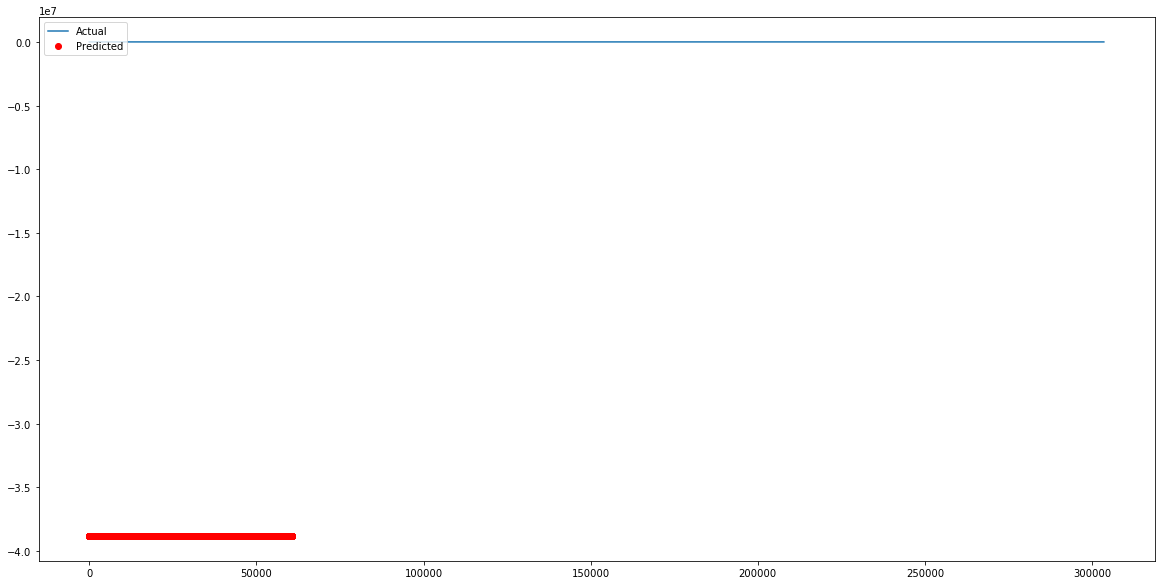

In [96]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.index, ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.index, prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.show()